
# Tutorial 13: Self-Supervised Contrastive Learning with SimCLR

* **Author:** Phillip Lippe
* **License:** CC BY-SA
* **Generated:** 2024-09-01T12:23:25.769688

In this tutorial, we will take a closer look at self-supervised contrastive learning.
Self-supervised learning, or also sometimes called unsupervised learning, describes the scenario where we have given input data, but no accompanying labels to train in a classical supervised way.
However, this data still contains a lot of information from which we can learn: how are the images different from each other?
What patterns are descriptive for certain images?
Can we cluster the images?
To get an insight into these questions, we will implement a popular, simple contrastive learning method, SimCLR, and apply it to the STL10 dataset.
This notebook is part of a lecture series on Deep Learning at the University of Amsterdam.
The full list of tutorials can be found at https://uvadlc-notebooks.rtfd.io.


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/13-contrastive-learning.ipynb)

Give us a ⭐ [on Github](https://www.github.com/Lightning-AI/lightning/)
| Check out [the documentation](https://lightning.ai/docs/)
| Join us [on Discord](https://discord.com/invite/tfXFetEZxv)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "torchmetrics >=1.0,<1.5" "seaborn" "numpy <3.0" "torchvision" "tensorboard" "torch >=1.8.1,<2.5" "pytorch-lightning >=2.0,<2.5" "matplotlib"

<div class="center-wrapper"><div class="video-wrapper"><iframe src="https://www.youtube.com/embed/waVZDFR-06U" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div></div>
Methods for self-supervised learning try to learn as much as possible from the data alone, so it can quickly be finetuned for a specific classification task.
The benefit of self-supervised learning is that a large dataset can often easily be obtained.
For instance, if we want to train a vision model on semantic segmentation for autonomous driving, we can collect large amounts of data by simply installing a camera in a car, and driving through a city for an hour.
In contrast, if we would want to do supervised learning, we would have to manually label all those images before training a model.
This is extremely expensive, and would likely take a couple of months to manually label the same amount of data.
Further, self-supervised learning can provide an alternative to transfer learning from models pretrained on ImageNet since we could pretrain a model on a specific dataset/situation, e.g. traffic scenarios for autonomous driving.

Within the last two years, a lot of new approaches have been proposed for self-supervised learning, in particular for images, that have resulted in great improvements over supervised models when few labels are available.
The subfield that we will focus on in this tutorial is contrastive learning.
Contrastive learning is motivated by the question mentioned above: how are images different from each other?
Specifically, contrastive learning methods train a model to cluster an image and its slightly augmented version in latent space, while the distance to other images should be maximized.
A very recent and simple method for this is [SimCLR](https://arxiv.org/abs/2006.10029), which is visualized below (figure credit - [Ting Chen et al. ](https://simclr.github.io/)).

<center width="100%"> 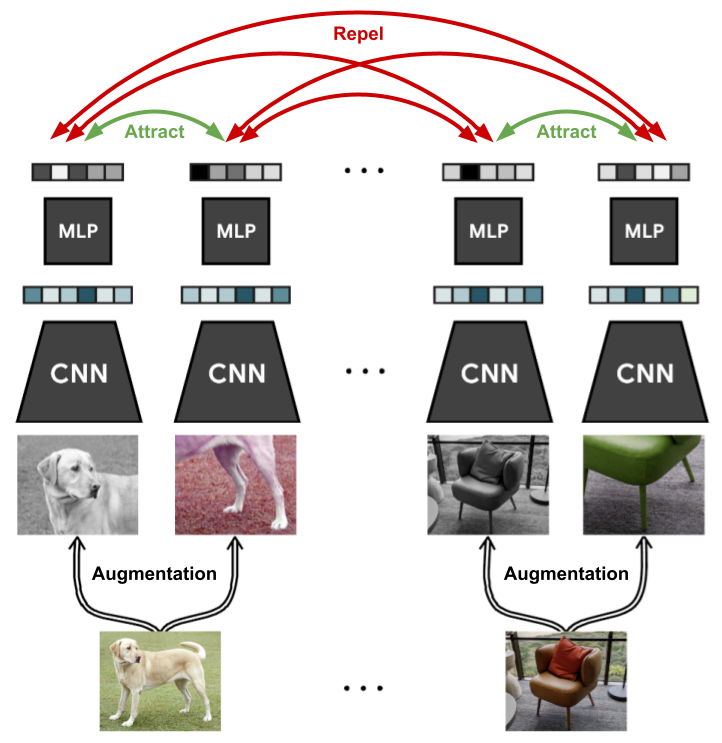{width="500px"} </center>

The general setup is that we are given a dataset of images without any labels, and want to train a model on this data such that it can quickly adapt to any image recognition task afterward.
During each training iteration, we sample a batch of images as usual.
For each image, we create two versions by applying data augmentation techniques like cropping, Gaussian noise, blurring, etc.
An example of such is shown on the left with the image of the dog.
We will go into the details and effects of the chosen augmentation techniques later.
On those images, we apply a CNN like ResNet and obtain as output a 1D feature vector on which we apply a small MLP.
The output features of the two augmented images are then trained to be close to each other, while all other images in that batch should be as different as possible.
This way, the model has to learn to recognize the content of the image that remains unchanged under the data augmentations, such as objects which we usually care about in supervised tasks.

We will now implement this framework ourselves and discuss further details along the way.
Let's first start with importing our standard libraries below:

In [2]:
import os
import urllib.request
from copy import deepcopy
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import STL10
from tqdm.notebook import tqdm

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.set()

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/ContrastiveLearning/")
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Seed set to 42


Device: cuda:0
Number of workers: 64


<Figure size 640x480 with 0 Axes>

As in many tutorials before, we provide pre-trained models.
Note that those models are slightly larger as normal (~100MB overall) since we use the default ResNet-18 architecture.
If you are running this notebook locally, make sure to have sufficient disk space available.

In [3]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = [
    "SimCLR.ckpt",
    "ResNet.ckpt",
    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
    "tensorboards/classification/ResNet/events.out.tfevents.ResNet",
]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder,"
                " or contact the author with the full output including the following error:\n",
                e,
            )

## SimCLR

We will start our exploration of contrastive learning by discussing the effect of different data augmentation techniques, and how we can implement an efficient data loader for such.
Next, we implement SimCLR with PyTorch Lightning, and finally train it on a large, unlabeled dataset.

### Data Augmentation for Contrastive Learning

To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch.
The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice.
This is implemented in the class `ContrastiveTransformations` below:

In [4]:
class ContrastiveTransformations:
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

The contrastive learning framework can easily be extended to have more _positive_ examples by sampling more than two augmentations of the same image.
However, the most efficient training is usually obtained by using only two.

Next, we can look at the specific augmentations we want to apply.
The choice of the data augmentation to use is the most crucial hyperparameter in SimCLR since it directly affects how the latent space is structured, and what patterns might be learned from the data.
Let's first take a look at some of the most popular data augmentations (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_data_augmentations.jpg" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

All of them can be used, but it turns out that two augmentations stand out in their importance: crop-and-resize, and color distortion.
Interestingly, however, they only lead to strong performance if they have been used together as discussed by [Ting Chen et al. ](https://arxiv.org/abs/2006.10029) in their SimCLR paper.
When performing randomly cropping and resizing, we can distinguish between two situations: (a) cropped image A provides a local view of cropped image B, or (b) cropped images C and D show neighboring views of the same image (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)).

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/crop_views.svg" width="400px" style="padding-top: 20px; padding-bottom: 0px"></center>

While situation (a) requires the model to learn some sort of scale invariance to make crops A and B similar in latent space, situation (b) is more challenging since the model needs to recognize an object beyond its limited view.
However, without color distortion, there is a loophole that the model can exploit, namely that different crops of the same image usually look very similar in color space.
Consider the picture of the dog above.
Simply from the color of the fur and the green color tone of the background, you can reason that two patches belong to the same image without actually recognizing the dog in the picture.
In this case, the model might end up focusing only on the color histograms of the images, and ignore other more generalizable features.
If, however, we distort the colors in the two patches randomly and independently of each other, the model cannot rely on this simple feature anymore.
Hence, by combining random cropping and color distortions, the model can only match two patches by learning generalizable representations.

Overall, for our experiments, we apply a set of 5 transformations following the original SimCLR setup: random horizontal flip, crop-and-resize, color distortion, random grayscale, and gaussian blur.
In comparison to the [original implementation](https://github.com/google-research/simclr), we reduce the effect of the color jitter slightly (0.5 instead of 0.8 for brightness, contrast, and saturation, and 0.1 instead of 0.2 for hue).
In our experiments, this setting obtained better performance and was faster and more stable to train.
If, for instance, the brightness scale highly varies in a dataset, the
original settings can be more beneficial since the model can't rely on
this information anymore to distinguish between images.

In [5]:
contrast_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

After discussing the data augmentation techniques, we can now focus on the dataset.
In this tutorial, we will use the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/), which, similarly to CIFAR10, contains images of 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
However, the images have a higher resolution, namely $96\times 96$ pixels, and we are only provided with 500 labeled images per class.
Additionally, we have a much larger set of $100,000$ unlabeled images which are similar to the training images but are sampled from a wider range of animals and vehicles.
This makes the dataset ideal to showcase the benefits that self-supervised learning offers.

Luckily, the STL10 dataset is provided through torchvision.
Keep in mind, however, that since this dataset is relatively large and has a considerably higher resolution than CIFAR10, it requires more disk space (~3GB) and takes a bit of time to download.
For our initial discussion of self-supervised learning and SimCLR, we
will create two data loaders with our contrastive transformations above:
the `unlabeled_data` will be used to train our model via contrastive
learning, and `train_data_contrast` will be used as a validation set in
contrastive learning.

In [6]:
unlabeled_data = STL10(
    root=DATASET_PATH,
    split="unlabeled",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2),
)
train_data_contrast = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2),
)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

  0%|          | 32768/2640397119 [00:00<2:44:58, 266733.98it/s]

  0%|          | 98304/2640397119 [00:00<1:46:22, 413652.87it/s]

  0%|          | 196608/2640397119 [00:00<1:16:24, 575945.81it/s]

  0%|          | 294912/2640397119 [00:00<1:07:08, 655352.34it/s]

  0%|          | 491520/2640397119 [00:00<45:06, 975532.43it/s]  

  0%|          | 786432/2640397119 [00:00<30:51, 1425813.60it/s]

  0%|          | 1179648/2640397119 [00:00<22:17, 1972971.21it/s]

  0%|          | 1769472/2640397119 [00:01<15:34, 2822871.36it/s]

  0%|          | 2588672/2640397119 [00:01<11:07, 3949722.99it/s]

  0%|          | 3604480/2640397119 [00:01<08:14, 5336871.82it/s]

  0%|          | 4423680/2640397119 [00:01<07:45, 5660613.28it/s]

  0%|          | 5242880/2640397119 [00:01<07:25, 5916736.93it/s]

  0%|          | 5865472/2640397119 [00:01<07:56, 5531689.82it/s]

  0%|          | 6651904/2640397119 [00:01<07:39, 5734759.36it/s]

  0%|          | 7274496/2640397119 [00:01<08:16, 5305617.92it/s]

  0%|          | 7864320/2640397119 [00:02<08:19, 5273582.14it/s]

  0%|          | 8486912/2640397119 [00:02<08:30, 5154302.50it/s]

  0%|          | 9142272/2640397119 [00:02<08:47, 4988215.79it/s]

  0%|          | 9764864/2640397119 [00:02<08:33, 5121667.55it/s]

  0%|          | 10420224/2640397119 [00:02<08:35, 5106589.65it/s]

  0%|          | 11075584/2640397119 [00:02<08:34, 5113409.75it/s]

  0%|          | 11730944/2640397119 [00:02<08:30, 5148623.36it/s]

  0%|          | 12419072/2640397119 [00:02<08:25, 5195488.87it/s]

  0%|          | 13107200/2640397119 [00:03<08:33, 5114963.16it/s]

  1%|          | 13795328/2640397119 [00:03<08:26, 5184521.73it/s]

  1%|          | 14450688/2640397119 [00:03<08:09, 5360559.23it/s]

  1%|          | 15171584/2640397119 [00:03<08:18, 5269698.83it/s]

  1%|          | 15859712/2640397119 [00:03<08:01, 5455612.34it/s]

  1%|          | 16547840/2640397119 [00:03<08:00, 5464512.37it/s]

  1%|          | 17268736/2640397119 [00:03<07:57, 5491061.00it/s]

  1%|          | 17956864/2640397119 [00:03<07:57, 5493327.16it/s]

  1%|          | 18677760/2640397119 [00:04<07:55, 5518084.57it/s]

  1%|          | 19398656/2640397119 [00:04<08:05, 5402937.72it/s]

  1%|          | 20086784/2640397119 [00:04<07:49, 5584941.35it/s]

  1%|          | 20742144/2640397119 [00:04<07:29, 5825934.66it/s]

  1%|          | 21331968/2640397119 [00:04<07:50, 5565852.91it/s]

  1%|          | 21921792/2640397119 [00:04<08:03, 5418091.74it/s]

  1%|          | 22609920/2640397119 [00:04<07:45, 5628462.31it/s]

  1%|          | 23265280/2640397119 [00:04<07:25, 5876942.84it/s]

  1%|          | 23887872/2640397119 [00:04<07:48, 5589350.80it/s]

  1%|          | 24477696/2640397119 [00:05<08:02, 5423981.02it/s]

  1%|          | 25133056/2640397119 [00:05<07:42, 5659320.57it/s]

  1%|          | 25755648/2640397119 [00:05<07:31, 5788715.64it/s]

  1%|          | 26345472/2640397119 [00:05<07:49, 5567918.60it/s]

  1%|          | 26935296/2640397119 [00:05<07:44, 5626731.45it/s]

  1%|          | 27557888/2640397119 [00:05<07:31, 5784175.06it/s]

  1%|          | 28147712/2640397119 [00:05<07:51, 5545203.29it/s]

  1%|          | 28770304/2640397119 [00:05<07:53, 5511681.14it/s]

  1%|          | 29458432/2640397119 [00:05<07:38, 5689560.82it/s]

  1%|          | 30048256/2640397119 [00:06<07:36, 5720922.45it/s]

  1%|          | 30638080/2640397119 [00:06<07:54, 5505529.07it/s]

  1%|          | 31260672/2640397119 [00:06<07:37, 5705942.98it/s]

  1%|          | 31850496/2640397119 [00:06<07:35, 5729910.30it/s]

  1%|          | 32440320/2640397119 [00:06<07:53, 5506922.89it/s]

  1%|▏         | 33095680/2640397119 [00:06<07:48, 5568429.78it/s]

  1%|▏         | 33783808/2640397119 [00:06<07:34, 5741134.85it/s]

  1%|▏         | 34373632/2640397119 [00:06<07:33, 5743737.90it/s]

  1%|▏         | 34963456/2640397119 [00:07<08:46, 4945720.82it/s]

  1%|▏         | 35586048/2640397119 [00:07<08:13, 5273051.04it/s]

  1%|▏         | 36143104/2640397119 [00:07<08:52, 4894259.54it/s]

  1%|▏         | 36667392/2640397119 [00:07<09:19, 4649932.67it/s]

  1%|▏         | 37158912/2640397119 [00:07<09:36, 4516896.48it/s]

  1%|▏         | 37650432/2640397119 [00:07<09:57, 4359343.68it/s]

  1%|▏         | 38141952/2640397119 [00:07<09:50, 4403564.88it/s]

  1%|▏         | 38633472/2640397119 [00:07<11:07, 3899839.53it/s]

  1%|▏         | 39190528/2640397119 [00:07<10:14, 4230992.84it/s]

  2%|▏         | 39649280/2640397119 [00:08<10:58, 3949538.90it/s]

  2%|▏         | 40075264/2640397119 [00:08<11:31, 3761771.79it/s]

  2%|▏         | 40468480/2640397119 [00:08<11:50, 3656736.37it/s]

  2%|▏         | 40861696/2640397119 [00:08<12:52, 3364362.91it/s]

  2%|▏         | 41222144/2640397119 [00:08<13:09, 3293564.62it/s]

  2%|▏         | 41582592/2640397119 [00:08<14:06, 3071669.99it/s]

  2%|▏         | 41910272/2640397119 [00:08<14:51, 2915508.06it/s]

  2%|▏         | 42205184/2640397119 [00:09<15:26, 2804943.02it/s]

  2%|▏         | 42500096/2640397119 [00:09<15:21, 2817679.42it/s]

  2%|▏         | 42795008/2640397119 [00:09<15:12, 2847554.86it/s]

  2%|▏         | 43089920/2640397119 [00:09<16:03, 2694994.36it/s]

  2%|▏         | 43384832/2640397119 [00:09<16:05, 2690774.45it/s]

  2%|▏         | 43712512/2640397119 [00:09<15:57, 2712405.76it/s]

  2%|▏         | 44040192/2640397119 [00:09<15:07, 2861127.04it/s]

  2%|▏         | 44335104/2640397119 [00:09<15:45, 2744585.60it/s]

  2%|▏         | 44630016/2640397119 [00:09<15:48, 2735618.12it/s]

  2%|▏         | 44957696/2640397119 [00:10<15:26, 2800715.35it/s]

  2%|▏         | 45252608/2640397119 [00:10<15:26, 2801621.26it/s]

  2%|▏         | 45547520/2640397119 [00:10<15:36, 2772028.85it/s]

  2%|▏         | 45875200/2640397119 [00:10<15:20, 2818121.08it/s]

  2%|▏         | 46235648/2640397119 [00:10<15:02, 2872948.35it/s]

  2%|▏         | 46530560/2640397119 [00:10<15:08, 2854279.25it/s]

  2%|▏         | 46825472/2640397119 [00:10<15:03, 2869072.85it/s]

  2%|▏         | 47185920/2640397119 [00:10<14:57, 2888127.84it/s]

  2%|▏         | 47546368/2640397119 [00:10<14:58, 2886971.73it/s]

  2%|▏         | 47874048/2640397119 [00:11<14:28, 2985195.40it/s]

  2%|▏         | 48201728/2640397119 [00:11<14:48, 2918929.57it/s]

  2%|▏         | 48496640/2640397119 [00:11<14:52, 2905295.86it/s]

  2%|▏         | 48857088/2640397119 [00:11<14:49, 2914695.13it/s]

  2%|▏         | 49184768/2640397119 [00:11<14:32, 2970362.12it/s]

  2%|▏         | 49512448/2640397119 [00:11<14:49, 2913896.04it/s]

  2%|▏         | 49840128/2640397119 [00:11<14:50, 2909897.11it/s]

  2%|▏         | 50167808/2640397119 [00:11<14:31, 2971731.91it/s]

  2%|▏         | 50495488/2640397119 [00:11<14:34, 2962981.37it/s]

  2%|▏         | 50823168/2640397119 [00:12<14:53, 2899208.45it/s]

  2%|▏         | 51150848/2640397119 [00:12<14:34, 2962197.41it/s]

  2%|▏         | 51478528/2640397119 [00:12<14:35, 2958455.85it/s]

  2%|▏         | 51806208/2640397119 [00:12<14:37, 2950314.30it/s]

  2%|▏         | 52133888/2640397119 [00:12<14:56, 2886643.66it/s]

  2%|▏         | 52461568/2640397119 [00:12<14:33, 2961430.98it/s]

  2%|▏         | 52789248/2640397119 [00:12<14:30, 2970949.62it/s]

  2%|▏         | 53116928/2640397119 [00:12<14:28, 2978217.25it/s]

  2%|▏         | 53444608/2640397119 [00:12<15:00, 2873241.41it/s]

  2%|▏         | 53772288/2640397119 [00:13<14:32, 2966044.51it/s]

  2%|▏         | 54132736/2640397119 [00:13<14:34, 2957458.38it/s]

  2%|▏         | 54460416/2640397119 [00:13<14:18, 3012118.57it/s]

  2%|▏         | 54788096/2640397119 [00:13<14:45, 2921577.18it/s]

  2%|▏         | 55115776/2640397119 [00:13<14:39, 2939120.51it/s]

  2%|▏         | 55443456/2640397119 [00:13<14:40, 2934209.51it/s]

  2%|▏         | 55771136/2640397119 [00:13<14:22, 2996375.81it/s]

  2%|▏         | 56098816/2640397119 [00:13<14:49, 2905977.75it/s]

  2%|▏         | 56426496/2640397119 [00:13<14:40, 2936088.13it/s]

  2%|▏         | 56754176/2640397119 [00:14<14:26, 2982816.23it/s]

  2%|▏         | 57081856/2640397119 [00:14<14:24, 2986831.20it/s]

  2%|▏         | 57409536/2640397119 [00:14<14:48, 2905964.84it/s]

  2%|▏         | 57737216/2640397119 [00:14<14:25, 2983503.54it/s]

  2%|▏         | 58097664/2640397119 [00:14<14:40, 2932140.28it/s]

  2%|▏         | 58458112/2640397119 [00:14<13:50, 3110024.48it/s]

  2%|▏         | 58785792/2640397119 [00:14<14:22, 2992559.64it/s]

  2%|▏         | 59113472/2640397119 [00:14<14:09, 3038721.95it/s]

  2%|▏         | 59441152/2640397119 [00:14<14:01, 3068834.87it/s]

  2%|▏         | 59768832/2640397119 [00:15<14:10, 3033821.47it/s]

  2%|▏         | 60096512/2640397119 [00:15<13:54, 3093629.80it/s]

  2%|▏         | 60456960/2640397119 [00:15<14:13, 3023774.41it/s]

  2%|▏         | 60850176/2640397119 [00:15<13:35, 3164538.23it/s]

  2%|▏         | 61177856/2640397119 [00:15<13:44, 3129478.24it/s]

  2%|▏         | 61505536/2640397119 [00:15<13:37, 3154150.73it/s]

  2%|▏         | 61898752/2640397119 [00:15<13:37, 3154276.26it/s]

  2%|▏         | 62291968/2640397119 [00:15<13:04, 3285490.71it/s]

  2%|▏         | 62652416/2640397119 [00:15<13:10, 3261451.79it/s]

  2%|▏         | 62980096/2640397119 [00:16<13:09, 3265234.72it/s]

  2%|▏         | 63373312/2640397119 [00:16<12:46, 3361100.10it/s]

  2%|▏         | 63733760/2640397119 [00:16<12:50, 3345621.84it/s]

  2%|▏         | 64094208/2640397119 [00:16<12:37, 3399605.36it/s]

  2%|▏         | 64487424/2640397119 [00:16<12:20, 3476782.51it/s]

  2%|▏         | 64847872/2640397119 [00:16<12:26, 3450192.87it/s]

  2%|▏         | 65241088/2640397119 [00:16<12:08, 3536731.49it/s]

  2%|▏         | 65667072/2640397119 [00:16<12:11, 3521838.65it/s]

  3%|▎         | 66093056/2640397119 [00:16<11:35, 3701923.46it/s]

  3%|▎         | 66486272/2640397119 [00:17<11:49, 3628362.80it/s]

  3%|▎         | 66879488/2640397119 [00:17<11:37, 3689677.36it/s]

  3%|▎         | 67338240/2640397119 [00:17<11:00, 3897332.07it/s]

  3%|▎         | 67731456/2640397119 [00:17<11:10, 3835187.93it/s]

  3%|▎         | 68157440/2640397119 [00:17<11:03, 3874350.05it/s]

  3%|▎         | 68616192/2640397119 [00:17<10:37, 4036277.78it/s]

  3%|▎         | 69074944/2640397119 [00:17<10:36, 4041710.01it/s]

  3%|▎         | 69500928/2640397119 [00:17<10:29, 4083418.24it/s]

  3%|▎         | 69992448/2640397119 [00:17<10:00, 4279668.38it/s]

  3%|▎         | 70483968/2640397119 [00:17<10:00, 4282076.59it/s]

  3%|▎         | 70942720/2640397119 [00:18<09:51, 4342151.77it/s]

  3%|▎         | 71467008/2640397119 [00:18<09:25, 4543390.49it/s]

  3%|▎         | 71958528/2640397119 [00:18<09:23, 4555523.76it/s]

  3%|▎         | 72450048/2640397119 [00:18<09:22, 4564972.03it/s]

  3%|▎         | 73007104/2640397119 [00:18<08:55, 4792934.92it/s]

  3%|▎         | 73531392/2640397119 [00:18<08:50, 4836146.27it/s]

  3%|▎         | 74055680/2640397119 [00:18<08:50, 4838977.06it/s]

  3%|▎         | 74612736/2640397119 [00:18<08:28, 5043484.14it/s]

  3%|▎         | 75169792/2640397119 [00:18<08:14, 5189552.27it/s]

  3%|▎         | 75759616/2640397119 [00:19<08:02, 5310020.46it/s]

  3%|▎         | 76316672/2640397119 [00:19<08:00, 5340344.80it/s]

  3%|▎         | 76873728/2640397119 [00:19<07:56, 5384372.44it/s]

  3%|▎         | 77529088/2640397119 [00:19<07:29, 5696634.32it/s]

  3%|▎         | 78118912/2640397119 [00:19<07:26, 5732612.93it/s]

  3%|▎         | 78774272/2640397119 [00:19<07:27, 5725291.79it/s]

  3%|▎         | 79495168/2640397119 [00:19<06:58, 6112847.49it/s]

  3%|▎         | 80150528/2640397119 [00:19<06:54, 6179052.26it/s]

  3%|▎         | 80838656/2640397119 [00:19<06:58, 6110108.11it/s]

  3%|▎         | 81625088/2640397119 [00:19<06:29, 6569685.65it/s]

  3%|▎         | 82313216/2640397119 [00:20<06:24, 6653421.77it/s]

  3%|▎         | 83066880/2640397119 [00:20<06:28, 6589250.75it/s]

  3%|▎         | 83886080/2640397119 [00:20<06:02, 7044043.77it/s]

  3%|▎         | 84606976/2640397119 [00:20<06:00, 7084109.18it/s]

  3%|▎         | 85458944/2640397119 [00:20<05:59, 7116684.50it/s]

  3%|▎         | 86343680/2640397119 [00:20<05:36, 7595250.57it/s]

  3%|▎         | 87130112/2640397119 [00:20<05:34, 7636700.84it/s]

  3%|▎         | 88014848/2640397119 [00:20<05:34, 7626642.89it/s]

  3%|▎         | 88997888/2640397119 [00:20<05:11, 8185941.42it/s]

  3%|▎         | 89849856/2640397119 [00:21<05:08, 8254240.86it/s]

  3%|▎         | 90800128/2640397119 [00:21<05:11, 8194004.85it/s]

  3%|▎         | 91848704/2640397119 [00:21<04:49, 8803803.49it/s]

  4%|▎         | 92766208/2640397119 [00:21<04:46, 8885050.13it/s]

  4%|▎         | 93782016/2640397119 [00:21<04:45, 8909644.30it/s]

  4%|▎         | 94863360/2640397119 [00:21<04:30, 9412111.58it/s]

  4%|▎         | 95813632/2640397119 [00:21<04:30, 9401786.02it/s]

  4%|▎         | 96960512/2640397119 [00:21<04:14, 9976458.55it/s]

  4%|▎         | 97976320/2640397119 [00:21<04:16, 9910016.70it/s]

  4%|▍         | 99024896/2640397119 [00:21<04:13, 10011434.16it/s]

  4%|▍         | 100204544/2640397119 [00:22<04:01, 10509635.58it/s]

  4%|▍         | 101285888/2640397119 [00:22<04:01, 10518926.00it/s]

  4%|▍         | 102367232/2640397119 [00:22<04:23, 9626855.50it/s] 

  4%|▍         | 103677952/2640397119 [00:22<04:06, 10278570.40it/s]

  4%|▍         | 104726528/2640397119 [00:22<04:14, 9963891.50it/s] 

  4%|▍         | 105742336/2640397119 [00:22<04:25, 9529226.62it/s]

  4%|▍         | 106725376/2640397119 [00:22<04:35, 9206392.47it/s]

  4%|▍         | 107675648/2640397119 [00:22<04:42, 8969713.65it/s]

  4%|▍         | 108658688/2640397119 [00:22<04:44, 8908778.02it/s]

  4%|▍         | 109641728/2640397119 [00:23<04:39, 9067825.05it/s]

  4%|▍         | 110559232/2640397119 [00:23<04:40, 9027086.41it/s]

  4%|▍         | 111575040/2640397119 [00:23<04:30, 9340222.06it/s]

  4%|▍         | 112525312/2640397119 [00:23<04:34, 9222171.50it/s]

  4%|▍         | 113475584/2640397119 [00:23<04:36, 9155046.57it/s]

  4%|▍         | 114556928/2640397119 [00:23<04:23, 9592198.31it/s]

  4%|▍         | 115539968/2640397119 [00:23<04:26, 9478006.14it/s]

  4%|▍         | 116555776/2640397119 [00:23<04:24, 9541208.55it/s]

  4%|▍         | 117637120/2640397119 [00:23<04:16, 9853779.23it/s]

  4%|▍         | 118652928/2640397119 [00:24<04:18, 9752607.26it/s]

  5%|▍         | 119767040/2640397119 [00:24<04:17, 9770542.59it/s]

  5%|▍         | 120913920/2640397119 [00:24<04:08, 10146418.06it/s]

  5%|▍         | 121962496/2640397119 [00:24<04:09, 10081867.42it/s]

  5%|▍         | 123043840/2640397119 [00:24<04:08, 10144298.48it/s]

  5%|▍         | 124125184/2640397119 [00:24<04:03, 10329836.19it/s]

  5%|▍         | 125173760/2640397119 [00:24<04:06, 10187987.09it/s]

  5%|▍         | 126386176/2640397119 [00:24<03:56, 10651956.86it/s]

  5%|▍         | 127467520/2640397119 [00:24<04:01, 10423065.07it/s]

  5%|▍         | 128548864/2640397119 [00:24<04:03, 10324681.79it/s]

  5%|▍         | 129794048/2640397119 [00:25<03:51, 10828262.71it/s]

  5%|▍         | 130908160/2640397119 [00:25<03:54, 10688765.64it/s]

  5%|▌         | 132022272/2640397119 [00:25<03:55, 10635361.38it/s]

  5%|▌         | 133201920/2640397119 [00:25<03:49, 10921903.54it/s]

  5%|▌         | 134348800/2640397119 [00:25<03:49, 10924415.02it/s]

  5%|▌         | 135495680/2640397119 [00:25<03:48, 10956346.60it/s]

  5%|▌         | 136609792/2640397119 [00:25<03:47, 10983182.17it/s]

  5%|▌         | 137723904/2640397119 [00:25<03:50, 10879698.95it/s]

  5%|▌         | 138936320/2640397119 [00:25<03:43, 11214003.38it/s]

  5%|▌         | 140083200/2640397119 [00:26<03:43, 11192622.38it/s]

  5%|▌         | 141230080/2640397119 [00:26<03:42, 11221818.39it/s]

  5%|▌         | 142376960/2640397119 [00:26<03:43, 11160727.46it/s]

  5%|▌         | 143523840/2640397119 [00:26<03:44, 11109269.12it/s]

  5%|▌         | 144769024/2640397119 [00:26<03:38, 11428297.57it/s]

  6%|▌         | 145915904/2640397119 [00:26<03:38, 11393129.52it/s]

  6%|▌         | 147095552/2640397119 [00:26<03:41, 11248011.80it/s]

  6%|▌         | 148340736/2640397119 [00:26<03:36, 11516625.31it/s]

  6%|▌         | 149520384/2640397119 [00:26<03:39, 11337394.23it/s]

  6%|▌         | 150732800/2640397119 [00:26<03:36, 11483291.93it/s]

  6%|▌         | 151912448/2640397119 [00:27<03:36, 11469420.29it/s]

  6%|▌         | 153092096/2640397119 [00:27<03:38, 11388354.15it/s]

  6%|▌         | 154337280/2640397119 [00:27<03:34, 11608897.71it/s]

  6%|▌         | 155516928/2640397119 [00:27<03:34, 11598456.41it/s]

  6%|▌         | 156696576/2640397119 [00:27<03:37, 11398246.18it/s]

  6%|▌         | 158007296/2640397119 [00:27<03:31, 11710323.99it/s]

  6%|▌         | 159186944/2640397119 [00:27<03:34, 11556430.08it/s]

  6%|▌         | 160399360/2640397119 [00:27<03:36, 11451596.39it/s]

  6%|▌         | 161644544/2640397119 [00:27<03:31, 11736618.51it/s]

  6%|▌         | 162824192/2640397119 [00:27<03:34, 11545058.57it/s]

  6%|▌         | 164036608/2640397119 [00:28<03:32, 11670563.25it/s]

  6%|▋         | 165216256/2640397119 [00:28<03:32, 11654275.55it/s]

  6%|▋         | 166395904/2640397119 [00:28<03:35, 11498699.84it/s]

  6%|▋         | 167641088/2640397119 [00:28<03:30, 11740349.31it/s]

  6%|▋         | 168820736/2640397119 [00:28<03:33, 11573479.82it/s]

  6%|▋         | 170033152/2640397119 [00:28<03:30, 11727481.81it/s]

  6%|▋         | 171212800/2640397119 [00:28<03:31, 11697691.32it/s]

  7%|▋         | 172392448/2640397119 [00:28<03:37, 11346433.05it/s]

  7%|▋         | 173637632/2640397119 [00:28<03:32, 11614215.60it/s]

  7%|▋         | 174882816/2640397119 [00:29<03:28, 11803592.06it/s]

  7%|▋         | 176095232/2640397119 [00:29<03:36, 11383933.52it/s]

  7%|▋         | 177340416/2640397119 [00:29<03:31, 11633773.83it/s]

  7%|▋         | 178585600/2640397119 [00:29<03:28, 11816974.14it/s]

  7%|▋         | 179798016/2640397119 [00:29<03:34, 11452573.15it/s]

  7%|▋         | 181043200/2640397119 [00:29<03:31, 11626783.84it/s]

  7%|▋         | 182222848/2640397119 [00:29<03:30, 11673111.90it/s]

  7%|▋         | 183402496/2640397119 [00:29<03:30, 11686513.72it/s]

  7%|▋         | 184614912/2640397119 [00:29<03:28, 11767963.88it/s]

  7%|▋         | 185794560/2640397119 [00:29<03:36, 11357819.21it/s]

  7%|▋         | 187039744/2640397119 [00:30<03:31, 11590727.96it/s]

  7%|▋         | 188252160/2640397119 [00:30<03:28, 11742139.88it/s]

  7%|▋         | 189431808/2640397119 [00:30<03:34, 11410442.88it/s]

  7%|▋         | 190709760/2640397119 [00:30<03:29, 11693782.13it/s]

  7%|▋         | 191889408/2640397119 [00:30<03:29, 11664295.33it/s]

  7%|▋         | 193069056/2640397119 [00:30<03:31, 11597489.54it/s]

  7%|▋         | 194281472/2640397119 [00:30<03:28, 11748955.52it/s]

  7%|▋         | 195461120/2640397119 [00:30<03:33, 11433558.00it/s]

  7%|▋         | 196706304/2640397119 [00:30<03:28, 11699025.63it/s]

  7%|▋         | 197885952/2640397119 [00:31<03:28, 11715272.07it/s]

  8%|▊         | 199065600/2640397119 [00:31<03:33, 11454850.08it/s]

  8%|▊         | 200343552/2640397119 [00:31<03:26, 11801401.96it/s]

  8%|▊         | 201555968/2640397119 [00:31<03:30, 11612413.97it/s]

  8%|▊         | 202768384/2640397119 [00:31<03:31, 11512105.60it/s]

  8%|▊         | 204046336/2640397119 [00:31<03:26, 11824277.06it/s]

  8%|▊         | 205258752/2640397119 [00:31<03:29, 11614334.70it/s]

  8%|▊         | 206536704/2640397119 [00:31<03:28, 11666095.80it/s]

  8%|▊         | 207781888/2640397119 [00:31<03:24, 11890944.50it/s]

  8%|▊         | 208994304/2640397119 [00:31<03:28, 11686197.29it/s]

  8%|▊         | 210239488/2640397119 [00:32<03:24, 11873665.12it/s]

  8%|▊         | 211451904/2640397119 [00:32<03:23, 11921992.76it/s]

  8%|▊         | 212664320/2640397119 [00:32<03:29, 11610425.78it/s]

  8%|▊         | 213942272/2640397119 [00:32<03:24, 11877817.99it/s]

  8%|▊         | 215154688/2640397119 [00:32<03:25, 11806277.54it/s]

  8%|▊         | 216367104/2640397119 [00:32<03:27, 11700704.70it/s]

  8%|▊         | 217546752/2640397119 [00:32<03:30, 11489635.34it/s]

  8%|▊         | 218726400/2640397119 [00:32<03:44, 10767953.87it/s]

  8%|▊         | 219840512/2640397119 [00:32<04:21, 9242112.19it/s] 

  8%|▊         | 220823552/2640397119 [00:33<04:49, 8353420.78it/s]

  8%|▊         | 221708288/2640397119 [00:33<05:15, 7663989.67it/s]

  8%|▊         | 222527488/2640397119 [00:33<05:31, 7292948.21it/s]

  8%|▊         | 223281152/2640397119 [00:33<05:47, 6965410.14it/s]

  8%|▊         | 224002048/2640397119 [00:33<05:51, 6866141.45it/s]

  9%|▊         | 224722944/2640397119 [00:33<06:01, 6673355.05it/s]

  9%|▊         | 225443840/2640397119 [00:33<06:00, 6700365.11it/s]

  9%|▊         | 226131968/2640397119 [00:33<06:01, 6678895.81it/s]

  9%|▊         | 226820096/2640397119 [00:34<06:07, 6573532.81it/s]

  9%|▊         | 227573760/2640397119 [00:34<05:58, 6729379.33it/s]

  9%|▊         | 228261888/2640397119 [00:34<05:59, 6701422.46it/s]

  9%|▊         | 228950016/2640397119 [00:34<06:05, 6600631.35it/s]

  9%|▊         | 229703680/2640397119 [00:34<05:52, 6834740.66it/s]

  9%|▊         | 230424576/2640397119 [00:34<05:47, 6931947.42it/s]

  9%|▉         | 231145472/2640397119 [00:34<06:01, 6665855.23it/s]

  9%|▉         | 231899136/2640397119 [00:34<05:48, 6909012.21it/s]

  9%|▉         | 232652800/2640397119 [00:34<05:45, 6964481.88it/s]

  9%|▉         | 233373696/2640397119 [00:35<05:55, 6774875.18it/s]

  9%|▉         | 234160128/2640397119 [00:35<05:40, 7061495.13it/s]

  9%|▉         | 234913792/2640397119 [00:35<05:39, 7088660.60it/s]

  9%|▉         | 235634688/2640397119 [00:35<05:49, 6871075.33it/s]

  9%|▉         | 236421120/2640397119 [00:35<05:36, 7138037.99it/s]

  9%|▉         | 237142016/2640397119 [00:35<05:48, 6905456.42it/s]

  9%|▉         | 237862912/2640397119 [00:35<06:21, 6305104.06it/s]

  9%|▉         | 238518272/2640397119 [00:35<06:44, 5932193.78it/s]

  9%|▉         | 239140864/2640397119 [00:35<07:00, 5716722.86it/s]

  9%|▉         | 239730688/2640397119 [00:36<07:08, 5607203.83it/s]

  9%|▉         | 240320512/2640397119 [00:36<07:28, 5347605.17it/s]

  9%|▉         | 240943104/2640397119 [00:36<07:14, 5516870.47it/s]

  9%|▉         | 241500160/2640397119 [00:36<07:21, 5431801.78it/s]

  9%|▉         | 242057216/2640397119 [00:36<07:27, 5355263.33it/s]

  9%|▉         | 242679808/2640397119 [00:36<07:10, 5566299.95it/s]

  9%|▉         | 243269632/2640397119 [00:36<07:14, 5515743.36it/s]

  9%|▉         | 243826688/2640397119 [00:36<07:21, 5422877.32it/s]

  9%|▉         | 244482048/2640397119 [00:36<07:01, 5683200.92it/s]

  9%|▉         | 245071872/2640397119 [00:37<07:06, 5615543.31it/s]

  9%|▉         | 245661696/2640397119 [00:37<07:11, 5553021.12it/s]

  9%|▉         | 246317056/2640397119 [00:37<06:53, 5790057.77it/s]

  9%|▉         | 246906880/2640397119 [00:37<06:59, 5706840.15it/s]

  9%|▉         | 247496704/2640397119 [00:37<07:03, 5650257.83it/s]

  9%|▉         | 248152064/2640397119 [00:37<06:50, 5829240.79it/s]

  9%|▉         | 248774656/2640397119 [00:37<06:50, 5826909.92it/s]

  9%|▉         | 249364480/2640397119 [00:37<06:57, 5733057.01it/s]

  9%|▉         | 250052608/2640397119 [00:37<06:41, 5947404.60it/s]

  9%|▉         | 250675200/2640397119 [00:37<06:46, 5884324.18it/s]

 10%|▉         | 251265024/2640397119 [00:38<06:51, 5811961.27it/s]

 10%|▉         | 251953152/2640397119 [00:38<06:37, 6005363.18it/s]

 10%|▉         | 252575744/2640397119 [00:38<06:39, 5980917.05it/s]

 10%|▉         | 253198336/2640397119 [00:38<06:45, 5880547.28it/s]

 10%|▉         | 253853696/2640397119 [00:38<06:37, 6004720.78it/s]

 10%|▉         | 254476288/2640397119 [00:38<06:38, 5990870.85it/s]

 10%|▉         | 255098880/2640397119 [00:38<06:42, 5922165.71it/s]

 10%|▉         | 255754240/2640397119 [00:38<06:37, 5994734.56it/s]

 10%|▉         | 256376832/2640397119 [00:38<06:36, 6010467.70it/s]

 10%|▉         | 256999424/2640397119 [00:39<06:42, 5926315.87it/s]

 10%|▉         | 257687552/2640397119 [00:39<06:33, 6058353.08it/s]

 10%|▉         | 258310144/2640397119 [00:39<06:32, 6074002.89it/s]

 10%|▉         | 258932736/2640397119 [00:39<06:38, 5969773.75it/s]

 10%|▉         | 259620864/2640397119 [00:39<06:31, 6083658.52it/s]

 10%|▉         | 260276224/2640397119 [00:39<06:27, 6145066.62it/s]

 10%|▉         | 260898816/2640397119 [00:39<06:37, 5988562.24it/s]

 10%|▉         | 261554176/2640397119 [00:39<06:31, 6079270.64it/s]

 10%|▉         | 262209536/2640397119 [00:39<06:27, 6138980.43it/s]

 10%|▉         | 262832128/2640397119 [00:40<06:35, 6017285.51it/s]

 10%|▉         | 263487488/2640397119 [00:40<06:31, 6073378.87it/s]

 10%|█         | 264110080/2640397119 [00:40<06:28, 6114396.17it/s]

 10%|█         | 264732672/2640397119 [00:40<06:36, 5988663.72it/s]

 10%|█         | 265388032/2640397119 [00:40<06:30, 6089532.37it/s]

 10%|█         | 266010624/2640397119 [00:40<06:30, 6077386.68it/s]

 10%|█         | 266633216/2640397119 [00:40<06:33, 6035293.81it/s]

 10%|█         | 267288576/2640397119 [00:40<06:28, 6111015.83it/s]

 10%|█         | 267911168/2640397119 [00:40<06:28, 6102218.82it/s]

 10%|█         | 268533760/2640397119 [00:40<06:30, 6077827.93it/s]

 10%|█         | 269189120/2640397119 [00:41<06:27, 6120063.90it/s]

 10%|█         | 269811712/2640397119 [00:41<06:32, 6038876.92it/s]

 10%|█         | 270434304/2640397119 [00:41<06:29, 6084161.48it/s]

 10%|█         | 271056896/2640397119 [00:41<06:30, 6064417.72it/s]

 10%|█         | 271679488/2640397119 [00:41<06:32, 6037497.32it/s]

 10%|█         | 272334848/2640397119 [00:41<06:26, 6131982.48it/s]

 10%|█         | 272957440/2640397119 [00:41<06:28, 6096983.27it/s]

 10%|█         | 273580032/2640397119 [00:41<06:28, 6098270.77it/s]

 10%|█         | 274235392/2640397119 [00:41<06:27, 6102745.63it/s]

 10%|█         | 274857984/2640397119 [00:41<06:31, 6039293.23it/s]

 10%|█         | 275513344/2640397119 [00:42<06:26, 6112597.60it/s]

 10%|█         | 276135936/2640397119 [00:42<06:27, 6104704.98it/s]

 10%|█         | 276758528/2640397119 [00:42<06:32, 6016720.60it/s]

 11%|█         | 277413888/2640397119 [00:42<06:28, 6085885.19it/s]

 11%|█         | 278036480/2640397119 [00:42<06:31, 6034786.54it/s]

 11%|█         | 278659072/2640397119 [00:42<06:31, 6037836.68it/s]

 11%|█         | 279314432/2640397119 [00:42<06:22, 6178160.33it/s]

 11%|█         | 279937024/2640397119 [00:42<06:24, 6135891.44it/s]

 11%|█         | 280592384/2640397119 [00:42<06:23, 6161254.22it/s]

 11%|█         | 281214976/2640397119 [00:43<06:22, 6172189.30it/s]

 11%|█         | 281837568/2640397119 [00:43<06:26, 6097171.49it/s]

 11%|█         | 282525696/2640397119 [00:43<06:17, 6243379.68it/s]

 11%|█         | 283181056/2640397119 [00:43<06:19, 6205070.61it/s]

 11%|█         | 283836416/2640397119 [00:43<06:21, 6182277.63it/s]

 11%|█         | 284524544/2640397119 [00:43<06:14, 6298308.73it/s]

 11%|█         | 285179904/2640397119 [00:43<06:16, 6251490.44it/s]

 11%|█         | 285835264/2640397119 [00:43<06:15, 6271430.66it/s]

 11%|█         | 286490624/2640397119 [00:43<06:12, 6317819.09it/s]

 11%|█         | 287145984/2640397119 [00:43<06:10, 6343444.87it/s]

 11%|█         | 287834112/2640397119 [00:44<06:07, 6402844.15it/s]

 11%|█         | 288522240/2640397119 [00:44<05:59, 6535970.77it/s]

 11%|█         | 289177600/2640397119 [00:44<06:05, 6433772.84it/s]

 11%|█         | 289832960/2640397119 [00:44<06:04, 6449310.68it/s]

 11%|█         | 290521088/2640397119 [00:44<05:58, 6548154.60it/s]

 11%|█         | 291209216/2640397119 [00:44<05:57, 6573379.82it/s]

 11%|█         | 291930112/2640397119 [00:44<05:54, 6622345.67it/s]

 11%|█         | 292618240/2640397119 [00:44<05:54, 6618648.31it/s]

 11%|█         | 293339136/2640397119 [00:44<05:50, 6687597.74it/s]

 11%|█         | 294027264/2640397119 [00:44<05:48, 6740076.81it/s]

 11%|█         | 294715392/2640397119 [00:45<05:46, 6760041.63it/s]

 11%|█         | 295469056/2640397119 [00:45<05:40, 6878195.44it/s]

 11%|█         | 296189952/2640397119 [00:45<05:36, 6975001.85it/s]

 11%|█         | 296910848/2640397119 [00:45<05:35, 6978448.54it/s]

 11%|█▏        | 297631744/2640397119 [00:45<05:34, 7003016.49it/s]

 11%|█▏        | 298385408/2640397119 [00:45<05:30, 7081415.13it/s]

 11%|█▏        | 299139072/2640397119 [00:45<05:25, 7196444.97it/s]

 11%|█▏        | 299925504/2640397119 [00:45<05:23, 7237880.47it/s]

 11%|█▏        | 300711936/2640397119 [00:45<05:21, 7285205.29it/s]

 11%|█▏        | 301498368/2640397119 [00:46<05:14, 7448082.00it/s]

 11%|█▏        | 302284800/2640397119 [00:46<05:11, 7510596.82it/s]

 11%|█▏        | 303071232/2640397119 [00:46<05:12, 7476955.19it/s]

 12%|█▏        | 303857664/2640397119 [00:46<05:10, 7526552.34it/s]

 12%|█▏        | 304709632/2640397119 [00:46<05:01, 7738823.24it/s]

 12%|█▏        | 305561600/2640397119 [00:46<04:55, 7900704.02it/s]

 12%|█▏        | 306380800/2640397119 [00:46<04:57, 7855702.52it/s]

 12%|█▏        | 307232768/2640397119 [00:46<04:49, 8046904.42it/s]

 12%|█▏        | 308051968/2640397119 [00:46<04:48, 8074051.57it/s]

 12%|█▏        | 308903936/2640397119 [00:46<04:44, 8195764.56it/s]

 12%|█▏        | 309821440/2640397119 [00:47<04:35, 8447088.75it/s]

 12%|█▏        | 310706176/2640397119 [00:47<04:38, 8379397.10it/s]

 12%|█▏        | 311623680/2640397119 [00:47<04:30, 8598213.21it/s]

 12%|█▏        | 312508416/2640397119 [00:47<04:29, 8650973.88it/s]

 12%|█▏        | 313425920/2640397119 [00:47<04:25, 8775780.57it/s]

 12%|█▏        | 314408960/2640397119 [00:47<04:16, 9056097.51it/s]

 12%|█▏        | 315359232/2640397119 [00:47<04:17, 9017614.83it/s]

 12%|█▏        | 316342272/2640397119 [00:47<04:11, 9247285.76it/s]

 12%|█▏        | 317292544/2640397119 [00:47<04:10, 9283741.65it/s]

 12%|█▏        | 318308352/2640397119 [00:47<04:04, 9488420.70it/s]

 12%|█▏        | 319356928/2640397119 [00:48<03:57, 9767877.09it/s]

 12%|█▏        | 320372736/2640397119 [00:48<03:58, 9708695.76it/s]

 12%|█▏        | 321421312/2640397119 [00:48<03:54, 9889952.10it/s]

 12%|█▏        | 322469888/2640397119 [00:48<03:50, 10049857.68it/s]

 12%|█▏        | 323584000/2640397119 [00:48<03:45, 10267682.20it/s]

 12%|█▏        | 324730880/2640397119 [00:48<03:40, 10500541.81it/s]

 12%|█▏        | 325812224/2640397119 [00:48<03:39, 10543801.32it/s]

 12%|█▏        | 326959104/2640397119 [00:48<03:34, 10780042.44it/s]

 12%|█▏        | 328040448/2640397119 [00:48<03:35, 10719694.20it/s]

 12%|█▏        | 329121792/2640397119 [00:49<03:57, 9721092.31it/s] 

 13%|█▎        | 330137600/2640397119 [00:49<04:08, 9297492.56it/s]

 13%|█▎        | 331087872/2640397119 [00:49<04:19, 8883325.87it/s]

 13%|█▎        | 332005376/2640397119 [00:49<04:20, 8872464.75it/s]

 13%|█▎        | 332922880/2640397119 [00:49<04:20, 8851755.03it/s]

 13%|█▎        | 333840384/2640397119 [00:49<04:24, 8732012.45it/s]

 13%|█▎        | 334790656/2640397119 [00:49<04:20, 8866775.36it/s]

 13%|█▎        | 335708160/2640397119 [00:49<04:17, 8939507.85it/s]

 13%|█▎        | 336625664/2640397119 [00:49<04:16, 8983059.64it/s]

 13%|█▎        | 337575936/2640397119 [00:49<04:12, 9102146.37it/s]

 13%|█▎        | 338493440/2640397119 [00:50<04:15, 9025485.44it/s]

 13%|█▎        | 339476480/2640397119 [00:50<04:09, 9228687.75it/s]

 13%|█▎        | 340426752/2640397119 [00:50<04:08, 9254450.44it/s]

 13%|█▎        | 341475328/2640397119 [00:50<04:01, 9508961.92it/s]

 13%|█▎        | 342491136/2640397119 [00:50<03:58, 9632829.07it/s]

 13%|█▎        | 343474176/2640397119 [00:50<04:04, 9405392.68it/s]

 13%|█▎        | 344555520/2640397119 [00:50<03:55, 9747945.40it/s]

 13%|█▎        | 345604096/2640397119 [00:50<03:52, 9857080.79it/s]

 13%|█▎        | 346619904/2640397119 [00:50<03:53, 9804149.03it/s]

 13%|█▎        | 347701248/2640397119 [00:51<03:48, 10030010.88it/s]

 13%|█▎        | 348717056/2640397119 [00:51<03:49, 9982512.78it/s] 

 13%|█▎        | 349798400/2640397119 [00:51<03:44, 10207623.90it/s]

 13%|█▎        | 350846976/2640397119 [00:51<03:43, 10262247.87it/s]

 13%|█▎        | 351895552/2640397119 [00:51<03:46, 10111955.79it/s]

 13%|█▎        | 353009664/2640397119 [00:51<03:39, 10399972.97it/s]

 13%|█▎        | 354058240/2640397119 [00:51<03:41, 10335505.03it/s]

 13%|█▎        | 355172352/2640397119 [00:51<03:38, 10461849.73it/s]

 13%|█▎        | 356319232/2640397119 [00:51<03:37, 10521335.46it/s]

 14%|█▎        | 357400576/2640397119 [00:51<03:37, 10488552.57it/s]

 14%|█▎        | 358547456/2640397119 [00:52<03:32, 10727870.86it/s]

 14%|█▎        | 359661568/2640397119 [00:52<03:32, 10742997.20it/s]

 14%|█▎        | 360742912/2640397119 [00:52<03:32, 10733945.44it/s]

 14%|█▎        | 361824256/2640397119 [00:52<03:31, 10754596.74it/s]

 14%|█▎        | 362905600/2640397119 [00:52<03:31, 10744565.35it/s]

 14%|█▍        | 364052480/2640397119 [00:52<03:29, 10886772.57it/s]

 14%|█▍        | 365166592/2640397119 [00:52<03:28, 10917422.46it/s]

 14%|█▍        | 366280704/2640397119 [00:52<03:27, 10953914.77it/s]

 14%|█▍        | 367427584/2640397119 [00:52<03:24, 11099674.71it/s]

 14%|█▍        | 368541696/2640397119 [00:52<03:27, 10944188.49it/s]

 14%|█▍        | 369688576/2640397119 [00:53<03:25, 11023974.36it/s]

 14%|█▍        | 370802688/2640397119 [00:53<03:25, 11017707.70it/s]

 14%|█▍        | 371949568/2640397119 [00:53<03:23, 11127499.69it/s]

 14%|█▍        | 373096448/2640397119 [00:53<03:22, 11177201.66it/s]

 14%|█▍        | 374243328/2640397119 [00:53<03:23, 11129210.22it/s]

 14%|█▍        | 375390208/2640397119 [00:53<03:22, 11184985.78it/s]

 14%|█▍        | 376537088/2640397119 [00:53<03:23, 11115642.41it/s]

 14%|█▍        | 377683968/2640397119 [00:53<03:21, 11216823.46it/s]

 14%|█▍        | 378863616/2640397119 [00:53<03:19, 11325886.06it/s]

 14%|█▍        | 380010496/2640397119 [00:53<03:21, 11226881.66it/s]

 14%|█▍        | 381157376/2640397119 [00:54<03:20, 11281423.41it/s]

 14%|█▍        | 382304256/2640397119 [00:54<03:22, 11143447.90it/s]

 15%|█▍        | 383483904/2640397119 [00:54<03:19, 11285451.56it/s]

 15%|█▍        | 384663552/2640397119 [00:54<03:18, 11370766.31it/s]

 15%|█▍        | 385810432/2640397119 [00:54<03:19, 11322176.12it/s]

 15%|█▍        | 386990080/2640397119 [00:54<03:18, 11360014.90it/s]

 15%|█▍        | 388136960/2640397119 [00:54<03:19, 11283386.16it/s]

 15%|█▍        | 389349376/2640397119 [00:54<03:17, 11408903.42it/s]

 15%|█▍        | 390529024/2640397119 [00:54<03:15, 11515225.08it/s]

 15%|█▍        | 391708672/2640397119 [00:55<03:18, 11343988.24it/s]

 15%|█▍        | 392888320/2640397119 [00:55<03:16, 11412459.59it/s]

 15%|█▍        | 394035200/2640397119 [00:55<03:17, 11352089.76it/s]

 15%|█▍        | 395214848/2640397119 [00:55<03:16, 11421809.43it/s]

 15%|█▌        | 396394496/2640397119 [00:55<03:16, 11443334.97it/s]

 15%|█▌        | 397574144/2640397119 [00:55<03:16, 11409949.68it/s]

 15%|█▌        | 398753792/2640397119 [00:55<03:15, 11471865.12it/s]

 15%|█▌        | 399933440/2640397119 [00:55<03:16, 11397632.13it/s]

 15%|█▌        | 401113088/2640397119 [00:55<03:14, 11492066.29it/s]

 15%|█▌        | 402292736/2640397119 [00:55<03:17, 11344363.53it/s]

 15%|█▌        | 403472384/2640397119 [00:56<03:15, 11469627.26it/s]

 15%|█▌        | 404652032/2640397119 [00:56<03:13, 11562186.73it/s]

 15%|█▌        | 405831680/2640397119 [00:56<03:15, 11411204.16it/s]

 15%|█▌        | 407011328/2640397119 [00:56<03:15, 11420163.02it/s]

 15%|█▌        | 408158208/2640397119 [00:56<03:16, 11348973.66it/s]

 16%|█▌        | 409337856/2640397119 [00:56<03:16, 11378637.83it/s]

 16%|█▌        | 410550272/2640397119 [00:56<03:14, 11487842.47it/s]

 16%|█▌        | 411729920/2640397119 [00:56<03:14, 11471828.33it/s]

 16%|█▌        | 412909568/2640397119 [00:56<03:16, 11330487.94it/s]

 16%|█▌        | 414121984/2640397119 [00:56<03:14, 11461440.51it/s]

 16%|█▌        | 415268864/2640397119 [00:57<03:16, 11298931.92it/s]

 16%|█▌        | 416514048/2640397119 [00:57<03:12, 11559538.22it/s]

 16%|█▌        | 417693696/2640397119 [00:57<03:15, 11382348.35it/s]

 16%|█▌        | 418840576/2640397119 [00:57<03:15, 11363694.39it/s]

 16%|█▌        | 420052992/2640397119 [00:57<03:12, 11539882.50it/s]

 16%|█▌        | 421232640/2640397119 [00:57<03:14, 11408995.14it/s]

 16%|█▌        | 422379520/2640397119 [00:57<03:14, 11399062.39it/s]

 16%|█▌        | 423526400/2640397119 [00:57<03:14, 11414540.44it/s]

 16%|█▌        | 424673280/2640397119 [00:57<03:25, 10794189.51it/s]

 16%|█▌        | 425787392/2640397119 [00:58<03:32, 10418400.73it/s]

 16%|█▌        | 426835968/2640397119 [00:58<03:48, 9689863.91it/s] 

 16%|█▌        | 427819008/2640397119 [00:58<03:56, 9340453.34it/s]

 16%|█▌        | 428769280/2640397119 [00:58<04:01, 9175784.21it/s]

 16%|█▋        | 429719552/2640397119 [00:58<04:07, 8916802.55it/s]

 16%|█▋        | 430637056/2640397119 [00:58<04:08, 8906383.97it/s]

 16%|█▋        | 431554560/2640397119 [00:58<04:06, 8978351.28it/s]

 16%|█▋        | 432472064/2640397119 [00:58<04:10, 8809428.99it/s]

 16%|█▋        | 433455104/2640397119 [00:58<04:04, 9036181.78it/s]

 16%|█▋        | 434372608/2640397119 [00:59<04:03, 9042189.72it/s]

 16%|█▋        | 435322880/2640397119 [00:59<04:01, 9130861.69it/s]

 17%|█▋        | 436338688/2640397119 [00:59<03:55, 9374856.54it/s]

 17%|█▋        | 437288960/2640397119 [00:59<03:58, 9225191.35it/s]

 17%|█▋        | 438304768/2640397119 [00:59<03:54, 9388133.70it/s]

 17%|█▋        | 439320576/2640397119 [00:59<03:50, 9567852.18it/s]

 17%|█▋        | 440303616/2640397119 [00:59<03:52, 9451131.59it/s]

 17%|█▋        | 441417728/2640397119 [00:59<03:42, 9872211.27it/s]

 17%|█▋        | 442433536/2640397119 [00:59<03:43, 9828814.41it/s]

 17%|█▋        | 443449344/2640397119 [00:59<03:43, 9822071.76it/s]

 17%|█▋        | 444563456/2640397119 [01:00<03:37, 10113413.81it/s]

 17%|█▋        | 445579264/2640397119 [01:00<03:43, 9819884.70it/s] 

 17%|█▋        | 446660608/2640397119 [01:00<03:38, 10051712.20it/s]

 17%|█▋        | 447774720/2640397119 [01:00<03:31, 10362050.56it/s]

 17%|█▋        | 448823296/2640397119 [01:00<03:36, 10110758.63it/s]

 17%|█▋        | 449970176/2640397119 [01:00<03:30, 10399046.01it/s]

 17%|█▋        | 451018752/2640397119 [01:00<03:30, 10390711.37it/s]

 17%|█▋        | 452100096/2640397119 [01:00<03:28, 10480621.55it/s]

 17%|█▋        | 453246976/2640397119 [01:00<03:23, 10730147.37it/s]

 17%|█▋        | 454328320/2640397119 [01:01<03:33, 10245145.63it/s]

 17%|█▋        | 455376896/2640397119 [01:01<03:52, 9388862.12it/s] 

 17%|█▋        | 456359936/2640397119 [01:01<04:06, 8844116.67it/s]

 17%|█▋        | 457277440/2640397119 [01:01<04:19, 8411541.52it/s]

 17%|█▋        | 458162176/2640397119 [01:01<04:29, 8105920.32it/s]

 17%|█▋        | 459014144/2640397119 [01:01<04:26, 8172170.65it/s]

 17%|█▋        | 459866112/2640397119 [01:01<04:24, 8248232.73it/s]

 17%|█▋        | 460718080/2640397119 [01:01<04:32, 7994673.58it/s]

 17%|█▋        | 461602816/2640397119 [01:01<04:27, 8152578.94it/s]

 18%|█▊        | 462487552/2640397119 [01:02<04:23, 8278372.44it/s]

 18%|█▊        | 463339520/2640397119 [01:02<04:29, 8076642.65it/s]

 18%|█▊        | 464257024/2640397119 [01:02<04:22, 8282373.78it/s]

 18%|█▊        | 465141760/2640397119 [01:02<04:18, 8410092.15it/s]

 18%|█▊        | 465993728/2640397119 [01:02<04:18, 8399000.31it/s]

 18%|█▊        | 466878464/2640397119 [01:02<04:15, 8521504.25it/s]

 18%|█▊        | 467763200/2640397119 [01:02<04:21, 8320487.22it/s]

 18%|█▊        | 468680704/2640397119 [01:02<04:15, 8513677.00it/s]

 18%|█▊        | 469598208/2640397119 [01:02<04:10, 8682034.36it/s]

 18%|█▊        | 470482944/2640397119 [01:02<04:18, 8384445.36it/s]

 18%|█▊        | 471433216/2640397119 [01:03<04:12, 8598251.77it/s]

 18%|█▊        | 472383488/2640397119 [01:03<04:05, 8841509.22it/s]

 18%|█▊        | 473300992/2640397119 [01:03<04:14, 8511624.37it/s]

 18%|█▊        | 474251264/2640397119 [01:03<04:07, 8741085.31it/s]

 18%|█▊        | 475168768/2640397119 [01:03<04:04, 8854546.44it/s]

 18%|█▊        | 476086272/2640397119 [01:03<04:11, 8593094.56it/s]

 18%|█▊        | 477069312/2640397119 [01:03<04:04, 8836566.85it/s]

 18%|█▊        | 477986816/2640397119 [01:03<04:02, 8901099.21it/s]

 18%|█▊        | 478904320/2640397119 [01:03<04:43, 7620868.19it/s]

 18%|█▊        | 480018432/2640397119 [01:04<04:17, 8405721.74it/s]

 18%|█▊        | 480903168/2640397119 [01:04<04:37, 7773461.17it/s]

 18%|█▊        | 481722368/2640397119 [01:04<04:53, 7353271.38it/s]

 18%|█▊        | 482508800/2640397119 [01:04<05:02, 7122689.67it/s]

 18%|█▊        | 483262464/2640397119 [01:04<05:06, 7036348.98it/s]

 18%|█▊        | 483983360/2640397119 [01:04<05:14, 6850810.63it/s]

 18%|█▊        | 484704256/2640397119 [01:04<05:12, 6897122.55it/s]

 18%|█▊        | 485425152/2640397119 [01:04<05:10, 6936489.14it/s]

 18%|█▊        | 486146048/2640397119 [01:05<05:10, 6940648.09it/s]

 18%|█▊        | 486866944/2640397119 [01:05<05:23, 6662765.07it/s]

 18%|█▊        | 487555072/2640397119 [01:05<06:00, 5963954.19it/s]

 18%|█▊        | 488177664/2640397119 [01:05<06:09, 5817689.56it/s]

 19%|█▊        | 488800256/2640397119 [01:05<06:29, 5524832.34it/s]

 19%|█▊        | 489390080/2640397119 [01:05<06:40, 5375271.50it/s]

 19%|█▊        | 489947136/2640397119 [01:05<06:41, 5353059.14it/s]

 19%|█▊        | 490504192/2640397119 [01:05<06:48, 5259301.81it/s]

 19%|█▊        | 491061248/2640397119 [01:05<06:45, 5305139.22it/s]

 19%|█▊        | 491618304/2640397119 [01:06<06:43, 5323974.00it/s]

 19%|█▊        | 492208128/2640397119 [01:06<06:43, 5321693.59it/s]

 19%|█▊        | 492765184/2640397119 [01:06<06:40, 5365243.86it/s]

 19%|█▊        | 493322240/2640397119 [01:06<06:38, 5382658.52it/s]

 19%|█▊        | 493912064/2640397119 [01:06<06:30, 5496121.17it/s]

 19%|█▊        | 494469120/2640397119 [01:06<06:29, 5512054.79it/s]

 19%|█▊        | 495026176/2640397119 [01:06<06:34, 5439658.64it/s]

 19%|█▉        | 495616000/2640397119 [01:06<06:26, 5547089.24it/s]

 19%|█▉        | 496173056/2640397119 [01:06<06:26, 5552838.10it/s]

 19%|█▉        | 496762880/2640397119 [01:06<06:21, 5611789.26it/s]

 19%|█▉        | 497385472/2640397119 [01:07<06:16, 5697506.91it/s]

 19%|█▉        | 497975296/2640397119 [01:07<06:23, 5583608.19it/s]

 19%|█▉        | 498597888/2640397119 [01:07<06:15, 5706381.12it/s]

 19%|█▉        | 499220480/2640397119 [01:07<06:10, 5783175.49it/s]

 19%|█▉        | 499810304/2640397119 [01:07<06:19, 5641715.84it/s]

 19%|█▉        | 500432896/2640397119 [01:07<06:11, 5763889.98it/s]

 19%|█▉        | 501055488/2640397119 [01:07<06:07, 5813574.53it/s]

 19%|█▉        | 501645312/2640397119 [01:07<06:18, 5644431.58it/s]

 19%|█▉        | 502300672/2640397119 [01:07<06:06, 5836719.74it/s]

 19%|█▉        | 502923264/2640397119 [01:08<06:03, 5885073.21it/s]

 19%|█▉        | 503513088/2640397119 [01:08<07:06, 5012075.46it/s]

 19%|█▉        | 504266752/2640397119 [01:08<06:23, 5566961.67it/s]

 19%|█▉        | 504856576/2640397119 [01:08<06:59, 5093105.81it/s]

 19%|█▉        | 505413632/2640397119 [01:08<07:24, 4802035.01it/s]

 19%|█▉        | 505937920/2640397119 [01:08<07:37, 4661547.65it/s]

 19%|█▉        | 506429440/2640397119 [01:08<07:43, 4604920.20it/s]

 19%|█▉        | 506920960/2640397119 [01:08<07:47, 4565876.17it/s]

 19%|█▉        | 507412480/2640397119 [01:09<07:59, 4449390.77it/s]

 19%|█▉        | 507904000/2640397119 [01:09<07:49, 4538666.27it/s]

 19%|█▉        | 508395520/2640397119 [01:09<07:41, 4614905.20it/s]

 19%|█▉        | 508887040/2640397119 [01:09<07:58, 4452527.06it/s]

 19%|█▉        | 509378560/2640397119 [01:09<07:47, 4555675.33it/s]

 19%|█▉        | 509870080/2640397119 [01:09<07:38, 4643714.52it/s]

 19%|█▉        | 510361600/2640397119 [01:09<07:50, 4528138.51it/s]

 19%|█▉        | 510885888/2640397119 [01:09<07:34, 4681276.62it/s]

 19%|█▉        | 511377408/2640397119 [01:09<07:29, 4732080.59it/s]

 19%|█▉        | 511868928/2640397119 [01:10<07:42, 4597749.10it/s]

 19%|█▉        | 512393216/2640397119 [01:10<07:28, 4745733.18it/s]

 19%|█▉        | 512917504/2640397119 [01:10<07:29, 4731700.71it/s]

 19%|█▉        | 513409024/2640397119 [01:10<07:31, 4707776.16it/s]

 19%|█▉        | 513933312/2640397119 [01:10<07:19, 4837106.03it/s]

 19%|█▉        | 514457600/2640397119 [01:10<07:23, 4796208.91it/s]

 20%|█▉        | 514949120/2640397119 [01:10<07:26, 4761996.91it/s]

 20%|█▉        | 515473408/2640397119 [01:10<07:16, 4870636.77it/s]

 20%|█▉        | 515997696/2640397119 [01:10<07:06, 4975317.69it/s]

 20%|█▉        | 516521984/2640397119 [01:10<07:21, 4805281.46it/s]

 20%|█▉        | 517046272/2640397119 [01:11<07:13, 4897074.66it/s]

 20%|█▉        | 517570560/2640397119 [01:11<07:06, 4979776.18it/s]

 20%|█▉        | 518094848/2640397119 [01:11<07:21, 4810705.52it/s]

 20%|█▉        | 518619136/2640397119 [01:11<07:12, 4907850.23it/s]

 20%|█▉        | 519176192/2640397119 [01:11<07:08, 4952469.94it/s]

 20%|█▉        | 519700480/2640397119 [01:11<07:13, 4896447.00it/s]

 20%|█▉        | 520257536/2640397119 [01:11<07:04, 4995878.89it/s]

 20%|█▉        | 520781824/2640397119 [01:11<07:04, 4994771.19it/s]

 20%|█▉        | 521306112/2640397119 [01:11<07:08, 4944399.94it/s]

 20%|█▉        | 521830400/2640397119 [01:12<07:05, 4979645.05it/s]

 20%|█▉        | 522354688/2640397119 [01:12<07:06, 4962019.79it/s]

 20%|█▉        | 522878976/2640397119 [01:12<07:10, 4921341.19it/s]

 20%|█▉        | 523403264/2640397119 [01:12<07:05, 4971600.39it/s]

 20%|█▉        | 523927552/2640397119 [01:12<07:05, 4979505.92it/s]

 20%|█▉        | 524451840/2640397119 [01:12<07:11, 4903285.83it/s]

 20%|█▉        | 524976128/2640397119 [01:12<07:06, 4960940.05it/s]

 20%|█▉        | 525500416/2640397119 [01:12<07:05, 4966860.06it/s]

 20%|█▉        | 526024704/2640397119 [01:12<07:11, 4904958.31it/s]

 20%|█▉        | 526581760/2640397119 [01:12<07:00, 5023000.33it/s]

 20%|█▉        | 527106048/2640397119 [01:13<07:05, 4962549.89it/s]

 20%|█▉        | 527630336/2640397119 [01:13<07:07, 4946742.22it/s]

 20%|██        | 528154624/2640397119 [01:13<07:03, 4990046.81it/s]

 20%|██        | 528678912/2640397119 [01:13<07:07, 4936277.68it/s]

 20%|██        | 529203200/2640397119 [01:13<07:08, 4924216.26it/s]

 20%|██        | 529727488/2640397119 [01:13<07:03, 4987601.52it/s]

 20%|██        | 530251776/2640397119 [01:13<07:04, 4968621.01it/s]

 20%|██        | 530776064/2640397119 [01:13<07:10, 4902616.15it/s]

 20%|██        | 531300352/2640397119 [01:13<07:04, 4969844.79it/s]

 20%|██        | 531824640/2640397119 [01:14<07:04, 4962329.96it/s]

 20%|██        | 532348928/2640397119 [01:14<07:10, 4896669.90it/s]

 20%|██        | 532905984/2640397119 [01:14<06:59, 5023556.04it/s]

 20%|██        | 533430272/2640397119 [01:14<07:00, 5009381.82it/s]

 20%|██        | 533954560/2640397119 [01:14<07:07, 4930771.32it/s]

 20%|██        | 534478848/2640397119 [01:14<07:01, 5002038.24it/s]

 20%|██        | 535003136/2640397119 [01:14<07:03, 4968514.84it/s]

 20%|██        | 535527424/2640397119 [01:14<07:07, 4928678.56it/s]

 20%|██        | 536084480/2640397119 [01:14<06:56, 5049483.32it/s]

 20%|██        | 536608768/2640397119 [01:15<06:59, 5012282.59it/s]

 20%|██        | 537133056/2640397119 [01:15<07:03, 4964154.79it/s]

 20%|██        | 537690112/2640397119 [01:15<06:54, 5074889.49it/s]

 20%|██        | 538214400/2640397119 [01:15<06:54, 5072535.41it/s]

 20%|██        | 538738688/2640397119 [01:15<06:59, 5015657.34it/s]

 20%|██        | 539295744/2640397119 [01:15<06:46, 5171069.16it/s]

 20%|██        | 539820032/2640397119 [01:15<06:54, 5068891.89it/s]

 20%|██        | 540344320/2640397119 [01:15<06:58, 5017352.67it/s]

 20%|██        | 540934144/2640397119 [01:15<06:42, 5220271.43it/s]

 21%|██        | 541458432/2640397119 [01:15<06:42, 5208950.59it/s]

 21%|██        | 541982720/2640397119 [01:16<06:47, 5151801.56it/s]

 21%|██        | 542539776/2640397119 [01:16<06:38, 5265584.45it/s]

 21%|██        | 543096832/2640397119 [01:16<06:43, 5195189.15it/s]

 21%|██        | 543686656/2640397119 [01:16<06:38, 5263119.48it/s]

 21%|██        | 544276480/2640397119 [01:16<06:31, 5347944.22it/s]

 21%|██        | 544833536/2640397119 [01:16<06:32, 5334623.02it/s]

 21%|██        | 545390592/2640397119 [01:16<06:34, 5312784.11it/s]

 21%|██        | 545980416/2640397119 [01:16<06:22, 5468850.39it/s]

 21%|██        | 546537472/2640397119 [01:16<06:27, 5402616.20it/s]

 21%|██        | 547160064/2640397119 [01:17<06:25, 5429531.09it/s]

 21%|██        | 547782656/2640397119 [01:17<06:15, 5574555.26it/s]

 21%|██        | 548372480/2640397119 [01:17<06:14, 5585948.29it/s]

 21%|██        | 548995072/2640397119 [01:17<06:13, 5594601.86it/s]

 21%|██        | 549617664/2640397119 [01:17<06:06, 5711890.53it/s]

 21%|██        | 550207488/2640397119 [01:17<06:05, 5712596.11it/s]

 21%|██        | 550862848/2640397119 [01:17<06:02, 5761647.35it/s]

 21%|██        | 551518208/2640397119 [01:17<05:55, 5881919.34it/s]

 21%|██        | 552140800/2640397119 [01:17<05:51, 5935949.99it/s]

 21%|██        | 552796160/2640397119 [01:17<05:50, 5949043.07it/s]

 21%|██        | 553451520/2640397119 [01:18<05:41, 6118740.78it/s]

 21%|██        | 554074112/2640397119 [01:18<05:45, 6047183.56it/s]

 21%|██        | 554795008/2640397119 [01:18<05:36, 6201599.18it/s]

 21%|██        | 555483136/2640397119 [01:18<05:28, 6343522.46it/s]

 21%|██        | 556138496/2640397119 [01:18<05:30, 6299305.52it/s]

 21%|██        | 556859392/2640397119 [01:18<05:17, 6560156.73it/s]

 21%|██        | 557547520/2640397119 [01:18<05:15, 6603119.47it/s]

 21%|██        | 558235648/2640397119 [01:18<05:20, 6505729.20it/s]

 21%|██        | 558989312/2640397119 [01:18<05:08, 6748153.47it/s]

 21%|██        | 559710208/2640397119 [01:19<05:04, 6842757.19it/s]

 21%|██        | 560431104/2640397119 [01:19<05:01, 6892143.07it/s]

 21%|██▏       | 561217536/2640397119 [01:19<04:54, 7058615.23it/s]

 21%|██▏       | 561938432/2640397119 [01:19<04:53, 7075827.38it/s]

 21%|██▏       | 562724864/2640397119 [01:19<04:45, 7286579.89it/s]

 21%|██▏       | 563511296/2640397119 [01:19<04:40, 7404399.07it/s]

 21%|██▏       | 564264960/2640397119 [01:19<04:39, 7424466.06it/s]

 21%|██▏       | 565018624/2640397119 [01:19<04:55, 7013491.14it/s]

 21%|██▏       | 565805056/2640397119 [01:19<04:46, 7229627.96it/s]

 21%|██▏       | 566558720/2640397119 [01:19<05:13, 6621073.97it/s]

 21%|██▏       | 567246848/2640397119 [01:20<05:22, 6431685.73it/s]

 22%|██▏       | 567902208/2640397119 [01:20<05:37, 6144324.21it/s]

 22%|██▏       | 568590336/2640397119 [01:20<05:35, 6182577.35it/s]

 22%|██▏       | 569245696/2640397119 [01:20<05:31, 6247181.63it/s]

 22%|██▏       | 569901056/2640397119 [01:20<05:35, 6175684.24it/s]

 22%|██▏       | 570589184/2640397119 [01:20<05:31, 6243815.56it/s]

 22%|██▏       | 571277312/2640397119 [01:20<05:27, 6319552.84it/s]

 22%|██▏       | 571932672/2640397119 [01:20<05:29, 6276531.35it/s]

 22%|██▏       | 572686336/2640397119 [01:20<05:18, 6483573.14it/s]

 22%|██▏       | 573407232/2640397119 [01:21<05:15, 6542275.16it/s]

 22%|██▏       | 574062592/2640397119 [01:21<05:18, 6492705.00it/s]

 22%|██▏       | 574849024/2640397119 [01:21<05:06, 6734865.89it/s]

 22%|██▏       | 575569920/2640397119 [01:21<05:05, 6765008.92it/s]

 22%|██▏       | 576258048/2640397119 [01:21<05:06, 6732040.42it/s]

 22%|██▏       | 577044480/2640397119 [01:21<04:58, 6908382.78it/s]

 22%|██▏       | 577830912/2640397119 [01:21<04:55, 6979247.63it/s]

 22%|██▏       | 578551808/2640397119 [01:21<04:56, 6957276.03it/s]

 22%|██▏       | 579338240/2640397119 [01:21<04:49, 7108473.66it/s]

 22%|██▏       | 580124672/2640397119 [01:22<04:46, 7185484.06it/s]

 22%|██▏       | 580845568/2640397119 [01:22<04:49, 7122396.89it/s]

 22%|██▏       | 581632000/2640397119 [01:22<04:42, 7296147.53it/s]

 22%|██▏       | 582385664/2640397119 [01:22<04:41, 7313940.48it/s]

 22%|██▏       | 583139328/2640397119 [01:22<04:43, 7255425.67it/s]

 22%|██▏       | 583925760/2640397119 [01:22<04:37, 7407409.13it/s]

 22%|██▏       | 584679424/2640397119 [01:22<04:39, 7345605.98it/s]

 22%|██▏       | 585498624/2640397119 [01:22<04:33, 7510112.55it/s]

 22%|██▏       | 586285056/2640397119 [01:22<04:31, 7554329.95it/s]

 22%|██▏       | 587071488/2640397119 [01:22<04:36, 7427597.48it/s]

 22%|██▏       | 587890688/2640397119 [01:23<04:29, 7625519.56it/s]

 22%|██▏       | 588677120/2640397119 [01:23<04:28, 7627423.28it/s]

 22%|██▏       | 589463552/2640397119 [01:23<04:29, 7606777.20it/s]

 22%|██▏       | 590282752/2640397119 [01:23<04:24, 7747952.31it/s]

 22%|██▏       | 591069184/2640397119 [01:23<04:27, 7658330.60it/s]

 22%|██▏       | 591888384/2640397119 [01:23<04:23, 7777576.72it/s]

 22%|██▏       | 592674816/2640397119 [01:23<04:23, 7770370.04it/s]

 22%|██▏       | 593461248/2640397119 [01:23<04:27, 7651775.57it/s]

 23%|██▎       | 594313216/2640397119 [01:23<04:19, 7879015.61it/s]

 23%|██▎       | 595132416/2640397119 [01:24<04:22, 7801524.86it/s]

 23%|██▎       | 595918848/2640397119 [01:24<04:23, 7757948.03it/s]

 23%|██▎       | 596738048/2640397119 [01:24<04:19, 7878272.95it/s]

 23%|██▎       | 597557248/2640397119 [01:24<04:21, 7797462.32it/s]

 23%|██▎       | 598343680/2640397119 [01:24<04:21, 7800001.57it/s]

 23%|██▎       | 599130112/2640397119 [01:24<04:21, 7802381.68it/s]

 23%|██▎       | 599949312/2640397119 [01:24<04:22, 7777795.51it/s]

 23%|██▎       | 600801280/2640397119 [01:24<04:15, 7972599.95it/s]

 23%|██▎       | 601620480/2640397119 [01:24<04:20, 7824114.86it/s]

 23%|██▎       | 602472448/2640397119 [01:24<04:15, 7963566.34it/s]

 23%|██▎       | 603291648/2640397119 [01:25<04:14, 8018086.94it/s]

 23%|██▎       | 604110848/2640397119 [01:25<04:18, 7886790.18it/s]

 23%|██▎       | 604930048/2640397119 [01:25<04:15, 7963387.20it/s]

 23%|██▎       | 605749248/2640397119 [01:25<04:52, 6945625.21it/s]

 23%|██▎       | 606666752/2640397119 [01:25<04:31, 7486500.89it/s]

 23%|██▎       | 607453184/2640397119 [01:25<04:57, 6829624.89it/s]

 23%|██▎       | 608174080/2640397119 [01:25<05:07, 6603138.41it/s]

 23%|██▎       | 608862208/2640397119 [01:25<05:17, 6398393.63it/s]

 23%|██▎       | 609517568/2640397119 [01:25<05:25, 6230368.63it/s]

 23%|██▎       | 610172928/2640397119 [01:26<05:24, 6255746.33it/s]

 23%|██▎       | 610828288/2640397119 [01:26<05:22, 6295723.45it/s]

 23%|██▎       | 611483648/2640397119 [01:26<05:28, 6176254.25it/s]

 23%|██▎       | 612171776/2640397119 [01:26<05:22, 6279445.76it/s]

 23%|██▎       | 612827136/2640397119 [01:26<06:00, 5631723.41it/s]

 23%|██▎       | 613580800/2640397119 [01:26<05:31, 6112885.37it/s]

 23%|██▎       | 614236160/2640397119 [01:26<05:59, 5634047.90it/s]

 23%|██▎       | 614825984/2640397119 [01:26<06:20, 5329987.47it/s]

 23%|██▎       | 615383040/2640397119 [01:27<06:27, 5230759.47it/s]

 23%|██▎       | 615940096/2640397119 [01:27<06:35, 5118752.80it/s]

 23%|██▎       | 616464384/2640397119 [01:27<06:35, 5117571.47it/s]

 23%|██▎       | 616988672/2640397119 [01:27<06:40, 5054968.06it/s]

 23%|██▎       | 617512960/2640397119 [01:27<06:47, 4967906.16it/s]

 23%|██▎       | 618070016/2640397119 [01:27<06:35, 5111791.00it/s]

 23%|██▎       | 618594304/2640397119 [01:27<06:40, 5052330.87it/s]

 23%|██▎       | 619151360/2640397119 [01:27<06:40, 5051676.39it/s]

 23%|██▎       | 619675648/2640397119 [01:27<06:53, 4884565.23it/s]

 23%|██▎       | 620167168/2640397119 [01:28<07:05, 4745074.28it/s]

 24%|██▎       | 620658688/2640397119 [01:28<07:52, 4271118.76it/s]

 24%|██▎       | 621117440/2640397119 [01:28<07:52, 4272538.44it/s]

 24%|██▎       | 621576192/2640397119 [01:28<08:15, 4075195.08it/s]

 24%|██▎       | 622002176/2640397119 [01:28<08:12, 4095006.79it/s]

 24%|██▎       | 622428160/2640397119 [01:28<08:25, 3988720.01it/s]

 24%|██▎       | 622854144/2640397119 [01:28<08:21, 4024016.47it/s]

 24%|██▎       | 623280128/2640397119 [01:28<08:15, 4074663.85it/s]

 24%|██▎       | 623706112/2640397119 [01:28<08:28, 3962500.92it/s]

 24%|██▎       | 624132096/2640397119 [01:29<08:19, 4032807.34it/s]

 24%|██▎       | 624558080/2640397119 [01:29<08:15, 4070774.94it/s]

 24%|██▎       | 625016832/2640397119 [01:29<08:19, 4037815.75it/s]

 24%|██▎       | 625475584/2640397119 [01:29<08:03, 4171287.70it/s]

 24%|██▎       | 625901568/2640397119 [01:29<08:04, 4156955.97it/s]

 24%|██▎       | 626360320/2640397119 [01:29<08:02, 4173329.45it/s]

 24%|██▎       | 626819072/2640397119 [01:29<07:56, 4226563.06it/s]

 24%|██▍       | 627277824/2640397119 [01:29<07:52, 4261812.38it/s]

 24%|██▍       | 627736576/2640397119 [01:29<07:58, 4209288.30it/s]

 24%|██▍       | 628195328/2640397119 [01:29<07:49, 4288763.07it/s]

 24%|██▍       | 628654080/2640397119 [01:30<07:44, 4334815.63it/s]

 24%|██▍       | 629145600/2640397119 [01:30<07:48, 4288911.66it/s]

 24%|██▍       | 629604352/2640397119 [01:30<07:41, 4361755.26it/s]

 24%|██▍       | 630063104/2640397119 [01:30<07:37, 4394147.41it/s]

 24%|██▍       | 630521856/2640397119 [01:30<07:46, 4312241.02it/s]

 24%|██▍       | 631013376/2640397119 [01:30<07:38, 4384616.70it/s]

 24%|██▍       | 631504896/2640397119 [01:30<07:33, 4432473.81it/s]

 24%|██▍       | 631963648/2640397119 [01:30<07:39, 4366310.63it/s]

 24%|██▍       | 632422400/2640397119 [01:30<07:35, 4407470.17it/s]

 24%|██▍       | 632913920/2640397119 [01:31<07:31, 4448555.66it/s]

 24%|██▍       | 633372672/2640397119 [01:31<07:39, 4369829.58it/s]

 24%|██▍       | 633831424/2640397119 [01:31<07:33, 4420810.36it/s]

 24%|██▍       | 634290176/2640397119 [01:31<07:29, 4466362.25it/s]

 24%|██▍       | 634748928/2640397119 [01:31<07:32, 4428411.44it/s]

 24%|██▍       | 635207680/2640397119 [01:31<07:32, 4430108.66it/s]

 24%|██▍       | 635666432/2640397119 [01:31<07:34, 4412732.75it/s]

 24%|██▍       | 636125184/2640397119 [01:31<08:44, 3818930.32it/s]

 24%|██▍       | 636682240/2640397119 [01:31<07:48, 4274223.67it/s]

 24%|██▍       | 637140992/2640397119 [01:32<08:38, 3860110.61it/s]

 24%|██▍       | 637566976/2640397119 [01:32<09:01, 3701842.31it/s]

 24%|██▍       | 637960192/2640397119 [01:32<09:16, 3600532.88it/s]

 24%|██▍       | 638353408/2640397119 [01:32<09:20, 3570664.60it/s]

 24%|██▍       | 638746624/2640397119 [01:32<09:14, 3611365.01it/s]

 24%|██▍       | 639139840/2640397119 [01:32<09:19, 3576490.60it/s]

 24%|██▍       | 639533056/2640397119 [01:32<09:12, 3619473.85it/s]

 24%|██▍       | 639926272/2640397119 [01:32<09:10, 3635174.93it/s]

 24%|██▍       | 640319488/2640397119 [01:32<09:03, 3679981.19it/s]

 24%|██▍       | 640712704/2640397119 [01:33<09:00, 3699702.64it/s]

 24%|██▍       | 641138688/2640397119 [01:33<08:44, 3809324.77it/s]

 24%|██▍       | 641531904/2640397119 [01:33<08:51, 3760643.36it/s]

 24%|██▍       | 641925120/2640397119 [01:33<08:51, 3760483.61it/s]

 24%|██▍       | 642383872/2640397119 [01:33<08:27, 3934009.69it/s]

 24%|██▍       | 642809856/2640397119 [01:33<08:30, 3911163.81it/s]

 24%|██▍       | 643235840/2640397119 [01:33<08:28, 3928940.18it/s]

 24%|██▍       | 643694592/2640397119 [01:33<08:08, 4091425.08it/s]

 24%|██▍       | 644120576/2640397119 [01:33<08:15, 4027728.56it/s]

 24%|██▍       | 644546560/2640397119 [01:34<08:17, 4015096.85it/s]

 24%|██▍       | 645038080/2640397119 [01:34<07:55, 4193834.37it/s]

 24%|██▍       | 645464064/2640397119 [01:34<08:01, 4146681.22it/s]

 24%|██▍       | 645890048/2640397119 [01:34<08:04, 4117371.61it/s]

 24%|██▍       | 646381568/2640397119 [01:34<07:42, 4306982.18it/s]

 24%|██▍       | 646840320/2640397119 [01:34<07:49, 4244644.19it/s]

 25%|██▍       | 647266304/2640397119 [01:34<07:55, 4187313.98it/s]

 25%|██▍       | 647757824/2640397119 [01:34<07:37, 4359177.57it/s]

 25%|██▍       | 648216576/2640397119 [01:34<07:44, 4292463.72it/s]

 25%|██▍       | 648675328/2640397119 [01:35<07:46, 4272974.53it/s]

 25%|██▍       | 649166848/2640397119 [01:35<07:32, 4403252.47it/s]

 25%|██▍       | 649625600/2640397119 [01:35<07:36, 4361005.24it/s]

 25%|██▍       | 650084352/2640397119 [01:35<07:46, 4270976.38it/s]

 25%|██▍       | 650575872/2640397119 [01:35<07:32, 4396018.42it/s]

 25%|██▍       | 651034624/2640397119 [01:35<08:03, 4117684.98it/s]

 25%|██▍       | 651460608/2640397119 [01:35<08:52, 3737580.64it/s]

 25%|██▍       | 651853824/2640397119 [01:35<09:13, 3590389.48it/s]

 25%|██▍       | 652247040/2640397119 [01:35<09:22, 3532044.52it/s]

 25%|██▍       | 652607488/2640397119 [01:36<09:30, 3486283.18it/s]

 25%|██▍       | 652967936/2640397119 [01:36<09:45, 3396529.69it/s]

 25%|██▍       | 653328384/2640397119 [01:36<09:41, 3417533.80it/s]

 25%|██▍       | 653688832/2640397119 [01:36<09:37, 3442782.75it/s]

 25%|██▍       | 654049280/2640397119 [01:36<09:46, 3384414.16it/s]

 25%|██▍       | 654442496/2640397119 [01:36<09:39, 3427701.88it/s]

 25%|██▍       | 654835712/2640397119 [01:36<09:35, 3449196.86it/s]

 25%|██▍       | 655196160/2640397119 [01:36<09:34, 3455099.28it/s]

 25%|██▍       | 655556608/2640397119 [01:36<09:31, 3475001.49it/s]

 25%|██▍       | 655949824/2640397119 [01:37<09:22, 3529658.20it/s]

 25%|██▍       | 656310272/2640397119 [01:37<09:20, 3540370.39it/s]

 25%|██▍       | 656703488/2640397119 [01:37<09:20, 3539395.55it/s]

 25%|██▍       | 657096704/2640397119 [01:37<09:12, 3586539.66it/s]

 25%|██▍       | 657489920/2640397119 [01:37<09:11, 3595420.90it/s]

 25%|██▍       | 657883136/2640397119 [01:37<09:08, 3617293.76it/s]

 25%|██▍       | 658276352/2640397119 [01:37<09:02, 3654446.10it/s]

 25%|██▍       | 658669568/2640397119 [01:37<09:13, 3582620.35it/s]

 25%|██▍       | 659062784/2640397119 [01:37<09:03, 3645214.86it/s]

 25%|██▍       | 659456000/2640397119 [01:37<08:52, 3722176.73it/s]

 25%|██▍       | 659849216/2640397119 [01:38<09:05, 3629230.75it/s]

 25%|██▌       | 660242432/2640397119 [01:38<08:58, 3678108.15it/s]

 25%|██▌       | 660635648/2640397119 [01:38<08:48, 3747881.47it/s]

 25%|██▌       | 661028864/2640397119 [01:38<08:51, 3724661.73it/s]

 25%|██▌       | 661422080/2640397119 [01:38<08:52, 3715111.21it/s]

 25%|██▌       | 661815296/2640397119 [01:38<08:50, 3727814.52it/s]

 25%|██▌       | 662208512/2640397119 [01:38<08:44, 3768550.26it/s]

 25%|██▌       | 662601728/2640397119 [01:38<08:55, 3692380.36it/s]

 25%|██▌       | 662994944/2640397119 [01:38<08:53, 3706211.79it/s]

 25%|██▌       | 663420928/2640397119 [01:39<08:58, 3670934.79it/s]

 25%|██▌       | 663814144/2640397119 [01:39<08:52, 3709050.46it/s]

 25%|██▌       | 664240128/2640397119 [01:39<08:40, 3793672.52it/s]

 25%|██▌       | 664633344/2640397119 [01:39<08:51, 3715191.70it/s]

 25%|██▌       | 665026560/2640397119 [01:39<08:52, 3708718.76it/s]

 25%|██▌       | 665419776/2640397119 [01:39<08:44, 3766914.37it/s]

 25%|██▌       | 665812992/2640397119 [01:39<08:55, 3688336.40it/s]

 25%|██▌       | 666206208/2640397119 [01:39<08:50, 3720678.72it/s]

 25%|██▌       | 666599424/2640397119 [01:39<08:45, 3758313.06it/s]

 25%|██▌       | 666992640/2640397119 [01:40<08:57, 3669787.86it/s]

 25%|██▌       | 667385856/2640397119 [01:40<08:53, 3701481.82it/s]

 25%|██▌       | 667779072/2640397119 [01:40<08:45, 3756771.58it/s]

 25%|██▌       | 668172288/2640397119 [01:40<08:55, 3685156.72it/s]

 25%|██▌       | 668565504/2640397119 [01:40<08:54, 3687207.57it/s]

 25%|██▌       | 668991488/2640397119 [01:40<08:41, 3778186.50it/s]

 25%|██▌       | 669384704/2640397119 [01:40<08:49, 3724820.52it/s]

 25%|██▌       | 669777920/2640397119 [01:40<08:49, 3719654.88it/s]

 25%|██▌       | 670203904/2640397119 [01:40<08:48, 3729665.81it/s]

 25%|██▌       | 670597120/2640397119 [01:40<08:52, 3701835.12it/s]

 25%|██▌       | 671023104/2640397119 [01:41<08:52, 3696816.66it/s]

 25%|██▌       | 671416320/2640397119 [01:41<08:51, 3701227.60it/s]

 25%|██▌       | 671842304/2640397119 [01:41<08:32, 3841067.71it/s]

 25%|██▌       | 672235520/2640397119 [01:41<08:46, 3739316.51it/s]

 25%|██▌       | 672628736/2640397119 [01:41<08:47, 3727676.68it/s]

 25%|██▌       | 673054720/2640397119 [01:41<08:29, 3861143.69it/s]

 26%|██▌       | 673447936/2640397119 [01:41<08:43, 3754857.41it/s]

 26%|██▌       | 673841152/2640397119 [01:41<08:44, 3747505.79it/s]

 26%|██▌       | 674267136/2640397119 [01:41<08:26, 3880593.45it/s]

 26%|██▌       | 674660352/2640397119 [01:42<08:40, 3779376.47it/s]

 26%|██▌       | 675053568/2640397119 [01:42<08:41, 3766833.83it/s]

 26%|██▌       | 675479552/2640397119 [01:42<08:23, 3901077.27it/s]

 26%|██▌       | 675872768/2640397119 [01:42<08:23, 3902175.62it/s]

 26%|██▌       | 676265984/2640397119 [01:42<08:25, 3884102.45it/s]

 26%|██▌       | 676659200/2640397119 [01:42<08:27, 3867601.85it/s]

 26%|██▌       | 677052416/2640397119 [01:42<08:30, 3848985.24it/s]

 26%|██▌       | 677478400/2640397119 [01:42<08:16, 3952620.06it/s]

 26%|██▌       | 677904384/2640397119 [01:42<08:17, 3943491.20it/s]

 26%|██▌       | 678330368/2640397119 [01:42<08:18, 3936885.24it/s]

 26%|██▌       | 678756352/2640397119 [01:43<08:09, 4008427.19it/s]

 26%|██▌       | 679215104/2640397119 [01:43<08:05, 4039962.23it/s]

 26%|██▌       | 679641088/2640397119 [01:43<08:02, 4067532.32it/s]

 26%|██▌       | 680067072/2640397119 [01:43<07:58, 4096847.31it/s]

 26%|██▌       | 680525824/2640397119 [01:43<07:44, 4223053.99it/s]

 26%|██▌       | 680984576/2640397119 [01:43<07:48, 4184907.45it/s]

 26%|██▌       | 681443328/2640397119 [01:43<07:47, 4192094.88it/s]

 26%|██▌       | 681934848/2640397119 [01:43<07:39, 4258682.68it/s]

 26%|██▌       | 682393600/2640397119 [01:43<07:42, 4237566.41it/s]

 26%|██▌       | 682885120/2640397119 [01:44<07:25, 4397449.39it/s]

 26%|██▌       | 683343872/2640397119 [01:44<07:26, 4387053.70it/s]

 26%|██▌       | 683835392/2640397119 [01:44<07:24, 4401080.65it/s]

 26%|██▌       | 684326912/2640397119 [01:44<07:13, 4507284.36it/s]

 26%|██▌       | 684818432/2640397119 [01:44<07:08, 4563827.16it/s]

 26%|██▌       | 685277184/2640397119 [01:44<08:09, 3990756.84it/s]

 26%|██▌       | 685899776/2640397119 [01:44<07:20, 4438240.35it/s]

 26%|██▌       | 686358528/2640397119 [01:44<07:53, 4122522.35it/s]

 26%|██▌       | 686784512/2640397119 [01:44<08:10, 3981435.02it/s]

 26%|██▌       | 687210496/2640397119 [01:45<08:18, 3921482.14it/s]

 26%|██▌       | 687636480/2640397119 [01:45<08:21, 3891738.18it/s]

 26%|██▌       | 688029696/2640397119 [01:45<08:32, 3807849.71it/s]

 26%|██▌       | 688455680/2640397119 [01:45<08:30, 3821039.83it/s]

 26%|██▌       | 688881664/2640397119 [01:45<08:19, 3903319.60it/s]

 26%|██▌       | 689274880/2640397119 [01:45<08:25, 3859835.14it/s]

 26%|██▌       | 689733632/2640397119 [01:45<08:13, 3953273.51it/s]

 26%|██▌       | 690192384/2640397119 [01:45<08:08, 3995520.02it/s]

 26%|██▌       | 690651136/2640397119 [01:45<07:58, 4074978.73it/s]

 26%|██▌       | 691077120/2640397119 [01:46<07:54, 4111047.04it/s]

 26%|██▌       | 691535872/2640397119 [01:46<07:53, 4113200.47it/s]

 26%|██▌       | 691994624/2640397119 [01:46<07:39, 4238710.12it/s]

 26%|██▌       | 692453376/2640397119 [01:46<07:44, 4192748.80it/s]

 26%|██▌       | 692912128/2640397119 [01:46<07:37, 4260147.37it/s]

 26%|██▋       | 693370880/2640397119 [01:46<07:28, 4345053.43it/s]

 26%|██▋       | 693829632/2640397119 [01:46<07:27, 4346201.04it/s]

 26%|██▋       | 694353920/2640397119 [01:46<07:21, 4405519.27it/s]

 26%|██▋       | 694845440/2640397119 [01:46<07:16, 4454090.87it/s]

 26%|██▋       | 695304192/2640397119 [01:47<07:19, 4424189.93it/s]

 26%|██▋       | 695795712/2640397119 [01:47<07:13, 4490878.39it/s]

 26%|██▋       | 696287232/2640397119 [01:47<07:05, 4572367.89it/s]

 26%|██▋       | 696745984/2640397119 [01:47<07:08, 4532368.94it/s]

 26%|██▋       | 697270272/2640397119 [01:47<07:04, 4576861.13it/s]

 26%|██▋       | 697761792/2640397119 [01:47<06:59, 4632873.16it/s]

 26%|██▋       | 698253312/2640397119 [01:47<07:04, 4579733.34it/s]

 26%|██▋       | 698744832/2640397119 [01:47<06:59, 4630552.95it/s]

 26%|██▋       | 699236352/2640397119 [01:47<06:53, 4690119.22it/s]

 27%|██▋       | 699727872/2640397119 [01:47<06:56, 4661332.63it/s]

 27%|██▋       | 700252160/2640397119 [01:48<06:54, 4677082.82it/s]

 27%|██▋       | 700743680/2640397119 [01:48<06:50, 4722425.55it/s]

 27%|██▋       | 701235200/2640397119 [01:48<06:48, 4745623.31it/s]

 27%|██▋       | 701759488/2640397119 [01:48<06:52, 4700181.31it/s]

 27%|██▋       | 702251008/2640397119 [01:48<06:50, 4720019.11it/s]

 27%|██▋       | 702775296/2640397119 [01:48<06:50, 4722964.03it/s]

 27%|██▋       | 703299584/2640397119 [01:48<06:44, 4783582.71it/s]

 27%|██▋       | 703791104/2640397119 [01:48<06:45, 4775817.98it/s]

 27%|██▋       | 704282624/2640397119 [01:48<06:45, 4774292.31it/s]

 27%|██▋       | 704806912/2640397119 [01:49<06:48, 4737472.23it/s]

 27%|██▋       | 705298432/2640397119 [01:49<06:45, 4769873.20it/s]

 27%|██▋       | 705789952/2640397119 [01:49<06:42, 4801869.18it/s]

 27%|██▋       | 706314240/2640397119 [01:49<06:34, 4904333.98it/s]

 27%|██▋       | 706805760/2640397119 [01:49<06:51, 4697376.85it/s]

 27%|██▋       | 707330048/2640397119 [01:49<06:45, 4762073.07it/s]

 27%|██▋       | 707854336/2640397119 [01:49<06:50, 4703376.63it/s]

 27%|██▋       | 708378624/2640397119 [01:49<06:41, 4810211.16it/s]

 27%|██▋       | 708870144/2640397119 [01:49<06:46, 4748531.97it/s]

 27%|██▋       | 709361664/2640397119 [01:50<06:48, 4729021.78it/s]

 27%|██▋       | 709853184/2640397119 [01:50<06:45, 4755439.40it/s]

 27%|██▋       | 710377472/2640397119 [01:50<06:44, 4769694.89it/s]

 27%|██▋       | 710901760/2640397119 [01:50<06:47, 4733954.38it/s]

 27%|██▋       | 711393280/2640397119 [01:50<06:43, 4780667.90it/s]

 27%|██▋       | 711884800/2640397119 [01:50<06:40, 4811120.15it/s]

 27%|██▋       | 712409088/2640397119 [01:50<06:45, 4753504.44it/s]

 27%|██▋       | 712900608/2640397119 [01:50<06:44, 4763879.55it/s]

 27%|██▋       | 713424896/2640397119 [01:50<06:42, 4783727.95it/s]

 27%|██▋       | 713949184/2640397119 [01:50<06:45, 4749715.54it/s]

 27%|██▋       | 714440704/2640397119 [01:51<06:46, 4741357.75it/s]

 27%|██▋       | 714964992/2640397119 [01:51<06:53, 4657440.23it/s]

 27%|██▋       | 715489280/2640397119 [01:51<06:42, 4787209.47it/s]

 27%|██▋       | 715980800/2640397119 [01:51<06:39, 4816584.06it/s]

 27%|██▋       | 716472320/2640397119 [01:51<06:38, 4830283.13it/s]

 27%|██▋       | 716996608/2640397119 [01:51<06:42, 4777113.46it/s]

 27%|██▋       | 717520896/2640397119 [01:51<06:38, 4826526.05it/s]

 27%|██▋       | 718012416/2640397119 [01:51<06:36, 4847787.47it/s]

 27%|██▋       | 718536704/2640397119 [01:51<06:41, 4781800.24it/s]

 27%|██▋       | 719060992/2640397119 [01:52<06:38, 4824639.95it/s]

 27%|██▋       | 719585280/2640397119 [01:52<06:47, 4716089.19it/s]

 27%|██▋       | 720109568/2640397119 [01:52<06:36, 4839113.37it/s]

 27%|██▋       | 720633856/2640397119 [01:52<06:33, 4882937.32it/s]

 27%|██▋       | 721158144/2640397119 [01:52<06:39, 4805172.91it/s]

 27%|██▋       | 721649664/2640397119 [01:52<07:16, 4400535.75it/s]

 27%|██▋       | 722173952/2640397119 [01:52<06:58, 4587517.37it/s]

 27%|██▋       | 722665472/2640397119 [01:52<07:40, 4160454.67it/s]

 27%|██▋       | 723124224/2640397119 [01:52<07:58, 4003275.57it/s]

 27%|██▋       | 723550208/2640397119 [01:53<07:56, 4021331.09it/s]

 27%|██▋       | 723976192/2640397119 [01:53<07:58, 4007402.36it/s]

 27%|██▋       | 724402176/2640397119 [01:53<08:05, 3947802.68it/s]

 27%|██▋       | 724828160/2640397119 [01:53<08:03, 3960380.24it/s]

 27%|██▋       | 725254144/2640397119 [01:53<07:54, 4038124.70it/s]

 27%|██▋       | 725680128/2640397119 [01:53<08:03, 3960454.90it/s]

 28%|██▊       | 726138880/2640397119 [01:53<07:50, 4070459.53it/s]

 28%|██▊       | 726564864/2640397119 [01:53<07:44, 4121513.48it/s]

 28%|██▊       | 726990848/2640397119 [01:53<07:52, 4051685.95it/s]

 28%|██▊       | 727449600/2640397119 [01:54<07:35, 4197721.70it/s]

 28%|██▊       | 727908352/2640397119 [01:54<07:23, 4309773.18it/s]

 28%|██▊       | 728367104/2640397119 [01:54<07:32, 4224391.26it/s]

 28%|██▊       | 728858624/2640397119 [01:54<07:18, 4358675.85it/s]

 28%|██▊       | 729350144/2640397119 [01:54<07:09, 4452015.52it/s]

 28%|██▊       | 729808896/2640397119 [01:54<07:16, 4372903.66it/s]

 28%|██▊       | 730300416/2640397119 [01:54<07:07, 4468399.59it/s]

 28%|██▊       | 730791936/2640397119 [01:54<07:00, 4538367.78it/s]

 28%|██▊       | 731283456/2640397119 [01:54<07:06, 4475944.64it/s]

 28%|██▊       | 731742208/2640397119 [01:54<07:07, 4468819.74it/s]

 28%|██▊       | 732200960/2640397119 [01:55<07:47, 4081676.62it/s]

 28%|██▊       | 732626944/2640397119 [01:55<08:16, 3843624.37it/s]

 28%|██▊       | 733020160/2640397119 [01:55<08:38, 3680284.18it/s]

 28%|██▊       | 733413376/2640397119 [01:55<08:36, 3694653.61it/s]

 28%|██▊       | 733806592/2640397119 [01:55<08:50, 3591342.88it/s]

 28%|██▊       | 734199808/2640397119 [01:55<09:01, 3523316.12it/s]

 28%|██▊       | 734593024/2640397119 [01:55<08:49, 3596083.35it/s]

 28%|██▊       | 734986240/2640397119 [01:55<08:44, 3632963.06it/s]

 28%|██▊       | 735379456/2640397119 [01:56<08:54, 3564358.90it/s]

 28%|██▊       | 735805440/2640397119 [01:56<08:36, 3688557.33it/s]

 28%|██▊       | 736198656/2640397119 [01:56<08:29, 3740838.89it/s]

 28%|██▊       | 736591872/2640397119 [01:56<08:41, 3649651.67it/s]

 28%|██▊       | 737017856/2640397119 [01:56<08:26, 3760359.64it/s]

 28%|██▊       | 737411072/2640397119 [01:56<08:22, 3784414.18it/s]

 28%|██▊       | 737804288/2640397119 [01:56<08:32, 3711080.35it/s]

 28%|██▊       | 738230272/2640397119 [01:56<08:18, 3819574.97it/s]

 28%|██▊       | 738623488/2640397119 [01:56<08:14, 3849179.46it/s]

 28%|██▊       | 739016704/2640397119 [01:56<08:27, 3747562.16it/s]

 28%|██▊       | 739442688/2640397119 [01:57<08:11, 3870801.44it/s]

 28%|██▊       | 739835904/2640397119 [01:57<08:10, 3872690.20it/s]

 28%|██▊       | 740229120/2640397119 [01:57<08:19, 3802514.84it/s]

 28%|██▊       | 740655104/2640397119 [01:57<08:08, 3887679.32it/s]

 28%|██▊       | 741081088/2640397119 [01:57<08:04, 3920249.24it/s]

 28%|██▊       | 741507072/2640397119 [01:57<08:11, 3862174.89it/s]

 28%|██▊       | 741933056/2640397119 [01:57<08:00, 3951035.20it/s]

 28%|██▊       | 742359040/2640397119 [01:57<07:55, 3991457.79it/s]

 28%|██▊       | 742785024/2640397119 [01:57<08:09, 3878180.09it/s]

 28%|██▊       | 743211008/2640397119 [01:58<07:56, 3980108.03it/s]

 28%|██▊       | 743636992/2640397119 [01:58<07:56, 3981907.84it/s]

 28%|██▊       | 744062976/2640397119 [01:58<08:03, 3918506.29it/s]

 28%|██▊       | 744488960/2640397119 [01:58<07:54, 3996540.06it/s]

 28%|██▊       | 744914944/2640397119 [01:58<07:58, 3957467.36it/s]

 28%|██▊       | 745340928/2640397119 [01:58<08:03, 3918333.58it/s]

 28%|██▊       | 745766912/2640397119 [01:58<08:06, 3895116.05it/s]

 28%|██▊       | 746192896/2640397119 [01:58<07:58, 3954977.30it/s]

 28%|██▊       | 746618880/2640397119 [01:58<07:56, 3976410.51it/s]

 28%|██▊       | 747044864/2640397119 [01:59<08:07, 3887346.70it/s]

 28%|██▊       | 747470848/2640397119 [01:59<07:57, 3960735.88it/s]

 28%|██▊       | 747896832/2640397119 [01:59<07:52, 4002378.95it/s]

 28%|██▊       | 748322816/2640397119 [01:59<08:07, 3877246.61it/s]

 28%|██▊       | 748781568/2640397119 [01:59<07:48, 4038716.89it/s]

 28%|██▊       | 749207552/2640397119 [01:59<07:57, 3958829.54it/s]

 28%|██▊       | 749633536/2640397119 [01:59<07:59, 3946298.15it/s]

 28%|██▊       | 750059520/2640397119 [01:59<08:03, 3913729.83it/s]

 28%|██▊       | 750485504/2640397119 [01:59<07:59, 3942065.15it/s]

 28%|██▊       | 750911488/2640397119 [02:00<07:53, 3992276.77it/s]

 28%|██▊       | 751337472/2640397119 [02:00<08:09, 3861550.48it/s]

 28%|██▊       | 751796224/2640397119 [02:00<07:48, 4034476.01it/s]

 28%|██▊       | 752222208/2640397119 [02:00<07:54, 3981744.81it/s]

 29%|██▊       | 752648192/2640397119 [02:00<07:59, 3940023.33it/s]

 29%|██▊       | 753074176/2640397119 [02:00<08:03, 3905920.26it/s]

 29%|██▊       | 753500160/2640397119 [02:00<07:51, 4003842.71it/s]

 29%|██▊       | 753926144/2640397119 [02:00<07:54, 3977573.58it/s]

 29%|██▊       | 754352128/2640397119 [02:00<07:59, 3931626.27it/s]

 29%|██▊       | 754778112/2640397119 [02:00<07:52, 3991313.63it/s]

 29%|██▊       | 755204096/2640397119 [02:01<07:50, 4003323.01it/s]

 29%|██▊       | 755630080/2640397119 [02:01<07:55, 3962931.76it/s]

 29%|██▊       | 756088832/2640397119 [02:01<07:49, 4009974.40it/s]

 29%|██▊       | 756514816/2640397119 [02:01<07:42, 4076896.13it/s]

 29%|██▊       | 756940800/2640397119 [02:01<07:59, 3924116.52it/s]

 29%|██▊       | 757399552/2640397119 [02:01<07:40, 4090495.51it/s]

 29%|██▊       | 757825536/2640397119 [02:01<07:35, 4131593.33it/s]

 29%|██▊       | 758251520/2640397119 [02:01<07:52, 3980306.43it/s]

 29%|██▊       | 758710272/2640397119 [02:01<07:35, 4132864.34it/s]

 29%|██▉       | 759169024/2640397119 [02:02<07:32, 4157929.02it/s]

 29%|██▉       | 759595008/2640397119 [02:02<07:45, 4042242.82it/s]

 29%|██▉       | 760086528/2640397119 [02:02<07:34, 4140746.92it/s]

 29%|██▉       | 760545280/2640397119 [02:02<07:25, 4222296.85it/s]

 29%|██▉       | 760971264/2640397119 [02:02<07:33, 4144177.72it/s]

 29%|██▉       | 761430016/2640397119 [02:02<07:27, 4197286.11it/s]

 29%|██▉       | 761921536/2640397119 [02:02<07:20, 4266485.29it/s]

 29%|██▉       | 762380288/2640397119 [02:02<07:17, 4291613.77it/s]

 29%|██▉       | 762839040/2640397119 [02:02<07:13, 4330190.63it/s]

 29%|██▉       | 763330560/2640397119 [02:03<07:12, 4342720.15it/s]

 29%|██▉       | 763789312/2640397119 [02:03<07:08, 4375531.88it/s]

 29%|██▉       | 764280832/2640397119 [02:03<07:03, 4432078.98it/s]

 29%|██▉       | 764772352/2640397119 [02:03<07:04, 4420906.11it/s]

 29%|██▉       | 765263872/2640397119 [02:03<06:53, 4531242.18it/s]

 29%|██▉       | 765755392/2640397119 [02:03<06:59, 4467957.41it/s]

 29%|██▉       | 766246912/2640397119 [02:03<06:51, 4554602.34it/s]

 29%|██▉       | 766771200/2640397119 [02:03<06:37, 4718088.74it/s]

 29%|██▉       | 767262720/2640397119 [02:03<06:36, 4724877.38it/s]

 29%|██▉       | 767787008/2640397119 [02:03<06:39, 4686158.01it/s]

 29%|██▉       | 768344064/2640397119 [02:04<06:21, 4906118.34it/s]

 29%|██▉       | 768868352/2640397119 [02:04<06:29, 4805321.10it/s]

 29%|██▉       | 769392640/2640397119 [02:04<06:22, 4895682.62it/s]

 29%|██▉       | 769949696/2640397119 [02:04<06:08, 5074757.82it/s]

 29%|██▉       | 770506752/2640397119 [02:04<06:12, 5021901.78it/s]

 29%|██▉       | 771063808/2640397119 [02:04<06:05, 5117612.92it/s]

 29%|██▉       | 771653632/2640397119 [02:04<05:51, 5321679.81it/s]

 29%|██▉       | 772210688/2640397119 [02:04<05:49, 5345540.86it/s]

 29%|██▉       | 772800512/2640397119 [02:04<05:45, 5410278.27it/s]

 29%|██▉       | 773357568/2640397119 [02:05<05:42, 5456402.41it/s]

 29%|██▉       | 773914624/2640397119 [02:05<06:03, 5130492.13it/s]

 29%|██▉       | 774471680/2640397119 [02:05<06:03, 5132437.19it/s]

 29%|██▉       | 774995968/2640397119 [02:05<06:25, 4833706.28it/s]

 29%|██▉       | 775487488/2640397119 [02:05<06:28, 4802155.88it/s]

 29%|██▉       | 775979008/2640397119 [02:05<07:34, 4100164.95it/s]

 29%|██▉       | 776536064/2640397119 [02:05<07:16, 4271628.58it/s]

 29%|██▉       | 776994816/2640397119 [02:05<07:49, 3971687.72it/s]

 29%|██▉       | 777420800/2640397119 [02:06<08:17, 3747719.29it/s]

 29%|██▉       | 777814016/2640397119 [02:06<08:41, 3572813.88it/s]

 29%|██▉       | 778207232/2640397119 [02:06<08:49, 3518066.30it/s]

 29%|██▉       | 778600448/2640397119 [02:06<08:38, 3591580.35it/s]

 30%|██▉       | 778993664/2640397119 [02:06<08:53, 3487369.24it/s]

 30%|██▉       | 779354112/2640397119 [02:06<08:58, 3455201.37it/s]

 30%|██▉       | 779747328/2640397119 [02:06<08:56, 3466286.11it/s]

 30%|██▉       | 780140544/2640397119 [02:06<08:41, 3567928.97it/s]

 30%|██▉       | 780500992/2640397119 [02:06<08:57, 3462863.87it/s]

 30%|██▉       | 780894208/2640397119 [02:07<08:48, 3516790.63it/s]

 30%|██▉       | 781287424/2640397119 [02:07<08:32, 3627482.73it/s]

 30%|██▉       | 781680640/2640397119 [02:07<08:43, 3547475.99it/s]

 30%|██▉       | 782041088/2640397119 [02:07<08:43, 3552059.88it/s]

 30%|██▉       | 782467072/2640397119 [02:07<08:24, 3680193.05it/s]

 30%|██▉       | 782860288/2640397119 [02:07<08:31, 3629851.47it/s]

 30%|██▉       | 783253504/2640397119 [02:07<08:36, 3598862.08it/s]

 30%|██▉       | 783646720/2640397119 [02:07<08:23, 3688502.82it/s]

 30%|██▉       | 784039936/2640397119 [02:07<08:24, 3682831.10it/s]

 30%|██▉       | 784433152/2640397119 [02:08<08:30, 3637292.54it/s]

 30%|██▉       | 784859136/2640397119 [02:08<08:25, 3673887.29it/s]

 30%|██▉       | 785252352/2640397119 [02:08<08:16, 3736142.88it/s]

 30%|██▉       | 785645568/2640397119 [02:08<08:28, 3649140.79it/s]

 30%|██▉       | 786038784/2640397119 [02:08<08:22, 3691186.00it/s]

 30%|██▉       | 786432000/2640397119 [02:08<08:15, 3743291.10it/s]

 30%|██▉       | 786825216/2640397119 [02:08<08:17, 3724832.49it/s]

 30%|██▉       | 787218432/2640397119 [02:08<08:10, 3779845.17it/s]

 30%|██▉       | 787611648/2640397119 [02:08<08:15, 3742776.75it/s]

 30%|██▉       | 788004864/2640397119 [02:08<08:22, 3689976.90it/s]

 30%|██▉       | 788430848/2640397119 [02:09<08:16, 3727123.53it/s]

 30%|██▉       | 788824064/2640397119 [02:09<08:10, 3773354.59it/s]

 30%|██▉       | 789217280/2640397119 [02:09<08:16, 3729397.55it/s]

 30%|██▉       | 789643264/2640397119 [02:09<08:11, 3767739.59it/s]

 30%|██▉       | 790036480/2640397119 [02:09<08:06, 3803072.27it/s]

 30%|██▉       | 790429696/2640397119 [02:09<08:14, 3744652.42it/s]

 30%|██▉       | 790855680/2640397119 [02:09<08:11, 3766494.24it/s]

 30%|██▉       | 791248896/2640397119 [02:09<09:19, 3307364.05it/s]

 30%|██▉       | 791674880/2640397119 [02:10<08:54, 3457094.54it/s]

 30%|██▉       | 792035328/2640397119 [02:10<09:31, 3235240.09it/s]

 30%|███       | 792395776/2640397119 [02:10<09:54, 3110955.26it/s]

 30%|███       | 792723456/2640397119 [02:10<10:09, 3031201.20it/s]

 30%|███       | 793051136/2640397119 [02:10<10:10, 3024698.25it/s]

 30%|███       | 793378816/2640397119 [02:10<10:09, 3029537.43it/s]

 30%|███       | 793706496/2640397119 [02:10<10:08, 3036215.39it/s]

 30%|███       | 794034176/2640397119 [02:10<10:01, 3067851.16it/s]

 30%|███       | 794361856/2640397119 [02:10<09:51, 3118513.59it/s]

 30%|███       | 794689536/2640397119 [02:11<09:53, 3112288.44it/s]

 30%|███       | 795049984/2640397119 [02:11<09:46, 3148305.00it/s]

 30%|███       | 795410432/2640397119 [02:11<09:28, 3246535.39it/s]

 30%|███       | 795738112/2640397119 [02:11<09:32, 3219379.55it/s]

 30%|███       | 796098560/2640397119 [02:11<09:15, 3318197.65it/s]

 30%|███       | 796459008/2640397119 [02:11<09:14, 3328247.01it/s]

 30%|███       | 796819456/2640397119 [02:11<09:18, 3298242.38it/s]

 30%|███       | 797212672/2640397119 [02:11<08:51, 3468529.48it/s]

 30%|███       | 797573120/2640397119 [02:11<08:59, 3413388.32it/s]

 30%|███       | 797933568/2640397119 [02:12<10:01, 3063319.02it/s]

 30%|███       | 798261248/2640397119 [02:12<10:35, 2899919.10it/s]

 30%|███       | 798588928/2640397119 [02:12<10:58, 2797117.73it/s]

 30%|███       | 798883840/2640397119 [02:12<11:08, 2754892.15it/s]

 30%|███       | 799178752/2640397119 [02:12<11:21, 2700256.99it/s]

 30%|███       | 799473664/2640397119 [02:12<11:34, 2650333.08it/s]

 30%|███       | 799801344/2640397119 [02:12<11:14, 2726936.77it/s]

 30%|███       | 800096256/2640397119 [02:12<11:03, 2771830.65it/s]

 30%|███       | 800391168/2640397119 [02:12<11:18, 2712303.01it/s]

 30%|███       | 800686080/2640397119 [02:13<11:06, 2761375.84it/s]

 30%|███       | 801013760/2640397119 [02:13<10:59, 2790544.01it/s]

 30%|███       | 801308672/2640397119 [02:13<10:55, 2804214.94it/s]

 30%|███       | 801603584/2640397119 [02:13<10:50, 2825725.12it/s]

 30%|███       | 801931264/2640397119 [02:13<10:47, 2839198.67it/s]

 30%|███       | 802226176/2640397119 [02:13<10:44, 2852932.57it/s]

 30%|███       | 802521088/2640397119 [02:13<10:43, 2855717.64it/s]

 30%|███       | 802848768/2640397119 [02:13<10:37, 2880256.10it/s]

 30%|███       | 803143680/2640397119 [02:13<10:39, 2874068.58it/s]

 30%|███       | 803438592/2640397119 [02:13<10:35, 2890258.73it/s]

 30%|███       | 803766272/2640397119 [02:14<10:22, 2949824.42it/s]

 30%|███       | 804093952/2640397119 [02:14<10:27, 2925650.84it/s]

 30%|███       | 804388864/2640397119 [02:14<10:27, 2926447.23it/s]

 30%|███       | 804716544/2640397119 [02:14<10:19, 2965037.53it/s]

 30%|███       | 805044224/2640397119 [02:14<10:21, 2954646.62it/s]

 31%|███       | 805371904/2640397119 [02:14<11:04, 2761049.98it/s]

 31%|███       | 805666816/2640397119 [02:14<11:23, 2684089.07it/s]

 31%|███       | 805961728/2640397119 [02:14<12:00, 2544850.03it/s]

 31%|███       | 806223872/2640397119 [02:15<12:39, 2413482.37it/s]

 31%|███       | 806486016/2640397119 [02:15<12:52, 2375405.99it/s]

 31%|███       | 806748160/2640397119 [02:15<12:38, 2416238.28it/s]

 31%|███       | 807010304/2640397119 [02:15<12:39, 2414527.07it/s]

 31%|███       | 807272448/2640397119 [02:15<12:55, 2363197.89it/s]

 31%|███       | 807567360/2640397119 [02:15<12:40, 2411191.47it/s]

 31%|███       | 807829504/2640397119 [02:15<12:24, 2462844.18it/s]

 31%|███       | 808091648/2640397119 [02:15<12:20, 2476001.75it/s]

 31%|███       | 808386560/2640397119 [02:15<12:08, 2513878.58it/s]

 31%|███       | 808681472/2640397119 [02:16<11:42, 2607629.56it/s]

 31%|███       | 808943616/2640397119 [02:16<11:46, 2593930.75it/s]

 31%|███       | 809238528/2640397119 [02:16<11:42, 2605433.62it/s]

 31%|███       | 809533440/2640397119 [02:16<11:20, 2688762.11it/s]

 31%|███       | 809828352/2640397119 [02:16<11:15, 2711019.29it/s]

 31%|███       | 810123264/2640397119 [02:16<11:19, 2692417.70it/s]

 31%|███       | 810418176/2640397119 [02:16<11:01, 2764524.71it/s]

 31%|███       | 810713088/2640397119 [02:16<10:58, 2776497.56it/s]

 31%|███       | 811008000/2640397119 [02:16<10:50, 2812454.11it/s]

 31%|███       | 811302912/2640397119 [02:16<10:46, 2827643.76it/s]

 31%|███       | 811597824/2640397119 [02:17<10:58, 2777099.75it/s]

 31%|███       | 811925504/2640397119 [02:17<10:35, 2878696.99it/s]

 31%|███       | 812220416/2640397119 [02:17<10:36, 2872780.76it/s]

 31%|███       | 812515328/2640397119 [02:17<10:47, 2822875.69it/s]

 31%|███       | 812843008/2640397119 [02:17<10:26, 2916861.01it/s]

 31%|███       | 813170688/2640397119 [02:17<10:28, 2905235.01it/s]

 31%|███       | 813465600/2640397119 [02:17<10:35, 2875450.07it/s]

 31%|███       | 813793280/2640397119 [02:17<10:15, 2965552.83it/s]

 31%|███       | 814120960/2640397119 [02:17<10:18, 2953019.10it/s]

 31%|███       | 814448640/2640397119 [02:18<10:17, 2959036.47it/s]

 31%|███       | 814776320/2640397119 [02:18<10:31, 2891161.65it/s]

 31%|███       | 815104000/2640397119 [02:18<10:16, 2963062.04it/s]

 31%|███       | 815431680/2640397119 [02:18<10:17, 2955106.91it/s]

 31%|███       | 815759360/2640397119 [02:18<10:15, 2965781.61it/s]

 31%|███       | 816087040/2640397119 [02:18<10:30, 2891228.49it/s]

 31%|███       | 816447488/2640397119 [02:18<10:21, 2934795.41it/s]

 31%|███       | 816775168/2640397119 [02:18<10:07, 3002739.77it/s]

 31%|███       | 817102848/2640397119 [02:18<10:45, 2824347.68it/s]

 31%|███       | 817397760/2640397119 [02:19<11:55, 2547506.75it/s]

 31%|███       | 817659904/2640397119 [02:19<12:18, 2467477.40it/s]

 31%|███       | 817922048/2640397119 [02:19<12:34, 2415489.63it/s]

 31%|███       | 818184192/2640397119 [02:19<12:34, 2415466.02it/s]

 31%|███       | 818446336/2640397119 [02:19<12:56, 2347224.57it/s]

 31%|███       | 818741248/2640397119 [02:19<12:52, 2358367.47it/s]

 31%|███       | 819036160/2640397119 [02:19<12:20, 2459528.26it/s]

 31%|███       | 819298304/2640397119 [02:19<12:27, 2435320.08it/s]

 31%|███       | 819560448/2640397119 [02:20<12:22, 2452054.56it/s]

 31%|███       | 819855360/2640397119 [02:20<12:09, 2495003.46it/s]

 31%|███       | 820150272/2640397119 [02:20<11:44, 2582845.87it/s]

 31%|███       | 820412416/2640397119 [02:20<11:43, 2587660.02it/s]

 31%|███       | 820707328/2640397119 [02:20<11:40, 2597929.47it/s]

 31%|███       | 821002240/2640397119 [02:20<11:25, 2655892.64it/s]

 31%|███       | 821297152/2640397119 [02:20<11:13, 2700127.04it/s]

 31%|███       | 821592064/2640397119 [02:20<11:16, 2689140.77it/s]

 31%|███       | 821886976/2640397119 [02:20<11:07, 2726254.87it/s]

 31%|███       | 822181888/2640397119 [02:20<10:53, 2782613.58it/s]

 31%|███       | 822476800/2640397119 [02:21<10:42, 2829404.30it/s]

 31%|███       | 822771712/2640397119 [02:21<10:55, 2772712.51it/s]

 31%|███       | 823066624/2640397119 [02:21<10:50, 2792767.68it/s]

 31%|███       | 823394304/2640397119 [02:21<10:27, 2896985.93it/s]

 31%|███       | 823689216/2640397119 [02:21<10:43, 2824222.54it/s]

 31%|███       | 823984128/2640397119 [02:21<10:44, 2818654.35it/s]

 31%|███       | 824311808/2640397119 [02:21<10:21, 2923156.24it/s]

 31%|███       | 824606720/2640397119 [02:21<10:32, 2869501.93it/s]

 31%|███       | 824901632/2640397119 [02:21<10:30, 2880429.07it/s]

 31%|███▏      | 825196544/2640397119 [02:22<10:31, 2875823.37it/s]

 31%|███▏      | 825524224/2640397119 [02:22<10:19, 2927840.41it/s]

 31%|███▏      | 825851904/2640397119 [02:22<10:26, 2895437.44it/s]

 31%|███▏      | 826179584/2640397119 [02:22<10:11, 2966421.06it/s]

 31%|███▏      | 826507264/2640397119 [02:22<10:16, 2940817.10it/s]

 31%|███▏      | 826802176/2640397119 [02:22<10:19, 2929760.46it/s]

 31%|███▏      | 827129856/2640397119 [02:22<10:06, 2991511.09it/s]

 31%|███▏      | 827457536/2640397119 [02:22<10:20, 2922694.26it/s]

 31%|███▏      | 827785216/2640397119 [02:22<10:12, 2957050.01it/s]

 31%|███▏      | 828112896/2640397119 [02:23<10:20, 2919502.92it/s]

 31%|███▏      | 828440576/2640397119 [02:23<10:08, 2978162.05it/s]

 31%|███▏      | 828768256/2640397119 [02:23<10:12, 2956502.17it/s]

 31%|███▏      | 829095936/2640397119 [02:23<10:10, 2968502.27it/s]

 31%|███▏      | 829423616/2640397119 [02:23<10:24, 2900221.68it/s]

 31%|███▏      | 829751296/2640397119 [02:23<10:10, 2965632.24it/s]

 31%|███▏      | 830078976/2640397119 [02:23<10:14, 2944745.97it/s]

 31%|███▏      | 830406656/2640397119 [02:23<10:06, 2983407.46it/s]

 31%|███▏      | 830734336/2640397119 [02:23<10:17, 2929788.17it/s]

 31%|███▏      | 831062016/2640397119 [02:24<10:03, 2997398.10it/s]

 31%|███▏      | 831389696/2640397119 [02:24<11:37, 2592578.87it/s]

 32%|███▏      | 831750144/2640397119 [02:24<11:05, 2716967.81it/s]

 32%|███▏      | 832045056/2640397119 [02:24<11:41, 2578764.94it/s]

 32%|███▏      | 832339968/2640397119 [02:24<12:08, 2480848.08it/s]

 32%|███▏      | 832602112/2640397119 [02:24<12:38, 2383352.29it/s]

 32%|███▏      | 832864256/2640397119 [02:24<12:29, 2411200.16it/s]

 32%|███▏      | 833126400/2640397119 [02:24<12:35, 2391374.94it/s]

 32%|███▏      | 833388544/2640397119 [02:24<12:24, 2427530.23it/s]

 32%|███▏      | 833650688/2640397119 [02:25<12:16, 2453044.86it/s]

 32%|███▏      | 833912832/2640397119 [02:25<12:15, 2457460.52it/s]

 32%|███▏      | 834174976/2640397119 [02:25<12:14, 2458841.64it/s]

 32%|███▏      | 834469888/2640397119 [02:25<11:48, 2550032.21it/s]

 32%|███▏      | 834732032/2640397119 [02:25<11:43, 2568075.59it/s]

 32%|███▏      | 834994176/2640397119 [02:25<11:40, 2576600.90it/s]

 32%|███▏      | 835289088/2640397119 [02:25<11:25, 2634456.43it/s]

 32%|███▏      | 835584000/2640397119 [02:25<11:17, 2665101.25it/s]

 32%|███▏      | 835878912/2640397119 [02:25<11:14, 2675041.14it/s]

 32%|███▏      | 836173824/2640397119 [02:26<11:01, 2729208.86it/s]

 32%|███▏      | 836468736/2640397119 [02:26<10:58, 2740230.21it/s]

 32%|███▏      | 836763648/2640397119 [02:26<10:54, 2757067.11it/s]

 32%|███▏      | 837058560/2640397119 [02:26<10:43, 2803907.34it/s]

 32%|███▏      | 837353472/2640397119 [02:26<10:42, 2806219.68it/s]

 32%|███▏      | 837648384/2640397119 [02:26<10:33, 2846526.42it/s]

 32%|███▏      | 837943296/2640397119 [02:26<10:31, 2853560.21it/s]

 32%|███▏      | 838238208/2640397119 [02:26<10:33, 2843190.18it/s]

 32%|███▏      | 838565888/2640397119 [02:26<10:23, 2889568.61it/s]

 32%|███▏      | 838860800/2640397119 [02:26<10:23, 2889852.81it/s]

 32%|███▏      | 839155712/2640397119 [02:27<10:26, 2877359.03it/s]

 32%|███▏      | 839483392/2640397119 [02:27<10:15, 2925813.25it/s]

 32%|███▏      | 839778304/2640397119 [02:27<10:17, 2917261.20it/s]

 32%|███▏      | 840105984/2640397119 [02:27<10:17, 2916532.13it/s]

 32%|███▏      | 840433664/2640397119 [02:27<10:10, 2947488.51it/s]

 32%|███▏      | 840728576/2640397119 [02:27<10:12, 2936409.58it/s]

 32%|███▏      | 841056256/2640397119 [02:27<10:18, 2906939.41it/s]

 32%|███▏      | 841383936/2640397119 [02:27<10:05, 2969062.67it/s]

 32%|███▏      | 841711616/2640397119 [02:27<10:08, 2954541.25it/s]

 32%|███▏      | 842039296/2640397119 [02:28<10:13, 2931146.57it/s]

 32%|███▏      | 842366976/2640397119 [02:28<10:13, 2932321.40it/s]

 32%|███▏      | 842694656/2640397119 [02:28<10:03, 2979720.46it/s]

 32%|███▏      | 843022336/2640397119 [02:28<10:07, 2958124.09it/s]

 32%|███▏      | 843350016/2640397119 [02:28<10:08, 2954150.17it/s]

 32%|███▏      | 843677696/2640397119 [02:28<10:10, 2943323.66it/s]

 32%|███▏      | 844005376/2640397119 [02:28<10:07, 2956143.34it/s]

 32%|███▏      | 844333056/2640397119 [02:28<10:06, 2960035.47it/s]

 32%|███▏      | 844660736/2640397119 [02:28<10:05, 2964488.73it/s]

 32%|███▏      | 844988416/2640397119 [02:29<10:13, 2927173.03it/s]

 32%|███▏      | 845316096/2640397119 [02:29<10:08, 2952028.64it/s]

 32%|███▏      | 845643776/2640397119 [02:29<10:09, 2946617.07it/s]

 32%|███▏      | 845938688/2640397119 [02:29<10:09, 2943091.38it/s]

 32%|███▏      | 846266368/2640397119 [02:29<10:06, 2958988.75it/s]

 32%|███▏      | 846594048/2640397119 [02:29<10:04, 2965997.46it/s]

 32%|███▏      | 846921728/2640397119 [02:29<10:36, 2817882.12it/s]

 32%|███▏      | 847216640/2640397119 [02:29<11:44, 2545708.08it/s]

 32%|███▏      | 847478784/2640397119 [02:29<12:05, 2470348.78it/s]

 32%|███▏      | 847740928/2640397119 [02:30<12:21, 2417296.75it/s]

 32%|███▏      | 848003072/2640397119 [02:30<12:34, 2374801.04it/s]

 32%|███▏      | 848265216/2640397119 [02:30<12:38, 2363347.11it/s]

 32%|███▏      | 848527360/2640397119 [02:30<12:42, 2349123.15it/s]

 32%|███▏      | 848789504/2640397119 [02:30<12:26, 2400616.72it/s]

 32%|███▏      | 849051648/2640397119 [02:30<12:14, 2439696.78it/s]

 32%|███▏      | 849313792/2640397119 [02:30<12:06, 2463720.96it/s]

 32%|███▏      | 849575936/2640397119 [02:30<11:55, 2502836.61it/s]

 32%|███▏      | 849838080/2640397119 [02:30<11:52, 2513885.78it/s]

 32%|███▏      | 850132992/2640397119 [02:31<11:34, 2579101.98it/s]

 32%|███▏      | 850427904/2640397119 [02:31<11:30, 2592440.34it/s]

 32%|███▏      | 850722816/2640397119 [02:31<11:22, 2621986.33it/s]

 32%|███▏      | 851017728/2640397119 [02:31<11:20, 2628187.39it/s]

 32%|███▏      | 851312640/2640397119 [02:31<11:04, 2693883.92it/s]

 32%|███▏      | 851607552/2640397119 [02:31<10:55, 2726837.29it/s]

 32%|███▏      | 851902464/2640397119 [02:31<10:43, 2777301.80it/s]

 32%|███▏      | 852197376/2640397119 [02:31<10:44, 2773083.56it/s]

 32%|███▏      | 852492288/2640397119 [02:31<10:44, 2773589.40it/s]

 32%|███▏      | 852819968/2640397119 [02:32<10:40, 2789362.74it/s]

 32%|███▏      | 853114880/2640397119 [02:32<10:32, 2823991.32it/s]

 32%|███▏      | 853409792/2640397119 [02:32<10:29, 2840727.94it/s]

 32%|███▏      | 853737472/2640397119 [02:32<10:28, 2843714.38it/s]

 32%|███▏      | 854065152/2640397119 [02:32<10:17, 2894718.22it/s]

 32%|███▏      | 854392832/2640397119 [02:32<10:11, 2921019.94it/s]

 32%|███▏      | 854687744/2640397119 [02:32<10:14, 2906967.21it/s]

 32%|███▏      | 854982656/2640397119 [02:32<10:12, 2916100.52it/s]

 32%|███▏      | 855277568/2640397119 [02:32<10:11, 2920642.36it/s]

 32%|███▏      | 855605248/2640397119 [02:33<10:14, 2906371.04it/s]

 32%|███▏      | 855932928/2640397119 [02:33<10:01, 2965808.30it/s]

 32%|███▏      | 856260608/2640397119 [02:33<09:58, 2979213.22it/s]

 32%|███▏      | 856588288/2640397119 [02:33<10:09, 2925529.69it/s]

 32%|███▏      | 856915968/2640397119 [02:33<09:59, 2975927.42it/s]

 32%|███▏      | 857243648/2640397119 [02:33<10:05, 2946290.29it/s]

 32%|███▏      | 857571328/2640397119 [02:33<09:57, 2985105.38it/s]

 32%|███▏      | 857899008/2640397119 [02:33<10:03, 2953916.82it/s]

 33%|███▎      | 858226688/2640397119 [02:33<10:03, 2951355.18it/s]

 33%|███▎      | 858554368/2640397119 [02:33<10:08, 2930394.85it/s]

 33%|███▎      | 858849280/2640397119 [02:34<10:10, 2920274.16it/s]

 33%|███▎      | 859176960/2640397119 [02:34<09:58, 2974905.61it/s]

 33%|███▎      | 859504640/2640397119 [02:34<10:02, 2953666.59it/s]

 33%|███▎      | 859832320/2640397119 [02:34<09:56, 2987142.63it/s]

 33%|███▎      | 860160000/2640397119 [02:34<10:11, 2909851.24it/s]

 33%|███▎      | 860487680/2640397119 [02:34<10:01, 2961373.97it/s]

 33%|███▎      | 860815360/2640397119 [02:34<10:06, 2935359.34it/s]

 33%|███▎      | 861110272/2640397119 [02:34<10:06, 2933971.20it/s]

 33%|███▎      | 861437952/2640397119 [02:34<10:11, 2909616.39it/s]

 33%|███▎      | 861765632/2640397119 [02:35<09:56, 2982968.71it/s]

 33%|███▎      | 862093312/2640397119 [02:35<09:52, 3003297.66it/s]

 33%|███▎      | 862420992/2640397119 [02:35<10:07, 2924870.94it/s]

 33%|███▎      | 862748672/2640397119 [02:35<10:00, 2958222.87it/s]

 33%|███▎      | 863076352/2640397119 [02:35<10:03, 2946187.25it/s]

 33%|███▎      | 863404032/2640397119 [02:35<09:57, 2974268.10it/s]

 33%|███▎      | 863731712/2640397119 [02:35<10:01, 2956115.82it/s]

 33%|███▎      | 864059392/2640397119 [02:35<09:54, 2990121.57it/s]

 33%|███▎      | 864387072/2640397119 [02:35<09:52, 2998598.57it/s]

 33%|███▎      | 864714752/2640397119 [02:36<10:01, 2953513.18it/s]

 33%|███▎      | 865042432/2640397119 [02:36<10:03, 2943388.07it/s]

 33%|███▎      | 865370112/2640397119 [02:36<09:48, 3013771.66it/s]

 33%|███▎      | 865697792/2640397119 [02:36<09:47, 3020243.02it/s]

 33%|███▎      | 866025472/2640397119 [02:36<09:50, 3003676.68it/s]

 33%|███▎      | 866353152/2640397119 [02:36<09:38, 3067153.12it/s]

 33%|███▎      | 866680832/2640397119 [02:36<09:39, 3059744.06it/s]

 33%|███▎      | 867008512/2640397119 [02:36<09:43, 3039224.41it/s]

 33%|███▎      | 867336192/2640397119 [02:36<09:33, 3091560.46it/s]

 33%|███▎      | 867663872/2640397119 [02:37<09:34, 3086149.21it/s]

 33%|███▎      | 867991552/2640397119 [02:37<09:40, 3050666.52it/s]

 33%|███▎      | 868352000/2640397119 [02:37<09:26, 3127905.48it/s]

 33%|███▎      | 868679680/2640397119 [02:37<09:19, 3166304.15it/s]

 33%|███▎      | 869007360/2640397119 [02:37<09:28, 3117211.94it/s]

 33%|███▎      | 869367808/2640397119 [02:37<09:07, 3236512.11it/s]

 33%|███▎      | 869695488/2640397119 [02:37<09:11, 3209586.84it/s]

 33%|███▎      | 870055936/2640397119 [02:37<09:13, 3197647.20it/s]

 33%|███▎      | 870416384/2640397119 [02:37<08:54, 3308475.22it/s]

 33%|███▎      | 870776832/2640397119 [02:37<08:51, 3329835.63it/s]

 33%|███▎      | 871137280/2640397119 [02:38<08:55, 3300890.40it/s]

 33%|███▎      | 871497728/2640397119 [02:38<08:42, 3387053.48it/s]

 33%|███▎      | 871858176/2640397119 [02:38<08:38, 3411011.64it/s]

 33%|███▎      | 872251392/2640397119 [02:38<08:35, 3429985.77it/s]

 33%|███▎      | 872644608/2640397119 [02:38<08:20, 3529794.98it/s]

 33%|███▎      | 873005056/2640397119 [02:38<08:19, 3537966.73it/s]

 33%|███▎      | 873398272/2640397119 [02:38<08:19, 3535926.38it/s]

 33%|███▎      | 873791488/2640397119 [02:38<08:08, 3619662.06it/s]

 33%|███▎      | 874184704/2640397119 [02:38<08:02, 3663413.22it/s]

 33%|███▎      | 874610688/2640397119 [02:39<07:55, 3714134.49it/s]

 33%|███▎      | 875003904/2640397119 [02:39<07:47, 3772572.41it/s]

 33%|███▎      | 875429888/2640397119 [02:39<07:39, 3838500.42it/s]

 33%|███▎      | 875888640/2640397119 [02:39<07:30, 3920032.77it/s]

 33%|███▎      | 876314624/2640397119 [02:39<07:21, 3996992.14it/s]

 33%|███▎      | 876740608/2640397119 [02:39<07:13, 4070911.22it/s]

 33%|███▎      | 877199360/2640397119 [02:39<07:00, 4190823.37it/s]

 33%|███▎      | 877658112/2640397119 [02:39<07:06, 4130263.14it/s]

 33%|███▎      | 878149632/2640397119 [02:39<06:55, 4238678.45it/s]

 33%|███▎      | 878641152/2640397119 [02:40<06:38, 4423699.25it/s]

 33%|███▎      | 879099904/2640397119 [02:40<06:34, 4467586.07it/s]

 33%|███▎      | 879558656/2640397119 [02:40<06:36, 4439588.41it/s]

 33%|███▎      | 880082944/2640397119 [02:40<06:18, 4650210.55it/s]

 33%|███▎      | 880574464/2640397119 [02:40<06:18, 4643811.37it/s]

 33%|███▎      | 881098752/2640397119 [02:40<06:09, 4755196.42it/s]

 33%|███▎      | 881623040/2640397119 [02:40<06:02, 4849129.34it/s]

 33%|███▎      | 882180096/2640397119 [02:40<05:55, 4948599.54it/s]

 33%|███▎      | 882769920/2640397119 [02:40<05:44, 5103443.51it/s]

 33%|███▎      | 883326976/2640397119 [02:40<05:38, 5191565.56it/s]

 33%|███▎      | 883916800/2640397119 [02:41<05:33, 5271846.47it/s]

 34%|███▎      | 884572160/2640397119 [02:41<05:20, 5477378.36it/s]

 34%|███▎      | 885161984/2640397119 [02:41<05:15, 5567840.82it/s]

 34%|███▎      | 885784576/2640397119 [02:41<05:10, 5646501.12it/s]

 34%|███▎      | 886472704/2640397119 [02:41<05:00, 5832805.60it/s]

 34%|███▎      | 887095296/2640397119 [02:41<04:55, 5925281.44it/s]

 34%|███▎      | 887783424/2640397119 [02:41<04:48, 6064706.41it/s]

 34%|███▎      | 888537088/2640397119 [02:41<04:38, 6300671.74it/s]

 34%|███▎      | 889192448/2640397119 [02:41<04:35, 6346943.93it/s]

 34%|███▎      | 889913344/2640397119 [02:42<04:30, 6463341.33it/s]

 34%|███▎      | 890732544/2640397119 [02:42<04:19, 6738638.03it/s]

 34%|███▍      | 891453440/2640397119 [02:42<04:15, 6842620.38it/s]

 34%|███▍      | 892207104/2640397119 [02:42<04:09, 7013989.57it/s]

 34%|███▍      | 893059072/2640397119 [02:42<03:57, 7367793.98it/s]

 34%|███▍      | 893812736/2640397119 [02:42<03:58, 7323214.11it/s]

 34%|███▍      | 894631936/2640397119 [02:42<03:51, 7529532.27it/s]

 34%|███▍      | 895451136/2640397119 [02:42<03:46, 7689915.43it/s]

 34%|███▍      | 896270336/2640397119 [02:42<03:45, 7745222.99it/s]

 34%|███▍      | 897253376/2640397119 [02:42<03:34, 8119562.64it/s]

 34%|███▍      | 898105344/2640397119 [02:43<03:31, 8225291.41it/s]

 34%|███▍      | 899055616/2640397119 [02:43<03:23, 8562529.45it/s]

 34%|███▍      | 900005888/2640397119 [02:43<03:16, 8837374.71it/s]

 34%|███▍      | 900890624/2640397119 [02:43<03:18, 8764299.69it/s]

 34%|███▍      | 901971968/2640397119 [02:43<03:09, 9158023.20it/s]

 34%|███▍      | 902955008/2640397119 [02:43<03:06, 9317557.89it/s]

 34%|███▍      | 903970816/2640397119 [02:43<03:06, 9323991.10it/s]

 34%|███▍      | 905183232/2640397119 [02:43<02:55, 9868903.87it/s]

 34%|███▍      | 906231808/2640397119 [02:43<02:53, 9998115.15it/s]

 34%|███▍      | 907378688/2640397119 [02:43<02:50, 10157919.46it/s]

 34%|███▍      | 908623872/2640397119 [02:44<02:43, 10560472.73it/s]

 34%|███▍      | 909803520/2640397119 [02:44<02:40, 10797403.57it/s]

 35%|███▍      | 911015936/2640397119 [02:44<02:37, 11011347.30it/s]

 35%|███▍      | 912359424/2640397119 [02:44<02:31, 11379689.55it/s]

 35%|███▍      | 913604608/2640397119 [02:44<02:29, 11547347.88it/s]

 35%|███▍      | 914882560/2640397119 [02:44<02:25, 11818924.73it/s]

 35%|███▍      | 916291584/2640397119 [02:44<02:18, 12464278.10it/s]

 35%|███▍      | 917569536/2640397119 [02:44<02:17, 12515021.27it/s]

 35%|███▍      | 918880256/2640397119 [02:44<02:16, 12651713.27it/s]

 35%|███▍      | 920289280/2640397119 [02:45<02:12, 13003709.56it/s]

 35%|███▍      | 921698304/2640397119 [02:45<02:08, 13324257.17it/s]

 35%|███▍      | 923140096/2640397119 [02:45<02:05, 13639109.74it/s]

 35%|███▌      | 924549120/2640397119 [02:45<02:04, 13759107.67it/s]

 35%|███▌      | 926121984/2640397119 [02:45<02:21, 12099200.00it/s]

 35%|███▌      | 928055296/2640397119 [02:45<02:02, 14007815.65it/s]

 35%|███▌      | 929529856/2640397119 [02:45<02:10, 13103780.75it/s]

 35%|███▌      | 930906112/2640397119 [02:45<02:17, 12400890.28it/s]

 35%|███▌      | 932184064/2640397119 [02:45<02:19, 12281546.54it/s]

 35%|███▌      | 933462016/2640397119 [02:46<02:21, 12072795.64it/s]

 35%|███▌      | 934707200/2640397119 [02:46<02:23, 11895509.06it/s]

 35%|███▌      | 935919616/2640397119 [02:46<02:22, 11928592.57it/s]

 35%|███▌      | 937132032/2640397119 [02:46<02:23, 11909992.56it/s]

 36%|███▌      | 938344448/2640397119 [02:46<02:24, 11741925.08it/s]

 36%|███▌      | 939687936/2640397119 [02:46<02:21, 12035811.01it/s]

 36%|███▌      | 940900352/2640397119 [02:46<02:21, 12046822.74it/s]

 36%|███▌      | 942211072/2640397119 [02:46<02:19, 12152714.62it/s]

 36%|███▌      | 943587328/2640397119 [02:46<02:16, 12460810.02it/s]

 36%|███▌      | 944865280/2640397119 [02:47<02:16, 12435272.69it/s]

 36%|███▌      | 946176000/2640397119 [02:47<02:14, 12628103.80it/s]

 36%|███▌      | 947486720/2640397119 [02:47<02:12, 12766585.84it/s]

 36%|███▌      | 948797440/2640397119 [02:47<02:13, 12694576.83it/s]

 36%|███▌      | 950206464/2640397119 [02:47<02:08, 13103789.92it/s]

 36%|███▌      | 951549952/2640397119 [02:47<02:10, 12946461.06it/s]

 36%|███▌      | 952926208/2640397119 [02:47<02:08, 13107221.44it/s]

 36%|███▌      | 954269696/2640397119 [02:47<02:23, 11758004.71it/s]

 36%|███▌      | 955809792/2640397119 [02:47<02:13, 12657413.10it/s]

 36%|███▌      | 957120512/2640397119 [02:48<02:26, 11525276.57it/s]

 36%|███▋      | 958332928/2640397119 [02:48<02:33, 10993616.02it/s]

 36%|███▋      | 959479808/2640397119 [02:48<02:35, 10814213.20it/s]

 36%|███▋      | 960593920/2640397119 [02:48<02:43, 10287689.19it/s]

 36%|███▋      | 961642496/2640397119 [02:48<03:04, 9119978.51it/s] 

 36%|███▋      | 962592768/2640397119 [02:48<03:17, 8509529.77it/s]

 36%|███▋      | 963477504/2640397119 [02:48<03:40, 7595334.00it/s]

 37%|███▋      | 964263936/2640397119 [02:48<04:01, 6942636.23it/s]

 37%|███▋      | 964984832/2640397119 [02:49<04:24, 6328207.75it/s]

 37%|███▋      | 965640192/2640397119 [02:49<04:36, 6053074.01it/s]

 37%|███▋      | 966262784/2640397119 [02:49<04:42, 5925040.44it/s]

 37%|███▋      | 966885376/2640397119 [02:49<04:52, 5720210.48it/s]

 37%|███▋      | 967475200/2640397119 [02:49<04:54, 5672912.98it/s]

 37%|███▋      | 968097792/2640397119 [02:49<04:56, 5635676.03it/s]

 37%|███▋      | 968687616/2640397119 [02:49<04:55, 5658342.22it/s]

 37%|███▋      | 969277440/2640397119 [02:49<04:57, 5614433.61it/s]

 37%|███▋      | 969900032/2640397119 [02:49<04:58, 5594756.77it/s]

 37%|███▋      | 970489856/2640397119 [02:50<04:54, 5673892.84it/s]

 37%|███▋      | 971079680/2640397119 [02:50<04:53, 5687887.19it/s]

 37%|███▋      | 971735040/2640397119 [02:50<04:50, 5741872.95it/s]

 37%|███▋      | 972324864/2640397119 [02:50<04:51, 5715486.88it/s]

 37%|███▋      | 972947456/2640397119 [02:50<04:49, 5763548.95it/s]

 37%|███▋      | 973602816/2640397119 [02:50<04:44, 5850312.48it/s]

 37%|███▋      | 974192640/2640397119 [02:50<04:47, 5787315.75it/s]

 37%|███▋      | 974848000/2640397119 [02:50<04:42, 5888637.01it/s]

 37%|███▋      | 975470592/2640397119 [02:50<04:40, 5940400.18it/s]

 37%|███▋      | 976093184/2640397119 [02:51<04:43, 5867886.79it/s]

 37%|███▋      | 976748544/2640397119 [02:51<04:39, 5952974.14it/s]

 37%|███▋      | 977371136/2640397119 [02:51<04:37, 5983809.68it/s]

 37%|███▋      | 977993728/2640397119 [02:51<04:42, 5893193.91it/s]

 37%|███▋      | 978616320/2640397119 [02:51<04:38, 5971855.56it/s]

 37%|███▋      | 979304448/2640397119 [02:51<04:34, 6053418.22it/s]

 37%|███▋      | 979927040/2640397119 [02:51<04:38, 5961271.03it/s]

 37%|███▋      | 980549632/2640397119 [02:51<04:35, 6034909.35it/s]

 37%|███▋      | 981237760/2640397119 [02:51<04:32, 6093576.19it/s]

 37%|███▋      | 981860352/2640397119 [02:52<04:36, 5988916.64it/s]

 37%|███▋      | 982515712/2640397119 [02:52<04:30, 6119846.43it/s]

 37%|███▋      | 983203840/2640397119 [02:52<04:29, 6142646.76it/s]

 37%|███▋      | 983826432/2640397119 [02:52<04:34, 6044036.52it/s]

 37%|███▋      | 984449024/2640397119 [02:52<04:32, 6082841.85it/s]

 37%|███▋      | 985137152/2640397119 [02:52<04:30, 6123224.34it/s]

 37%|███▋      | 985759744/2640397119 [02:52<04:34, 6026060.93it/s]

 37%|███▋      | 986382336/2640397119 [02:52<04:32, 6059480.42it/s]

 37%|███▋      | 987070464/2640397119 [02:52<04:28, 6147565.09it/s]

 37%|███▋      | 987693056/2640397119 [02:52<04:36, 5988025.82it/s]

 37%|███▋      | 988315648/2640397119 [02:53<04:33, 6050131.49it/s]

 37%|███▋      | 989003776/2640397119 [02:53<04:28, 6151149.44it/s]

 37%|███▋      | 989626368/2640397119 [02:53<04:36, 5971334.38it/s]

 38%|███▊      | 990281728/2640397119 [02:53<04:30, 6108378.14it/s]

 38%|███▊      | 990937088/2640397119 [02:53<04:28, 6149022.34it/s]

 38%|███▊      | 991559680/2640397119 [02:53<04:37, 5950909.22it/s]

 38%|███▊      | 992182272/2640397119 [02:53<04:33, 6023319.23it/s]

 38%|███▊      | 992903168/2640397119 [02:53<04:24, 6236184.66it/s]

 38%|███▊      | 993558528/2640397119 [02:53<04:30, 6081110.07it/s]

 38%|███▊      | 994181120/2640397119 [02:54<04:29, 6111317.65it/s]

 38%|███▊      | 994836480/2640397119 [02:54<04:26, 6166303.66it/s]

 38%|███▊      | 995459072/2640397119 [02:54<04:35, 5968128.10it/s]

 38%|███▊      | 996081664/2640397119 [02:54<04:33, 6010827.33it/s]

 38%|███▊      | 996769792/2640397119 [02:54<04:25, 6186285.14it/s]

 38%|███▊      | 997392384/2640397119 [02:54<04:33, 6000752.22it/s]

 38%|███▊      | 998014976/2640397119 [02:54<04:33, 6008975.53it/s]

 38%|███▊      | 998703104/2640397119 [02:54<04:25, 6186738.39it/s]

 38%|███▊      | 999325696/2640397119 [02:54<04:33, 6003938.10it/s]

 38%|███▊      | 999948288/2640397119 [02:54<04:31, 6043768.48it/s]

 38%|███▊      | 1000636416/2640397119 [02:55<04:22, 6255481.76it/s]

 38%|███▊      | 1001291776/2640397119 [02:55<04:30, 6057229.56it/s]

 38%|███▊      | 1001914368/2640397119 [02:55<04:29, 6073293.60it/s]

 38%|███▊      | 1002602496/2640397119 [02:55<04:20, 6289204.56it/s]

 38%|███▊      | 1003257856/2640397119 [02:55<04:28, 6090633.27it/s]

 38%|███▊      | 1003880448/2640397119 [02:55<04:29, 6079465.31it/s]

 38%|███▊      | 1004568576/2640397119 [02:55<04:19, 6301496.72it/s]

 38%|███▊      | 1005223936/2640397119 [02:55<04:27, 6104526.58it/s]

 38%|███▊      | 1005846528/2640397119 [02:55<04:28, 6083340.94it/s]

 38%|███▊      | 1006534656/2640397119 [02:56<04:18, 6308758.75it/s]

 38%|███▊      | 1007190016/2640397119 [02:56<04:18, 6322789.76it/s]

 38%|███▊      | 1007845376/2640397119 [02:56<04:27, 6109435.35it/s]

 38%|███▊      | 1008533504/2640397119 [02:56<04:19, 6300157.52it/s]

 38%|███▊      | 1009188864/2640397119 [02:56<04:17, 6334693.05it/s]

 38%|███▊      | 1009844224/2640397119 [02:56<04:25, 6147178.42it/s]

 38%|███▊      | 1010532352/2640397119 [02:56<04:17, 6323312.73it/s]

 38%|███▊      | 1011187712/2640397119 [02:56<04:18, 6301528.65it/s]

 38%|███▊      | 1011875840/2640397119 [02:56<04:20, 6256744.27it/s]

 38%|███▊      | 1012563968/2640397119 [02:56<04:13, 6427977.51it/s]

 38%|███▊      | 1013219328/2640397119 [02:57<04:13, 6419798.16it/s]

 38%|███▊      | 1013940224/2640397119 [02:57<04:12, 6431768.20it/s]

 38%|███▊      | 1014595584/2640397119 [02:57<04:12, 6445924.30it/s]

 38%|███▊      | 1015283712/2640397119 [02:57<04:09, 6518639.52it/s]

 38%|███▊      | 1016004608/2640397119 [02:57<04:04, 6634304.08it/s]

 39%|███▊      | 1016692736/2640397119 [02:57<04:10, 6474027.58it/s]

 39%|███▊      | 1017413632/2640397119 [02:57<04:04, 6644628.31it/s]

 39%|███▊      | 1018101760/2640397119 [02:57<04:01, 6709027.23it/s]

 39%|███▊      | 1018789888/2640397119 [02:57<04:01, 6721778.16it/s]

 39%|███▊      | 1019478016/2640397119 [02:58<04:01, 6706462.71it/s]

 39%|███▊      | 1020166144/2640397119 [02:58<04:01, 6709791.75it/s]

 39%|███▊      | 1020887040/2640397119 [02:58<03:56, 6854481.80it/s]

 39%|███▊      | 1021575168/2640397119 [02:58<03:56, 6856906.07it/s]

 39%|███▊      | 1022296064/2640397119 [02:58<03:53, 6927503.65it/s]

 39%|███▊      | 1023082496/2640397119 [02:58<03:53, 6933655.54it/s]

 39%|███▉      | 1023868928/2640397119 [02:58<03:47, 7100466.96it/s]

 39%|███▉      | 1024622592/2640397119 [02:58<03:45, 7160345.12it/s]

 39%|███▉      | 1025376256/2640397119 [02:58<03:44, 7192237.76it/s]

 39%|███▉      | 1026097152/2640397119 [02:58<03:45, 7143354.90it/s]

 39%|███▉      | 1026883584/2640397119 [02:59<03:40, 7308794.99it/s]

 39%|███▉      | 1027702784/2640397119 [02:59<03:35, 7493382.25it/s]

 39%|███▉      | 1028456448/2640397119 [02:59<03:35, 7497273.54it/s]

 39%|███▉      | 1029242880/2640397119 [02:59<03:32, 7585062.17it/s]

 39%|███▉      | 1030029312/2640397119 [02:59<03:34, 7518697.91it/s]

 39%|███▉      | 1030848512/2640397119 [02:59<03:29, 7693032.47it/s]

 39%|███▉      | 1031667712/2640397119 [02:59<03:26, 7804450.47it/s]

 39%|███▉      | 1032519680/2640397119 [02:59<03:21, 7988096.97it/s]

 39%|███▉      | 1033371648/2640397119 [02:59<03:23, 7896041.73it/s]

 39%|███▉      | 1034289152/2640397119 [02:59<03:15, 8234358.68it/s]

 39%|███▉      | 1035141120/2640397119 [03:00<03:13, 8307531.12it/s]

 39%|███▉      | 1035993088/2640397119 [03:00<03:11, 8360160.29it/s]

 39%|███▉      | 1036877824/2640397119 [03:00<03:13, 8303557.86it/s]

 39%|███▉      | 1037762560/2640397119 [03:00<03:09, 8449396.26it/s]

 39%|███▉      | 1038680064/2640397119 [03:00<03:05, 8651229.00it/s]

 39%|███▉      | 1039630336/2640397119 [03:00<03:00, 8874155.48it/s]

 39%|███▉      | 1040547840/2640397119 [03:00<02:59, 8899859.72it/s]

 39%|███▉      | 1041498112/2640397119 [03:00<02:58, 8975571.24it/s]

 39%|███▉      | 1042448384/2640397119 [03:00<02:56, 9057333.27it/s]

 40%|███▉      | 1043431424/2640397119 [03:01<02:53, 9230789.89it/s]

 40%|███▉      | 1044480000/2640397119 [03:01<02:46, 9560205.71it/s]

 40%|███▉      | 1045463040/2640397119 [03:01<02:46, 9580986.76it/s]

 40%|███▉      | 1046478848/2640397119 [03:01<02:44, 9705426.54it/s]

 40%|███▉      | 1047494656/2640397119 [03:01<02:41, 9833629.25it/s]

 40%|███▉      | 1048543232/2640397119 [03:01<02:39, 10010013.98it/s]

 40%|███▉      | 1049624576/2640397119 [03:01<02:36, 10172748.29it/s]

 40%|███▉      | 1050738688/2640397119 [03:01<02:32, 10444121.12it/s]

 40%|███▉      | 1051852800/2640397119 [03:01<02:29, 10622427.50it/s]

 40%|███▉      | 1052934144/2640397119 [03:01<02:28, 10676061.62it/s]

 40%|███▉      | 1054081024/2640397119 [03:02<02:26, 10841141.29it/s]

 40%|███▉      | 1055227904/2640397119 [03:02<02:23, 11008956.35it/s]

 40%|████      | 1056407552/2640397119 [03:02<02:22, 11105321.72it/s]

 40%|████      | 1057718272/2640397119 [03:02<02:16, 11580378.91it/s]

 40%|████      | 1058897920/2640397119 [03:02<02:23, 11026521.97it/s]

 40%|████      | 1060012032/2640397119 [03:02<02:35, 10162723.43it/s]

 40%|████      | 1061060608/2640397119 [03:02<02:45, 9525359.98it/s] 

 40%|████      | 1062043648/2640397119 [03:02<03:06, 8448956.70it/s]

 40%|████      | 1062928384/2640397119 [03:03<03:24, 7723897.21it/s]

 40%|████      | 1063747584/2640397119 [03:03<03:34, 7344912.19it/s]

 40%|████      | 1064501248/2640397119 [03:03<03:43, 7066610.19it/s]

 40%|████      | 1065222144/2640397119 [03:03<03:45, 6974935.89it/s]

 40%|████      | 1065943040/2640397119 [03:03<03:50, 6834538.31it/s]

 40%|████      | 1066631168/2640397119 [03:03<03:51, 6810828.26it/s]

 40%|████      | 1067319296/2640397119 [03:03<03:51, 6801216.04it/s]

 40%|████      | 1068007424/2640397119 [03:03<04:19, 6059829.05it/s]

 40%|████      | 1068793856/2640397119 [03:03<04:04, 6429632.48it/s]

 41%|████      | 1069481984/2640397119 [03:04<04:25, 5911239.38it/s]

 41%|████      | 1070104576/2640397119 [03:04<04:38, 5642009.49it/s]

 41%|████      | 1070694400/2640397119 [03:04<04:50, 5407046.25it/s]

 41%|████      | 1071251456/2640397119 [03:04<04:51, 5387390.17it/s]

 41%|████      | 1071808512/2640397119 [03:04<04:53, 5337782.73it/s]

 41%|████      | 1072365568/2640397119 [03:04<04:58, 5261748.74it/s]

 41%|████      | 1072922624/2640397119 [03:04<04:56, 5279204.49it/s]

 41%|████      | 1073479680/2640397119 [03:04<04:57, 5273525.02it/s]

 41%|████      | 1074036736/2640397119 [03:04<04:59, 5228773.52it/s]

 41%|████      | 1074561024/2640397119 [03:05<05:00, 5218623.65it/s]

 41%|████      | 1075150848/2640397119 [03:05<04:56, 5285421.58it/s]

 41%|████      | 1075740672/2640397119 [03:05<04:53, 5332963.66it/s]

 41%|████      | 1076297728/2640397119 [03:05<05:16, 4947753.37it/s]

 41%|████      | 1076854784/2640397119 [03:05<05:08, 5063381.52it/s]

 41%|████      | 1077379072/2640397119 [03:05<05:31, 4715650.09it/s]

 41%|████      | 1077870592/2640397119 [03:05<05:49, 4466020.46it/s]

 41%|████      | 1078329344/2640397119 [03:05<05:54, 4406763.99it/s]

 41%|████      | 1078788096/2640397119 [03:05<06:01, 4324769.13it/s]

 41%|████      | 1079246848/2640397119 [03:06<06:06, 4263370.61it/s]

 41%|████      | 1079705600/2640397119 [03:06<06:12, 4184805.84it/s]

 41%|████      | 1080164352/2640397119 [03:06<06:08, 4238901.14it/s]

 41%|████      | 1080590336/2640397119 [03:06<07:03, 3680256.64it/s]

 41%|████      | 1081147392/2640397119 [03:06<06:19, 4108339.56it/s]

 41%|████      | 1081573376/2640397119 [03:06<07:01, 3699423.36it/s]

 41%|████      | 1081966592/2640397119 [03:06<07:17, 3558522.89it/s]

 41%|████      | 1082359808/2640397119 [03:06<07:26, 3487732.48it/s]

 41%|████      | 1082720256/2640397119 [03:07<07:31, 3453784.55it/s]

 41%|████      | 1083080704/2640397119 [03:07<07:39, 3390992.73it/s]

 41%|████      | 1083441152/2640397119 [03:07<07:48, 3322742.62it/s]

 41%|████      | 1083801600/2640397119 [03:07<07:43, 3361520.74it/s]

 41%|████      | 1084162048/2640397119 [03:07<07:39, 3387820.10it/s]

 41%|████      | 1084522496/2640397119 [03:07<07:43, 3354030.36it/s]

 41%|████      | 1084882944/2640397119 [03:07<07:38, 3394660.93it/s]

 41%|████      | 1085276160/2640397119 [03:07<07:33, 3432651.33it/s]

 41%|████      | 1085636608/2640397119 [03:07<07:32, 3435032.05it/s]

 41%|████      | 1086029824/2640397119 [03:08<08:46, 2950967.62it/s]

 41%|████      | 1086488576/2640397119 [03:08<07:48, 3315695.28it/s]

 41%|████      | 1086849024/2640397119 [03:08<08:19, 3107615.55it/s]

 41%|████      | 1087176704/2640397119 [03:08<08:45, 2956829.49it/s]

 41%|████      | 1087504384/2640397119 [03:08<09:05, 2847910.96it/s]

 41%|████      | 1087799296/2640397119 [03:08<09:29, 2727399.21it/s]

 41%|████      | 1088094208/2640397119 [03:08<09:24, 2748315.73it/s]

 41%|████      | 1088421888/2640397119 [03:08<09:19, 2773303.32it/s]

 41%|████      | 1088716800/2640397119 [03:09<09:14, 2800073.10it/s]

 41%|████      | 1089011712/2640397119 [03:09<09:26, 2739415.19it/s]

 41%|████▏     | 1089339392/2640397119 [03:09<09:21, 2762679.41it/s]

 41%|████▏     | 1089667072/2640397119 [03:09<09:09, 2821137.53it/s]

 41%|████▏     | 1089961984/2640397119 [03:09<09:10, 2817415.58it/s]

 41%|████▏     | 1090256896/2640397119 [03:09<09:10, 2818045.51it/s]

 41%|████▏     | 1090584576/2640397119 [03:09<08:59, 2871935.26it/s]

 41%|████▏     | 1090879488/2640397119 [03:09<09:03, 2849659.40it/s]

 41%|████▏     | 1091174400/2640397119 [03:09<09:02, 2857768.78it/s]

 41%|████▏     | 1091502080/2640397119 [03:10<08:53, 2901562.75it/s]

 41%|████▏     | 1091796992/2640397119 [03:10<09:01, 2859646.09it/s]

 41%|████▏     | 1092124672/2640397119 [03:10<08:47, 2935525.31it/s]

 41%|████▏     | 1092452352/2640397119 [03:10<08:43, 2957761.47it/s]

 41%|████▏     | 1092780032/2640397119 [03:10<08:38, 2987367.16it/s]

 41%|████▏     | 1093107712/2640397119 [03:10<08:52, 2908115.94it/s]

 41%|████▏     | 1093435392/2640397119 [03:10<08:46, 2938339.10it/s]

 41%|████▏     | 1093795840/2640397119 [03:10<08:39, 2977848.44it/s]

 41%|████▏     | 1094123520/2640397119 [03:10<08:27, 3045608.20it/s]

 41%|████▏     | 1094451200/2640397119 [03:11<08:48, 2922598.54it/s]

 41%|████▏     | 1094778880/2640397119 [03:11<08:39, 2974375.77it/s]

 41%|████▏     | 1095106560/2640397119 [03:11<08:26, 3050523.30it/s]

 41%|████▏     | 1095434240/2640397119 [03:11<08:39, 2973758.66it/s]

 41%|████▏     | 1095761920/2640397119 [03:11<08:39, 2975379.68it/s]

 42%|████▏     | 1096089600/2640397119 [03:11<08:34, 3004299.15it/s]

 42%|████▏     | 1096417280/2640397119 [03:11<08:26, 3045609.33it/s]

 42%|████▏     | 1096744960/2640397119 [03:11<08:51, 2904849.34it/s]

 42%|████▏     | 1097072640/2640397119 [03:11<08:36, 2986061.86it/s]

 42%|████▏     | 1097400320/2640397119 [03:11<08:23, 3063386.36it/s]

 42%|████▏     | 1097728000/2640397119 [03:12<08:38, 2977185.91it/s]

 42%|████▏     | 1098055680/2640397119 [03:12<08:37, 2978611.19it/s]

 42%|████▏     | 1098383360/2640397119 [03:12<08:36, 2985113.10it/s]

 42%|████▏     | 1098711040/2640397119 [03:12<08:24, 3055628.21it/s]

 42%|████▏     | 1099038720/2640397119 [03:12<08:48, 2917244.81it/s]

 42%|████▏     | 1099366400/2640397119 [03:12<08:34, 2994395.26it/s]

 42%|████▏     | 1099694080/2640397119 [03:12<08:21, 3071959.24it/s]

 42%|████▏     | 1100021760/2640397119 [03:12<08:37, 2979027.51it/s]

 42%|████▏     | 1100349440/2640397119 [03:12<08:36, 2980915.64it/s]

 42%|████▏     | 1100677120/2640397119 [03:13<08:37, 2972787.55it/s]

 42%|████▏     | 1101037568/2640397119 [03:13<08:25, 3045576.44it/s]

 42%|████▏     | 1101365248/2640397119 [03:13<08:36, 2978260.24it/s]

 42%|████▏     | 1101692928/2640397119 [03:13<08:37, 2976181.80it/s]

 42%|████▏     | 1102020608/2640397119 [03:13<08:35, 2984472.63it/s]

 42%|████▏     | 1102348288/2640397119 [03:13<08:22, 3061145.30it/s]

 42%|████▏     | 1102675968/2640397119 [03:13<08:42, 2943859.91it/s]

 42%|████▏     | 1103036416/2640397119 [03:13<08:25, 3041842.37it/s]

 42%|████▏     | 1103364096/2640397119 [03:13<08:23, 3053235.71it/s]

 42%|████▏     | 1103691776/2640397119 [03:14<08:24, 3048807.75it/s]

 42%|████▏     | 1104019456/2640397119 [03:14<08:26, 3031225.36it/s]

 42%|████▏     | 1104347136/2640397119 [03:14<08:17, 3088874.63it/s]

 42%|████▏     | 1104674816/2640397119 [03:14<08:19, 3077086.96it/s]

 42%|████▏     | 1105002496/2640397119 [03:14<08:18, 3078122.41it/s]

 42%|████▏     | 1105362944/2640397119 [03:14<08:13, 3110966.16it/s]

 42%|████▏     | 1105690624/2640397119 [03:14<08:06, 3153972.41it/s]

 42%|████▏     | 1106018304/2640397119 [03:14<08:13, 3110164.03it/s]

 42%|████▏     | 1106378752/2640397119 [03:14<08:03, 3171159.50it/s]

 42%|████▏     | 1106739200/2640397119 [03:15<07:48, 3272852.98it/s]

 42%|████▏     | 1107099648/2640397119 [03:15<08:02, 3175338.95it/s]

 42%|████▏     | 1107460096/2640397119 [03:15<07:55, 3224961.66it/s]

 42%|████▏     | 1107820544/2640397119 [03:15<07:45, 3295815.13it/s]

 42%|████▏     | 1108180992/2640397119 [03:15<07:45, 3289115.73it/s]

 42%|████▏     | 1108541440/2640397119 [03:15<07:41, 3321829.25it/s]

 42%|████▏     | 1108901888/2640397119 [03:15<07:33, 3377754.14it/s]

 42%|████▏     | 1109262336/2640397119 [03:15<07:33, 3373095.82it/s]

 42%|████▏     | 1109655552/2640397119 [03:15<07:26, 3432126.95it/s]

 42%|████▏     | 1110048768/2640397119 [03:16<07:13, 3531966.41it/s]

 42%|████▏     | 1110409216/2640397119 [03:16<07:17, 3498718.65it/s]

 42%|████▏     | 1110802432/2640397119 [03:16<07:12, 3540649.32it/s]

 42%|████▏     | 1111195648/2640397119 [03:16<07:00, 3638766.20it/s]

 42%|████▏     | 1111588864/2640397119 [03:16<07:01, 3630738.69it/s]

 42%|████▏     | 1112014848/2640397119 [03:16<06:56, 3673061.03it/s]

 42%|████▏     | 1112440832/2640397119 [03:16<06:45, 3764273.89it/s]

 42%|████▏     | 1112866816/2640397119 [03:16<06:33, 3882553.65it/s]

 42%|████▏     | 1113292800/2640397119 [03:16<06:38, 3833811.01it/s]

 42%|████▏     | 1113751552/2640397119 [03:16<06:22, 3992499.61it/s]

 42%|████▏     | 1114210304/2640397119 [03:17<06:10, 4116005.94it/s]

 42%|████▏     | 1114636288/2640397119 [03:17<06:20, 4009380.60it/s]

 42%|████▏     | 1115127808/2640397119 [03:17<06:02, 4209815.14it/s]

 42%|████▏     | 1115586560/2640397119 [03:17<05:55, 4293581.40it/s]

 42%|████▏     | 1116045312/2640397119 [03:17<06:03, 4198450.18it/s]

 42%|████▏     | 1116569600/2640397119 [03:17<05:40, 4470453.67it/s]

 42%|████▏     | 1117028352/2640397119 [03:17<05:41, 4466133.78it/s]

 42%|████▏     | 1117519872/2640397119 [03:17<05:41, 4459052.93it/s]

 42%|████▏     | 1118076928/2640397119 [03:17<05:23, 4711294.70it/s]

 42%|████▏     | 1118568448/2640397119 [03:18<05:22, 4724459.39it/s]

 42%|████▏     | 1119092736/2640397119 [03:18<05:16, 4807784.38it/s]

 42%|████▏     | 1119682560/2640397119 [03:18<05:02, 5025557.60it/s]

 42%|████▏     | 1120206848/2640397119 [03:18<05:46, 4389435.06it/s]

 42%|████▏     | 1120862208/2640397119 [03:18<05:06, 4951574.43it/s]

 42%|████▏     | 1121386496/2640397119 [03:18<05:33, 4556745.83it/s]

 42%|████▏     | 1121878016/2640397119 [03:18<05:42, 4434011.64it/s]

 43%|████▎     | 1122336768/2640397119 [03:18<05:49, 4338681.54it/s]

 43%|████▎     | 1122795520/2640397119 [03:19<06:01, 4196642.21it/s]

 43%|████▎     | 1123254272/2640397119 [03:19<05:58, 4227243.43it/s]

 43%|████▎     | 1123745792/2640397119 [03:19<05:50, 4331834.76it/s]

 43%|████▎     | 1124204544/2640397119 [03:19<05:52, 4307003.76it/s]

 43%|████▎     | 1124663296/2640397119 [03:19<05:50, 4328062.08it/s]

 43%|████▎     | 1125187584/2640397119 [03:19<05:38, 4478105.57it/s]

 43%|████▎     | 1125646336/2640397119 [03:19<05:43, 4413109.98it/s]

 43%|████▎     | 1126137856/2640397119 [03:19<05:38, 4469529.40it/s]

 43%|████▎     | 1126662144/2640397119 [03:19<05:26, 4635993.33it/s]

 43%|████▎     | 1127153664/2640397119 [03:19<05:29, 4591431.49it/s]

 43%|████▎     | 1127645184/2640397119 [03:20<05:25, 4653093.80it/s]

 43%|████▎     | 1128202240/2640397119 [03:20<05:19, 4725659.24it/s]

 43%|████▎     | 1128693760/2640397119 [03:20<05:18, 4749231.51it/s]

 43%|████▎     | 1129218048/2640397119 [03:20<05:18, 4740862.46it/s]

 43%|████▎     | 1129775104/2640397119 [03:20<05:07, 4904967.02it/s]

 43%|████▎     | 1130266624/2640397119 [03:20<05:09, 4872811.23it/s]

 43%|████▎     | 1130790912/2640397119 [03:20<05:04, 4961412.49it/s]

 43%|████▎     | 1131347968/2640397119 [03:20<05:00, 5020824.84it/s]

 43%|████▎     | 1131872256/2640397119 [03:20<05:04, 4948959.35it/s]

 43%|████▎     | 1132429312/2640397119 [03:21<04:59, 5030940.53it/s]

 43%|████▎     | 1132986368/2640397119 [03:21<04:52, 5145861.03it/s]

 43%|████▎     | 1133510656/2640397119 [03:21<05:41, 4416276.69it/s]

 43%|████▎     | 1134133248/2640397119 [03:21<05:08, 4884260.93it/s]

 43%|████▎     | 1134657536/2640397119 [03:21<05:36, 4479719.00it/s]

 43%|████▎     | 1135149056/2640397119 [03:21<05:51, 4287267.92it/s]

 43%|████▎     | 1135607808/2640397119 [03:21<06:03, 4136102.89it/s]

 43%|████▎     | 1136033792/2640397119 [03:21<06:04, 4123314.20it/s]

 43%|████▎     | 1136459776/2640397119 [03:21<06:16, 3998011.41it/s]

 43%|████▎     | 1136885760/2640397119 [03:22<06:13, 4030028.54it/s]

 43%|████▎     | 1137311744/2640397119 [03:22<06:11, 4048438.69it/s]

 43%|████▎     | 1137737728/2640397119 [03:22<06:15, 3998781.90it/s]

 43%|████▎     | 1138163712/2640397119 [03:22<06:10, 4059584.07it/s]

 43%|████▎     | 1138589696/2640397119 [03:22<06:06, 4101050.58it/s]

 43%|████▎     | 1139015680/2640397119 [03:22<06:03, 4132574.84it/s]

 43%|████▎     | 1139441664/2640397119 [03:22<06:04, 4115038.47it/s]

 43%|████▎     | 1139867648/2640397119 [03:22<06:02, 4136057.49it/s]

 43%|████▎     | 1140293632/2640397119 [03:22<06:01, 4153064.69it/s]

 43%|████▎     | 1140752384/2640397119 [03:23<05:54, 4227386.15it/s]

 43%|████▎     | 1141211136/2640397119 [03:23<05:54, 4224681.56it/s]

 43%|████▎     | 1141669888/2640397119 [03:23<05:53, 4244860.73it/s]

 43%|████▎     | 1142128640/2640397119 [03:23<05:48, 4297441.07it/s]

 43%|████▎     | 1142587392/2640397119 [03:23<05:49, 4284724.95it/s]

 43%|████▎     | 1143046144/2640397119 [03:23<06:16, 3973349.43it/s]

 43%|████▎     | 1143472128/2640397119 [03:23<06:12, 4019003.96it/s]

 43%|████▎     | 1143898112/2640397119 [03:23<06:43, 3707692.66it/s]

 43%|████▎     | 1144291328/2640397119 [03:23<07:03, 3533618.79it/s]

 43%|████▎     | 1144651776/2640397119 [03:24<07:13, 3452850.79it/s]

 43%|████▎     | 1145012224/2640397119 [03:24<07:19, 3403153.84it/s]

 43%|████▎     | 1145372672/2640397119 [03:24<07:22, 3375266.54it/s]

 43%|████▎     | 1145733120/2640397119 [03:24<07:24, 3362916.12it/s]

 43%|████▎     | 1146093568/2640397119 [03:24<07:19, 3403437.02it/s]

 43%|████▎     | 1146454016/2640397119 [03:24<07:24, 3364694.98it/s]

 43%|████▎     | 1146814464/2640397119 [03:24<07:20, 3387515.37it/s]

 43%|████▎     | 1147174912/2640397119 [03:24<07:13, 3448233.02it/s]

 43%|████▎     | 1147535360/2640397119 [03:24<07:35, 3276897.55it/s]

 43%|████▎     | 1147895808/2640397119 [03:25<08:04, 3081431.77it/s]

 43%|████▎     | 1148223488/2640397119 [03:25<08:31, 2919848.97it/s]

 43%|████▎     | 1148551168/2640397119 [03:25<08:50, 2809743.91it/s]

 44%|████▎     | 1148846080/2640397119 [03:25<09:06, 2727189.40it/s]

 44%|████▎     | 1149140992/2640397119 [03:25<09:16, 2680325.46it/s]

 44%|████▎     | 1149435904/2640397119 [03:25<09:02, 2746461.17it/s]

 44%|████▎     | 1149730816/2640397119 [03:25<09:09, 2715181.63it/s]

 44%|████▎     | 1150025728/2640397119 [03:25<09:15, 2683314.32it/s]

 44%|████▎     | 1150353408/2640397119 [03:26<09:08, 2717437.98it/s]

 44%|████▎     | 1150681088/2640397119 [03:26<08:56, 2777216.66it/s]

 44%|████▎     | 1150976000/2640397119 [03:26<08:54, 2786630.57it/s]

 44%|████▎     | 1151270912/2640397119 [03:26<09:02, 2743928.68it/s]

 44%|████▎     | 1151598592/2640397119 [03:26<08:50, 2803770.58it/s]

 44%|████▎     | 1151926272/2640397119 [03:26<08:39, 2864072.06it/s]

 44%|████▎     | 1152221184/2640397119 [03:26<08:41, 2855179.60it/s]

 44%|████▎     | 1152516096/2640397119 [03:26<08:43, 2839685.49it/s]

 44%|████▎     | 1152811008/2640397119 [03:26<08:38, 2868828.24it/s]

 44%|████▎     | 1153105920/2640397119 [03:26<08:42, 2848999.56it/s]

 44%|████▎     | 1153433600/2640397119 [03:27<08:31, 2904740.66it/s]

 44%|████▎     | 1153728512/2640397119 [03:27<08:31, 2907554.30it/s]

 44%|████▎     | 1154056192/2640397119 [03:27<08:33, 2895732.59it/s]

 44%|████▎     | 1154383872/2640397119 [03:27<08:21, 2965901.42it/s]

 44%|████▎     | 1154711552/2640397119 [03:27<08:21, 2962891.02it/s]

 44%|████▎     | 1155039232/2640397119 [03:27<08:18, 2977564.85it/s]

 44%|████▍     | 1155366912/2640397119 [03:27<08:31, 2905576.32it/s]

 44%|████▍     | 1155694592/2640397119 [03:27<08:23, 2949186.20it/s]

 44%|████▍     | 1156022272/2640397119 [03:27<08:19, 2969554.28it/s]

 44%|████▍     | 1156349952/2640397119 [03:28<08:23, 2949990.78it/s]

 44%|████▍     | 1156677632/2640397119 [03:28<08:35, 2875587.37it/s]

 44%|████▍     | 1157038080/2640397119 [03:28<08:29, 2914127.77it/s]

 44%|████▍     | 1157398528/2640397119 [03:28<08:17, 2978585.13it/s]

 44%|████▍     | 1157726208/2640397119 [03:28<08:17, 2980104.93it/s]

 44%|████▍     | 1158053888/2640397119 [03:28<08:23, 2944426.09it/s]

 44%|████▍     | 1158348800/2640397119 [03:28<08:30, 2903432.06it/s]

 44%|████▍     | 1158709248/2640397119 [03:28<08:17, 2979070.08it/s]

 44%|████▍     | 1159036928/2640397119 [03:28<08:17, 2979752.81it/s]

 44%|████▍     | 1159364608/2640397119 [03:29<08:21, 2950515.63it/s]

 44%|████▍     | 1159692288/2640397119 [03:29<08:32, 2890511.89it/s]

 44%|████▍     | 1160019968/2640397119 [03:29<08:19, 2962736.33it/s]

 44%|████▍     | 1160347648/2640397119 [03:29<08:20, 2954205.30it/s]

 44%|████▍     | 1160675328/2640397119 [03:29<08:19, 2962440.52it/s]

 44%|████▍     | 1161003008/2640397119 [03:29<08:28, 2910095.43it/s]

 44%|████▍     | 1161330688/2640397119 [03:29<08:17, 2973488.83it/s]

 44%|████▍     | 1161658368/2640397119 [03:29<08:17, 2974662.59it/s]

 44%|████▍     | 1161986048/2640397119 [03:29<08:21, 2948289.13it/s]

 44%|████▍     | 1162313728/2640397119 [03:30<08:32, 2881849.41it/s]

 44%|████▍     | 1162674176/2640397119 [03:30<08:24, 2929753.70it/s]

 44%|████▍     | 1163001856/2640397119 [03:30<08:14, 2989655.35it/s]

 44%|████▍     | 1163329536/2640397119 [03:30<08:17, 2968577.38it/s]

 44%|████▍     | 1163657216/2640397119 [03:30<08:26, 2917597.80it/s]

 44%|████▍     | 1164017664/2640397119 [03:30<08:18, 2962350.30it/s]

 44%|████▍     | 1164345344/2640397119 [03:30<08:04, 3043412.46it/s]

 44%|████▍     | 1164673024/2640397119 [03:30<08:04, 3045589.93it/s]

 44%|████▍     | 1165000704/2640397119 [03:30<08:14, 2981171.19it/s]

 44%|████▍     | 1165361152/2640397119 [03:31<08:02, 3056839.17it/s]

 44%|████▍     | 1165688832/2640397119 [03:31<08:03, 3049062.53it/s]

 44%|████▍     | 1166016512/2640397119 [03:31<08:02, 3054098.96it/s]

 44%|████▍     | 1166344192/2640397119 [03:31<07:58, 3083118.61it/s]

 44%|████▍     | 1166671872/2640397119 [03:31<07:54, 3108545.32it/s]

 44%|████▍     | 1166999552/2640397119 [03:31<08:01, 3061258.35it/s]

 44%|████▍     | 1167360000/2640397119 [03:31<07:45, 3161507.89it/s]

 44%|████▍     | 1167687680/2640397119 [03:31<07:43, 3180104.18it/s]

 44%|████▍     | 1168015360/2640397119 [03:31<07:53, 3109495.00it/s]

 44%|████▍     | 1168408576/2640397119 [03:32<07:39, 3200615.18it/s]

 44%|████▍     | 1168769024/2640397119 [03:32<07:26, 3294882.26it/s]

 44%|████▍     | 1169129472/2640397119 [03:32<07:27, 3285216.58it/s]

 44%|████▍     | 1169489920/2640397119 [03:32<07:30, 3265939.89it/s]

 44%|████▍     | 1169850368/2640397119 [03:32<07:18, 3352982.69it/s]

 44%|████▍     | 1170210816/2640397119 [03:32<07:16, 3368922.54it/s]

 44%|████▍     | 1170571264/2640397119 [03:32<07:15, 3373938.74it/s]

 44%|████▍     | 1170964480/2640397119 [03:32<06:58, 3507384.48it/s]

 44%|████▍     | 1171324928/2640397119 [03:32<07:02, 3474862.08it/s]

 44%|████▍     | 1171718144/2640397119 [03:33<06:59, 3503451.25it/s]

 44%|████▍     | 1172111360/2640397119 [03:33<06:46, 3611693.34it/s]

 44%|████▍     | 1172504576/2640397119 [03:33<06:48, 3595947.90it/s]

 44%|████▍     | 1172897792/2640397119 [03:33<06:44, 3624869.30it/s]

 44%|████▍     | 1173323776/2640397119 [03:33<06:28, 3776030.35it/s]

 44%|████▍     | 1173716992/2640397119 [03:33<06:33, 3724525.89it/s]

 44%|████▍     | 1174142976/2640397119 [03:33<06:23, 3824854.88it/s]

 44%|████▍     | 1174568960/2640397119 [03:33<06:11, 3943234.26it/s]

 45%|████▍     | 1174994944/2640397119 [03:33<06:17, 3877724.21it/s]

 45%|████▍     | 1175453696/2640397119 [03:33<06:02, 4040965.36it/s]

 45%|████▍     | 1175912448/2640397119 [03:34<05:54, 4125996.87it/s]

 45%|████▍     | 1176338432/2640397119 [03:34<05:58, 4078736.46it/s]

 45%|████▍     | 1176862720/2640397119 [03:34<05:42, 4276188.12it/s]

 45%|████▍     | 1177354240/2640397119 [03:34<05:29, 4437232.24it/s]

 45%|████▍     | 1177812992/2640397119 [03:34<05:36, 4346557.56it/s]

 45%|████▍     | 1178304512/2640397119 [03:34<05:24, 4507670.98it/s]

 45%|████▍     | 1178796032/2640397119 [03:34<05:16, 4612024.17it/s]

 45%|████▍     | 1179287552/2640397119 [03:34<05:13, 4666358.81it/s]

 45%|████▍     | 1179844608/2640397119 [03:34<04:58, 4894415.86it/s]

 45%|████▍     | 1180336128/2640397119 [03:35<05:05, 4780120.13it/s]

 45%|████▍     | 1180893184/2640397119 [03:35<04:53, 4966416.46it/s]

 45%|████▍     | 1181450240/2640397119 [03:35<04:44, 5136759.47it/s]

 45%|████▍     | 1181974528/2640397119 [03:35<04:49, 5036240.39it/s]

 45%|████▍     | 1182597120/2640397119 [03:35<04:32, 5354717.01it/s]

 45%|████▍     | 1183154176/2640397119 [03:35<04:31, 5372058.08it/s]

 45%|████▍     | 1183776768/2640397119 [03:35<04:29, 5411173.67it/s]

 45%|████▍     | 1184464896/2640397119 [03:35<04:14, 5722933.74it/s]

 45%|████▍     | 1185087488/2640397119 [03:35<04:09, 5825818.46it/s]

 45%|████▍     | 1185710080/2640397119 [03:35<04:07, 5884466.56it/s]

 45%|████▍     | 1186430976/2640397119 [03:36<03:52, 6249007.83it/s]

 45%|████▍     | 1187086336/2640397119 [03:36<03:56, 6146664.66it/s]

 45%|████▍     | 1187774464/2640397119 [03:36<03:48, 6351563.74it/s]

 45%|████▌     | 1188462592/2640397119 [03:36<03:43, 6502036.07it/s]

 45%|████▌     | 1189117952/2640397119 [03:36<03:44, 6451622.47it/s]

 45%|████▌     | 1189969920/2640397119 [03:36<03:30, 6883959.66it/s]

 45%|████▌     | 1190723584/2640397119 [03:36<03:26, 7009824.75it/s]

 45%|████▌     | 1191477248/2640397119 [03:36<03:27, 6984725.26it/s]

 45%|████▌     | 1192361984/2640397119 [03:36<03:16, 7382320.56it/s]

 45%|████▌     | 1193148416/2640397119 [03:37<03:12, 7511060.70it/s]

 45%|████▌     | 1193967616/2640397119 [03:37<03:09, 7626617.55it/s]

 45%|████▌     | 1194852352/2640397119 [03:37<03:01, 7973420.58it/s]

 45%|████▌     | 1195671552/2640397119 [03:37<03:03, 7858666.82it/s]

 45%|████▌     | 1196621824/2640397119 [03:37<02:53, 8324119.07it/s]

 45%|████▌     | 1197473792/2640397119 [03:37<02:52, 8376719.55it/s]

 45%|████▌     | 1198391296/2640397119 [03:37<02:47, 8604592.93it/s]

 45%|████▌     | 1199341568/2640397119 [03:37<02:42, 8862339.11it/s]

 45%|████▌     | 1200259072/2640397119 [03:37<02:54, 8250540.42it/s]

 45%|████▌     | 1201176576/2640397119 [03:37<02:50, 8451514.56it/s]

 46%|████▌     | 1202061312/2640397119 [03:38<03:01, 7918415.58it/s]

 46%|████▌     | 1202880512/2640397119 [03:38<03:02, 7897393.15it/s]

 46%|████▌     | 1203699712/2640397119 [03:38<03:07, 7670526.39it/s]

 46%|████▌     | 1204486144/2640397119 [03:38<03:15, 7353007.90it/s]

 46%|████▌     | 1205272576/2640397119 [03:38<03:13, 7411753.83it/s]

 46%|████▌     | 1206124544/2640397119 [03:38<03:06, 7676943.06it/s]

 46%|████▌     | 1206910976/2640397119 [03:38<03:13, 7408723.18it/s]

 46%|████▌     | 1207730176/2640397119 [03:38<03:12, 7458409.26it/s]

 46%|████▌     | 1208647680/2640397119 [03:38<03:01, 7867294.77it/s]

 46%|████▌     | 1209466880/2640397119 [03:39<03:04, 7735546.85it/s]

 46%|████▌     | 1210253312/2640397119 [03:39<03:06, 7652168.95it/s]

 46%|████▌     | 1211203584/2640397119 [03:39<02:56, 8106579.39it/s]

 46%|████▌     | 1212022784/2640397119 [03:39<03:01, 7867402.71it/s]

 46%|████▌     | 1212874752/2640397119 [03:39<02:59, 7966064.82it/s]

 46%|████▌     | 1213759488/2640397119 [03:39<02:54, 8172601.57it/s]

 46%|████▌     | 1214611456/2640397119 [03:39<03:21, 7091294.21it/s]

 46%|████▌     | 1215365120/2640397119 [03:39<03:31, 6726837.44it/s]

 46%|████▌     | 1216086016/2640397119 [03:40<03:57, 5988763.33it/s]

 46%|████▌     | 1216741376/2640397119 [03:40<03:53, 6099268.82it/s]

 46%|████▌     | 1217396736/2640397119 [03:40<04:18, 5511007.04it/s]

 46%|████▌     | 1217986560/2640397119 [03:40<04:31, 5232827.90it/s]

 46%|████▌     | 1218543616/2640397119 [03:40<04:42, 5031037.35it/s]

 46%|████▌     | 1219067904/2640397119 [03:40<04:47, 4938413.51it/s]

 46%|████▌     | 1219592192/2640397119 [03:40<04:45, 4976171.60it/s]

 46%|████▌     | 1220116480/2640397119 [03:40<04:50, 4887799.43it/s]

 46%|████▌     | 1220640768/2640397119 [03:40<05:03, 4683814.18it/s]

 46%|████▌     | 1221132288/2640397119 [03:41<05:01, 4700616.75it/s]

 46%|████▋     | 1221689344/2640397119 [03:41<04:49, 4905051.11it/s]

 46%|████▋     | 1222213632/2640397119 [03:41<04:55, 4792299.83it/s]

 46%|████▋     | 1222705152/2640397119 [03:41<04:56, 4780278.84it/s]

 46%|████▋     | 1223229440/2640397119 [03:41<04:48, 4908066.83it/s]

 46%|████▋     | 1223753728/2640397119 [03:41<04:53, 4818729.70it/s]

 46%|████▋     | 1224278016/2640397119 [03:41<04:49, 4884194.39it/s]

 46%|████▋     | 1224835072/2640397119 [03:41<04:41, 5036061.80it/s]

 46%|████▋     | 1225359360/2640397119 [03:41<04:48, 4896642.16it/s]

 46%|████▋     | 1225883648/2640397119 [03:42<04:44, 4969313.97it/s]

 46%|████▋     | 1226440704/2640397119 [03:42<04:35, 5125014.66it/s]

 46%|████▋     | 1226964992/2640397119 [03:42<04:44, 4969691.14it/s]

 46%|████▋     | 1227489280/2640397119 [03:42<04:41, 5012090.56it/s]

 47%|████▋     | 1228079104/2640397119 [03:42<04:31, 5193813.41it/s]

 47%|████▋     | 1228603392/2640397119 [03:42<04:40, 5024793.38it/s]

 47%|████▋     | 1229127680/2640397119 [03:42<04:38, 5068963.74it/s]

 47%|████▋     | 1229717504/2640397119 [03:42<04:28, 5260408.88it/s]

 47%|████▋     | 1230274560/2640397119 [03:42<04:39, 5040829.94it/s]

 47%|████▋     | 1230864384/2640397119 [03:43<04:32, 5168684.46it/s]

 47%|████▋     | 1231454208/2640397119 [03:43<04:33, 5147885.99it/s]

 47%|████▋     | 1232044032/2640397119 [03:43<04:26, 5292576.09it/s]

 47%|████▋     | 1232601088/2640397119 [03:43<04:35, 5102423.16it/s]

 47%|████▋     | 1233158144/2640397119 [03:43<04:31, 5186260.14it/s]

 47%|████▋     | 1233747968/2640397119 [03:43<04:21, 5386530.70it/s]

 47%|████▋     | 1234305024/2640397119 [03:43<04:34, 5130645.62it/s]

 47%|████▋     | 1234862080/2640397119 [03:43<04:32, 5157175.54it/s]

 47%|████▋     | 1235451904/2640397119 [03:43<04:31, 5184196.84it/s]

 47%|████▋     | 1235976192/2640397119 [03:43<04:30, 5196851.00it/s]

 47%|████▋     | 1236533248/2640397119 [03:44<04:29, 5207166.58it/s]

 47%|████▋     | 1237123072/2640397119 [03:44<04:30, 5195389.38it/s]

 47%|████▋     | 1237647360/2640397119 [03:44<04:30, 5195073.87it/s]

 47%|████▋     | 1238204416/2640397119 [03:44<04:30, 5177982.73it/s]

 47%|████▋     | 1238794240/2640397119 [03:44<04:27, 5239534.00it/s]

 47%|████▋     | 1239318528/2640397119 [03:44<04:29, 5197764.87it/s]

 47%|████▋     | 1239875584/2640397119 [03:44<04:31, 5167487.10it/s]

 47%|████▋     | 1240465408/2640397119 [03:44<04:27, 5234199.16it/s]

 47%|████▋     | 1240989696/2640397119 [03:44<04:27, 5229810.82it/s]

 47%|████▋     | 1241546752/2640397119 [03:45<04:29, 5190248.24it/s]

 47%|████▋     | 1242136576/2640397119 [03:45<04:24, 5280885.21it/s]

 47%|████▋     | 1242693632/2640397119 [03:45<04:24, 5282221.09it/s]

 47%|████▋     | 1243250688/2640397119 [03:45<04:31, 5140751.15it/s]

 47%|████▋     | 1243807744/2640397119 [03:45<04:27, 5213063.49it/s]

 47%|████▋     | 1244332032/2640397119 [03:45<04:30, 5170224.14it/s]

 47%|████▋     | 1244856320/2640397119 [03:45<05:00, 4641489.43it/s]

 47%|████▋     | 1245347840/2640397119 [03:45<05:21, 4338876.17it/s]

 47%|████▋     | 1245806592/2640397119 [03:45<05:25, 4290165.11it/s]

 47%|████▋     | 1246265344/2640397119 [03:46<05:41, 4083517.38it/s]

 47%|████▋     | 1246691328/2640397119 [03:46<05:42, 4065709.89it/s]

 47%|████▋     | 1247182848/2640397119 [03:46<05:34, 4162210.60it/s]

 47%|████▋     | 1247608832/2640397119 [03:46<05:35, 4149018.72it/s]

 47%|████▋     | 1248034816/2640397119 [03:46<05:36, 4141136.94it/s]

 47%|████▋     | 1248526336/2640397119 [03:46<05:22, 4313624.68it/s]

 47%|████▋     | 1248985088/2640397119 [03:46<05:25, 4275314.69it/s]

 47%|████▋     | 1249443840/2640397119 [03:46<05:20, 4335719.81it/s]

 47%|████▋     | 1249968128/2640397119 [03:46<05:14, 4422186.60it/s]

 47%|████▋     | 1250426880/2640397119 [03:47<05:13, 4427321.34it/s]

 47%|████▋     | 1250918400/2640397119 [03:47<05:08, 4497611.52it/s]

 47%|████▋     | 1251442688/2640397119 [03:47<05:03, 4577780.87it/s]

 47%|████▋     | 1251901440/2640397119 [03:47<05:06, 4535680.91it/s]

 47%|████▋     | 1252425728/2640397119 [03:47<05:00, 4622352.60it/s]

 47%|████▋     | 1252950016/2640397119 [03:47<04:51, 4753880.28it/s]

 47%|████▋     | 1253441536/2640397119 [03:47<04:56, 4678825.49it/s]

 47%|████▋     | 1253965824/2640397119 [03:47<04:53, 4729193.38it/s]

 48%|████▊     | 1254522880/2640397119 [03:47<04:44, 4877831.73it/s]

 48%|████▊     | 1255014400/2640397119 [03:48<04:48, 4794881.31it/s]

 48%|████▊     | 1255538688/2640397119 [03:48<04:42, 4908984.35it/s]

 48%|████▊     | 1256095744/2640397119 [03:48<04:38, 4977922.40it/s]

 48%|████▊     | 1256620032/2640397119 [03:48<04:43, 4886667.62it/s]

 48%|████▊     | 1257144320/2640397119 [03:48<04:41, 4917558.15it/s]

 48%|████▊     | 1257701376/2640397119 [03:48<04:32, 5078841.49it/s]

 48%|████▊     | 1258225664/2640397119 [03:48<04:37, 4984271.00it/s]

 48%|████▊     | 1258782720/2640397119 [03:48<04:35, 5019459.39it/s]

 48%|████▊     | 1259339776/2640397119 [03:48<04:28, 5140741.65it/s]

 48%|████▊     | 1259864064/2640397119 [03:48<04:34, 5026184.66it/s]

 48%|████▊     | 1260421120/2640397119 [03:49<04:31, 5084391.28it/s]

 48%|████▊     | 1260978176/2640397119 [03:49<04:24, 5221500.73it/s]

 48%|████▊     | 1261502464/2640397119 [03:49<04:30, 5103764.05it/s]

 48%|████▊     | 1262059520/2640397119 [03:49<04:29, 5119690.95it/s]

 48%|████▊     | 1262649344/2640397119 [03:49<04:21, 5273925.85it/s]

 48%|████▊     | 1263206400/2640397119 [03:49<04:29, 5112296.02it/s]

 48%|████▊     | 1263730688/2640397119 [03:49<04:27, 5138972.39it/s]

 48%|████▊     | 1264287744/2640397119 [03:49<04:22, 5241114.26it/s]

 48%|████▊     | 1264844800/2640397119 [03:49<04:29, 5109512.91it/s]

 48%|████▊     | 1265401856/2640397119 [03:50<04:24, 5206668.96it/s]

 48%|████▊     | 1265926144/2640397119 [03:50<04:26, 5163830.49it/s]

 48%|████▊     | 1266450432/2640397119 [03:50<04:48, 4758207.06it/s]

 48%|████▊     | 1266941952/2640397119 [03:50<05:37, 4070935.53it/s]

 48%|████▊     | 1267400704/2640397119 [03:50<06:27, 3539310.94it/s]

 48%|████▊     | 1267793920/2640397119 [03:50<06:47, 3370441.88it/s]

 48%|████▊     | 1268154368/2640397119 [03:50<07:06, 3217796.25it/s]

 48%|████▊     | 1268514816/2640397119 [03:51<07:21, 3109893.28it/s]

 48%|████▊     | 1268842496/2640397119 [03:51<07:31, 3040828.49it/s]

 48%|████▊     | 1269170176/2640397119 [03:51<07:35, 3012373.72it/s]

 48%|████▊     | 1269497856/2640397119 [03:51<07:36, 3004220.20it/s]

 48%|████▊     | 1269825536/2640397119 [03:51<07:32, 3027948.87it/s]

 48%|████▊     | 1270153216/2640397119 [03:51<07:31, 3032225.27it/s]

 48%|████▊     | 1270480896/2640397119 [03:51<07:35, 3005297.59it/s]

 48%|████▊     | 1270808576/2640397119 [03:51<07:25, 3074136.22it/s]

 48%|████▊     | 1271136256/2640397119 [03:51<07:25, 3073546.20it/s]

 48%|████▊     | 1271463936/2640397119 [03:51<07:31, 3034394.18it/s]

 48%|████▊     | 1271791616/2640397119 [03:52<07:21, 3101939.83it/s]

 48%|████▊     | 1272119296/2640397119 [03:52<07:19, 3111322.36it/s]

 48%|████▊     | 1272446976/2640397119 [03:52<07:24, 3077685.94it/s]

 48%|████▊     | 1272774656/2640397119 [03:52<07:22, 3091933.48it/s]

 48%|████▊     | 1273102336/2640397119 [03:52<07:15, 3140751.50it/s]

 48%|████▊     | 1273462784/2640397119 [03:52<07:13, 3150592.94it/s]

 48%|████▊     | 1273790464/2640397119 [03:52<07:15, 3139458.57it/s]

 48%|████▊     | 1274118144/2640397119 [03:52<07:10, 3171250.23it/s]

 48%|████▊     | 1274445824/2640397119 [03:52<07:09, 3182891.72it/s]

 48%|████▊     | 1274806272/2640397119 [03:53<07:11, 3163223.64it/s]

 48%|████▊     | 1275166720/2640397119 [03:53<07:00, 3245056.07it/s]

 48%|████▊     | 1275494400/2640397119 [03:53<07:08, 3186020.74it/s]

 48%|████▊     | 1275854848/2640397119 [03:53<07:03, 3223749.25it/s]

 48%|████▊     | 1276182528/2640397119 [03:53<07:03, 3224540.22it/s]

 48%|████▊     | 1276510208/2640397119 [03:53<07:02, 3226258.58it/s]

 48%|████▊     | 1276837888/2640397119 [03:53<07:05, 3202119.63it/s]

 48%|████▊     | 1277165568/2640397119 [03:53<07:05, 3202619.57it/s]

 48%|████▊     | 1277493248/2640397119 [03:53<07:04, 3213270.43it/s]

 48%|████▊     | 1277853696/2640397119 [03:53<06:56, 3269217.23it/s]

 48%|████▊     | 1278181376/2640397119 [03:54<07:06, 3197004.61it/s]

 48%|████▊     | 1278509056/2640397119 [03:54<07:09, 3172476.58it/s]

 48%|████▊     | 1278869504/2640397119 [03:54<06:56, 3270663.43it/s]

 48%|████▊     | 1279197184/2640397119 [03:54<07:05, 3200423.84it/s]

 48%|████▊     | 1279524864/2640397119 [03:54<07:07, 3184966.78it/s]

 48%|████▊     | 1279852544/2640397119 [03:54<07:04, 3202190.63it/s]

 48%|████▊     | 1280212992/2640397119 [03:54<06:55, 3273557.91it/s]

 48%|████▊     | 1280540672/2640397119 [03:54<07:01, 3224176.34it/s]

 49%|████▊     | 1280868352/2640397119 [03:54<07:02, 3217725.42it/s]

 49%|████▊     | 1281196032/2640397119 [03:55<07:03, 3208593.17it/s]

 49%|████▊     | 1281556480/2640397119 [03:55<06:53, 3288824.01it/s]

 49%|████▊     | 1281916928/2640397119 [03:55<07:04, 3199144.37it/s]

 49%|████▊     | 1282277376/2640397119 [03:55<07:01, 3220478.54it/s]

 49%|████▊     | 1282605056/2640397119 [03:55<07:06, 3186406.18it/s]

 49%|████▊     | 1282932736/2640397119 [03:55<07:04, 3200286.38it/s]

 49%|████▊     | 1283293184/2640397119 [03:55<06:55, 3264033.47it/s]

 49%|████▊     | 1283620864/2640397119 [03:55<07:20, 3082016.67it/s]

 49%|████▊     | 1283948544/2640397119 [03:55<08:02, 2811239.71it/s]

 49%|████▊     | 1284243456/2640397119 [03:56<08:22, 2696962.28it/s]

 49%|████▊     | 1284538368/2640397119 [03:56<08:36, 2622646.91it/s]

 49%|████▊     | 1284833280/2640397119 [03:56<08:45, 2579487.96it/s]

 49%|████▊     | 1285128192/2640397119 [03:56<08:35, 2628678.33it/s]

 49%|████▊     | 1285423104/2640397119 [03:56<08:39, 2606216.22it/s]

 49%|████▊     | 1285685248/2640397119 [03:56<08:41, 2598152.66it/s]

 49%|████▊     | 1285980160/2640397119 [03:56<08:24, 2683479.27it/s]

 49%|████▊     | 1286275072/2640397119 [03:56<08:26, 2675104.40it/s]

 49%|████▊     | 1286569984/2640397119 [03:56<08:21, 2698827.61it/s]

 49%|████▊     | 1286897664/2640397119 [03:57<08:00, 2817939.22it/s]

 49%|████▊     | 1287192576/2640397119 [03:57<08:04, 2790780.34it/s]

 49%|████▉     | 1287487488/2640397119 [03:57<08:04, 2794626.43it/s]

 49%|████▉     | 1287815168/2640397119 [03:57<07:42, 2921432.31it/s]

 49%|████▉     | 1288110080/2640397119 [03:57<07:50, 2875600.53it/s]

 49%|████▉     | 1288437760/2640397119 [03:57<07:45, 2903255.46it/s]

 49%|████▉     | 1288765440/2640397119 [03:57<07:30, 2999977.12it/s]

 49%|████▉     | 1289093120/2640397119 [03:57<07:29, 3006465.02it/s]

 49%|████▉     | 1289420800/2640397119 [03:57<07:31, 2994203.45it/s]

 49%|████▉     | 1289748480/2640397119 [03:58<07:19, 3074231.43it/s]

 49%|████▉     | 1290076160/2640397119 [03:58<07:21, 3058440.58it/s]

 49%|████▉     | 1290403840/2640397119 [03:58<07:23, 3043055.05it/s]

 49%|████▉     | 1290731520/2640397119 [03:58<07:15, 3101371.66it/s]

 49%|████▉     | 1291091968/2640397119 [03:58<07:08, 3147150.50it/s]

 49%|████▉     | 1291419648/2640397119 [03:58<07:14, 3105263.88it/s]

 49%|████▉     | 1291780096/2640397119 [03:58<06:59, 3214086.44it/s]

 49%|████▉     | 1292107776/2640397119 [03:58<07:06, 3160793.48it/s]

 49%|████▉     | 1292435456/2640397119 [03:58<07:09, 3135281.93it/s]

 49%|████▉     | 1292795904/2640397119 [03:58<06:56, 3236013.86it/s]

 49%|████▉     | 1293123584/2640397119 [03:59<07:03, 3183781.16it/s]

 49%|████▉     | 1293451264/2640397119 [03:59<07:01, 3198079.30it/s]

 49%|████▉     | 1293778944/2640397119 [03:59<07:00, 3199809.88it/s]

 49%|████▉     | 1294139392/2640397119 [03:59<06:58, 3215314.51it/s]

 49%|████▉     | 1294499840/2640397119 [03:59<06:59, 3204612.53it/s]

 49%|████▉     | 1294827520/2640397119 [03:59<06:58, 3216833.21it/s]

 49%|████▉     | 1295187968/2640397119 [03:59<06:54, 3243324.59it/s]

 49%|████▉     | 1295515648/2640397119 [03:59<07:00, 3195577.40it/s]

 49%|████▉     | 1295876096/2640397119 [03:59<06:51, 3270484.50it/s]

 49%|████▉     | 1296203776/2640397119 [04:00<06:58, 3212983.01it/s]

 49%|████▉     | 1296531456/2640397119 [04:00<06:57, 3217181.18it/s]

 49%|████▉     | 1296859136/2640397119 [04:00<06:57, 3216189.40it/s]

 49%|████▉     | 1297186816/2640397119 [04:00<07:14, 3092400.30it/s]

 49%|████▉     | 1297514496/2640397119 [04:00<07:43, 2897846.86it/s]

 49%|████▉     | 1297809408/2640397119 [04:00<08:10, 2736899.79it/s]

 49%|████▉     | 1298104320/2640397119 [04:00<08:23, 2667858.95it/s]

 49%|████▉     | 1298399232/2640397119 [04:00<08:45, 2554723.81it/s]

 49%|████▉     | 1298694144/2640397119 [04:00<08:24, 2657033.53it/s]

 49%|████▉     | 1298989056/2640397119 [04:01<08:41, 2571222.22it/s]

 49%|████▉     | 1299283968/2640397119 [04:01<08:28, 2638690.93it/s]

 49%|████▉     | 1299578880/2640397119 [04:01<08:37, 2592261.12it/s]

 49%|████▉     | 1299906560/2640397119 [04:01<08:08, 2742006.83it/s]

 49%|████▉     | 1300201472/2640397119 [04:01<08:13, 2715192.78it/s]

 49%|████▉     | 1300496384/2640397119 [04:01<08:08, 2741682.69it/s]

 49%|████▉     | 1300824064/2640397119 [04:01<07:58, 2797831.97it/s]

 49%|████▉     | 1301151744/2640397119 [04:01<07:53, 2827579.24it/s]

 49%|████▉     | 1301479424/2640397119 [04:01<07:40, 2908771.13it/s]

 49%|████▉     | 1301774336/2640397119 [04:02<07:40, 2907938.59it/s]

 49%|████▉     | 1302102016/2640397119 [04:02<07:40, 2908438.99it/s]

 49%|████▉     | 1302429696/2640397119 [04:02<07:26, 2993566.44it/s]

 49%|████▉     | 1302757376/2640397119 [04:02<07:36, 2929507.66it/s]

 49%|████▉     | 1303117824/2640397119 [04:02<07:23, 3015088.59it/s]

 49%|████▉     | 1303445504/2640397119 [04:02<07:15, 3068951.95it/s]

 49%|████▉     | 1303773184/2640397119 [04:02<07:17, 3055308.08it/s]

 49%|████▉     | 1304133632/2640397119 [04:02<07:22, 3022887.67it/s]

 49%|████▉     | 1304461312/2640397119 [04:02<07:12, 3085848.65it/s]

 49%|████▉     | 1304821760/2640397119 [04:03<06:58, 3194195.94it/s]

 49%|████▉     | 1305149440/2640397119 [04:03<07:12, 3086196.82it/s]

 49%|████▉     | 1305477120/2640397119 [04:03<07:07, 3122431.43it/s]

 49%|████▉     | 1305837568/2640397119 [04:03<06:51, 3245685.37it/s]

 49%|████▉     | 1306165248/2640397119 [04:03<07:07, 3119559.10it/s]

 49%|████▉     | 1306525696/2640397119 [04:03<06:55, 3208276.25it/s]

 49%|████▉     | 1306886144/2640397119 [04:03<06:48, 3261589.10it/s]

 50%|████▉     | 1307213824/2640397119 [04:03<06:58, 3182075.35it/s]

 50%|████▉     | 1307541504/2640397119 [04:03<06:59, 3179349.32it/s]

 50%|████▉     | 1307901952/2640397119 [04:03<06:45, 3288984.32it/s]

 50%|████▉     | 1308262400/2640397119 [04:04<06:56, 3198339.16it/s]

 50%|████▉     | 1308622848/2640397119 [04:04<06:49, 3252019.81it/s]

 50%|████▉     | 1308950528/2640397119 [04:04<06:51, 3235583.84it/s]

 50%|████▉     | 1309278208/2640397119 [04:04<06:58, 3183891.79it/s]

 50%|████▉     | 1309605888/2640397119 [04:04<06:57, 3190265.68it/s]

 50%|████▉     | 1309966336/2640397119 [04:04<06:46, 3272058.65it/s]

 50%|████▉     | 1310294016/2640397119 [04:04<06:57, 3188934.28it/s]

 50%|████▉     | 1310621696/2640397119 [04:04<06:59, 3173302.59it/s]

 50%|████▉     | 1311014912/2640397119 [04:04<06:51, 3229021.99it/s]

 50%|████▉     | 1311342592/2640397119 [04:05<06:53, 3217585.22it/s]

 50%|████▉     | 1311670272/2640397119 [04:05<06:52, 3222415.44it/s]

 50%|████▉     | 1312030720/2640397119 [04:05<06:43, 3293746.78it/s]

 50%|████▉     | 1312391168/2640397119 [04:05<06:52, 3218037.05it/s]

 50%|████▉     | 1312751616/2640397119 [04:05<06:58, 3173085.51it/s]

 50%|████▉     | 1313112064/2640397119 [04:05<06:51, 3226355.41it/s]

 50%|████▉     | 1313472512/2640397119 [04:05<06:46, 3267086.14it/s]

 50%|████▉     | 1313800192/2640397119 [04:05<06:53, 3211495.86it/s]

 50%|████▉     | 1314127872/2640397119 [04:05<06:56, 3186931.51it/s]

 50%|████▉     | 1314521088/2640397119 [04:06<06:53, 3205975.31it/s]

 50%|████▉     | 1314848768/2640397119 [04:06<06:52, 3214534.00it/s]

 50%|████▉     | 1315209216/2640397119 [04:06<06:55, 3187965.45it/s]

 50%|████▉     | 1315569664/2640397119 [04:06<06:52, 3215580.97it/s]

 50%|████▉     | 1315962880/2640397119 [04:06<06:48, 3240587.73it/s]

 50%|████▉     | 1316323328/2640397119 [04:06<06:41, 3299844.41it/s]

 50%|████▉     | 1316683776/2640397119 [04:06<07:07, 3097777.18it/s]

 50%|████▉     | 1317011456/2640397119 [04:06<07:19, 3011630.17it/s]

 50%|████▉     | 1317339136/2640397119 [04:06<07:49, 2818677.74it/s]

 50%|████▉     | 1317634048/2640397119 [04:07<08:09, 2699658.73it/s]

 50%|████▉     | 1317928960/2640397119 [04:07<08:21, 2637504.77it/s]

 50%|████▉     | 1318223872/2640397119 [04:07<08:19, 2648947.38it/s]

 50%|████▉     | 1318518784/2640397119 [04:07<08:24, 2622400.85it/s]

 50%|████▉     | 1318813696/2640397119 [04:07<08:19, 2644175.81it/s]

 50%|████▉     | 1319108608/2640397119 [04:07<08:19, 2645789.23it/s]

 50%|████▉     | 1319403520/2640397119 [04:07<08:08, 2703977.15it/s]

 50%|████▉     | 1319698432/2640397119 [04:07<08:03, 2731999.46it/s]

 50%|████▉     | 1319993344/2640397119 [04:07<08:03, 2732430.74it/s]

 50%|█████     | 1320321024/2640397119 [04:08<07:51, 2799568.25it/s]

 50%|█████     | 1320648704/2640397119 [04:08<07:33, 2911566.23it/s]

 50%|█████     | 1320943616/2640397119 [04:08<07:41, 2860530.03it/s]

 50%|█████     | 1321271296/2640397119 [04:08<07:36, 2889590.55it/s]

 50%|█████     | 1321631744/2640397119 [04:08<07:26, 2956622.53it/s]

 50%|█████     | 1321959424/2640397119 [04:08<07:21, 2986289.23it/s]

 50%|█████     | 1322287104/2640397119 [04:08<07:21, 2982202.60it/s]

 50%|█████     | 1322614784/2640397119 [04:08<07:12, 3045213.54it/s]

 50%|█████     | 1322942464/2640397119 [04:08<07:08, 3071990.43it/s]

 50%|█████     | 1323302912/2640397119 [04:09<07:07, 3082970.37it/s]

 50%|█████     | 1323630592/2640397119 [04:09<07:07, 3078952.92it/s]

 50%|█████     | 1323991040/2640397119 [04:09<06:55, 3168153.02it/s]

 50%|█████     | 1324318720/2640397119 [04:09<07:04, 3097473.99it/s]

 50%|█████     | 1324646400/2640397119 [04:09<07:00, 3130058.37it/s]

 50%|█████     | 1325006848/2640397119 [04:09<06:46, 3232261.23it/s]

 50%|█████     | 1325334528/2640397119 [04:09<08:03, 2721960.25it/s]

 50%|█████     | 1325760512/2640397119 [04:09<07:14, 3026752.34it/s]

 50%|█████     | 1326088192/2640397119 [04:10<07:53, 2776790.86it/s]

 50%|█████     | 1326383104/2640397119 [04:10<08:12, 2666985.97it/s]

 50%|█████     | 1326678016/2640397119 [04:10<08:26, 2591998.67it/s]

 50%|█████     | 1326972928/2640397119 [04:10<08:31, 2568260.87it/s]

 50%|█████     | 1327235072/2640397119 [04:10<08:36, 2540920.09it/s]

 50%|█████     | 1327497216/2640397119 [04:10<08:47, 2486592.73it/s]

 50%|█████     | 1327792128/2640397119 [04:10<08:37, 2534804.28it/s]

 50%|█████     | 1328054272/2640397119 [04:10<08:35, 2546420.07it/s]

 50%|█████     | 1328316416/2640397119 [04:10<08:40, 2518922.55it/s]

 50%|█████     | 1328611328/2640397119 [04:11<08:30, 2567651.27it/s]

 50%|█████     | 1328873472/2640397119 [04:11<08:28, 2580622.91it/s]

 50%|█████     | 1329135616/2640397119 [04:11<08:35, 2541568.40it/s]

 50%|█████     | 1329430528/2640397119 [04:11<08:25, 2591732.14it/s]

 50%|█████     | 1329725440/2640397119 [04:11<08:14, 2649339.41it/s]

 50%|█████     | 1330020352/2640397119 [04:11<08:24, 2597044.20it/s]

 50%|█████     | 1330315264/2640397119 [04:11<08:16, 2639018.36it/s]

 50%|█████     | 1330610176/2640397119 [04:11<08:07, 2687774.67it/s]

 50%|█████     | 1330905088/2640397119 [04:11<08:09, 2676082.37it/s]

 50%|█████     | 1331200000/2640397119 [04:12<08:16, 2637851.08it/s]

 50%|█████     | 1331494912/2640397119 [04:12<08:12, 2657491.54it/s]

 50%|█████     | 1331789824/2640397119 [04:12<08:02, 2711481.26it/s]

 50%|█████     | 1332084736/2640397119 [04:12<08:11, 2663760.77it/s]

 50%|█████     | 1332379648/2640397119 [04:12<08:03, 2707720.47it/s]

 50%|█████     | 1332674560/2640397119 [04:12<07:58, 2735417.69it/s]

 50%|█████     | 1332969472/2640397119 [04:12<08:01, 2716564.59it/s]

 50%|█████     | 1333264384/2640397119 [04:12<08:03, 2704147.67it/s]

 51%|█████     | 1333559296/2640397119 [04:12<08:01, 2715060.30it/s]

 51%|█████     | 1333854208/2640397119 [04:12<07:54, 2752383.37it/s]

 51%|█████     | 1334149120/2640397119 [04:13<08:03, 2701233.38it/s]

 51%|█████     | 1334444032/2640397119 [04:13<08:02, 2705556.48it/s]

 51%|█████     | 1334771712/2640397119 [04:13<07:52, 2762456.90it/s]

 51%|█████     | 1335066624/2640397119 [04:13<07:56, 2738597.86it/s]

 51%|█████     | 1335361536/2640397119 [04:13<08:07, 2678368.24it/s]

 51%|█████     | 1335656448/2640397119 [04:13<08:58, 2425131.97it/s]

 51%|█████     | 1335918592/2640397119 [04:13<09:26, 2304208.22it/s]

 51%|█████     | 1336180736/2640397119 [04:13<09:44, 2230481.05it/s]

 51%|█████     | 1336410112/2640397119 [04:14<10:02, 2164686.38it/s]

 51%|█████     | 1336672256/2640397119 [04:14<09:54, 2192029.57it/s]

 51%|█████     | 1336934400/2640397119 [04:14<09:54, 2192632.88it/s]

 51%|█████     | 1337196544/2640397119 [04:14<09:41, 2240695.58it/s]

 51%|█████     | 1337425920/2640397119 [04:14<09:39, 2249261.80it/s]

 51%|█████     | 1337688064/2640397119 [04:14<09:29, 2288993.23it/s]

 51%|█████     | 1337950208/2640397119 [04:14<09:20, 2324427.76it/s]

 51%|█████     | 1338212352/2640397119 [04:14<09:09, 2371515.38it/s]

 51%|█████     | 1338474496/2640397119 [04:14<09:08, 2371462.01it/s]

 51%|█████     | 1338736640/2640397119 [04:15<08:58, 2416503.21it/s]

 51%|█████     | 1338998784/2640397119 [04:15<08:47, 2468150.95it/s]

 51%|█████     | 1339260928/2640397119 [04:15<08:47, 2467390.88it/s]

 51%|█████     | 1339523072/2640397119 [04:15<09:06, 2382260.76it/s]

 51%|█████     | 1339785216/2640397119 [04:15<09:53, 2191751.51it/s]

 51%|█████     | 1340014592/2640397119 [04:15<10:21, 2093584.14it/s]

 51%|█████     | 1340243968/2640397119 [04:15<10:38, 2035519.30it/s]

 51%|█████     | 1340473344/2640397119 [04:15<10:55, 1984209.84it/s]

 51%|█████     | 1340702720/2640397119 [04:15<10:40, 2028637.00it/s]

 51%|█████     | 1340932096/2640397119 [04:16<10:44, 2014695.05it/s]

 51%|█████     | 1341161472/2640397119 [04:16<10:46, 2008739.98it/s]

 51%|█████     | 1341390848/2640397119 [04:16<10:45, 2012613.50it/s]

 51%|█████     | 1341620224/2640397119 [04:16<10:35, 2044290.72it/s]

 51%|█████     | 1341849600/2640397119 [04:16<10:33, 2050691.65it/s]

 51%|█████     | 1342078976/2640397119 [04:16<10:30, 2058574.86it/s]

 51%|█████     | 1342308352/2640397119 [04:16<10:34, 2044327.58it/s]

 51%|█████     | 1342570496/2640397119 [04:16<10:30, 2058052.70it/s]

 51%|█████     | 1342832640/2640397119 [04:17<10:07, 2136716.49it/s]

 51%|█████     | 1343062016/2640397119 [04:17<10:12, 2118100.44it/s]

 51%|█████     | 1343291392/2640397119 [04:17<10:13, 2115630.16it/s]

 51%|█████     | 1343520768/2640397119 [04:17<10:20, 2089831.71it/s]

 51%|█████     | 1343782912/2640397119 [04:17<10:02, 2152971.37it/s]

 51%|█████     | 1344012288/2640397119 [04:17<10:07, 2133981.63it/s]

 51%|█████     | 1344241664/2640397119 [04:17<09:57, 2169696.68it/s]

 51%|█████     | 1344471040/2640397119 [04:17<09:51, 2189873.15it/s]

 51%|█████     | 1344700416/2640397119 [04:17<10:03, 2146984.44it/s]

 51%|█████     | 1344929792/2640397119 [04:18<09:57, 2168395.40it/s]

 51%|█████     | 1345159168/2640397119 [04:18<09:50, 2195295.57it/s]

 51%|█████     | 1345388544/2640397119 [04:18<09:53, 2182866.78it/s]

 51%|█████     | 1345617920/2640397119 [04:18<10:02, 2148860.22it/s]

 51%|█████     | 1345880064/2640397119 [04:18<10:02, 2149630.52it/s]

 51%|█████     | 1346142208/2640397119 [04:18<09:50, 2192084.08it/s]

 51%|█████     | 1346371584/2640397119 [04:18<09:54, 2175729.07it/s]

 51%|█████     | 1346600960/2640397119 [04:18<09:51, 2185687.59it/s]

 51%|█████     | 1346830336/2640397119 [04:18<09:54, 2175610.73it/s]

 51%|█████     | 1347059712/2640397119 [04:18<09:51, 2186058.77it/s]

 51%|█████     | 1347289088/2640397119 [04:19<09:57, 2165123.65it/s]

 51%|█████     | 1347518464/2640397119 [04:19<09:47, 2199823.80it/s]

 51%|█████     | 1347747840/2640397119 [04:19<09:50, 2188301.28it/s]

 51%|█████     | 1347977216/2640397119 [04:19<09:58, 2161232.78it/s]

 51%|█████     | 1348239360/2640397119 [04:19<09:52, 2181267.28it/s]

 51%|█████     | 1348468736/2640397119 [04:19<09:50, 2186840.77it/s]

 51%|█████     | 1348698112/2640397119 [04:19<09:51, 2183688.09it/s]

 51%|█████     | 1348927488/2640397119 [04:19<09:57, 2160602.02it/s]

 51%|█████     | 1349156864/2640397119 [04:19<09:54, 2172611.53it/s]

 51%|█████     | 1349386240/2640397119 [04:20<09:54, 2171521.78it/s]

 51%|█████     | 1349615616/2640397119 [04:20<09:49, 2189115.19it/s]

 51%|█████     | 1349844992/2640397119 [04:20<09:49, 2189353.64it/s]

 51%|█████     | 1350074368/2640397119 [04:20<09:51, 2181333.62it/s]

 51%|█████     | 1350303744/2640397119 [04:20<09:54, 2169915.86it/s]

 51%|█████     | 1350533120/2640397119 [04:20<09:48, 2193252.77it/s]

 51%|█████     | 1350762496/2640397119 [04:20<09:49, 2189267.75it/s]

 51%|█████     | 1351024640/2640397119 [04:20<09:46, 2196743.86it/s]

 51%|█████     | 1351254016/2640397119 [04:20<09:40, 2222281.81it/s]

 51%|█████     | 1351483392/2640397119 [04:20<09:42, 2212906.75it/s]

 51%|█████     | 1351745536/2640397119 [04:21<09:34, 2242295.36it/s]

 51%|█████     | 1351974912/2640397119 [04:21<09:33, 2247444.24it/s]

 51%|█████     | 1352204288/2640397119 [04:21<09:33, 2245532.96it/s]

 51%|█████     | 1352466432/2640397119 [04:21<09:22, 2291674.89it/s]

 51%|█████     | 1352728576/2640397119 [04:21<09:17, 2310776.89it/s]

 51%|█████     | 1352990720/2640397119 [04:21<09:08, 2345529.46it/s]

 51%|█████▏    | 1353252864/2640397119 [04:21<09:12, 2330119.79it/s]

 51%|█████▏    | 1353515008/2640397119 [04:21<08:59, 2383120.68it/s]

 51%|█████▏    | 1353777152/2640397119 [04:21<09:00, 2381465.51it/s]

 51%|█████▏    | 1354039296/2640397119 [04:22<08:58, 2386858.22it/s]

 51%|█████▏    | 1354334208/2640397119 [04:22<08:45, 2449002.09it/s]

 51%|█████▏    | 1354596352/2640397119 [04:22<08:39, 2475873.51it/s]

 51%|█████▏    | 1354858496/2640397119 [04:22<08:37, 2485416.98it/s]

 51%|█████▏    | 1355153408/2640397119 [04:22<08:25, 2542712.24it/s]

 51%|█████▏    | 1355448320/2640397119 [04:22<08:12, 2608876.08it/s]

 51%|█████▏    | 1355710464/2640397119 [04:22<08:17, 2584422.10it/s]

 51%|█████▏    | 1356005376/2640397119 [04:22<08:08, 2630036.43it/s]

 51%|█████▏    | 1356333056/2640397119 [04:22<07:47, 2748598.63it/s]

 51%|█████▏    | 1356627968/2640397119 [04:23<07:48, 2739891.29it/s]

 51%|█████▏    | 1356922880/2640397119 [04:23<07:42, 2772644.74it/s]

 51%|█████▏    | 1357250560/2640397119 [04:23<07:28, 2858746.71it/s]

 51%|█████▏    | 1357545472/2640397119 [04:23<07:29, 2853729.72it/s]

 51%|█████▏    | 1357873152/2640397119 [04:23<07:20, 2911012.66it/s]

 51%|█████▏    | 1358200832/2640397119 [04:23<07:09, 2988788.98it/s]

 51%|█████▏    | 1358528512/2640397119 [04:23<07:04, 3019450.44it/s]

 51%|█████▏    | 1358888960/2640397119 [04:23<06:52, 3104500.71it/s]

 51%|█████▏    | 1359249408/2640397119 [04:23<06:39, 3206215.84it/s]

 51%|█████▏    | 1359577088/2640397119 [04:23<06:40, 3194588.89it/s]

 52%|█████▏    | 1359970304/2640397119 [04:24<06:26, 3312632.87it/s]

 52%|█████▏    | 1360363520/2640397119 [04:24<06:12, 3438578.10it/s]

 52%|█████▏    | 1360723968/2640397119 [04:24<06:14, 3420985.83it/s]

 52%|█████▏    | 1361117184/2640397119 [04:24<06:05, 3498662.32it/s]

 52%|█████▏    | 1361543168/2640397119 [04:24<05:49, 3663541.22it/s]

 52%|█████▏    | 1361936384/2640397119 [04:24<05:48, 3673459.75it/s]

 52%|█████▏    | 1362362368/2640397119 [04:24<05:39, 3764998.25it/s]

 52%|█████▏    | 1362821120/2640397119 [04:24<05:24, 3941518.34it/s]

 52%|█████▏    | 1363247104/2640397119 [04:24<05:22, 3963281.41it/s]

 52%|█████▏    | 1363705856/2640397119 [04:25<05:14, 4054459.93it/s]

 52%|█████▏    | 1364197376/2640397119 [04:25<05:00, 4240811.43it/s]

 52%|█████▏    | 1364656128/2640397119 [04:25<04:58, 4280107.52it/s]

 52%|█████▏    | 1365180416/2640397119 [04:25<04:49, 4407630.06it/s]

 52%|█████▏    | 1365704704/2640397119 [04:25<04:36, 4601865.70it/s]

 52%|█████▏    | 1366196224/2640397119 [04:25<04:35, 4624340.46it/s]

 52%|█████▏    | 1366720512/2640397119 [04:25<04:30, 4708899.89it/s]

 52%|█████▏    | 1367277568/2640397119 [04:25<04:17, 4947245.82it/s]

 52%|█████▏    | 1367801856/2640397119 [04:25<04:17, 4950161.33it/s]

 52%|█████▏    | 1368391680/2640397119 [04:26<04:03, 5224310.32it/s]

 52%|█████▏    | 1368948736/2640397119 [04:26<03:59, 5307758.18it/s]

 52%|█████▏    | 1369505792/2640397119 [04:26<03:57, 5349906.09it/s]

 52%|█████▏    | 1370128384/2640397119 [04:26<03:48, 5570456.65it/s]

 52%|█████▏    | 1370718208/2640397119 [04:26<03:46, 5606952.83it/s]

 52%|█████▏    | 1371439104/2640397119 [04:26<03:36, 5859065.44it/s]

 52%|█████▏    | 1372127232/2640397119 [04:26<03:28, 6088667.57it/s]

 52%|█████▏    | 1372782592/2640397119 [04:26<03:26, 6151705.69it/s]

 52%|█████▏    | 1373536256/2640397119 [04:26<03:19, 6359834.75it/s]

 52%|█████▏    | 1374257152/2640397119 [04:26<03:14, 6506425.33it/s]

 52%|█████▏    | 1374978048/2640397119 [04:27<03:10, 6647926.28it/s]

 52%|█████▏    | 1375797248/2640397119 [04:27<02:58, 7066559.44it/s]

 52%|█████▏    | 1376550912/2640397119 [04:27<02:56, 7160575.86it/s]

 52%|█████▏    | 1377304576/2640397119 [04:27<02:56, 7145026.26it/s]

 52%|█████▏    | 1378123776/2640397119 [04:27<02:50, 7403470.66it/s]

 52%|█████▏    | 1378942976/2640397119 [04:27<02:45, 7615060.89it/s]

 52%|█████▏    | 1379860480/2640397119 [04:27<02:37, 8026753.71it/s]

 52%|█████▏    | 1380745216/2640397119 [04:27<02:34, 8142210.86it/s]

 52%|█████▏    | 1381564416/2640397119 [04:27<02:34, 8140411.95it/s]

 52%|█████▏    | 1382416384/2640397119 [04:28<02:54, 7212540.90it/s]

 52%|█████▏    | 1383596032/2640397119 [04:28<02:31, 8320627.79it/s]

 52%|█████▏    | 1384480768/2640397119 [04:28<02:41, 7776610.77it/s]

 52%|█████▏    | 1385299968/2640397119 [04:28<02:49, 7415522.15it/s]

 52%|█████▏    | 1386086400/2640397119 [04:28<02:49, 7384432.65it/s]

 53%|█████▎    | 1386840064/2640397119 [04:28<02:52, 7284372.29it/s]

 53%|█████▎    | 1387593728/2640397119 [04:28<02:56, 7087583.90it/s]

 53%|█████▎    | 1388412928/2640397119 [04:28<02:50, 7345253.38it/s]

 53%|█████▎    | 1389166592/2640397119 [04:28<02:51, 7310536.36it/s]

 53%|█████▎    | 1389920256/2640397119 [04:29<02:55, 7125471.78it/s]

 53%|█████▎    | 1390739456/2640397119 [04:29<02:48, 7419020.61it/s]

 53%|█████▎    | 1391493120/2640397119 [04:29<02:49, 7360462.53it/s]

 53%|█████▎    | 1392279552/2640397119 [04:29<02:49, 7353000.29it/s]

 53%|█████▎    | 1393131520/2640397119 [04:29<02:44, 7577012.36it/s]

 53%|█████▎    | 1393917952/2640397119 [04:29<02:45, 7553448.02it/s]

 53%|█████▎    | 1394769920/2640397119 [04:29<02:41, 7725069.11it/s]

 53%|█████▎    | 1395621888/2640397119 [04:29<02:38, 7876574.24it/s]

 53%|█████▎    | 1396441088/2640397119 [04:29<02:38, 7863655.56it/s]

 53%|█████▎    | 1397358592/2640397119 [04:29<02:37, 7911881.41it/s]

 53%|█████▎    | 1398210560/2640397119 [04:30<02:33, 8081531.47it/s]

 53%|█████▎    | 1399029760/2640397119 [04:30<02:33, 8075138.70it/s]

 53%|█████▎    | 1399947264/2640397119 [04:30<02:28, 8377544.29it/s]

 53%|█████▎    | 1400799232/2640397119 [04:30<02:29, 8265614.31it/s]

 53%|█████▎    | 1401651200/2640397119 [04:30<02:31, 8172534.13it/s]

 53%|█████▎    | 1402568704/2640397119 [04:30<02:27, 8388234.27it/s]

 53%|█████▎    | 1403420672/2640397119 [04:30<02:28, 8307832.21it/s]

 53%|█████▎    | 1404338176/2640397119 [04:30<02:27, 8372969.34it/s]

 53%|█████▎    | 1405255680/2640397119 [04:30<02:24, 8554747.21it/s]

 53%|█████▎    | 1406140416/2640397119 [04:31<02:24, 8512235.24it/s]

 53%|█████▎    | 1407090688/2640397119 [04:31<02:23, 8615261.66it/s]

 53%|█████▎    | 1408008192/2640397119 [04:31<02:22, 8637477.07it/s]

 53%|█████▎    | 1408892928/2640397119 [04:31<02:21, 8691920.63it/s]

 53%|█████▎    | 1409843200/2640397119 [04:31<02:18, 8901485.87it/s]

 53%|█████▎    | 1410760704/2640397119 [04:31<02:20, 8751604.58it/s]

 53%|█████▎    | 1411645440/2640397119 [04:31<02:21, 8687137.65it/s]

 53%|█████▎    | 1412595712/2640397119 [04:31<02:19, 8787816.25it/s]

 54%|█████▎    | 1413480448/2640397119 [04:31<02:19, 8764951.10it/s]

 54%|█████▎    | 1414430720/2640397119 [04:31<02:17, 8922755.99it/s]

 54%|█████▎    | 1415380992/2640397119 [04:32<02:16, 8950800.30it/s]

 54%|█████▎    | 1416298496/2640397119 [04:32<02:16, 8960844.31it/s]

 54%|█████▎    | 1417216000/2640397119 [04:32<02:17, 8927202.85it/s]

 54%|█████▎    | 1418133504/2640397119 [04:32<02:15, 8999773.70it/s]

 54%|█████▎    | 1419051008/2640397119 [04:32<02:16, 8935560.24it/s]

 54%|█████▍    | 1420001280/2640397119 [04:32<02:14, 9041310.86it/s]

 54%|█████▍    | 1420918784/2640397119 [04:32<02:14, 9071960.00it/s]

 54%|█████▍    | 1421869056/2640397119 [04:32<02:14, 9071701.60it/s]

 54%|█████▍    | 1422786560/2640397119 [04:32<02:15, 8969892.23it/s]

 54%|█████▍    | 1423736832/2640397119 [04:32<02:14, 9076900.21it/s]

 54%|█████▍    | 1424719872/2640397119 [04:33<02:12, 9156111.69it/s]

 54%|█████▍    | 1425637376/2640397119 [04:33<02:14, 9011663.99it/s]

 54%|█████▍    | 1426620416/2640397119 [04:33<02:12, 9170572.97it/s]

 54%|█████▍    | 1427537920/2640397119 [04:33<02:13, 9108417.88it/s]

 54%|█████▍    | 1428455424/2640397119 [04:33<02:13, 9111651.72it/s]

 54%|█████▍    | 1429405696/2640397119 [04:33<02:11, 9194032.77it/s]

 54%|█████▍    | 1430355968/2640397119 [04:33<02:13, 9050586.70it/s]

 54%|█████▍    | 1431306240/2640397119 [04:33<02:12, 9115313.83it/s]

 54%|█████▍    | 1432256512/2640397119 [04:33<02:10, 9223431.79it/s]

 54%|█████▍    | 1433206784/2640397119 [04:34<02:13, 9041030.11it/s]

 54%|█████▍    | 1434157056/2640397119 [04:34<02:11, 9165405.77it/s]

 54%|█████▍    | 1435107328/2640397119 [04:34<02:13, 9052054.02it/s]

 54%|█████▍    | 1436057600/2640397119 [04:34<02:11, 9165808.11it/s]

 54%|█████▍    | 1437007872/2640397119 [04:34<02:11, 9171814.42it/s]

 54%|█████▍    | 1437958144/2640397119 [04:34<02:13, 8995162.67it/s]

 54%|█████▍    | 1438941184/2640397119 [04:34<02:11, 9104432.25it/s]

 55%|█████▍    | 1439924224/2640397119 [04:34<02:10, 9199399.97it/s]

 55%|█████▍    | 1440874496/2640397119 [04:34<02:13, 8996168.36it/s]

 55%|█████▍    | 1441824768/2640397119 [04:34<02:11, 9095209.30it/s]

 55%|█████▍    | 1442807808/2640397119 [04:35<02:09, 9234661.16it/s]

 55%|█████▍    | 1443758080/2640397119 [04:35<02:12, 9033330.42it/s]

 55%|█████▍    | 1444708352/2640397119 [04:35<02:10, 9157832.97it/s]

 55%|█████▍    | 1445625856/2640397119 [04:35<02:11, 9115737.87it/s]

 55%|█████▍    | 1446543360/2640397119 [04:35<02:10, 9132382.26it/s]

 55%|█████▍    | 1447493632/2640397119 [04:35<02:09, 9240515.42it/s]

 55%|█████▍    | 1448443904/2640397119 [04:35<02:12, 8972162.14it/s]

 55%|█████▍    | 1449394176/2640397119 [04:35<02:10, 9119180.24it/s]

 55%|█████▍    | 1450344448/2640397119 [04:35<02:09, 9186619.39it/s]

 55%|█████▍    | 1451294720/2640397119 [04:36<02:10, 9099648.70it/s]

 55%|█████▌    | 1452244992/2640397119 [04:36<02:09, 9203371.34it/s]

 55%|█████▌    | 1453195264/2640397119 [04:36<02:11, 9056112.04it/s]

 55%|█████▌    | 1454112768/2640397119 [04:36<02:10, 9083169.66it/s]

 55%|█████▌    | 1455095808/2640397119 [04:36<02:10, 9105318.05it/s]

 55%|█████▌    | 1456013312/2640397119 [04:36<02:10, 9042269.24it/s]

 55%|█████▌    | 1456996352/2640397119 [04:36<02:07, 9261370.51it/s]

 55%|█████▌    | 1457946624/2640397119 [04:36<02:07, 9276802.80it/s]

 55%|█████▌    | 1458896896/2640397119 [04:36<02:07, 9231364.93it/s]

 55%|█████▌    | 1459847168/2640397119 [04:36<02:08, 9192927.96it/s]

 55%|█████▌    | 1460797440/2640397119 [04:37<02:09, 9104226.88it/s]

 55%|█████▌    | 1461780480/2640397119 [04:37<02:07, 9266187.54it/s]

 55%|█████▌    | 1462763520/2640397119 [04:37<02:06, 9290176.12it/s]

 55%|█████▌    | 1463713792/2640397119 [04:37<02:07, 9212733.17it/s]

 55%|█████▌    | 1464696832/2640397119 [04:37<02:07, 9243978.40it/s]

 56%|█████▌    | 1465679872/2640397119 [04:37<02:06, 9307284.27it/s]

 56%|█████▌    | 1466662912/2640397119 [04:37<02:07, 9236463.94it/s]

 56%|█████▌    | 1467645952/2640397119 [04:37<02:05, 9373374.31it/s]

 56%|█████▌    | 1468596224/2640397119 [04:37<02:05, 9343190.23it/s]

 56%|█████▌    | 1469546496/2640397119 [04:37<02:04, 9388624.44it/s]

 56%|█████▌    | 1470529536/2640397119 [04:38<02:03, 9465898.88it/s]

 56%|█████▌    | 1471479808/2640397119 [04:38<02:04, 9380903.75it/s]

 56%|█████▌    | 1472462848/2640397119 [04:38<02:03, 9439609.43it/s]

 56%|█████▌    | 1473445888/2640397119 [04:38<02:03, 9440725.05it/s]

 56%|█████▌    | 1474428928/2640397119 [04:38<02:02, 9523833.74it/s]

 56%|█████▌    | 1475411968/2640397119 [04:38<02:01, 9614167.24it/s]

 56%|█████▌    | 1476395008/2640397119 [04:38<02:01, 9542639.01it/s]

 56%|█████▌    | 1477410816/2640397119 [04:38<02:00, 9620833.62it/s]

 56%|█████▌    | 1478393856/2640397119 [04:38<02:18, 8366788.53it/s]

 56%|█████▌    | 1479606272/2640397119 [04:39<02:05, 9273229.87it/s]

 56%|█████▌    | 1480589312/2640397119 [04:39<02:16, 8505473.37it/s]

 56%|█████▌    | 1481474048/2640397119 [04:39<02:22, 8117326.63it/s]

 56%|█████▌    | 1482326016/2640397119 [04:39<02:26, 7903716.95it/s]

 56%|█████▌    | 1483145216/2640397119 [04:39<02:28, 7788352.22it/s]

 56%|█████▌    | 1483964416/2640397119 [04:39<02:30, 7672315.20it/s]

 56%|█████▌    | 1484750848/2640397119 [04:39<02:31, 7645710.99it/s]

 56%|█████▋    | 1485570048/2640397119 [04:39<02:29, 7702366.35it/s]

 56%|█████▋    | 1486389248/2640397119 [04:39<02:28, 7757809.45it/s]

 56%|█████▋    | 1487241216/2640397119 [04:40<02:27, 7815007.34it/s]

 56%|█████▋    | 1488060416/2640397119 [04:40<02:25, 7902870.38it/s]

 56%|█████▋    | 1488879616/2640397119 [04:40<02:25, 7926609.62it/s]

 56%|█████▋    | 1489731584/2640397119 [04:40<02:22, 8082165.70it/s]

 56%|█████▋    | 1490583552/2640397119 [04:40<02:22, 8065986.71it/s]

 56%|█████▋    | 1491435520/2640397119 [04:40<02:20, 8186230.08it/s]

 57%|█████▋    | 1492320256/2640397119 [04:40<02:17, 8361148.23it/s]

 57%|█████▋    | 1493172224/2640397119 [04:40<02:18, 8267023.76it/s]

 57%|█████▋    | 1494089728/2640397119 [04:40<02:14, 8495842.24it/s]

 57%|█████▋    | 1494941696/2640397119 [04:40<02:15, 8465575.06it/s]

 57%|█████▋    | 1495793664/2640397119 [04:41<02:29, 7645666.96it/s]

 57%|█████▋    | 1496580096/2640397119 [04:41<02:39, 7169242.44it/s]

 57%|█████▋    | 1497333760/2640397119 [04:41<02:45, 6901108.24it/s]

 57%|█████▋    | 1498054656/2640397119 [04:41<02:49, 6741863.45it/s]

 57%|█████▋    | 1498742784/2640397119 [04:41<02:50, 6704277.39it/s]

 57%|█████▋    | 1499430912/2640397119 [04:41<02:50, 6689308.68it/s]

 57%|█████▋    | 1500119040/2640397119 [04:41<02:54, 6535516.78it/s]

 57%|█████▋    | 1500839936/2640397119 [04:41<02:51, 6652305.77it/s]

 57%|█████▋    | 1501528064/2640397119 [04:42<02:50, 6680597.33it/s]

 57%|█████▋    | 1502216192/2640397119 [04:42<02:50, 6675172.82it/s]

 57%|█████▋    | 1502937088/2640397119 [04:42<02:49, 6715882.70it/s]

 57%|█████▋    | 1503625216/2640397119 [04:42<02:48, 6733605.77it/s]

 57%|█████▋    | 1504346112/2640397119 [04:42<02:47, 6782434.54it/s]

 57%|█████▋    | 1505067008/2640397119 [04:42<02:45, 6869096.10it/s]

 57%|█████▋    | 1505787904/2640397119 [04:42<02:47, 6769835.90it/s]

 57%|█████▋    | 1506541568/2640397119 [04:42<02:42, 6973603.66it/s]

 57%|█████▋    | 1507262464/2640397119 [04:42<02:42, 6982652.44it/s]

 57%|█████▋    | 1507983360/2640397119 [04:42<02:42, 6983000.07it/s]

 57%|█████▋    | 1508704256/2640397119 [04:43<02:40, 7039056.75it/s]

 57%|█████▋    | 1509425152/2640397119 [04:43<02:42, 6956059.93it/s]

 57%|█████▋    | 1510178816/2640397119 [04:43<02:40, 7058253.81it/s]

 57%|█████▋    | 1510965248/2640397119 [04:43<02:36, 7230130.31it/s]

 57%|█████▋    | 1511718912/2640397119 [04:43<02:39, 7054626.50it/s]

 57%|█████▋    | 1512505344/2640397119 [04:43<02:37, 7177024.39it/s]

 57%|█████▋    | 1513291776/2640397119 [04:43<02:33, 7319012.88it/s]

 57%|█████▋    | 1514045440/2640397119 [04:43<02:37, 7151804.61it/s]

 57%|█████▋    | 1514799104/2640397119 [04:43<02:35, 7245875.03it/s]

 57%|█████▋    | 1515552768/2640397119 [04:44<02:33, 7328771.51it/s]

 57%|█████▋    | 1516306432/2640397119 [04:44<02:33, 7310945.53it/s]

 57%|█████▋    | 1517060096/2640397119 [04:44<02:32, 7343633.61it/s]

 57%|█████▋    | 1517813760/2640397119 [04:44<02:35, 7232012.26it/s]

 58%|█████▊    | 1518567424/2640397119 [04:44<02:33, 7289765.49it/s]

 58%|█████▊    | 1519353856/2640397119 [04:44<02:30, 7433189.79it/s]

 58%|█████▊    | 1520107520/2640397119 [04:44<02:34, 7229816.95it/s]

 58%|█████▊    | 1520926720/2640397119 [04:44<02:32, 7361393.30it/s]

 58%|█████▊    | 1521713152/2640397119 [04:44<02:29, 7472940.11it/s]

 58%|█████▊    | 1522466816/2640397119 [04:44<02:34, 7253343.62it/s]

 58%|█████▊    | 1523253248/2640397119 [04:45<02:31, 7380271.05it/s]

 58%|█████▊    | 1524006912/2640397119 [04:45<02:31, 7380139.74it/s]

 58%|█████▊    | 1524793344/2640397119 [04:45<02:30, 7406677.95it/s]

 58%|█████▊    | 1525579776/2640397119 [04:45<02:29, 7433615.95it/s]

 58%|█████▊    | 1526333440/2640397119 [04:45<02:33, 7280806.03it/s]

 58%|█████▊    | 1527087104/2640397119 [04:45<02:31, 7331193.82it/s]

 58%|█████▊    | 1527873536/2640397119 [04:45<02:29, 7452159.02it/s]

 58%|█████▊    | 1528627200/2640397119 [04:45<02:34, 7200469.26it/s]

 58%|█████▊    | 1529413632/2640397119 [04:45<02:32, 7290790.83it/s]

 58%|█████▊    | 1530232832/2640397119 [04:45<02:29, 7449246.22it/s]

 58%|█████▊    | 1530986496/2640397119 [04:46<02:33, 7216999.28it/s]

 58%|█████▊    | 1531772928/2640397119 [04:46<02:31, 7301064.24it/s]

 58%|█████▊    | 1532592128/2640397119 [04:46<02:28, 7470798.18it/s]

 58%|█████▊    | 1533345792/2640397119 [04:46<02:32, 7248960.34it/s]

 58%|█████▊    | 1534132224/2640397119 [04:46<02:30, 7358897.75it/s]

 58%|█████▊    | 1534951424/2640397119 [04:46<02:27, 7488672.12it/s]

 58%|█████▊    | 1535705088/2640397119 [04:46<02:33, 7205127.36it/s]

 58%|█████▊    | 1536491520/2640397119 [04:46<02:30, 7355162.27it/s]

 58%|█████▊    | 1537310720/2640397119 [04:46<02:27, 7499795.70it/s]

 58%|█████▊    | 1538064384/2640397119 [04:47<02:32, 7224156.86it/s]

 58%|█████▊    | 1538850816/2640397119 [04:47<02:29, 7363628.98it/s]

 58%|█████▊    | 1539670016/2640397119 [04:47<02:26, 7501259.21it/s]

 58%|█████▊    | 1540423680/2640397119 [04:47<02:31, 7241150.65it/s]

 58%|█████▊    | 1541210112/2640397119 [04:47<02:28, 7393620.02it/s]

 58%|█████▊    | 1541996544/2640397119 [04:47<02:25, 7524466.88it/s]

 58%|█████▊    | 1542782976/2640397119 [04:47<02:32, 7188931.52it/s]

 58%|█████▊    | 1543602176/2640397119 [04:47<02:28, 7404503.02it/s]

 58%|█████▊    | 1544388608/2640397119 [04:47<02:26, 7495121.93it/s]

 59%|█████▊    | 1545142272/2640397119 [04:48<02:31, 7208586.91it/s]

 59%|█████▊    | 1545994240/2640397119 [04:48<02:26, 7495190.40it/s]

 59%|█████▊    | 1546780672/2640397119 [04:48<02:24, 7565086.01it/s]

 59%|█████▊    | 1547567104/2640397119 [04:48<02:29, 7312862.31it/s]

 59%|█████▊    | 1548386304/2640397119 [04:48<02:26, 7463595.50it/s]

 59%|█████▊    | 1549205504/2640397119 [04:48<02:23, 7628546.69it/s]

 59%|█████▊    | 1549991936/2640397119 [04:48<02:27, 7374669.28it/s]

 59%|█████▊    | 1550778368/2640397119 [04:48<02:26, 7451779.42it/s]

 59%|█████▉    | 1551597568/2640397119 [04:48<02:22, 7637216.61it/s]

 59%|█████▉    | 1552384000/2640397119 [04:48<02:26, 7413735.33it/s]

 59%|█████▉    | 1553203200/2640397119 [04:49<02:24, 7543345.76it/s]

 59%|█████▉    | 1554022400/2640397119 [04:49<02:21, 7685901.79it/s]

 59%|█████▉    | 1554808832/2640397119 [04:49<02:25, 7457688.66it/s]

 59%|█████▉    | 1555628032/2640397119 [04:49<02:21, 7664402.36it/s]

 59%|█████▉    | 1556447232/2640397119 [04:49<02:20, 7693560.99it/s]

 59%|█████▉    | 1557233664/2640397119 [04:49<02:24, 7497982.02it/s]

 59%|█████▉    | 1558085632/2640397119 [04:49<02:19, 7779699.90it/s]

 59%|█████▉    | 1558872064/2640397119 [04:49<02:19, 7744373.26it/s]

 59%|█████▉    | 1559658496/2640397119 [04:49<02:26, 7364772.24it/s]

 59%|█████▉    | 1560412160/2640397119 [04:50<02:34, 6977022.78it/s]

 59%|█████▉    | 1561133056/2640397119 [04:50<02:44, 6544519.59it/s]

 59%|█████▉    | 1561821184/2640397119 [04:50<02:49, 6353053.68it/s]

 59%|█████▉    | 1562476544/2640397119 [04:50<02:52, 6251961.08it/s]

 59%|█████▉    | 1563131904/2640397119 [04:50<02:53, 6203426.95it/s]

 59%|█████▉    | 1563754496/2640397119 [04:50<02:56, 6097749.82it/s]

 59%|█████▉    | 1564409856/2640397119 [04:50<02:53, 6196889.68it/s]

 59%|█████▉    | 1565032448/2640397119 [04:50<02:54, 6159579.98it/s]

 59%|█████▉    | 1565655040/2640397119 [04:50<02:54, 6167688.72it/s]

 59%|█████▉    | 1566343168/2640397119 [04:51<02:49, 6353576.19it/s]

 59%|█████▉    | 1566998528/2640397119 [04:51<02:53, 6200476.21it/s]

 59%|█████▉    | 1567752192/2640397119 [04:51<02:46, 6429180.25it/s]

 59%|█████▉    | 1568473088/2640397119 [04:51<02:42, 6584671.03it/s]

 59%|█████▉    | 1569161216/2640397119 [04:51<02:45, 6487904.05it/s]

 59%|█████▉    | 1569882112/2640397119 [04:51<02:41, 6648241.65it/s]

 59%|█████▉    | 1570603008/2640397119 [04:51<02:37, 6803924.38it/s]

 60%|█████▉    | 1571291136/2640397119 [04:51<02:39, 6698125.83it/s]

 60%|█████▉    | 1572044800/2640397119 [04:51<02:34, 6921548.72it/s]

 60%|█████▉    | 1572765696/2640397119 [04:52<02:36, 6811114.74it/s]

 60%|█████▉    | 1573519360/2640397119 [04:52<02:32, 6980788.77it/s]

 60%|█████▉    | 1574273024/2640397119 [04:52<02:30, 7064069.63it/s]

 60%|█████▉    | 1574993920/2640397119 [04:52<02:31, 7024223.03it/s]

 60%|█████▉    | 1575747584/2640397119 [04:52<02:29, 7144557.90it/s]

 60%|█████▉    | 1576468480/2640397119 [04:52<02:29, 7132323.60it/s]

 60%|█████▉    | 1577254912/2640397119 [04:52<02:27, 7227609.34it/s]

 60%|█████▉    | 1578008576/2640397119 [04:52<02:25, 7293723.50it/s]

 60%|█████▉    | 1578762240/2640397119 [04:52<02:27, 7218567.23it/s]

 60%|█████▉    | 1579548672/2640397119 [04:52<02:24, 7326180.05it/s]

 60%|█████▉    | 1580367872/2640397119 [04:53<02:20, 7565155.98it/s]

 60%|█████▉    | 1581154304/2640397119 [04:53<02:24, 7339310.70it/s]

 60%|█████▉    | 1581940736/2640397119 [04:53<02:21, 7476304.96it/s]

 60%|█████▉    | 1582727168/2640397119 [04:53<02:20, 7520890.35it/s]

 60%|█████▉    | 1583513600/2640397119 [04:53<02:24, 7338538.32it/s]

 60%|██████    | 1584365568/2640397119 [04:53<02:18, 7623629.37it/s]

 60%|██████    | 1585152000/2640397119 [04:53<02:18, 7640806.78it/s]

 60%|██████    | 1585938432/2640397119 [04:53<02:16, 7698963.64it/s]

 60%|██████    | 1586724864/2640397119 [04:53<02:18, 7611852.04it/s]

 60%|██████    | 1587511296/2640397119 [04:53<02:18, 7597270.27it/s]

 60%|██████    | 1588330496/2640397119 [04:54<02:17, 7645058.56it/s]

 60%|██████    | 1589182464/2640397119 [04:54<02:16, 7683269.71it/s]

 60%|██████    | 1589968896/2640397119 [04:54<02:17, 7640201.42it/s]

 60%|██████    | 1590788096/2640397119 [04:54<02:15, 7753663.15it/s]

 60%|██████    | 1591607296/2640397119 [04:54<02:13, 7847997.95it/s]

 60%|██████    | 1592393728/2640397119 [04:54<02:17, 7597313.06it/s]

 60%|██████    | 1593245696/2640397119 [04:54<02:13, 7839842.57it/s]

 60%|██████    | 1594032128/2640397119 [04:54<02:14, 7803190.49it/s]

 60%|██████    | 1594818560/2640397119 [04:54<02:14, 7800831.27it/s]

 60%|██████    | 1595670528/2640397119 [04:55<02:14, 7794414.12it/s]

 60%|██████    | 1596456960/2640397119 [04:55<02:14, 7754242.00it/s]

 60%|██████    | 1597276160/2640397119 [04:55<02:12, 7870545.03it/s]

 61%|██████    | 1598095360/2640397119 [04:55<02:11, 7924463.04it/s]

 61%|██████    | 1598914560/2640397119 [04:55<02:16, 7625765.54it/s]

 61%|██████    | 1599700992/2640397119 [04:55<02:30, 6911638.18it/s]

 61%|██████    | 1600618496/2640397119 [04:55<02:20, 7400767.00it/s]

 61%|██████    | 1601372160/2640397119 [04:55<02:35, 6680893.99it/s]

 61%|██████    | 1602060288/2640397119 [04:55<02:38, 6569727.36it/s]

 61%|██████    | 1602748416/2640397119 [04:56<02:42, 6399277.19it/s]

 61%|██████    | 1603403776/2640397119 [04:56<02:43, 6335847.21it/s]

 61%|██████    | 1604059136/2640397119 [04:56<02:50, 6073270.49it/s]

 61%|██████    | 1604714496/2640397119 [04:56<02:48, 6154961.47it/s]

 61%|██████    | 1605402624/2640397119 [04:56<02:45, 6259016.77it/s]

 61%|██████    | 1606057984/2640397119 [04:56<02:47, 6168244.88it/s]

 61%|██████    | 1606746112/2640397119 [04:56<02:43, 6315130.42it/s]

 61%|██████    | 1607467008/2640397119 [04:56<02:41, 6413580.70it/s]

 61%|██████    | 1608122368/2640397119 [04:56<02:43, 6323881.59it/s]

 61%|██████    | 1608876032/2640397119 [04:57<02:37, 6547341.97it/s]

 61%|██████    | 1609596928/2640397119 [04:57<02:35, 6647537.22it/s]

 61%|██████    | 1610285056/2640397119 [04:57<02:37, 6556724.03it/s]

 61%|██████    | 1611038720/2640397119 [04:57<02:33, 6716032.68it/s]

 61%|██████    | 1611792384/2640397119 [04:57<02:30, 6827276.58it/s]

 61%|██████    | 1612480512/2640397119 [04:57<02:32, 6725816.69it/s]

 61%|██████    | 1613266944/2640397119 [04:57<02:27, 6980738.86it/s]

 61%|██████    | 1614053376/2640397119 [04:57<02:26, 7020729.58it/s]

 61%|██████    | 1614774272/2640397119 [04:57<02:27, 6946070.00it/s]

 61%|██████    | 1615560704/2640397119 [04:57<02:23, 7163294.27it/s]

 61%|██████    | 1616347136/2640397119 [04:58<02:20, 7279521.80it/s]

 61%|██████    | 1617100800/2640397119 [04:58<02:24, 7075344.45it/s]

 61%|██████▏   | 1617887232/2640397119 [04:58<02:20, 7286772.80it/s]

 61%|██████▏   | 1618640896/2640397119 [04:58<02:19, 7343861.65it/s]

 61%|██████▏   | 1619394560/2640397119 [04:58<02:21, 7211832.18it/s]

 61%|██████▏   | 1620213760/2640397119 [04:58<02:17, 7414035.52it/s]

 61%|██████▏   | 1620967424/2640397119 [04:58<02:17, 7420932.31it/s]

 61%|██████▏   | 1621753856/2640397119 [04:58<02:16, 7453601.98it/s]

 61%|██████▏   | 1622540288/2640397119 [04:58<02:16, 7465581.05it/s]

 61%|██████▏   | 1623293952/2640397119 [04:59<02:17, 7411903.66it/s]

 62%|██████▏   | 1624145920/2640397119 [04:59<02:13, 7618546.29it/s]

 62%|██████▏   | 1624932352/2640397119 [04:59<02:12, 7687197.95it/s]

 62%|██████▏   | 1625718784/2640397119 [04:59<02:15, 7498684.50it/s]

 62%|██████▏   | 1626537984/2640397119 [04:59<02:12, 7654358.77it/s]

 62%|██████▏   | 1627324416/2640397119 [04:59<02:35, 6517439.30it/s]

 62%|██████▏   | 1628307456/2640397119 [04:59<02:18, 7316411.52it/s]

 62%|██████▏   | 1629093888/2640397119 [04:59<02:32, 6614423.89it/s]

 62%|██████▏   | 1629814784/2640397119 [04:59<02:41, 6263919.64it/s]

 62%|██████▏   | 1630470144/2640397119 [05:00<02:44, 6136062.55it/s]

 62%|██████▏   | 1631125504/2640397119 [05:00<02:45, 6093623.55it/s]

 62%|██████▏   | 1631748096/2640397119 [05:00<02:46, 6055018.78it/s]

 62%|██████▏   | 1632370688/2640397119 [05:00<02:52, 5854616.05it/s]

 62%|██████▏   | 1632993280/2640397119 [05:00<02:49, 5954192.71it/s]

 62%|██████▏   | 1633615872/2640397119 [05:00<02:48, 5982248.87it/s]

 62%|██████▏   | 1634238464/2640397119 [05:00<02:53, 5792510.18it/s]

 62%|██████▏   | 1634893824/2640397119 [05:00<02:51, 5873291.98it/s]

 62%|██████▏   | 1635549184/2640397119 [05:00<02:48, 5975282.29it/s]

 62%|██████▏   | 1636171776/2640397119 [05:01<02:49, 5936700.99it/s]

 62%|██████▏   | 1636794368/2640397119 [05:01<02:59, 5595931.27it/s]

 62%|██████▏   | 1637384192/2640397119 [05:01<02:57, 5653430.35it/s]

 62%|██████▏   | 1637974016/2640397119 [05:01<03:14, 5144959.43it/s]

 62%|██████▏   | 1638531072/2640397119 [05:01<03:23, 4932678.45it/s]

 62%|██████▏   | 1639055360/2640397119 [05:01<03:26, 4860016.74it/s]

 62%|██████▏   | 1639546880/2640397119 [05:01<03:30, 4747095.69it/s]

 62%|██████▏   | 1640038400/2640397119 [05:01<03:33, 4685634.42it/s]

 62%|██████▏   | 1640529920/2640397119 [05:02<03:33, 4688196.72it/s]

 62%|██████▏   | 1641021440/2640397119 [05:02<03:33, 4674391.49it/s]

 62%|██████▏   | 1641512960/2640397119 [05:02<03:34, 4667018.86it/s]

 62%|██████▏   | 1642037248/2640397119 [05:02<03:28, 4777713.05it/s]

 62%|██████▏   | 1642528768/2640397119 [05:02<03:32, 4687995.41it/s]

 62%|██████▏   | 1643053056/2640397119 [05:02<03:30, 4743363.86it/s]

 62%|██████▏   | 1643577344/2640397119 [05:02<03:24, 4874061.69it/s]

 62%|██████▏   | 1644068864/2640397119 [05:02<03:27, 4797561.57it/s]

 62%|██████▏   | 1644593152/2640397119 [05:02<03:24, 4875995.77it/s]

 62%|██████▏   | 1645117440/2640397119 [05:02<03:21, 4929333.95it/s]

 62%|██████▏   | 1645641728/2640397119 [05:03<03:23, 4878839.62it/s]

 62%|██████▏   | 1646166016/2640397119 [05:03<03:20, 4957390.63it/s]

 62%|██████▏   | 1646690304/2640397119 [05:03<03:18, 4999137.50it/s]

 62%|██████▏   | 1647214592/2640397119 [05:03<03:20, 4960518.11it/s]

 62%|██████▏   | 1647771648/2640397119 [05:03<03:14, 5109789.72it/s]

 62%|██████▏   | 1648295936/2640397119 [05:03<03:14, 5090711.12it/s]

 62%|██████▏   | 1648820224/2640397119 [05:03<03:16, 5044578.43it/s]

 62%|██████▏   | 1649344512/2640397119 [05:03<03:15, 5066911.68it/s]

 62%|██████▏   | 1649868800/2640397119 [05:03<03:17, 5006329.20it/s]

 63%|██████▎   | 1650425856/2640397119 [05:04<03:13, 5111455.64it/s]

 63%|██████▎   | 1650982912/2640397119 [05:04<03:12, 5136443.71it/s]

 63%|██████▎   | 1651507200/2640397119 [05:04<03:13, 5120829.51it/s]

 63%|██████▎   | 1652064256/2640397119 [05:04<03:10, 5189749.35it/s]

 63%|██████▎   | 1652588544/2640397119 [05:04<03:09, 5199846.29it/s]

 63%|██████▎   | 1653112832/2640397119 [05:04<03:12, 5137845.55it/s]

 63%|██████▎   | 1653669888/2640397119 [05:04<03:08, 5235725.13it/s]

 63%|██████▎   | 1654194176/2640397119 [05:04<03:12, 5113154.75it/s]

 63%|██████▎   | 1654718464/2640397119 [05:04<03:11, 5138314.84it/s]

 63%|██████▎   | 1655275520/2640397119 [05:04<03:09, 5195451.76it/s]

 63%|██████▎   | 1655799808/2640397119 [05:05<03:10, 5169076.74it/s]

 63%|██████▎   | 1656356864/2640397119 [05:05<03:10, 5152804.98it/s]

 63%|██████▎   | 1656913920/2640397119 [05:05<03:07, 5248753.75it/s]

 63%|██████▎   | 1657470976/2640397119 [05:05<03:13, 5077252.78it/s]

 63%|██████▎   | 1658028032/2640397119 [05:05<03:09, 5180857.94it/s]

 63%|██████▎   | 1658585088/2640397119 [05:05<03:09, 5191676.62it/s]

 63%|██████▎   | 1659109376/2640397119 [05:05<03:10, 5144913.84it/s]

 63%|██████▎   | 1659633664/2640397119 [05:05<03:10, 5135978.27it/s]

 63%|██████▎   | 1660190720/2640397119 [05:05<03:06, 5245685.67it/s]

 63%|██████▎   | 1660747776/2640397119 [05:05<03:08, 5186864.78it/s]

 63%|██████▎   | 1661272064/2640397119 [05:06<03:08, 5198228.25it/s]

 63%|██████▎   | 1661796352/2640397119 [05:06<03:11, 5096905.07it/s]

 63%|██████▎   | 1662353408/2640397119 [05:06<03:08, 5190973.79it/s]

 63%|██████▎   | 1662877696/2640397119 [05:06<03:08, 5195657.35it/s]

 63%|██████▎   | 1663401984/2640397119 [05:06<03:11, 5106657.64it/s]

 63%|██████▎   | 1663959040/2640397119 [05:06<03:09, 5158098.61it/s]

 63%|██████▎   | 1664516096/2640397119 [05:06<03:08, 5181293.06it/s]

 63%|██████▎   | 1665073152/2640397119 [05:06<03:10, 5119210.52it/s]

 63%|██████▎   | 1665630208/2640397119 [05:06<03:06, 5220594.12it/s]

 63%|██████▎   | 1666187264/2640397119 [05:07<03:07, 5187815.29it/s]

 63%|██████▎   | 1666711552/2640397119 [05:07<03:10, 5103874.22it/s]

 63%|██████▎   | 1667235840/2640397119 [05:07<03:09, 5141926.38it/s]

 63%|██████▎   | 1667792896/2640397119 [05:07<03:04, 5260355.38it/s]

 63%|██████▎   | 1668349952/2640397119 [05:07<03:05, 5239520.28it/s]

 63%|██████▎   | 1668907008/2640397119 [05:07<03:07, 5169074.83it/s]

 63%|██████▎   | 1669464064/2640397119 [05:07<03:03, 5283254.49it/s]

 63%|██████▎   | 1670021120/2640397119 [05:07<03:04, 5248925.29it/s]

 63%|██████▎   | 1670578176/2640397119 [05:07<03:07, 5180677.19it/s]

 63%|██████▎   | 1671135232/2640397119 [05:07<03:03, 5287068.20it/s]

 63%|██████▎   | 1671692288/2640397119 [05:08<03:02, 5294682.03it/s]

 63%|██████▎   | 1672249344/2640397119 [05:08<03:05, 5208359.44it/s]

 63%|██████▎   | 1672806400/2640397119 [05:08<03:03, 5282680.25it/s]

 63%|██████▎   | 1673363456/2640397119 [05:08<03:02, 5290336.74it/s]

 63%|██████▎   | 1673920512/2640397119 [05:08<03:06, 5185121.34it/s]

 63%|██████▎   | 1674510336/2640397119 [05:08<02:59, 5370275.38it/s]

 63%|██████▎   | 1675067392/2640397119 [05:08<02:59, 5388281.51it/s]

 63%|██████▎   | 1675624448/2640397119 [05:08<02:57, 5430274.01it/s]

 63%|██████▎   | 1676181504/2640397119 [05:08<03:00, 5348037.32it/s]

 64%|██████▎   | 1676738560/2640397119 [05:09<02:59, 5379176.45it/s]

 64%|██████▎   | 1677328384/2640397119 [05:09<02:56, 5468988.30it/s]

 64%|██████▎   | 1677885440/2640397119 [05:09<02:55, 5495527.74it/s]

 64%|██████▎   | 1678442496/2640397119 [05:09<03:00, 5333622.57it/s]

 64%|██████▎   | 1679065088/2640397119 [05:09<02:53, 5556518.50it/s]

 64%|██████▎   | 1679654912/2640397119 [05:09<02:50, 5642420.56it/s]

 64%|██████▎   | 1680244736/2640397119 [05:09<02:55, 5460937.55it/s]

 64%|██████▎   | 1680900096/2640397119 [05:09<02:49, 5658897.94it/s]

 64%|██████▎   | 1681522688/2640397119 [05:09<02:45, 5783569.00it/s]

 64%|██████▎   | 1682112512/2640397119 [05:09<02:50, 5613039.04it/s]

 64%|██████▎   | 1682767872/2640397119 [05:10<02:45, 5791663.45it/s]

 64%|██████▍   | 1683390464/2640397119 [05:10<02:43, 5844957.26it/s]

 64%|██████▍   | 1683980288/2640397119 [05:10<02:47, 5707509.38it/s]

 64%|██████▍   | 1684635648/2640397119 [05:10<02:42, 5870740.78it/s]

 64%|██████▍   | 1685291008/2640397119 [05:10<02:38, 6027919.66it/s]

 64%|██████▍   | 1685913600/2640397119 [05:10<02:42, 5867643.38it/s]

 64%|██████▍   | 1686503424/2640397119 [05:10<02:45, 5772076.02it/s]

 64%|██████▍   | 1687093248/2640397119 [05:10<02:58, 5327687.27it/s]

 64%|██████▍   | 1687650304/2640397119 [05:11<03:08, 5042326.88it/s]

 64%|██████▍   | 1688174592/2640397119 [05:11<03:14, 4901301.75it/s]

 64%|██████▍   | 1688698880/2640397119 [05:11<03:14, 4893511.10it/s]

 64%|██████▍   | 1689223168/2640397119 [05:11<03:21, 4711417.53it/s]

 64%|██████▍   | 1689747456/2640397119 [05:11<03:16, 4845672.43it/s]

 64%|██████▍   | 1690304512/2640397119 [05:11<03:14, 4889796.81it/s]

 64%|██████▍   | 1690796032/2640397119 [05:11<03:17, 4810406.88it/s]

 64%|██████▍   | 1691320320/2640397119 [05:11<03:12, 4928815.76it/s]

 64%|██████▍   | 1691910144/2640397119 [05:11<03:07, 5054245.56it/s]

 64%|██████▍   | 1692434432/2640397119 [05:11<03:07, 5042930.57it/s]

 64%|██████▍   | 1692991488/2640397119 [05:12<03:04, 5133632.32it/s]

 64%|██████▍   | 1693548544/2640397119 [05:12<03:00, 5254908.10it/s]

 64%|██████▍   | 1694105600/2640397119 [05:12<03:03, 5157706.52it/s]

 64%|██████▍   | 1694728192/2640397119 [05:12<02:57, 5333883.02it/s]

 64%|██████▍   | 1695318016/2640397119 [05:12<02:52, 5494269.25it/s]

 64%|██████▍   | 1695875072/2640397119 [05:12<02:56, 5345850.91it/s]

 64%|██████▍   | 1696497664/2640397119 [05:12<02:51, 5514421.15it/s]

 64%|██████▍   | 1697087488/2640397119 [05:12<02:48, 5594260.33it/s]

 64%|██████▍   | 1697677312/2640397119 [05:12<02:52, 5451222.86it/s]

 64%|██████▍   | 1698234368/2640397119 [05:13<03:09, 4981637.05it/s]

 64%|██████▍   | 1698758656/2640397119 [05:13<03:20, 4704209.42it/s]

 64%|██████▍   | 1699250176/2640397119 [05:13<03:44, 4193539.70it/s]

 64%|██████▍   | 1699708928/2640397119 [05:13<03:42, 4230490.55it/s]

 64%|██████▍   | 1700167680/2640397119 [05:13<04:04, 3840101.26it/s]

 64%|██████▍   | 1700593664/2640397119 [05:13<04:22, 3579205.38it/s]

 64%|██████▍   | 1700986880/2640397119 [05:13<04:32, 3445655.18it/s]

 64%|██████▍   | 1701347328/2640397119 [05:13<04:37, 3388167.49it/s]

 64%|██████▍   | 1701707776/2640397119 [05:14<04:41, 3333469.72it/s]

 64%|██████▍   | 1702068224/2640397119 [05:14<04:47, 3269316.68it/s]

 64%|██████▍   | 1702428672/2640397119 [05:14<04:43, 3308457.92it/s]

 64%|██████▍   | 1702789120/2640397119 [05:14<04:42, 3318934.98it/s]

 65%|██████▍   | 1703149568/2640397119 [05:14<04:45, 3285840.91it/s]

 65%|██████▍   | 1703510016/2640397119 [05:14<04:40, 3338655.32it/s]

 65%|██████▍   | 1703870464/2640397119 [05:14<04:36, 3390683.87it/s]

 65%|██████▍   | 1704230912/2640397119 [05:14<04:41, 3330868.11it/s]

 65%|██████▍   | 1704624128/2640397119 [05:14<04:40, 3336740.58it/s]

 65%|██████▍   | 1705017344/2640397119 [05:15<04:30, 3462525.00it/s]

 65%|██████▍   | 1705377792/2640397119 [05:15<04:31, 3444645.81it/s]

 65%|██████▍   | 1705738240/2640397119 [05:15<04:35, 3398509.30it/s]

 65%|██████▍   | 1706131456/2640397119 [05:15<04:26, 3507973.42it/s]

 65%|██████▍   | 1706491904/2640397119 [05:15<04:28, 3484677.07it/s]

 65%|██████▍   | 1706852352/2640397119 [05:15<04:31, 3437099.89it/s]

 65%|██████▍   | 1707278336/2640397119 [05:15<04:24, 3522069.36it/s]

 65%|██████▍   | 1707638784/2640397119 [05:15<04:23, 3541743.87it/s]

 65%|██████▍   | 1707999232/2640397119 [05:15<04:29, 3465737.47it/s]

 65%|██████▍   | 1708392448/2640397119 [05:16<04:20, 3572241.98it/s]

 65%|██████▍   | 1708752896/2640397119 [05:16<04:21, 3561449.46it/s]

 65%|██████▍   | 1709113344/2640397119 [05:16<04:21, 3561123.15it/s]

 65%|██████▍   | 1709506560/2640397119 [05:16<04:15, 3644244.37it/s]

 65%|██████▍   | 1709899776/2640397119 [05:16<04:21, 3560474.20it/s]

 65%|██████▍   | 1710260224/2640397119 [05:16<04:25, 3509682.14it/s]

 65%|██████▍   | 1710653440/2640397119 [05:16<05:02, 3069551.76it/s]

 65%|██████▍   | 1711112192/2640397119 [05:16<04:37, 3351609.29it/s]

 65%|██████▍   | 1711472640/2640397119 [05:16<04:55, 3146391.06it/s]

 65%|██████▍   | 1711800320/2640397119 [05:17<05:10, 2992768.72it/s]

 65%|██████▍   | 1712128000/2640397119 [05:17<05:22, 2873945.02it/s]

 65%|██████▍   | 1712422912/2640397119 [05:17<05:21, 2888881.13it/s]

 65%|██████▍   | 1712717824/2640397119 [05:17<05:19, 2899592.76it/s]

 65%|██████▍   | 1713012736/2640397119 [05:17<05:28, 2827329.77it/s]

 65%|██████▍   | 1713340416/2640397119 [05:17<05:20, 2896349.07it/s]

 65%|██████▍   | 1713668096/2640397119 [05:17<05:10, 2987266.78it/s]

 65%|██████▍   | 1713995776/2640397119 [05:17<05:19, 2902395.45it/s]

 65%|██████▍   | 1714323456/2640397119 [05:17<05:09, 2990967.83it/s]

 65%|██████▍   | 1714683904/2640397119 [05:18<05:03, 3051211.29it/s]

 65%|██████▍   | 1715011584/2640397119 [05:18<05:05, 3030463.46it/s]

 65%|██████▍   | 1715372032/2640397119 [05:18<05:00, 3082933.65it/s]

 65%|██████▍   | 1715732480/2640397119 [05:18<04:52, 3159683.92it/s]

 65%|██████▍   | 1716060160/2640397119 [05:18<04:49, 3189630.90it/s]

 65%|██████▌   | 1716420608/2640397119 [05:18<04:49, 3196140.62it/s]

 65%|██████▌   | 1716781056/2640397119 [05:18<04:43, 3255776.39it/s]

 65%|██████▌   | 1717141504/2640397119 [05:18<04:36, 3335740.61it/s]

 65%|██████▌   | 1717501952/2640397119 [05:18<04:39, 3301545.10it/s]

 65%|██████▌   | 1717862400/2640397119 [05:19<04:35, 3343811.33it/s]

 65%|██████▌   | 1718222848/2640397119 [05:19<04:31, 3399390.00it/s]

 65%|██████▌   | 1718583296/2640397119 [05:19<04:33, 3366421.16it/s]

 65%|██████▌   | 1718976512/2640397119 [05:19<04:27, 3440568.67it/s]

 65%|██████▌   | 1719336960/2640397119 [05:19<04:24, 3484087.61it/s]

 65%|██████▌   | 1719697408/2640397119 [05:19<04:28, 3424082.61it/s]

 65%|██████▌   | 1720090624/2640397119 [05:19<04:24, 3481383.74it/s]

 65%|██████▌   | 1720451072/2640397119 [05:19<04:21, 3515204.06it/s]

 65%|██████▌   | 1720811520/2640397119 [05:19<04:22, 3505596.98it/s]

 65%|██████▌   | 1721204736/2640397119 [05:20<04:20, 3535128.66it/s]

 65%|██████▌   | 1721565184/2640397119 [05:20<04:22, 3502458.84it/s]

 65%|██████▌   | 1721925632/2640397119 [05:20<04:20, 3530324.72it/s]

 65%|██████▌   | 1722318848/2640397119 [05:20<04:17, 3566407.24it/s]

 65%|██████▌   | 1722679296/2640397119 [05:20<04:22, 3497027.05it/s]

 65%|██████▌   | 1723072512/2640397119 [05:20<04:18, 3547520.54it/s]

 65%|██████▌   | 1723465728/2640397119 [05:20<04:14, 3604528.54it/s]

 65%|██████▌   | 1723858944/2640397119 [05:20<04:15, 3580904.54it/s]

 65%|██████▌   | 1724219392/2640397119 [05:20<04:16, 3569049.10it/s]

 65%|██████▌   | 1724612608/2640397119 [05:20<04:15, 3583078.69it/s]

 65%|██████▌   | 1724973056/2640397119 [05:21<04:17, 3552561.68it/s]

 65%|██████▌   | 1725366272/2640397119 [05:21<04:16, 3564759.96it/s]

 65%|██████▌   | 1725759488/2640397119 [05:21<04:14, 3599488.44it/s]

 65%|██████▌   | 1726119936/2640397119 [05:21<04:17, 3555082.07it/s]

 65%|██████▌   | 1726513152/2640397119 [05:21<04:18, 3533124.70it/s]

 65%|██████▌   | 1726906368/2640397119 [05:21<04:13, 3606407.73it/s]

 65%|██████▌   | 1727299584/2640397119 [05:21<04:12, 3615541.06it/s]

 65%|██████▌   | 1727692800/2640397119 [05:21<04:15, 3575248.33it/s]

 65%|██████▌   | 1728086016/2640397119 [05:21<04:14, 3587103.09it/s]

 65%|██████▌   | 1728479232/2640397119 [05:22<04:11, 3619406.58it/s]

 65%|██████▌   | 1728872448/2640397119 [05:22<04:15, 3569443.81it/s]

 65%|██████▌   | 1729265664/2640397119 [05:22<04:17, 3541139.05it/s]

 66%|██████▌   | 1729658880/2640397119 [05:22<04:13, 3596637.09it/s]

 66%|██████▌   | 1730019328/2640397119 [05:22<04:13, 3589254.08it/s]

 66%|██████▌   | 1730412544/2640397119 [05:22<04:16, 3549584.57it/s]

 66%|██████▌   | 1730805760/2640397119 [05:22<04:11, 3617222.49it/s]

 66%|██████▌   | 1731198976/2640397119 [05:22<04:09, 3641076.20it/s]

 66%|██████▌   | 1731592192/2640397119 [05:22<04:18, 3514230.98it/s]

 66%|██████▌   | 1731985408/2640397119 [05:23<04:13, 3579856.86it/s]

 66%|██████▌   | 1732378624/2640397119 [05:23<04:10, 3627099.25it/s]

 66%|██████▌   | 1732771840/2640397119 [05:23<04:14, 3567420.85it/s]

 66%|██████▌   | 1733132288/2640397119 [05:23<04:13, 3577059.84it/s]

 66%|██████▌   | 1733525504/2640397119 [05:23<04:09, 3633555.94it/s]

 66%|██████▌   | 1733918720/2640397119 [05:23<04:13, 3577276.60it/s]

 66%|██████▌   | 1734311936/2640397119 [05:23<04:14, 3560672.95it/s]

 66%|██████▌   | 1734705152/2640397119 [05:23<04:07, 3653008.52it/s]

 66%|██████▌   | 1735098368/2640397119 [05:23<04:08, 3641000.84it/s]

 66%|██████▌   | 1735491584/2640397119 [05:23<04:09, 3623655.05it/s]

 66%|██████▌   | 1735884800/2640397119 [05:24<04:04, 3694292.31it/s]

 66%|██████▌   | 1736278016/2640397119 [05:24<04:05, 3676038.00it/s]

 66%|██████▌   | 1736671232/2640397119 [05:24<04:07, 3656173.90it/s]

 66%|██████▌   | 1737064448/2640397119 [05:24<04:02, 3729687.50it/s]

 66%|██████▌   | 1737457664/2640397119 [05:24<04:03, 3715041.20it/s]

 66%|██████▌   | 1737850880/2640397119 [05:24<04:04, 3684759.52it/s]

 66%|██████▌   | 1738276864/2640397119 [05:24<03:56, 3813551.52it/s]

 66%|██████▌   | 1738670080/2640397119 [05:24<03:59, 3772312.15it/s]

 66%|██████▌   | 1739063296/2640397119 [05:24<03:56, 3807949.93it/s]

 66%|██████▌   | 1739489280/2640397119 [05:25<03:50, 3904266.58it/s]

 66%|██████▌   | 1739882496/2640397119 [05:25<03:57, 3788005.36it/s]

 66%|██████▌   | 1740341248/2640397119 [05:25<03:52, 3866781.78it/s]

 66%|██████▌   | 1740800000/2640397119 [05:25<03:43, 4032249.77it/s]

 66%|██████▌   | 1741225984/2640397119 [05:25<03:45, 3995778.60it/s]

 66%|██████▌   | 1741651968/2640397119 [05:25<03:48, 3939411.84it/s]

 66%|██████▌   | 1742143488/2640397119 [05:25<03:42, 4029087.54it/s]

 66%|██████▌   | 1742602240/2640397119 [05:25<03:36, 4143892.05it/s]

 66%|██████▌   | 1743028224/2640397119 [05:25<03:40, 4062319.02it/s]

 66%|██████▌   | 1743519744/2640397119 [05:26<03:36, 4150849.75it/s]

 66%|██████▌   | 1744011264/2640397119 [05:26<03:28, 4302676.77it/s]

 66%|██████▌   | 1744470016/2640397119 [05:26<03:29, 4281498.43it/s]

 66%|██████▌   | 1744928768/2640397119 [05:26<03:28, 4287638.70it/s]

 66%|██████▌   | 1745453056/2640397119 [05:26<03:21, 4437009.15it/s]

 66%|██████▌   | 1745911808/2640397119 [05:26<03:20, 4471861.83it/s]

 66%|██████▌   | 1746370560/2640397119 [05:26<03:20, 4448328.44it/s]

 66%|██████▌   | 1746894848/2640397119 [05:26<03:12, 4630866.29it/s]

 66%|██████▌   | 1747386368/2640397119 [05:26<03:13, 4617880.00it/s]

 66%|██████▌   | 1747877888/2640397119 [05:26<03:12, 4634505.44it/s]

 66%|██████▌   | 1748434944/2640397119 [05:27<03:03, 4849662.71it/s]

 66%|██████▌   | 1748926464/2640397119 [05:27<03:07, 4755950.36it/s]

 66%|██████▋   | 1749483520/2640397119 [05:27<03:01, 4896560.63it/s]

 66%|██████▋   | 1749975040/2640397119 [05:27<03:22, 4388121.83it/s]

 66%|██████▋   | 1750597632/2640397119 [05:27<03:09, 4692315.91it/s]

 66%|██████▋   | 1751089152/2640397119 [05:27<03:21, 4409084.40it/s]

 66%|██████▋   | 1751547904/2640397119 [05:27<03:22, 4394163.95it/s]

 66%|██████▋   | 1752006656/2640397119 [05:27<03:28, 4251683.14it/s]

 66%|██████▋   | 1752465408/2640397119 [05:28<03:34, 4135895.55it/s]

 66%|██████▋   | 1752891392/2640397119 [05:28<03:36, 4093073.99it/s]

 66%|██████▋   | 1753350144/2640397119 [05:28<03:30, 4223719.43it/s]

 66%|██████▋   | 1753776128/2640397119 [05:28<03:35, 4123069.07it/s]

 66%|██████▋   | 1754234880/2640397119 [05:28<03:30, 4212113.75it/s]

 66%|██████▋   | 1754726400/2640397119 [05:28<03:23, 4357206.04it/s]

 66%|██████▋   | 1755185152/2640397119 [05:28<03:27, 4258998.26it/s]

 66%|██████▋   | 1755676672/2640397119 [05:28<03:22, 4366781.81it/s]

 67%|██████▋   | 1756200960/2640397119 [05:28<03:16, 4500807.92it/s]

 67%|██████▋   | 1756659712/2640397119 [05:28<03:18, 4459069.11it/s]

 67%|██████▋   | 1757151232/2640397119 [05:29<03:14, 4531471.14it/s]

 67%|██████▋   | 1757675520/2640397119 [05:29<03:07, 4699098.14it/s]

 67%|██████▋   | 1758167040/2640397119 [05:29<03:13, 4558248.52it/s]

 67%|██████▋   | 1758658560/2640397119 [05:29<03:09, 4652782.22it/s]

 67%|██████▋   | 1759215616/2640397119 [05:29<03:01, 4857653.88it/s]

 67%|██████▋   | 1759707136/2640397119 [05:29<03:08, 4684119.74it/s]

 67%|██████▋   | 1760231424/2640397119 [05:29<03:03, 4806576.62it/s]

 67%|██████▋   | 1760788480/2640397119 [05:29<02:58, 4926193.25it/s]

 67%|██████▋   | 1761312768/2640397119 [05:29<03:02, 4819086.74it/s]

 67%|██████▋   | 1761869824/2640397119 [05:30<02:59, 4895939.15it/s]

 67%|██████▋   | 1762426880/2640397119 [05:30<02:57, 4954468.42it/s]

 67%|██████▋   | 1762951168/2640397119 [05:30<02:55, 5007742.94it/s]

 67%|██████▋   | 1763475456/2640397119 [05:30<02:55, 4990669.35it/s]

 67%|██████▋   | 1764032512/2640397119 [05:30<02:52, 5074083.47it/s]

 67%|██████▋   | 1764556800/2640397119 [05:30<02:54, 5032872.12it/s]

 67%|██████▋   | 1765113856/2640397119 [05:30<02:52, 5064442.63it/s]

 67%|██████▋   | 1765670912/2640397119 [05:30<02:50, 5134261.70it/s]

 67%|██████▋   | 1766195200/2640397119 [05:30<02:51, 5089631.46it/s]

 67%|██████▋   | 1766719488/2640397119 [05:31<02:50, 5117705.10it/s]

 67%|██████▋   | 1767309312/2640397119 [05:31<02:48, 5174489.60it/s]

 67%|██████▋   | 1767833600/2640397119 [05:31<02:50, 5121743.71it/s]

 67%|██████▋   | 1768357888/2640397119 [05:31<02:50, 5111700.40it/s]

 67%|██████▋   | 1768947712/2640397119 [05:31<02:45, 5277607.39it/s]

 67%|██████▋   | 1769504768/2640397119 [05:31<02:47, 5185599.33it/s]

 67%|██████▋   | 1770029056/2640397119 [05:31<02:49, 5134926.18it/s]

 67%|██████▋   | 1770618880/2640397119 [05:31<02:43, 5317756.04it/s]

 67%|██████▋   | 1771175936/2640397119 [05:31<02:46, 5206882.09it/s]

 67%|██████▋   | 1771700224/2640397119 [05:31<02:48, 5151510.97it/s]

 67%|██████▋   | 1772290048/2640397119 [05:32<02:42, 5334487.55it/s]

 67%|██████▋   | 1772847104/2640397119 [05:32<02:46, 5217560.23it/s]

 67%|██████▋   | 1773404160/2640397119 [05:32<02:47, 5166548.71it/s]

 67%|██████▋   | 1773993984/2640397119 [05:32<02:43, 5297812.35it/s]

 67%|██████▋   | 1774551040/2640397119 [05:32<02:44, 5269349.01it/s]

 67%|██████▋   | 1775108096/2640397119 [05:32<02:47, 5154088.50it/s]

 67%|██████▋   | 1775697920/2640397119 [05:32<02:43, 5284560.08it/s]

 67%|██████▋   | 1776254976/2640397119 [05:32<02:44, 5254975.30it/s]

 67%|██████▋   | 1776812032/2640397119 [05:32<02:45, 5212833.24it/s]

 67%|██████▋   | 1777369088/2640397119 [05:33<02:43, 5285121.80it/s]

 67%|██████▋   | 1777926144/2640397119 [05:33<02:44, 5244703.37it/s]

 67%|██████▋   | 1778483200/2640397119 [05:33<02:45, 5202868.97it/s]

 67%|██████▋   | 1779040256/2640397119 [05:33<02:42, 5298920.53it/s]

 67%|██████▋   | 1779597312/2640397119 [05:33<02:44, 5238943.53it/s]

 67%|██████▋   | 1780154368/2640397119 [05:33<02:45, 5195616.82it/s]

 67%|██████▋   | 1780711424/2640397119 [05:33<02:43, 5257817.16it/s]

 67%|██████▋   | 1781268480/2640397119 [05:33<02:43, 5239220.97it/s]

 67%|██████▋   | 1781825536/2640397119 [05:33<02:46, 5144021.80it/s]

 68%|██████▊   | 1782415360/2640397119 [05:34<02:44, 5212251.24it/s]

 68%|██████▊   | 1783005184/2640397119 [05:34<02:40, 5337268.89it/s]

 68%|██████▊   | 1783562240/2640397119 [05:34<02:42, 5261016.09it/s]

 68%|██████▊   | 1784119296/2640397119 [05:34<02:44, 5205082.99it/s]

 68%|██████▊   | 1784709120/2640397119 [05:34<02:41, 5290922.91it/s]

 68%|██████▊   | 1785266176/2640397119 [05:34<02:44, 5212602.57it/s]

 68%|██████▊   | 1785823232/2640397119 [05:34<02:45, 5165935.02it/s]

 68%|██████▊   | 1786413056/2640397119 [05:34<02:40, 5329954.37it/s]

 68%|██████▊   | 1786970112/2640397119 [05:34<02:42, 5265906.05it/s]

 68%|██████▊   | 1787527168/2640397119 [05:34<02:44, 5189412.65it/s]

 68%|██████▊   | 1788116992/2640397119 [05:35<02:42, 5243325.06it/s]

 68%|██████▊   | 1788706816/2640397119 [05:35<02:38, 5386895.59it/s]

 68%|██████▊   | 1789263872/2640397119 [05:35<02:42, 5228648.00it/s]

 68%|██████▊   | 1789820928/2640397119 [05:35<02:40, 5295414.62it/s]

 68%|██████▊   | 1790410752/2640397119 [05:35<02:37, 5404708.36it/s]

 68%|██████▊   | 1790967808/2640397119 [05:35<02:39, 5310176.54it/s]

 68%|██████▊   | 1791557632/2640397119 [05:35<02:38, 5347281.43it/s]

 68%|██████▊   | 1792114688/2640397119 [05:35<02:36, 5410288.35it/s]

 68%|██████▊   | 1792671744/2640397119 [05:35<02:39, 5299334.75it/s]

 68%|██████▊   | 1793294336/2640397119 [05:36<02:35, 5435847.99it/s]

 68%|██████▊   | 1793884160/2640397119 [05:36<02:33, 5530377.50it/s]

 68%|██████▊   | 1794441216/2640397119 [05:36<02:36, 5392116.24it/s]

 68%|██████▊   | 1795031040/2640397119 [05:36<02:34, 5485715.25it/s]

 68%|██████▊   | 1795620864/2640397119 [05:36<02:31, 5582556.29it/s]

 68%|██████▊   | 1796210688/2640397119 [05:36<02:34, 5466789.38it/s]

 68%|██████▊   | 1796833280/2640397119 [05:36<02:30, 5602303.13it/s]

 68%|██████▊   | 1797423104/2640397119 [05:36<02:28, 5682149.16it/s]

 68%|██████▊   | 1798012928/2640397119 [05:36<02:31, 5563495.25it/s]

 68%|██████▊   | 1798668288/2640397119 [05:37<02:27, 5702188.57it/s]

 68%|██████▊   | 1799290880/2640397119 [05:37<02:24, 5832477.25it/s]

 68%|██████▊   | 1799880704/2640397119 [05:37<02:28, 5677307.76it/s]

 68%|██████▊   | 1800536064/2640397119 [05:37<02:24, 5816803.58it/s]

 68%|██████▊   | 1801191424/2640397119 [05:37<02:20, 5961286.16it/s]

 68%|██████▊   | 1801814016/2640397119 [05:37<02:23, 5830328.61it/s]

 68%|██████▊   | 1802469376/2640397119 [05:37<02:20, 5962095.86it/s]

 68%|██████▊   | 1803124736/2640397119 [05:37<02:17, 6096181.43it/s]

 68%|██████▊   | 1803747328/2640397119 [05:37<02:21, 5916363.33it/s]

 68%|██████▊   | 1804435456/2640397119 [05:37<02:15, 6151579.69it/s]

 68%|██████▊   | 1805090816/2640397119 [05:38<02:13, 6260234.81it/s]

 68%|██████▊   | 1805746176/2640397119 [05:38<02:16, 6097836.81it/s]

 68%|██████▊   | 1806467072/2640397119 [05:38<02:11, 6359664.87it/s]

 68%|██████▊   | 1807122432/2640397119 [05:38<02:10, 6381790.35it/s]

 68%|██████▊   | 1807810560/2640397119 [05:38<02:10, 6391791.87it/s]

 68%|██████▊   | 1808564224/2640397119 [05:38<02:04, 6672983.79it/s]

 69%|██████▊   | 1809252352/2640397119 [05:38<02:07, 6533444.19it/s]

 69%|██████▊   | 1810006016/2640397119 [05:38<02:06, 6560342.99it/s]

 69%|██████▊   | 1810792448/2640397119 [05:38<02:00, 6863907.53it/s]

 69%|██████▊   | 1811480576/2640397119 [05:39<02:02, 6783750.66it/s]

 69%|██████▊   | 1812267008/2640397119 [05:39<01:59, 6937057.60it/s]

 69%|██████▊   | 1813086208/2640397119 [05:39<01:54, 7199958.90it/s]

 69%|██████▊   | 1813807104/2640397119 [05:39<01:55, 7130296.11it/s]

 69%|██████▊   | 1814626304/2640397119 [05:39<01:54, 7219939.14it/s]

 69%|██████▉   | 1815478272/2640397119 [05:39<01:48, 7571059.23it/s]

 69%|██████▉   | 1816264704/2640397119 [05:39<01:51, 7384943.15it/s]

 69%|██████▉   | 1817083904/2640397119 [05:39<01:49, 7544286.33it/s]

 69%|██████▉   | 1818001408/2640397119 [05:39<01:43, 7938661.01it/s]

 69%|██████▉   | 1818820608/2640397119 [05:39<01:48, 7591655.45it/s]

 69%|██████▉   | 1819607040/2640397119 [05:40<01:58, 6947129.64it/s]

 69%|██████▉   | 1820327936/2640397119 [05:40<02:02, 6668187.21it/s]

 69%|██████▉   | 1821016064/2640397119 [05:40<02:09, 6340019.83it/s]

 69%|██████▉   | 1821671424/2640397119 [05:40<02:09, 6330892.11it/s]

 69%|██████▉   | 1822359552/2640397119 [05:40<02:07, 6401379.69it/s]

 69%|██████▉   | 1823014912/2640397119 [05:40<02:10, 6267149.88it/s]

 69%|██████▉   | 1823703040/2640397119 [05:40<02:08, 6336059.95it/s]

 69%|██████▉   | 1824423936/2640397119 [05:40<02:05, 6515207.61it/s]

 69%|██████▉   | 1825079296/2640397119 [05:41<02:07, 6370479.02it/s]

 69%|██████▉   | 1825800192/2640397119 [05:41<02:04, 6528283.33it/s]

 69%|██████▉   | 1826521088/2640397119 [05:41<02:01, 6679972.77it/s]

 69%|██████▉   | 1827209216/2640397119 [05:41<02:01, 6676009.48it/s]

 69%|██████▉   | 1827930112/2640397119 [05:41<01:59, 6805021.09it/s]

 69%|██████▉   | 1828618240/2640397119 [05:41<02:00, 6742255.61it/s]

 69%|██████▉   | 1829371904/2640397119 [05:41<01:57, 6930758.44it/s]

 69%|██████▉   | 1830125568/2640397119 [05:41<01:54, 7091339.23it/s]

 69%|██████▉   | 1830846464/2640397119 [05:41<01:56, 6948814.95it/s]

 69%|██████▉   | 1831632896/2640397119 [05:41<01:53, 7154242.90it/s]

 69%|██████▉   | 1832353792/2640397119 [05:42<01:53, 7143040.92it/s]

 69%|██████▉   | 1833140224/2640397119 [05:42<01:51, 7267549.27it/s]

 69%|██████▉   | 1833926656/2640397119 [05:42<01:48, 7400978.54it/s]

 69%|██████▉   | 1834680320/2640397119 [05:42<01:51, 7247238.32it/s]

 70%|██████▉   | 1835499520/2640397119 [05:42<01:48, 7409891.63it/s]

 70%|██████▉   | 1836253184/2640397119 [05:42<02:06, 6376076.04it/s]

 70%|██████▉   | 1837236224/2640397119 [05:42<01:52, 7155878.63it/s]

 70%|██████▉   | 1837989888/2640397119 [05:42<02:01, 6583575.08it/s]

 70%|██████▉   | 1838678016/2640397119 [05:42<02:07, 6294309.81it/s]

 70%|██████▉   | 1839333376/2640397119 [05:43<02:10, 6147903.55it/s]

 70%|██████▉   | 1839988736/2640397119 [05:43<02:13, 6000672.84it/s]

 70%|██████▉   | 1840611328/2640397119 [05:43<02:14, 5942005.60it/s]

 70%|██████▉   | 1841233920/2640397119 [05:43<02:17, 5813631.02it/s]

 70%|██████▉   | 1841856512/2640397119 [05:43<02:15, 5884102.84it/s]

 70%|██████▉   | 1842479104/2640397119 [05:43<02:15, 5900176.04it/s]

 70%|██████▉   | 1843101696/2640397119 [05:43<02:15, 5869016.46it/s]

 70%|██████▉   | 1843724288/2640397119 [05:43<02:14, 5910317.87it/s]

 70%|██████▉   | 1844346880/2640397119 [05:43<02:14, 5936792.42it/s]

 70%|██████▉   | 1844969472/2640397119 [05:44<02:14, 5926058.81it/s]

 70%|██████▉   | 1845624832/2640397119 [05:44<02:11, 6056519.09it/s]

 70%|██████▉   | 1846247424/2640397119 [05:44<02:12, 6006523.25it/s]

 70%|██████▉   | 1846902784/2640397119 [05:44<02:10, 6070361.00it/s]

 70%|██████▉   | 1847558144/2640397119 [05:44<02:10, 6071596.15it/s]

 70%|██████▉   | 1848213504/2640397119 [05:44<02:09, 6127025.34it/s]

 70%|███████   | 1848868864/2640397119 [05:44<02:07, 6206013.88it/s]

 70%|███████   | 1849524224/2640397119 [05:44<02:05, 6295640.57it/s]

 70%|███████   | 1850179584/2640397119 [05:44<02:08, 6165049.05it/s]

 70%|███████   | 1850867712/2640397119 [05:45<02:05, 6272144.87it/s]

 70%|███████   | 1851523072/2640397119 [05:45<02:04, 6325572.20it/s]

 70%|███████   | 1852178432/2640397119 [05:45<02:06, 6236017.61it/s]

 70%|███████   | 1852866560/2640397119 [05:45<02:03, 6373223.63it/s]

 70%|███████   | 1853521920/2640397119 [05:45<02:04, 6330529.51it/s]

 70%|███████   | 1854177280/2640397119 [05:45<02:04, 6317414.08it/s]

 70%|███████   | 1854832640/2640397119 [05:45<02:04, 6311436.92it/s]

 70%|███████   | 1855488000/2640397119 [05:45<02:03, 6380718.81it/s]

 70%|███████   | 1856176128/2640397119 [05:45<02:01, 6461395.87it/s]

 70%|███████   | 1856864256/2640397119 [05:45<01:59, 6550781.99it/s]

 70%|███████   | 1857519616/2640397119 [05:46<02:03, 6350823.99it/s]

 70%|███████   | 1858207744/2640397119 [05:46<02:00, 6471717.43it/s]

 70%|███████   | 1858863104/2640397119 [05:46<02:01, 6420465.98it/s]

 70%|███████   | 1859518464/2640397119 [05:46<02:02, 6377784.03it/s]

 70%|███████   | 1860206592/2640397119 [05:46<02:02, 6377071.31it/s]

 70%|███████   | 1860861952/2640397119 [05:46<02:03, 6319079.00it/s]

 71%|███████   | 1861582848/2640397119 [05:46<02:00, 6455154.28it/s]

 71%|███████   | 1862238208/2640397119 [05:46<02:02, 6376328.91it/s]

 71%|███████   | 1862893568/2640397119 [05:46<02:01, 6419336.66it/s]

 71%|███████   | 1863581696/2640397119 [05:46<01:59, 6478625.72it/s]

 71%|███████   | 1864237056/2640397119 [05:47<01:59, 6495041.82it/s]

 71%|███████   | 1864892416/2640397119 [05:47<02:01, 6391606.11it/s]

 71%|███████   | 1865547776/2640397119 [05:47<02:01, 6370334.32it/s]

 71%|███████   | 1866203136/2640397119 [05:47<02:01, 6383616.47it/s]

 71%|███████   | 1866858496/2640397119 [05:47<02:19, 5533173.71it/s]

 71%|███████   | 1867677696/2640397119 [05:47<02:05, 6177475.53it/s]

 71%|███████   | 1868333056/2640397119 [05:47<02:17, 5610207.05it/s]

 71%|███████   | 1868922880/2640397119 [05:47<02:21, 5460116.17it/s]

 71%|███████   | 1869512704/2640397119 [05:48<02:27, 5231050.61it/s]

 71%|███████   | 1870069760/2640397119 [05:48<02:28, 5179628.87it/s]

 71%|███████   | 1870626816/2640397119 [05:48<02:29, 5161934.90it/s]

 71%|███████   | 1871151104/2640397119 [05:48<02:29, 5155157.16it/s]

 71%|███████   | 1871708160/2640397119 [05:48<02:28, 5159910.82it/s]

 71%|███████   | 1872265216/2640397119 [05:48<02:27, 5206297.47it/s]

 71%|███████   | 1872789504/2640397119 [05:48<02:27, 5189876.60it/s]

 71%|███████   | 1873412096/2640397119 [05:48<02:22, 5380400.20it/s]

 71%|███████   | 1873969152/2640397119 [05:48<02:24, 5297564.99it/s]

 71%|███████   | 1874558976/2640397119 [05:49<02:21, 5402023.69it/s]

 71%|███████   | 1875181568/2640397119 [05:49<02:17, 5554239.97it/s]

 71%|███████   | 1875771392/2640397119 [05:49<02:18, 5534838.67it/s]

 71%|███████   | 1876361216/2640397119 [05:49<02:17, 5544356.49it/s]

 71%|███████   | 1877016576/2640397119 [05:49<02:13, 5720934.14it/s]

 71%|███████   | 1877606400/2640397119 [05:49<02:14, 5682362.45it/s]

 71%|███████   | 1878228992/2640397119 [05:49<02:12, 5759565.96it/s]

 71%|███████   | 1878851584/2640397119 [05:49<02:09, 5864415.83it/s]

 71%|███████   | 1879441408/2640397119 [05:49<02:10, 5850928.78it/s]

 71%|███████   | 1880096768/2640397119 [05:49<02:08, 5909341.65it/s]

 71%|███████   | 1880719360/2640397119 [05:50<02:06, 5994455.26it/s]

 71%|███████▏  | 1881341952/2640397119 [05:50<02:09, 5882605.11it/s]

 71%|███████▏  | 1882030080/2640397119 [05:50<02:04, 6077565.73it/s]

 71%|███████▏  | 1882652672/2640397119 [05:50<02:04, 6089957.03it/s]

 71%|███████▏  | 1883275264/2640397119 [05:50<02:04, 6095618.65it/s]

 71%|███████▏  | 1883930624/2640397119 [05:50<02:02, 6183480.78it/s]

 71%|███████▏  | 1884553216/2640397119 [05:50<02:03, 6141162.86it/s]

 71%|███████▏  | 1885208576/2640397119 [05:50<02:00, 6245948.49it/s]

 71%|███████▏  | 1885863936/2640397119 [05:50<02:00, 6277142.52it/s]

 71%|███████▏  | 1886519296/2640397119 [05:50<02:01, 6195286.84it/s]

 71%|███████▏  | 1887207424/2640397119 [05:51<01:57, 6387923.84it/s]

 71%|███████▏  | 1887862784/2640397119 [05:51<01:58, 6334917.14it/s]

 72%|███████▏  | 1888518144/2640397119 [05:51<02:01, 6171732.09it/s]

 72%|███████▏  | 1889206272/2640397119 [05:51<01:58, 6363665.78it/s]

 72%|███████▏  | 1889861632/2640397119 [05:51<01:57, 6389404.26it/s]

 72%|███████▏  | 1890516992/2640397119 [05:51<01:57, 6358064.53it/s]

 72%|███████▏  | 1891205120/2640397119 [05:51<01:55, 6475386.02it/s]

 72%|███████▏  | 1891860480/2640397119 [05:51<01:56, 6403613.36it/s]

 72%|███████▏  | 1892515840/2640397119 [05:51<01:56, 6434591.38it/s]

 72%|███████▏  | 1893171200/2640397119 [05:52<01:56, 6410040.27it/s]

 72%|███████▏  | 1893826560/2640397119 [05:52<01:56, 6427376.86it/s]

 72%|███████▏  | 1894514688/2640397119 [05:52<01:56, 6397822.42it/s]

 72%|███████▏  | 1895202816/2640397119 [05:52<01:55, 6434646.42it/s]

 72%|███████▏  | 1895858176/2640397119 [05:52<01:55, 6425141.06it/s]

 72%|███████▏  | 1896546304/2640397119 [05:52<01:54, 6474074.10it/s]

 72%|███████▏  | 1897201664/2640397119 [05:52<01:55, 6436776.97it/s]

 72%|███████▏  | 1897857024/2640397119 [05:52<01:55, 6451067.97it/s]

 72%|███████▏  | 1898512384/2640397119 [05:52<01:55, 6439600.15it/s]

 72%|███████▏  | 1899167744/2640397119 [05:52<01:55, 6444159.15it/s]

 72%|███████▏  | 1899855872/2640397119 [05:53<01:54, 6473423.92it/s]

 72%|███████▏  | 1900511232/2640397119 [05:53<01:54, 6454462.63it/s]

 72%|███████▏  | 1901166592/2640397119 [05:53<01:54, 6466786.75it/s]

 72%|███████▏  | 1901821952/2640397119 [05:53<01:54, 6424139.58it/s]

 72%|███████▏  | 1902477312/2640397119 [05:53<01:55, 6401028.30it/s]

 72%|███████▏  | 1903165440/2640397119 [05:53<01:54, 6462342.03it/s]

 72%|███████▏  | 1903820800/2640397119 [05:53<01:56, 6344804.55it/s]

 72%|███████▏  | 1904508928/2640397119 [05:53<01:53, 6466253.48it/s]

 72%|███████▏  | 1905197056/2640397119 [05:53<01:53, 6451673.06it/s]

 72%|███████▏  | 1905852416/2640397119 [05:53<01:53, 6472644.35it/s]

 72%|███████▏  | 1906507776/2640397119 [05:54<01:53, 6482909.43it/s]

 72%|███████▏  | 1907163136/2640397119 [05:54<01:54, 6430948.63it/s]

 72%|███████▏  | 1907818496/2640397119 [05:54<01:54, 6408009.69it/s]

 72%|███████▏  | 1908506624/2640397119 [05:54<01:53, 6476612.81it/s]

 72%|███████▏  | 1909161984/2640397119 [05:54<01:53, 6468251.31it/s]

 72%|███████▏  | 1909817344/2640397119 [05:54<02:13, 5485290.10it/s]

 72%|███████▏  | 1910636544/2640397119 [05:54<01:58, 6154197.48it/s]

 72%|███████▏  | 1911291904/2640397119 [05:54<02:07, 5697288.61it/s]

 72%|███████▏  | 1911914496/2640397119 [05:55<02:15, 5359026.28it/s]

 72%|███████▏  | 1912471552/2640397119 [05:55<02:19, 5228354.18it/s]

 72%|███████▏  | 1913028608/2640397119 [05:55<02:20, 5179615.92it/s]

 72%|███████▏  | 1913585664/2640397119 [05:55<02:20, 5158882.89it/s]

 72%|███████▏  | 1914109952/2640397119 [05:55<02:22, 5108083.56it/s]

 73%|███████▎  | 1914667008/2640397119 [05:55<02:21, 5118644.45it/s]

 73%|███████▎  | 1915224064/2640397119 [05:55<02:20, 5148846.15it/s]

 73%|███████▎  | 1915813888/2640397119 [05:55<02:17, 5279295.74it/s]

 73%|███████▎  | 1916403712/2640397119 [05:55<02:16, 5306143.80it/s]

 73%|███████▎  | 1916960768/2640397119 [05:56<02:15, 5323627.71it/s]

 73%|███████▎  | 1917583360/2640397119 [05:56<02:11, 5496811.12it/s]

 73%|███████▎  | 1918173184/2640397119 [05:56<02:11, 5475012.86it/s]

 73%|███████▎  | 1918763008/2640397119 [05:56<02:10, 5534995.61it/s]

 73%|███████▎  | 1919385600/2640397119 [05:56<02:07, 5671077.67it/s]

 73%|███████▎  | 1920008192/2640397119 [05:56<02:04, 5793394.94it/s]

 73%|███████▎  | 1920598016/2640397119 [05:56<02:07, 5660858.01it/s]

 73%|███████▎  | 1921220608/2640397119 [05:56<02:04, 5796563.29it/s]

 73%|███████▎  | 1921843200/2640397119 [05:56<02:01, 5914958.92it/s]

 73%|███████▎  | 1922465792/2640397119 [05:56<02:01, 5904716.71it/s]

 73%|███████▎  | 1923088384/2640397119 [05:57<02:02, 5873157.38it/s]

 73%|███████▎  | 1923678208/2640397119 [05:57<02:01, 5876000.73it/s]

 73%|███████▎  | 1924333568/2640397119 [05:57<01:58, 6043661.53it/s]

 73%|███████▎  | 1924988928/2640397119 [05:57<01:58, 6056186.85it/s]

 73%|███████▎  | 1925611520/2640397119 [05:57<01:58, 6040042.26it/s]

 73%|███████▎  | 1926266880/2640397119 [05:57<01:56, 6150073.30it/s]

 73%|███████▎  | 1926889472/2640397119 [05:57<01:56, 6107934.28it/s]

 73%|███████▎  | 1927544832/2640397119 [05:57<01:54, 6236807.31it/s]

 73%|███████▎  | 1928200192/2640397119 [05:57<01:55, 6143403.29it/s]

 73%|███████▎  | 1928855552/2640397119 [05:57<01:54, 6202488.11it/s]

 73%|███████▎  | 1929543680/2640397119 [05:58<01:51, 6347835.40it/s]

 73%|███████▎  | 1930199040/2640397119 [05:58<01:53, 6264674.69it/s]

 73%|███████▎  | 1930854400/2640397119 [05:58<01:53, 6268991.29it/s]

 73%|███████▎  | 1931542528/2640397119 [05:58<01:50, 6392389.06it/s]

 73%|███████▎  | 1932197888/2640397119 [05:58<01:50, 6380892.21it/s]

 73%|███████▎  | 1932853248/2640397119 [05:58<01:50, 6424304.88it/s]

 73%|███████▎  | 1933508608/2640397119 [05:58<01:52, 6258867.24it/s]

 73%|███████▎  | 1934196736/2640397119 [05:58<01:51, 6352739.65it/s]

 73%|███████▎  | 1934917632/2640397119 [05:58<01:50, 6407459.71it/s]

 73%|███████▎  | 1935572992/2640397119 [05:59<01:51, 6330284.89it/s]

 73%|███████▎  | 1936261120/2640397119 [05:59<01:49, 6428230.81it/s]

 73%|███████▎  | 1936982016/2640397119 [05:59<01:48, 6459795.33it/s]

 73%|███████▎  | 1937637376/2640397119 [05:59<01:50, 6366259.08it/s]

 73%|███████▎  | 1938325504/2640397119 [05:59<01:48, 6458364.81it/s]

 73%|███████▎  | 1939046400/2640397119 [05:59<01:48, 6491783.43it/s]

 73%|███████▎  | 1939701760/2640397119 [05:59<01:49, 6385367.78it/s]

 73%|███████▎  | 1940357120/2640397119 [05:59<01:48, 6431711.73it/s]

 74%|███████▎  | 1941078016/2640397119 [05:59<01:46, 6597300.20it/s]

 74%|███████▎  | 1941766144/2640397119 [06:00<01:49, 6358365.39it/s]

 74%|███████▎  | 1942421504/2640397119 [06:00<01:48, 6413478.26it/s]

 74%|███████▎  | 1943142400/2640397119 [06:00<01:47, 6490799.34it/s]

 74%|███████▎  | 1943797760/2640397119 [06:00<01:49, 6367016.67it/s]

 74%|███████▎  | 1944485888/2640397119 [06:00<01:48, 6439703.43it/s]

 74%|███████▎  | 1945206784/2640397119 [06:00<01:46, 6507055.29it/s]

 74%|███████▎  | 1945862144/2640397119 [06:00<01:48, 6398425.93it/s]

 74%|███████▎  | 1946550272/2640397119 [06:00<01:47, 6450130.75it/s]

 74%|███████▎  | 1947271168/2640397119 [06:00<01:47, 6477764.82it/s]

 74%|███████▍  | 1947926528/2640397119 [06:00<01:49, 6339439.83it/s]

 74%|███████▍  | 1948614656/2640397119 [06:01<01:46, 6474398.35it/s]

 74%|███████▍  | 1949302784/2640397119 [06:01<01:45, 6555367.39it/s]

 74%|███████▍  | 1949990912/2640397119 [06:01<01:49, 6332104.31it/s]

 74%|███████▍  | 1950646272/2640397119 [06:01<01:47, 6388284.28it/s]

 74%|███████▍  | 1951367168/2640397119 [06:01<01:45, 6551990.14it/s]

 74%|███████▍  | 1952055296/2640397119 [06:01<01:49, 6307529.26it/s]

 74%|███████▍  | 1952743424/2640397119 [06:01<01:46, 6458741.36it/s]

 74%|███████▍  | 1953431552/2640397119 [06:01<01:44, 6562123.15it/s]

 74%|███████▍  | 1954119680/2640397119 [06:01<01:48, 6337684.59it/s]

 74%|███████▍  | 1954807808/2640397119 [06:02<01:45, 6469583.33it/s]

 74%|███████▍  | 1955495936/2640397119 [06:02<01:44, 6582948.23it/s]

 74%|███████▍  | 1956184064/2640397119 [06:02<01:47, 6351071.01it/s]

 74%|███████▍  | 1956872192/2640397119 [06:02<01:45, 6481623.58it/s]

 74%|███████▍  | 1957593088/2640397119 [06:02<01:43, 6614309.02it/s]

 74%|███████▍  | 1958281216/2640397119 [06:02<01:46, 6374919.36it/s]

 74%|███████▍  | 1959002112/2640397119 [06:02<01:43, 6572025.02it/s]

 74%|███████▍  | 1959690240/2640397119 [06:02<01:42, 6644595.95it/s]

 74%|███████▍  | 1960378368/2640397119 [06:02<01:46, 6362905.13it/s]

 74%|███████▍  | 1961099264/2640397119 [06:02<01:43, 6571882.90it/s]

 74%|███████▍  | 1961820160/2640397119 [06:03<01:41, 6677415.54it/s]

 74%|███████▍  | 1962508288/2640397119 [06:03<01:45, 6445136.18it/s]

 74%|███████▍  | 1963229184/2640397119 [06:03<01:41, 6645212.50it/s]

 74%|███████▍  | 1963917312/2640397119 [06:03<01:41, 6684132.99it/s]

 74%|███████▍  | 1964605440/2640397119 [06:03<01:44, 6470472.03it/s]

 74%|███████▍  | 1965326336/2640397119 [06:03<01:41, 6654504.02it/s]

 74%|███████▍  | 1966080000/2640397119 [06:03<01:39, 6806589.06it/s]

 74%|███████▍  | 1966768128/2640397119 [06:03<01:42, 6550968.59it/s]

 75%|███████▍  | 1967489024/2640397119 [06:03<01:40, 6718401.21it/s]

 75%|███████▍  | 1968209920/2640397119 [06:04<01:38, 6823463.49it/s]

 75%|███████▍  | 1968898048/2640397119 [06:04<01:41, 6632152.51it/s]

 75%|███████▍  | 1969651712/2640397119 [06:04<01:38, 6841884.91it/s]

 75%|███████▍  | 1970339840/2640397119 [06:04<01:37, 6841242.21it/s]

 75%|███████▍  | 1971060736/2640397119 [06:04<01:36, 6901745.93it/s]

 75%|███████▍  | 1971814400/2640397119 [06:04<01:36, 6895795.74it/s]

 75%|███████▍  | 1972535296/2640397119 [06:04<01:36, 6907360.69it/s]

 75%|███████▍  | 1973288960/2640397119 [06:04<01:34, 7056293.41it/s]

 75%|███████▍  | 1974009856/2640397119 [06:04<01:51, 5952485.33it/s]

 75%|███████▍  | 1974927360/2640397119 [06:05<01:39, 6714788.13it/s]

 75%|███████▍  | 1975648256/2640397119 [06:05<01:48, 6141529.68it/s]

 75%|███████▍  | 1976303616/2640397119 [06:05<01:52, 5895984.20it/s]

 75%|███████▍  | 1976926208/2640397119 [06:05<01:53, 5861507.69it/s]

 75%|███████▍  | 1977548800/2640397119 [06:05<01:55, 5735026.27it/s]

 75%|███████▍  | 1978138624/2640397119 [06:05<01:55, 5712022.84it/s]

 75%|███████▍  | 1978728448/2640397119 [06:05<01:58, 5569319.04it/s]

 75%|███████▍  | 1979351040/2640397119 [06:05<01:55, 5732167.71it/s]

 75%|███████▍  | 1979940864/2640397119 [06:05<01:55, 5695483.67it/s]

 75%|███████▌  | 1980596224/2640397119 [06:06<01:56, 5687902.63it/s]

 75%|███████▌  | 1981251584/2640397119 [06:06<01:52, 5879080.57it/s]

 75%|███████▌  | 1981874176/2640397119 [06:06<01:51, 5923648.09it/s]

 75%|███████▌  | 1982529536/2640397119 [06:06<01:52, 5870718.25it/s]

 75%|███████▌  | 1983217664/2640397119 [06:06<01:47, 6091469.44it/s]

 75%|███████▌  | 1983840256/2640397119 [06:06<01:47, 6108820.07it/s]

 75%|███████▌  | 1984495616/2640397119 [06:06<01:48, 6063745.90it/s]

 75%|███████▌  | 1985216512/2640397119 [06:06<01:43, 6302039.73it/s]

 75%|███████▌  | 1985871872/2640397119 [06:06<01:43, 6305935.08it/s]

 75%|███████▌  | 1986560000/2640397119 [06:07<01:44, 6269275.39it/s]

 75%|███████▌  | 1987280896/2640397119 [06:07<01:39, 6531723.73it/s]

 75%|███████▌  | 1987936256/2640397119 [06:07<01:41, 6448105.01it/s]

 75%|███████▌  | 1988657152/2640397119 [06:07<01:41, 6412393.72it/s]

 75%|███████▌  | 1989345280/2640397119 [06:07<01:39, 6536240.87it/s]

 75%|███████▌  | 1990000640/2640397119 [06:07<01:39, 6522822.46it/s]

 75%|███████▌  | 1990754304/2640397119 [06:07<01:35, 6788939.86it/s]

 75%|███████▌  | 1991442432/2640397119 [06:07<01:37, 6685697.47it/s]

 75%|███████▌  | 1992130560/2640397119 [06:07<01:37, 6622848.82it/s]

 75%|███████▌  | 1992884224/2640397119 [06:07<01:35, 6796237.81it/s]

 76%|███████▌  | 1993605120/2640397119 [06:08<01:34, 6811894.35it/s]

 76%|███████▌  | 1994293248/2640397119 [06:08<01:36, 6709269.30it/s]

 76%|███████▌  | 1995046912/2640397119 [06:08<01:33, 6879536.82it/s]

 76%|███████▌  | 1995767808/2640397119 [06:08<01:33, 6931042.85it/s]

 76%|███████▌  | 1996488704/2640397119 [06:08<01:34, 6841037.89it/s]

 76%|███████▌  | 1997242368/2640397119 [06:08<01:32, 6977718.94it/s]

 76%|███████▌  | 1997963264/2640397119 [06:08<01:32, 6959156.17it/s]

 76%|███████▌  | 1998684160/2640397119 [06:08<01:31, 6994147.26it/s]

 76%|███████▌  | 1999437824/2640397119 [06:08<01:30, 7082206.56it/s]

 76%|███████▌  | 2000158720/2640397119 [06:09<01:31, 6989136.76it/s]

 76%|███████▌  | 2000879616/2640397119 [06:09<01:30, 7038080.36it/s]

 76%|███████▌  | 2001600512/2640397119 [06:09<01:30, 7085038.14it/s]

 76%|███████▌  | 2002321408/2640397119 [06:09<01:29, 7099166.32it/s]

 76%|███████▌  | 2003042304/2640397119 [06:09<01:29, 7107956.79it/s]

 76%|███████▌  | 2003763200/2640397119 [06:09<01:31, 6967508.07it/s]

 76%|███████▌  | 2004484096/2640397119 [06:09<01:30, 7037288.32it/s]

 76%|███████▌  | 2005237760/2640397119 [06:09<01:28, 7169199.24it/s]

 76%|███████▌  | 2005958656/2640397119 [06:09<01:30, 6990352.66it/s]

 76%|███████▌  | 2006745088/2640397119 [06:09<01:29, 7087916.57it/s]

 76%|███████▌  | 2007498752/2640397119 [06:10<01:27, 7200315.52it/s]

 76%|███████▌  | 2008219648/2640397119 [06:10<01:28, 7178048.54it/s]

 76%|███████▌  | 2008973312/2640397119 [06:10<01:27, 7224823.45it/s]

 76%|███████▌  | 2009726976/2640397119 [06:10<01:29, 7043947.43it/s]

 76%|███████▌  | 2010513408/2640397119 [06:10<01:27, 7222985.25it/s]

 76%|███████▌  | 2011267072/2640397119 [06:10<01:26, 7252087.22it/s]

 76%|███████▌  | 2012020736/2640397119 [06:10<01:29, 7056312.23it/s]

 76%|███████▌  | 2012774400/2640397119 [06:10<01:27, 7177370.63it/s]

 76%|███████▋  | 2013528064/2640397119 [06:10<01:26, 7242876.67it/s]

 76%|███████▋  | 2014281728/2640397119 [06:11<01:29, 6968711.29it/s]

 76%|███████▋  | 2015068160/2640397119 [06:11<01:26, 7188621.95it/s]

 76%|███████▋  | 2015821824/2640397119 [06:11<01:25, 7284238.02it/s]

 76%|███████▋  | 2016575488/2640397119 [06:11<01:29, 6969889.44it/s]

 76%|███████▋  | 2017361920/2640397119 [06:11<01:26, 7203651.06it/s]

 76%|███████▋  | 2018115584/2640397119 [06:11<01:25, 7265117.77it/s]

 76%|███████▋  | 2018869248/2640397119 [06:11<01:29, 6964847.77it/s]

 76%|███████▋  | 2019655680/2640397119 [06:11<01:26, 7214011.13it/s]

 77%|███████▋  | 2020409344/2640397119 [06:11<01:25, 7281336.47it/s]

 77%|███████▋  | 2021163008/2640397119 [06:11<01:29, 6956475.78it/s]

 77%|███████▋  | 2021982208/2640397119 [06:12<01:26, 7165874.83it/s]

 77%|███████▋  | 2022735872/2640397119 [06:12<01:25, 7228385.24it/s]

 77%|███████▋  | 2023489536/2640397119 [06:12<01:27, 7037509.17it/s]

 77%|███████▋  | 2024275968/2640397119 [06:12<01:25, 7165890.74it/s]

 77%|███████▋  | 2025029632/2640397119 [06:12<01:24, 7267294.84it/s]

 77%|███████▋  | 2025783296/2640397119 [06:12<01:27, 7042129.91it/s]

 77%|███████▋  | 2026536960/2640397119 [06:12<01:25, 7181257.42it/s]

 77%|███████▋  | 2027323392/2640397119 [06:12<01:24, 7249347.06it/s]

 77%|███████▋  | 2028077056/2640397119 [06:12<01:26, 7045993.40it/s]

 77%|███████▋  | 2028863488/2640397119 [06:13<01:24, 7212910.54it/s]

 77%|███████▋  | 2029617152/2640397119 [06:13<01:32, 6575165.88it/s]

 77%|███████▋  | 2030370816/2640397119 [06:13<01:30, 6753576.01it/s]

 77%|███████▋  | 2031058944/2640397119 [06:13<01:38, 6188017.64it/s]

 77%|███████▋  | 2031714304/2640397119 [06:13<01:41, 5975344.05it/s]

 77%|███████▋  | 2032336896/2640397119 [06:13<01:45, 5773185.99it/s]

 77%|███████▋  | 2032926720/2640397119 [06:13<01:48, 5599907.17it/s]

 77%|███████▋  | 2033549312/2640397119 [06:13<01:47, 5651613.27it/s]

 77%|███████▋  | 2034139136/2640397119 [06:13<01:46, 5704048.31it/s]

 77%|███████▋  | 2034728960/2640397119 [06:14<01:47, 5657324.56it/s]

 77%|███████▋  | 2035384320/2640397119 [06:14<01:43, 5840865.17it/s]

 77%|███████▋  | 2036006912/2640397119 [06:14<01:43, 5817715.28it/s]

 77%|███████▋  | 2036596736/2640397119 [06:14<01:45, 5746178.73it/s]

 77%|███████▋  | 2037284864/2640397119 [06:14<01:40, 6001076.77it/s]

 77%|███████▋  | 2037907456/2640397119 [06:14<01:39, 6063376.25it/s]

 77%|███████▋  | 2038530048/2640397119 [06:14<01:40, 5989608.67it/s]

 77%|███████▋  | 2039250944/2640397119 [06:14<01:37, 6195963.79it/s]

 77%|███████▋  | 2039873536/2640397119 [06:14<01:37, 6187638.90it/s]

 77%|███████▋  | 2040561664/2640397119 [06:15<01:36, 6208420.70it/s]

 77%|███████▋  | 2041282560/2640397119 [06:15<01:33, 6383719.35it/s]

 77%|███████▋  | 2041937920/2640397119 [06:15<01:33, 6376387.09it/s]

 77%|███████▋  | 2042626048/2640397119 [06:15<01:33, 6397352.47it/s]

 77%|███████▋  | 2043379712/2640397119 [06:15<01:31, 6546237.04it/s]

 77%|███████▋  | 2044035072/2640397119 [06:15<01:31, 6502744.79it/s]

 77%|███████▋  | 2044755968/2640397119 [06:15<01:30, 6558408.60it/s]

 77%|███████▋  | 2045509632/2640397119 [06:15<01:28, 6714818.00it/s]

 77%|███████▋  | 2046197760/2640397119 [06:15<01:28, 6678343.90it/s]

 78%|███████▊  | 2046918656/2640397119 [06:15<01:28, 6683131.33it/s]

 78%|███████▊  | 2047672320/2640397119 [06:16<01:25, 6919818.61it/s]

 78%|███████▊  | 2048393216/2640397119 [06:16<01:27, 6750214.31it/s]

 78%|███████▊  | 2049146880/2640397119 [06:16<01:27, 6787335.43it/s]

 78%|███████▊  | 2049900544/2640397119 [06:16<01:25, 6936060.05it/s]

 78%|███████▊  | 2050621440/2640397119 [06:16<01:26, 6849376.89it/s]

 78%|███████▊  | 2051375104/2640397119 [06:16<01:25, 6909568.80it/s]

 78%|███████▊  | 2052161536/2640397119 [06:16<01:23, 7031279.30it/s]

 78%|███████▊  | 2052882432/2640397119 [06:16<01:24, 6974336.62it/s]

 78%|███████▊  | 2053636096/2640397119 [06:16<01:23, 7008158.39it/s]

 78%|███████▊  | 2054389760/2640397119 [06:17<01:22, 7065734.88it/s]

 78%|███████▊  | 2055110656/2640397119 [06:17<01:22, 7053267.82it/s]

 78%|███████▊  | 2055864320/2640397119 [06:17<01:21, 7184458.17it/s]

 78%|███████▊  | 2056585216/2640397119 [06:17<01:22, 7085313.38it/s]

 78%|███████▊  | 2057306112/2640397119 [06:17<01:23, 7013057.78it/s]

 78%|███████▊  | 2058092544/2640397119 [06:17<01:21, 7180560.19it/s]

 78%|███████▊  | 2058813440/2640397119 [06:17<01:21, 7095343.30it/s]

 78%|███████▊  | 2059534336/2640397119 [06:17<01:22, 7043795.20it/s]

 78%|███████▊  | 2060320768/2640397119 [06:17<01:20, 7184246.19it/s]

 78%|███████▊  | 2061041664/2640397119 [06:17<01:21, 7104653.73it/s]

 78%|███████▊  | 2061828096/2640397119 [06:18<01:21, 7108937.27it/s]

 78%|███████▊  | 2062614528/2640397119 [06:18<01:20, 7187368.65it/s]

 78%|███████▊  | 2063335424/2640397119 [06:18<01:20, 7142004.77it/s]

 78%|███████▊  | 2064121856/2640397119 [06:18<01:20, 7130386.55it/s]

 78%|███████▊  | 2064908288/2640397119 [06:18<01:20, 7179489.98it/s]

 78%|███████▊  | 2065629184/2640397119 [06:18<01:20, 7181102.67it/s]

 78%|███████▊  | 2066382848/2640397119 [06:18<01:19, 7259924.30it/s]

 78%|███████▊  | 2067136512/2640397119 [06:18<01:19, 7198088.77it/s]

 78%|███████▊  | 2067857408/2640397119 [06:18<01:20, 7095552.54it/s]

 78%|███████▊  | 2068643840/2640397119 [06:19<01:19, 7157719.42it/s]

 78%|███████▊  | 2069397504/2640397119 [06:19<01:20, 7131730.70it/s]

 78%|███████▊  | 2070151168/2640397119 [06:19<01:19, 7138977.28it/s]

 78%|███████▊  | 2070937600/2640397119 [06:19<01:19, 7171053.71it/s]

 78%|███████▊  | 2071691264/2640397119 [06:19<01:19, 7135514.47it/s]

 78%|███████▊  | 2072444928/2640397119 [06:19<01:19, 7152254.64it/s]

 79%|███████▊  | 2073231360/2640397119 [06:19<01:18, 7200993.78it/s]

 79%|███████▊  | 2073985024/2640397119 [06:19<01:19, 7130324.51it/s]

 79%|███████▊  | 2074738688/2640397119 [06:19<01:19, 7133594.05it/s]

 79%|███████▊  | 2075525120/2640397119 [06:20<01:18, 7217813.86it/s]

 79%|███████▊  | 2076278784/2640397119 [06:20<01:19, 7122791.48it/s]

 79%|███████▊  | 2077032448/2640397119 [06:20<01:18, 7165330.20it/s]

 79%|███████▊  | 2077818880/2640397119 [06:20<01:18, 7207638.47it/s]

 79%|███████▊  | 2078539776/2640397119 [06:20<01:18, 7187741.52it/s]

 79%|███████▊  | 2079293440/2640397119 [06:20<01:18, 7163817.34it/s]

 79%|███████▉  | 2080014336/2640397119 [06:20<01:18, 7174837.29it/s]

 79%|███████▉  | 2080735232/2640397119 [06:20<01:17, 7175392.60it/s]

 79%|███████▉  | 2081488896/2640397119 [06:20<01:17, 7214569.12it/s]

 79%|███████▉  | 2082242560/2640397119 [06:20<01:19, 6995288.92it/s]

 79%|███████▉  | 2083028992/2640397119 [06:21<01:17, 7219791.81it/s]

 79%|███████▉  | 2083815424/2640397119 [06:21<01:16, 7295259.24it/s]

 79%|███████▉  | 2084569088/2640397119 [06:21<01:18, 7039838.68it/s]

 79%|███████▉  | 2085355520/2640397119 [06:21<01:16, 7258882.29it/s]

 79%|███████▉  | 2086109184/2640397119 [06:21<01:16, 7291968.30it/s]

 79%|███████▉  | 2086862848/2640397119 [06:21<01:16, 7249516.25it/s]

 79%|███████▉  | 2087616512/2640397119 [06:21<01:15, 7278285.87it/s]

 79%|███████▉  | 2088370176/2640397119 [06:21<01:16, 7191144.36it/s]

 79%|███████▉  | 2089156608/2640397119 [06:21<01:14, 7374075.95it/s]

 79%|███████▉  | 2089910272/2640397119 [06:21<01:14, 7347076.99it/s]

 79%|███████▉  | 2090663936/2640397119 [06:22<01:17, 7092905.43it/s]

 79%|███████▉  | 2091483136/2640397119 [06:22<01:14, 7370417.74it/s]

 79%|███████▉  | 2092269568/2640397119 [06:22<01:13, 7449859.59it/s]

 79%|███████▉  | 2093023232/2640397119 [06:22<01:16, 7137474.52it/s]

 79%|███████▉  | 2093842432/2640397119 [06:22<01:13, 7422384.30it/s]

 79%|███████▉  | 2094661632/2640397119 [06:22<01:12, 7559717.80it/s]

 79%|███████▉  | 2095448064/2640397119 [06:22<01:15, 7262354.05it/s]

 79%|███████▉  | 2096300032/2640397119 [06:22<01:11, 7576532.40it/s]

 79%|███████▉  | 2097086464/2640397119 [06:22<01:11, 7611835.49it/s]

 79%|███████▉  | 2097872896/2640397119 [06:23<01:13, 7366859.77it/s]

 79%|███████▉  | 2098724864/2640397119 [06:23<01:10, 7663026.07it/s]

 80%|███████▉  | 2099511296/2640397119 [06:23<01:10, 7690391.18it/s]

 80%|███████▉  | 2100297728/2640397119 [06:23<01:12, 7441445.89it/s]

 80%|███████▉  | 2101182464/2640397119 [06:23<01:09, 7789660.02it/s]

 80%|███████▉  | 2101968896/2640397119 [06:23<01:09, 7773828.75it/s]

 80%|███████▉  | 2102755328/2640397119 [06:23<01:10, 7629266.56it/s]

 80%|███████▉  | 2103640064/2640397119 [06:23<01:07, 7941593.83it/s]

 80%|███████▉  | 2104459264/2640397119 [06:23<01:08, 7825611.75it/s]

 80%|███████▉  | 2105278464/2640397119 [06:24<01:08, 7790315.75it/s]

 80%|███████▉  | 2106163200/2640397119 [06:24<01:06, 8061165.50it/s]

 80%|███████▉  | 2106982400/2640397119 [06:24<01:07, 7895343.74it/s]

 80%|███████▉  | 2107867136/2640397119 [06:24<01:05, 8079547.32it/s]

 80%|███████▉  | 2108784640/2640397119 [06:24<01:03, 8312940.74it/s]

 80%|███████▉  | 2109636608/2640397119 [06:24<01:05, 8061723.76it/s]

 80%|███████▉  | 2110521344/2640397119 [06:24<01:04, 8235237.77it/s]

 80%|███████▉  | 2111471616/2640397119 [06:24<01:02, 8515231.89it/s]

 80%|████████  | 2112356352/2640397119 [06:24<01:03, 8264935.39it/s]

 80%|████████  | 2113273856/2640397119 [06:24<01:02, 8476008.73it/s]

 80%|████████  | 2114256896/2640397119 [06:25<00:59, 8772983.45it/s]

 80%|████████  | 2115141632/2640397119 [06:25<01:02, 8464468.13it/s]

 80%|████████  | 2116124672/2640397119 [06:25<00:59, 8741995.32it/s]

 80%|████████  | 2117107712/2640397119 [06:25<00:57, 9032366.40it/s]

 80%|████████  | 2118025216/2640397119 [06:25<00:59, 8727446.90it/s]

 80%|████████  | 2119041024/2640397119 [06:25<00:57, 9031649.72it/s]

 80%|████████  | 2120056832/2640397119 [06:25<00:55, 9300005.50it/s]

 80%|████████  | 2121007104/2640397119 [06:25<00:57, 9029264.93it/s]

 80%|████████  | 2122055680/2640397119 [06:25<00:55, 9354984.71it/s]

 80%|████████  | 2123137024/2640397119 [06:26<00:53, 9668469.02it/s]

 80%|████████  | 2124120064/2640397119 [06:26<00:55, 9336903.37it/s]

 80%|████████  | 2125201408/2640397119 [06:26<00:52, 9728696.99it/s]

 81%|████████  | 2126282752/2640397119 [06:26<00:51, 9996822.76it/s]

 81%|████████  | 2127298560/2640397119 [06:26<00:51, 9893820.00it/s]

 81%|████████  | 2128412672/2640397119 [06:26<00:50, 10206325.32it/s]

 81%|████████  | 2129461248/2640397119 [06:26<00:50, 10070764.81it/s]

 81%|████████  | 2130542592/2640397119 [06:26<00:49, 10253800.84it/s]

 81%|████████  | 2131755008/2640397119 [06:26<00:47, 10663371.27it/s]

 81%|████████  | 2132836352/2640397119 [06:26<00:49, 10357303.41it/s]

 81%|████████  | 2134016000/2640397119 [06:27<00:47, 10754911.52it/s]

 81%|████████  | 2135228416/2640397119 [06:27<00:45, 11151987.91it/s]

 81%|████████  | 2136375296/2640397119 [06:27<00:45, 11021067.11it/s]

 81%|████████  | 2137620480/2640397119 [06:27<00:44, 11297374.81it/s]

 81%|████████  | 2138767360/2640397119 [06:27<00:44, 11243451.21it/s]

 81%|████████  | 2140012544/2640397119 [06:27<00:43, 11571979.26it/s]

 81%|████████  | 2141356032/2640397119 [06:27<00:41, 12114989.16it/s]

 81%|████████  | 2142601216/2640397119 [06:27<00:42, 11707844.18it/s]

 81%|████████  | 2143944704/2640397119 [06:27<00:40, 12183570.49it/s]

 81%|████████  | 2145255424/2640397119 [06:28<00:39, 12443755.43it/s]

 81%|████████▏ | 2146533376/2640397119 [06:28<00:39, 12443156.55it/s]

 81%|████████▏ | 2148007936/2640397119 [06:28<00:38, 12788203.62it/s]

 81%|████████▏ | 2149318656/2640397119 [06:28<00:38, 12777180.83it/s]

 81%|████████▏ | 2150760448/2640397119 [06:28<00:37, 13011652.87it/s]

 82%|████████▏ | 2152300544/2640397119 [06:28<00:35, 13702511.51it/s]

 82%|████████▏ | 2153676800/2640397119 [06:28<00:36, 13371573.10it/s]

 82%|████████▏ | 2155216896/2640397119 [06:28<00:34, 13905925.51it/s]

 82%|████████▏ | 2156658688/2640397119 [06:28<00:34, 14044832.90it/s]

 82%|████████▏ | 2158100480/2640397119 [06:28<00:34, 14111544.81it/s]

 82%|████████▏ | 2159804416/2640397119 [06:29<00:32, 14901079.34it/s]

 82%|████████▏ | 2161311744/2640397119 [06:29<00:32, 14534688.98it/s]

 82%|████████▏ | 2162950144/2640397119 [06:29<00:32, 14859213.55it/s]

 82%|████████▏ | 2164654080/2640397119 [06:29<00:30, 15480181.03it/s]

 82%|████████▏ | 2166226944/2640397119 [06:29<00:30, 15351678.83it/s]

 82%|████████▏ | 2167996416/2640397119 [06:29<00:29, 16026341.54it/s]

 82%|████████▏ | 2169634816/2640397119 [06:29<00:29, 15923324.19it/s]

 82%|████████▏ | 2171371520/2640397119 [06:29<00:28, 16219187.01it/s]

 82%|████████▏ | 2173206528/2640397119 [06:29<00:27, 16840025.22it/s]

 82%|████████▏ | 2174910464/2640397119 [06:29<00:27, 16760055.66it/s]

 82%|████████▏ | 2176712704/2640397119 [06:30<00:27, 17005349.33it/s]

 83%|████████▎ | 2178416640/2640397119 [06:30<00:30, 15024845.83it/s]

 83%|████████▎ | 2179989504/2640397119 [06:30<00:31, 14683259.46it/s]

 83%|████████▎ | 2181496832/2640397119 [06:30<00:32, 14199298.51it/s]

 83%|████████▎ | 2182938624/2640397119 [06:30<00:33, 13669886.21it/s]

 83%|████████▎ | 2184347648/2640397119 [06:30<00:33, 13585255.69it/s]

 83%|████████▎ | 2185822208/2640397119 [06:30<00:32, 13896342.15it/s]

 83%|████████▎ | 2187231232/2640397119 [06:30<00:33, 13506145.33it/s]

 83%|████████▎ | 2188738560/2640397119 [06:30<00:32, 13791389.15it/s]

 83%|████████▎ | 2190245888/2640397119 [06:31<00:31, 14113684.09it/s]

 83%|████████▎ | 2191687680/2640397119 [06:31<00:32, 13805106.82it/s]

 83%|████████▎ | 2193293312/2640397119 [06:31<00:31, 14303530.76it/s]

 83%|████████▎ | 2194735104/2640397119 [06:31<00:31, 14287853.30it/s]

 83%|████████▎ | 2196176896/2640397119 [06:31<00:31, 14306313.74it/s]

 83%|████████▎ | 2197782528/2640397119 [06:31<00:29, 14754833.44it/s]

 83%|████████▎ | 2199289856/2640397119 [06:31<00:30, 14477437.61it/s]

 83%|████████▎ | 2200928256/2640397119 [06:31<00:29, 14970487.83it/s]

 83%|████████▎ | 2202435584/2640397119 [06:31<00:29, 14938541.48it/s]

 83%|████████▎ | 2203942912/2640397119 [06:32<00:29, 14969724.37it/s]

 84%|████████▎ | 2205614080/2640397119 [06:32<00:28, 15471338.55it/s]

 84%|████████▎ | 2207186944/2640397119 [06:32<00:28, 15083694.44it/s]

 84%|████████▎ | 2208858112/2640397119 [06:32<00:27, 15500091.58it/s]

 84%|████████▎ | 2210430976/2640397119 [06:32<00:27, 15562854.39it/s]

 84%|████████▍ | 2212003840/2640397119 [06:32<00:27, 15557501.30it/s]

 84%|████████▍ | 2213740544/2640397119 [06:32<00:26, 16053765.73it/s]

 84%|████████▍ | 2215378944/2640397119 [06:32<00:27, 15712000.94it/s]

 84%|████████▍ | 2217050112/2640397119 [06:32<00:26, 15993293.15it/s]

 84%|████████▍ | 2218688512/2640397119 [06:32<00:26, 16068772.97it/s]

 84%|████████▍ | 2220326912/2640397119 [06:33<00:26, 15965043.51it/s]

 84%|████████▍ | 2222129152/2640397119 [06:33<00:25, 16561735.39it/s]

 84%|████████▍ | 2223800320/2640397119 [06:33<00:25, 16137487.67it/s]

 84%|████████▍ | 2225569792/2640397119 [06:33<00:25, 16419163.46it/s]

 84%|████████▍ | 2227306496/2640397119 [06:33<00:24, 16677400.73it/s]

 84%|████████▍ | 2228977664/2640397119 [06:33<00:25, 16256578.90it/s]

 84%|████████▍ | 2230845440/2640397119 [06:33<00:24, 16879804.01it/s]

 85%|████████▍ | 2232549376/2640397119 [06:33<00:24, 16696659.01it/s]

 85%|████████▍ | 2234253312/2640397119 [06:33<00:24, 16657784.66it/s]

 85%|████████▍ | 2236153856/2640397119 [06:33<00:23, 17152099.23it/s]

 85%|████████▍ | 2237890560/2640397119 [06:34<00:24, 16745759.30it/s]

 85%|████████▍ | 2239692800/2640397119 [06:34<00:23, 17059923.47it/s]

 85%|████████▍ | 2241429504/2640397119 [06:34<00:23, 17129548.45it/s]

 85%|████████▍ | 2243166208/2640397119 [06:34<00:23, 16870378.45it/s]

 85%|████████▌ | 2245099520/2640397119 [06:34<00:22, 17344797.93it/s]

 85%|████████▌ | 2246836224/2640397119 [06:34<00:22, 17166861.88it/s]

 85%|████████▌ | 2248605696/2640397119 [06:34<00:22, 17214612.72it/s]

 85%|████████▌ | 2250473472/2640397119 [06:34<00:22, 17591580.63it/s]

 85%|████████▌ | 2252242944/2640397119 [06:34<00:22, 17177095.02it/s]

 85%|████████▌ | 2254110720/2640397119 [06:35<00:22, 17473048.70it/s]

 85%|████████▌ | 2255880192/2640397119 [06:35<00:21, 17527559.83it/s]

 86%|████████▌ | 2257649664/2640397119 [06:35<00:22, 17178760.80it/s]

 86%|████████▌ | 2259648512/2640397119 [06:35<00:21, 17979699.91it/s]

 86%|████████▌ | 2261450752/2640397119 [06:35<00:21, 17511628.50it/s]

 86%|████████▌ | 2263252992/2640397119 [06:35<00:21, 17643314.52it/s]

 86%|████████▌ | 2265022464/2640397119 [06:35<00:21, 17652142.11it/s]

 86%|████████▌ | 2266791936/2640397119 [06:35<00:21, 17371733.60it/s]

 86%|████████▌ | 2268758016/2640397119 [06:35<00:20, 17788531.75it/s]

 86%|████████▌ | 2270560256/2640397119 [06:35<00:21, 17114890.05it/s]

 86%|████████▌ | 2272296960/2640397119 [06:36<00:23, 15668654.04it/s]

 86%|████████▌ | 2273902592/2640397119 [06:36<00:24, 14703678.71it/s]

 86%|████████▌ | 2275409920/2640397119 [06:36<00:25, 14042312.24it/s]

 86%|████████▌ | 2276851712/2640397119 [06:36<00:26, 13537817.78it/s]

 86%|████████▋ | 2278227968/2640397119 [06:36<00:26, 13470095.94it/s]

 86%|████████▋ | 2279604224/2640397119 [06:36<00:26, 13485857.95it/s]

 86%|████████▋ | 2280980480/2640397119 [06:36<00:27, 13271397.67it/s]

 86%|████████▋ | 2282389504/2640397119 [06:36<00:26, 13273349.16it/s]

 86%|████████▋ | 2283765760/2640397119 [06:36<00:26, 13341356.27it/s]

 87%|████████▋ | 2285109248/2640397119 [06:37<00:26, 13297659.84it/s]

 87%|████████▋ | 2286616576/2640397119 [06:37<00:25, 13800388.61it/s]

 87%|████████▋ | 2288025600/2640397119 [06:37<00:26, 13451237.08it/s]

 87%|████████▋ | 2289434624/2640397119 [06:37<00:26, 13473118.07it/s]

 87%|████████▋ | 2290909184/2640397119 [06:37<00:25, 13757355.28it/s]

 87%|████████▋ | 2292318208/2640397119 [06:37<00:25, 13533619.73it/s]

 87%|████████▋ | 2293825536/2640397119 [06:37<00:25, 13798418.46it/s]

 87%|████████▋ | 2295300096/2640397119 [06:37<00:24, 14020987.75it/s]

 87%|████████▋ | 2296709120/2640397119 [06:37<00:24, 13772523.13it/s]

 87%|████████▋ | 2298314752/2640397119 [06:38<00:24, 14171456.99it/s]

 87%|████████▋ | 2299756544/2640397119 [06:38<00:23, 14221332.60it/s]

 87%|████████▋ | 2301198336/2640397119 [06:38<00:24, 14099931.97it/s]

 87%|████████▋ | 2302672896/2640397119 [06:38<00:23, 14257665.59it/s]

 87%|████████▋ | 2304114688/2640397119 [06:38<00:27, 12021557.11it/s]

 87%|████████▋ | 2306080768/2640397119 [06:38<00:24, 13820920.22it/s]

 87%|████████▋ | 2307555328/2640397119 [06:38<00:26, 12489875.11it/s]

 87%|████████▋ | 2308898816/2640397119 [06:38<00:27, 11868714.91it/s]

 87%|████████▋ | 2310144000/2640397119 [06:39<00:28, 11561127.94it/s]

 88%|████████▊ | 2311356416/2640397119 [06:39<00:28, 11374724.32it/s]

 88%|████████▊ | 2312536064/2640397119 [06:39<00:29, 11133084.45it/s]

 88%|████████▊ | 2313682944/2640397119 [06:39<00:29, 10982575.21it/s]

 88%|████████▊ | 2314829824/2640397119 [06:39<00:29, 11080650.97it/s]

 88%|████████▊ | 2315976704/2640397119 [06:39<00:29, 10894878.45it/s]

 88%|████████▊ | 2317156352/2640397119 [06:39<00:29, 10974579.29it/s]

 88%|████████▊ | 2318336000/2640397119 [06:39<00:28, 11192280.59it/s]

 88%|████████▊ | 2319482880/2640397119 [06:39<00:29, 11012778.21it/s]

 88%|████████▊ | 2320695296/2640397119 [06:39<00:28, 11194992.19it/s]

 88%|████████▊ | 2321907712/2640397119 [06:40<00:28, 11358078.95it/s]

 88%|████████▊ | 2323054592/2640397119 [06:40<00:30, 10314934.39it/s]

 88%|████████▊ | 2324201472/2640397119 [06:40<00:30, 10465638.72it/s]

 88%|████████▊ | 2325282816/2640397119 [06:40<00:32, 9746951.80it/s] 

 88%|████████▊ | 2326298624/2640397119 [06:40<00:34, 9236510.11it/s]

 88%|████████▊ | 2327248896/2640397119 [06:40<00:34, 9020269.63it/s]

 88%|████████▊ | 2328166400/2640397119 [06:40<00:34, 8992449.93it/s]

 88%|████████▊ | 2329083904/2640397119 [06:40<00:35, 8735605.74it/s]

 88%|████████▊ | 2329968640/2640397119 [06:40<00:35, 8667301.41it/s]

 88%|████████▊ | 2330918912/2640397119 [06:41<00:35, 8832564.05it/s]

 88%|████████▊ | 2331836416/2640397119 [06:41<00:35, 8642451.16it/s]

 88%|████████▊ | 2332753920/2640397119 [06:41<00:35, 8688333.60it/s]

 88%|████████▊ | 2333736960/2640397119 [06:41<00:34, 8910461.38it/s]

 88%|████████▊ | 2334654464/2640397119 [06:41<00:35, 8690243.45it/s]

 88%|████████▊ | 2335604736/2640397119 [06:41<00:34, 8821038.27it/s]

 88%|████████▊ | 2336587776/2640397119 [06:41<00:33, 9063806.78it/s]

 89%|████████▊ | 2337505280/2640397119 [06:41<00:34, 8766451.20it/s]

 89%|████████▊ | 2338488320/2640397119 [06:41<00:33, 9000962.67it/s]

 89%|████████▊ | 2339471360/2640397119 [06:42<00:32, 9174043.32it/s]

 89%|████████▊ | 2340421632/2640397119 [06:42<00:33, 8917006.67it/s]

 89%|████████▊ | 2341437440/2640397119 [06:42<00:32, 9163770.48it/s]

 89%|████████▊ | 2342420480/2640397119 [06:42<00:31, 9331182.08it/s]

 89%|████████▉ | 2343370752/2640397119 [06:42<00:32, 9001697.15it/s]

 89%|████████▉ | 2344386560/2640397119 [06:42<00:31, 9319760.29it/s]

 89%|████████▉ | 2345336832/2640397119 [06:42<00:36, 8112099.91it/s]

 89%|████████▉ | 2346188800/2640397119 [06:42<00:38, 7724738.22it/s]

 89%|████████▉ | 2347008000/2640397119 [06:42<00:38, 7534647.50it/s]

 89%|████████▉ | 2347794432/2640397119 [06:43<00:39, 7401902.82it/s]

 89%|████████▉ | 2348548096/2640397119 [06:43<00:39, 7312448.61it/s]

 89%|████████▉ | 2349301760/2640397119 [06:43<00:41, 7019346.87it/s]

 89%|████████▉ | 2350088192/2640397119 [06:43<00:40, 7197328.76it/s]

 89%|████████▉ | 2350841856/2640397119 [06:43<00:39, 7256057.26it/s]

 89%|████████▉ | 2351595520/2640397119 [06:43<00:41, 7028490.01it/s]

 89%|████████▉ | 2352414720/2640397119 [06:43<00:39, 7258768.91it/s]

 89%|████████▉ | 2353168384/2640397119 [06:43<00:39, 7316142.85it/s]

 89%|████████▉ | 2353922048/2640397119 [06:43<00:40, 7107669.76it/s]

 89%|████████▉ | 2354642944/2640397119 [06:44<00:43, 6547938.13it/s]

 89%|████████▉ | 2355462144/2640397119 [06:44<00:48, 5821905.43it/s]

 89%|████████▉ | 2356215808/2640397119 [06:44<00:46, 6109968.41it/s]

 89%|████████▉ | 2356871168/2640397119 [06:44<00:54, 5231874.69it/s]

 89%|████████▉ | 2357428224/2640397119 [06:44<00:58, 4813355.21it/s]

 89%|████████▉ | 2357952512/2640397119 [06:44<01:01, 4593789.08it/s]

 89%|████████▉ | 2358444032/2640397119 [06:44<01:04, 4387794.72it/s]

 89%|████████▉ | 2358902784/2640397119 [06:45<01:06, 4226521.99it/s]

 89%|████████▉ | 2359361536/2640397119 [06:45<01:06, 4210487.93it/s]

 89%|████████▉ | 2359787520/2640397119 [06:45<01:07, 4168524.75it/s]

 89%|████████▉ | 2360246272/2640397119 [06:45<01:06, 4200168.29it/s]

 89%|████████▉ | 2360672256/2640397119 [06:45<01:07, 4147516.88it/s]

 89%|████████▉ | 2361131008/2640397119 [06:45<01:06, 4190512.68it/s]

 89%|████████▉ | 2361589760/2640397119 [06:45<01:05, 4232174.34it/s]

 89%|████████▉ | 2362015744/2640397119 [06:45<01:06, 4164685.72it/s]

 89%|████████▉ | 2362474496/2640397119 [06:45<01:05, 4275654.74it/s]

 89%|████████▉ | 2362933248/2640397119 [06:46<01:05, 4265826.67it/s]

 90%|████████▉ | 2363392000/2640397119 [06:46<01:05, 4239003.63it/s]

 90%|████████▉ | 2363850752/2640397119 [06:46<01:03, 4335894.80it/s]

 90%|████████▉ | 2364309504/2640397119 [06:46<01:03, 4317383.19it/s]

 90%|████████▉ | 2364768256/2640397119 [06:46<01:03, 4337181.95it/s]

 90%|████████▉ | 2365227008/2640397119 [06:46<01:02, 4368787.94it/s]

 90%|████████▉ | 2365685760/2640397119 [06:46<01:02, 4402927.26it/s]

 90%|████████▉ | 2366144512/2640397119 [06:46<01:02, 4370981.01it/s]

 90%|████████▉ | 2366636032/2640397119 [06:46<01:02, 4400833.48it/s]

 90%|████████▉ | 2367094784/2640397119 [06:46<01:01, 4417144.99it/s]

 90%|████████▉ | 2367553536/2640397119 [06:47<01:02, 4386389.68it/s]

 90%|████████▉ | 2368045056/2640397119 [06:47<01:01, 4412799.89it/s]

 90%|████████▉ | 2368503808/2640397119 [06:47<01:01, 4433677.53it/s]

 90%|████████▉ | 2368962560/2640397119 [06:47<01:01, 4445943.47it/s]

 90%|████████▉ | 2369421312/2640397119 [06:47<01:00, 4460993.43it/s]

 90%|████████▉ | 2369880064/2640397119 [06:47<01:01, 4406103.16it/s]

 90%|████████▉ | 2370371584/2640397119 [06:47<01:00, 4449099.82it/s]

 90%|████████▉ | 2370830336/2640397119 [06:47<01:00, 4443825.93it/s]

 90%|████████▉ | 2371289088/2640397119 [06:47<01:01, 4408700.78it/s]

 90%|████████▉ | 2371813376/2640397119 [06:48<00:59, 4505628.52it/s]

 90%|████████▉ | 2372272128/2640397119 [06:48<00:59, 4498090.07it/s]

 90%|████████▉ | 2372730880/2640397119 [06:48<01:00, 4428197.46it/s]

 90%|████████▉ | 2373222400/2640397119 [06:48<00:59, 4500282.97it/s]

 90%|████████▉ | 2373713920/2640397119 [06:48<00:59, 4511749.08it/s]

 90%|████████▉ | 2374172672/2640397119 [06:48<00:59, 4444783.16it/s]

 90%|████████▉ | 2374664192/2640397119 [06:48<00:59, 4481356.70it/s]

 90%|████████▉ | 2375122944/2640397119 [06:48<00:59, 4476578.15it/s]

 90%|████████▉ | 2375614464/2640397119 [06:48<00:59, 4481030.74it/s]

 90%|████████▉ | 2376105984/2640397119 [06:48<00:58, 4497207.34it/s]

 90%|█████████ | 2376564736/2640397119 [06:49<00:58, 4505175.91it/s]

 90%|█████████ | 2377023488/2640397119 [06:49<00:59, 4410829.54it/s]

 90%|█████████ | 2377547776/2640397119 [06:49<00:58, 4523656.98it/s]

 90%|█████████ | 2378006528/2640397119 [06:49<00:58, 4518526.47it/s]

 90%|█████████ | 2378465280/2640397119 [06:49<00:58, 4444517.23it/s]

 90%|█████████ | 2378956800/2640397119 [06:49<00:58, 4477258.70it/s]

 90%|█████████ | 2379448320/2640397119 [06:49<00:57, 4501893.72it/s]

 90%|█████████ | 2379907072/2640397119 [06:49<00:58, 4458800.12it/s]

 90%|█████████ | 2380398592/2640397119 [06:49<00:57, 4494268.03it/s]

 90%|█████████ | 2380857344/2640397119 [06:50<00:58, 4457293.96it/s]

 90%|█████████ | 2381348864/2640397119 [06:50<00:58, 4447739.20it/s]

 90%|█████████ | 2381840384/2640397119 [06:50<00:57, 4526955.14it/s]

 90%|█████████ | 2382299136/2640397119 [06:50<00:58, 4435216.97it/s]

 90%|█████████ | 2382757888/2640397119 [06:50<00:58, 4434629.22it/s]

 90%|█████████ | 2383249408/2640397119 [06:50<00:56, 4512380.13it/s]

 90%|█████████ | 2383740928/2640397119 [06:50<00:57, 4486556.34it/s]

 90%|█████████ | 2384199680/2640397119 [06:50<00:57, 4477432.76it/s]

 90%|█████████ | 2384723968/2640397119 [06:50<00:55, 4608927.16it/s]

 90%|█████████ | 2385215488/2640397119 [06:51<00:55, 4556829.87it/s]

 90%|█████████ | 2385674240/2640397119 [06:51<00:56, 4524689.10it/s]

 90%|█████████ | 2386165760/2640397119 [06:51<00:55, 4575821.54it/s]

 90%|█████████ | 2386657280/2640397119 [06:51<00:55, 4595821.12it/s]

 90%|█████████ | 2387148800/2640397119 [06:51<00:55, 4578779.54it/s]

 90%|█████████ | 2387673088/2640397119 [06:51<00:54, 4675671.52it/s]

 90%|█████████ | 2388164608/2640397119 [06:51<00:54, 4596821.63it/s]

 90%|█████████ | 2388656128/2640397119 [06:51<00:54, 4619042.17it/s]

 90%|█████████ | 2389180416/2640397119 [06:51<00:52, 4754695.43it/s]

 91%|█████████ | 2389671936/2640397119 [06:51<00:54, 4641837.18it/s]

 91%|█████████ | 2390163456/2640397119 [06:52<00:53, 4661530.64it/s]

 91%|█████████ | 2390687744/2640397119 [06:52<00:52, 4785647.94it/s]

 91%|█████████ | 2391212032/2640397119 [06:52<00:52, 4729870.14it/s]

 91%|█████████ | 2391703552/2640397119 [06:52<00:52, 4741141.91it/s]

 91%|█████████ | 2392260608/2640397119 [06:52<00:50, 4889666.01it/s]

 91%|█████████ | 2392784896/2640397119 [06:52<00:51, 4853627.61it/s]

 91%|█████████ | 2393309184/2640397119 [06:52<00:50, 4862675.64it/s]

 91%|█████████ | 2393866240/2640397119 [06:52<00:49, 5013270.96it/s]

 91%|█████████ | 2394390528/2640397119 [06:52<00:49, 4983576.47it/s]

 91%|█████████ | 2394947584/2640397119 [06:53<00:48, 5016032.74it/s]

 91%|█████████ | 2395504640/2640397119 [06:53<00:47, 5166792.95it/s]

 91%|█████████ | 2396061696/2640397119 [06:53<00:48, 5079872.94it/s]

 91%|█████████ | 2396618752/2640397119 [06:53<00:47, 5151525.56it/s]

 91%|█████████ | 2397208576/2640397119 [06:53<00:45, 5327296.50it/s]

 91%|█████████ | 2397765632/2640397119 [06:53<00:46, 5260941.38it/s]

 91%|█████████ | 2398388224/2640397119 [06:53<00:45, 5368524.46it/s]

 91%|█████████ | 2398978048/2640397119 [06:53<00:43, 5487995.67it/s]

 91%|█████████ | 2399567872/2640397119 [06:53<00:43, 5485738.40it/s]

 91%|█████████ | 2400190464/2640397119 [06:54<00:43, 5583489.67it/s]

 91%|█████████ | 2400813056/2640397119 [06:54<00:41, 5763914.77it/s]

 91%|█████████ | 2401435648/2640397119 [06:54<00:42, 5647958.17it/s]

 91%|█████████ | 2402091008/2640397119 [06:54<00:40, 5832579.42it/s]

 91%|█████████ | 2402746368/2640397119 [06:54<00:39, 5952903.68it/s]

 91%|█████████ | 2403368960/2640397119 [06:54<00:39, 5927556.52it/s]

 91%|█████████ | 2404057088/2640397119 [06:54<00:39, 6057276.76it/s]

 91%|█████████ | 2404745216/2640397119 [06:54<00:37, 6211385.36it/s]

 91%|█████████ | 2405400576/2640397119 [06:54<00:37, 6205513.03it/s]

 91%|█████████ | 2406121472/2640397119 [06:54<00:36, 6344727.80it/s]

 91%|█████████ | 2406842368/2640397119 [06:55<00:35, 6575047.84it/s]

 91%|█████████ | 2407530496/2640397119 [06:55<00:35, 6480642.03it/s]

 91%|█████████ | 2408284160/2640397119 [06:55<00:35, 6629497.54it/s]

 91%|█████████ | 2409070592/2640397119 [06:55<00:33, 6924099.36it/s]

 91%|█████████▏| 2409791488/2640397119 [06:55<00:33, 6849177.28it/s]

 91%|█████████▏| 2410577920/2640397119 [06:55<00:32, 6981149.85it/s]

 91%|█████████▏| 2411364352/2640397119 [06:55<00:31, 7223772.58it/s]

 91%|█████████▏| 2412118016/2640397119 [06:55<00:31, 7276536.61it/s]

 91%|█████████▏| 2412969984/2640397119 [06:55<00:30, 7545628.40it/s]

 91%|█████████▏| 2413756416/2640397119 [06:56<00:30, 7441603.33it/s]

 91%|█████████▏| 2414608384/2640397119 [06:56<00:29, 7740722.42it/s]

 91%|█████████▏| 2415460352/2640397119 [06:56<00:28, 7955585.99it/s]

 92%|█████████▏| 2416279552/2640397119 [06:56<00:28, 7788948.70it/s]

 92%|█████████▏| 2417229824/2640397119 [06:56<00:27, 8131925.32it/s]

 92%|█████████▏| 2418147328/2640397119 [06:56<00:26, 8424197.41it/s]

 92%|█████████▏| 2419032064/2640397119 [06:56<00:26, 8290486.16it/s]

 92%|█████████▏| 2420047872/2640397119 [06:56<00:25, 8603887.24it/s]

 92%|█████████▏| 2421063680/2640397119 [06:56<00:24, 9017500.69it/s]

 92%|█████████▏| 2421981184/2640397119 [06:56<00:24, 8797458.25it/s]

 92%|█████████▏| 2423029760/2640397119 [06:57<00:23, 9080990.76it/s]

 92%|█████████▏| 2424143872/2640397119 [06:57<00:22, 9614691.58it/s]

 92%|█████████▏| 2425126912/2640397119 [06:57<00:22, 9383938.97it/s]

 92%|█████████▏| 2426241024/2640397119 [06:57<00:22, 9677762.48it/s]

 92%|█████████▏| 2427387904/2640397119 [06:57<00:20, 10148338.51it/s]

 92%|█████████▏| 2428436480/2640397119 [06:57<00:21, 10002989.51it/s]

 92%|█████████▏| 2429583360/2640397119 [06:57<00:20, 10403658.31it/s]

 92%|█████████▏| 2430631936/2640397119 [06:57<00:20, 10373015.56it/s]

 92%|█████████▏| 2431811584/2640397119 [06:57<00:19, 10761703.22it/s]

 92%|█████████▏| 2433089536/2640397119 [06:58<00:18, 11306885.74it/s]

 92%|█████████▏| 2434236416/2640397119 [06:58<00:18, 11180439.45it/s]

 92%|█████████▏| 2435514368/2640397119 [06:58<00:17, 11516450.17it/s]

 92%|█████████▏| 2436694016/2640397119 [06:58<00:17, 11498095.28it/s]

 92%|█████████▏| 2438037504/2640397119 [06:58<00:16, 12023957.11it/s]

 92%|█████████▏| 2439380992/2640397119 [06:58<00:16, 12439116.31it/s]

 92%|█████████▏| 2440658944/2640397119 [06:58<00:16, 12394396.67it/s]

 92%|█████████▏| 2442035200/2640397119 [06:58<00:15, 12769460.74it/s]

 93%|█████████▎| 2443345920/2640397119 [06:58<00:15, 12728884.24it/s]

 93%|█████████▎| 2444820480/2640397119 [06:58<00:14, 13297355.30it/s]

 93%|█████████▎| 2446262272/2640397119 [06:59<00:14, 13587723.81it/s]

 93%|█████████▎| 2447736832/2640397119 [06:59<00:14, 13712133.50it/s]

 93%|█████████▎| 2449309696/2640397119 [06:59<00:13, 14227062.87it/s]

 93%|█████████▎| 2450751488/2640397119 [06:59<00:15, 12526562.75it/s]

 93%|█████████▎| 2452520960/2640397119 [06:59<00:13, 13899733.16it/s]

 93%|█████████▎| 2453962752/2640397119 [06:59<00:14, 12677147.34it/s]

 93%|█████████▎| 2455306240/2640397119 [06:59<00:14, 12386293.87it/s]

 93%|█████████▎| 2456584192/2640397119 [06:59<00:15, 11885318.60it/s]

 93%|█████████▎| 2457796608/2640397119 [06:59<00:15, 11825101.45it/s]

 93%|█████████▎| 2459009024/2640397119 [07:00<00:15, 11836936.76it/s]

 93%|█████████▎| 2460221440/2640397119 [07:00<00:15, 11585904.74it/s]

 93%|█████████▎| 2461466624/2640397119 [07:00<00:15, 11813404.63it/s]

 93%|█████████▎| 2462744576/2640397119 [07:00<00:14, 11960396.69it/s]

 93%|█████████▎| 2463956992/2640397119 [07:00<00:14, 11861385.08it/s]

 93%|█████████▎| 2465234944/2640397119 [07:00<00:14, 12100325.24it/s]

 93%|█████████▎| 2466480128/2640397119 [07:00<00:14, 12073419.36it/s]

 93%|█████████▎| 2467790848/2640397119 [07:00<00:13, 12346083.83it/s]

 94%|█████████▎| 2469134336/2640397119 [07:00<00:13, 12463985.74it/s]

 94%|█████████▎| 2470412288/2640397119 [07:00<00:13, 12467930.89it/s]

 94%|█████████▎| 2471755776/2640397119 [07:01<00:13, 12719610.31it/s]

 94%|█████████▎| 2473033728/2640397119 [07:01<00:13, 12649462.16it/s]

 94%|█████████▎| 2474409984/2640397119 [07:01<00:12, 12972862.99it/s]

 94%|█████████▍| 2475819008/2640397119 [07:01<00:12, 13125616.39it/s]

 94%|█████████▍| 2477162496/2640397119 [07:01<00:12, 13055717.60it/s]

 94%|█████████▍| 2478571520/2640397119 [07:01<00:12, 13283345.68it/s]

 94%|█████████▍| 2479915008/2640397119 [07:01<00:12, 13272905.02it/s]

 94%|█████████▍| 2481291264/2640397119 [07:01<00:11, 13402492.32it/s]

 94%|█████████▍| 2482733056/2640397119 [07:01<00:11, 13527879.23it/s]

 94%|█████████▍| 2484109312/2640397119 [07:02<00:11, 13483418.62it/s]

 94%|█████████▍| 2485583872/2640397119 [07:02<00:11, 13816285.47it/s]

 94%|█████████▍| 2486992896/2640397119 [07:02<00:11, 13752395.21it/s]

 94%|█████████▍| 2488401920/2640397119 [07:02<00:11, 13762324.37it/s]

 94%|█████████▍| 2489876480/2640397119 [07:02<00:10, 13923702.99it/s]

 94%|█████████▍| 2491285504/2640397119 [07:02<00:10, 13957093.66it/s]

 94%|█████████▍| 2492694528/2640397119 [07:02<00:11, 12837638.95it/s]

 94%|█████████▍| 2494136320/2640397119 [07:02<00:11, 13067965.63it/s]

 95%|█████████▍| 2495479808/2640397119 [07:02<00:12, 12071319.40it/s]

 95%|█████████▍| 2496724992/2640397119 [07:03<00:12, 11504056.23it/s]

 95%|█████████▍| 2497904640/2640397119 [07:03<00:12, 11316091.57it/s]

 95%|█████████▍| 2499051520/2640397119 [07:03<00:12, 10900294.27it/s]

 95%|█████████▍| 2500165632/2640397119 [07:03<00:12, 10801999.25it/s]

 95%|█████████▍| 2501312512/2640397119 [07:03<00:12, 10876020.17it/s]

 95%|█████████▍| 2502426624/2640397119 [07:03<00:12, 10719167.73it/s]

 95%|█████████▍| 2503507968/2640397119 [07:03<00:12, 10684253.60it/s]

 95%|█████████▍| 2504654848/2640397119 [07:03<00:12, 10865131.01it/s]

 95%|█████████▍| 2505768960/2640397119 [07:03<00:12, 10377410.21it/s]

 95%|█████████▍| 2506817536/2640397119 [07:04<00:13, 9870480.58it/s] 

 95%|█████████▍| 2507833344/2640397119 [07:04<00:14, 9148540.19it/s]

 95%|█████████▌| 2508783616/2640397119 [07:04<00:14, 8908456.04it/s]

 95%|█████████▌| 2509701120/2640397119 [07:04<00:15, 8527523.86it/s]

 95%|█████████▌| 2510585856/2640397119 [07:04<00:15, 8543667.19it/s]

 95%|█████████▌| 2511470592/2640397119 [07:04<00:15, 8314258.32it/s]

 95%|█████████▌| 2512322560/2640397119 [07:04<00:15, 8286077.54it/s]

 95%|█████████▌| 2513174528/2640397119 [07:04<00:15, 8340896.99it/s]

 95%|█████████▌| 2514026496/2640397119 [07:04<00:15, 8335299.58it/s]

 95%|█████████▌| 2514944000/2640397119 [07:04<00:14, 8527630.85it/s]

 95%|█████████▌| 2515828736/2640397119 [07:05<00:14, 8362937.18it/s]

 95%|█████████▌| 2516713472/2640397119 [07:05<00:14, 8451985.97it/s]

 95%|█████████▌| 2517663744/2640397119 [07:05<00:14, 8691364.50it/s]

 95%|█████████▌| 2518548480/2640397119 [07:05<00:14, 8525420.16it/s]

 95%|█████████▌| 2519433216/2640397119 [07:05<00:14, 8555411.23it/s]

 95%|█████████▌| 2520317952/2640397119 [07:05<00:13, 8600451.14it/s]

 95%|█████████▌| 2521235456/2640397119 [07:05<00:13, 8614949.08it/s]

 96%|█████████▌| 2522185728/2640397119 [07:05<00:13, 8710552.77it/s]

 96%|█████████▌| 2523070464/2640397119 [07:05<00:13, 8691474.01it/s]

 96%|█████████▌| 2524020736/2640397119 [07:06<00:13, 8905388.27it/s]

 96%|█████████▌| 2524938240/2640397119 [07:06<00:12, 8956040.53it/s]

 96%|█████████▌| 2525855744/2640397119 [07:06<00:12, 8818680.77it/s]

 96%|█████████▌| 2526773248/2640397119 [07:06<00:12, 8870956.08it/s]

 96%|█████████▌| 2527690752/2640397119 [07:06<00:12, 8903969.16it/s]

 96%|█████████▌| 2528673792/2640397119 [07:06<00:12, 8937441.11it/s]

 96%|█████████▌| 2529689600/2640397119 [07:06<00:12, 9019184.71it/s]

 96%|█████████▌| 2530607104/2640397119 [07:06<00:12, 9002479.65it/s]

 96%|█████████▌| 2531590144/2640397119 [07:06<00:11, 9075581.82it/s]

 96%|█████████▌| 2532573184/2640397119 [07:06<00:11, 9193929.60it/s]

 96%|█████████▌| 2533523456/2640397119 [07:07<00:11, 9156982.34it/s]

 96%|█████████▌| 2534539264/2640397119 [07:07<00:11, 9144778.15it/s]

 96%|█████████▌| 2535555072/2640397119 [07:07<00:11, 9291311.14it/s]

 96%|█████████▌| 2536505344/2640397119 [07:07<00:11, 9105830.69it/s]

 96%|█████████▌| 2537488384/2640397119 [07:07<00:11, 9210975.28it/s]

 96%|█████████▌| 2538504192/2640397119 [07:07<00:10, 9364768.94it/s]

 96%|█████████▌| 2539454464/2640397119 [07:07<00:11, 9136007.07it/s]

 96%|█████████▌| 2540437504/2640397119 [07:07<00:12, 7816208.09it/s]

 96%|█████████▋| 2541715456/2640397119 [07:07<00:10, 9080323.48it/s]

 96%|█████████▋| 2542698496/2640397119 [07:08<00:11, 8170284.87it/s]

 96%|█████████▋| 2543583232/2640397119 [07:08<00:12, 7667736.77it/s]

 96%|█████████▋| 2544402432/2640397119 [07:08<00:12, 7497633.73it/s]

 96%|█████████▋| 2545188864/2640397119 [07:08<00:12, 7358141.13it/s]

 96%|█████████▋| 2545942528/2640397119 [07:08<00:13, 7126800.74it/s]

 96%|█████████▋| 2546696192/2640397119 [07:08<00:13, 7158478.06it/s]

 96%|█████████▋| 2547449856/2640397119 [07:08<00:12, 7169712.41it/s]

 97%|█████████▋| 2548203520/2640397119 [07:08<00:12, 7121196.30it/s]

 97%|█████████▋| 2548957184/2640397119 [07:09<00:12, 7122397.98it/s]

 97%|█████████▋| 2549743616/2640397119 [07:09<00:12, 7294274.92it/s]

 97%|█████████▋| 2550497280/2640397119 [07:09<00:12, 7235056.39it/s]

 97%|█████████▋| 2551250944/2640397119 [07:09<00:12, 7285984.96it/s]

 97%|█████████▋| 2552004608/2640397119 [07:09<00:12, 7241250.57it/s]

 97%|█████████▋| 2552791040/2640397119 [07:09<00:12, 7247301.54it/s]

 97%|█████████▋| 2553577472/2640397119 [07:09<00:11, 7382341.36it/s]

 97%|█████████▋| 2554331136/2640397119 [07:09<00:11, 7415961.09it/s]

 97%|█████████▋| 2555117568/2640397119 [07:09<00:11, 7472571.29it/s]

 97%|█████████▋| 2555904000/2640397119 [07:09<00:11, 7564234.51it/s]

 97%|█████████▋| 2556690432/2640397119 [07:10<00:11, 7475831.66it/s]

 97%|█████████▋| 2557476864/2640397119 [07:10<00:10, 7555313.06it/s]

 97%|█████████▋| 2558296064/2640397119 [07:10<00:10, 7586783.15it/s]

 97%|█████████▋| 2559115264/2640397119 [07:10<00:10, 7535725.30it/s]

 97%|█████████▋| 2559967232/2640397119 [07:10<00:10, 7715581.52it/s]

 97%|█████████▋| 2560753664/2640397119 [07:10<00:10, 7610421.58it/s]

 97%|█████████▋| 2561572864/2640397119 [07:10<00:10, 7728966.75it/s]

 97%|█████████▋| 2562392064/2640397119 [07:10<00:10, 7750125.53it/s]

 97%|█████████▋| 2563178496/2640397119 [07:10<00:11, 6629544.59it/s]

 97%|█████████▋| 2564194304/2640397119 [07:11<00:10, 7513699.04it/s]

 97%|█████████▋| 2564980736/2640397119 [07:11<00:11, 6749590.15it/s]

 97%|█████████▋| 2565701632/2640397119 [07:11<00:11, 6451500.61it/s]

 97%|█████████▋| 2566389760/2640397119 [07:11<00:13, 5493666.17it/s]

 97%|█████████▋| 2567143424/2640397119 [07:11<00:12, 5835131.20it/s]

 97%|█████████▋| 2567766016/2640397119 [07:11<00:13, 5332788.69it/s]

 97%|█████████▋| 2568355840/2640397119 [07:11<00:14, 5002142.13it/s]

 97%|█████████▋| 2568880128/2640397119 [07:12<00:14, 4779951.64it/s]

 97%|█████████▋| 2569371648/2640397119 [07:12<00:15, 4665049.17it/s]

 97%|█████████▋| 2569863168/2640397119 [07:12<00:15, 4582149.15it/s]

 97%|█████████▋| 2570354688/2640397119 [07:12<00:15, 4418806.29it/s]

 97%|█████████▋| 2570813440/2640397119 [07:12<00:17, 3957494.26it/s]

 97%|█████████▋| 2571239424/2640397119 [07:12<00:18, 3725187.44it/s]

 97%|█████████▋| 2571632640/2640397119 [07:12<00:19, 3588643.07it/s]

 97%|█████████▋| 2572025856/2640397119 [07:12<00:19, 3441364.06it/s]

 97%|█████████▋| 2572386304/2640397119 [07:13<00:19, 3458876.34it/s]

 97%|█████████▋| 2572779520/2640397119 [07:13<00:19, 3528198.51it/s]

 97%|█████████▋| 2573139968/2640397119 [07:13<00:19, 3428352.64it/s]

 97%|█████████▋| 2573500416/2640397119 [07:13<00:19, 3449407.71it/s]

 97%|█████████▋| 2573860864/2640397119 [07:13<00:19, 3492336.20it/s]

 97%|█████████▋| 2574221312/2640397119 [07:13<00:18, 3506231.26it/s]

 98%|█████████▊| 2574581760/2640397119 [07:13<00:19, 3420420.51it/s]

 98%|█████████▊| 2575007744/2640397119 [07:13<00:18, 3594194.43it/s]

 98%|█████████▊| 2575368192/2640397119 [07:13<00:18, 3470353.40it/s]

 98%|█████████▊| 2575728640/2640397119 [07:13<00:18, 3504971.42it/s]

 98%|█████████▊| 2576154624/2640397119 [07:14<00:17, 3658630.86it/s]

 98%|█████████▊| 2576547840/2640397119 [07:14<00:17, 3565192.60it/s]

 98%|█████████▊| 2576941056/2640397119 [07:14<00:17, 3617272.23it/s]

 98%|█████████▊| 2577367040/2640397119 [07:14<00:17, 3592291.42it/s]

 98%|█████████▊| 2577793024/2640397119 [07:14<00:16, 3733754.92it/s]

 98%|█████████▊| 2578186240/2640397119 [07:14<00:17, 3649234.65it/s]

 98%|█████████▊| 2578579456/2640397119 [07:14<00:16, 3701160.28it/s]

 98%|█████████▊| 2578972672/2640397119 [07:14<00:16, 3759027.43it/s]

 98%|█████████▊| 2579365888/2640397119 [07:14<00:16, 3652617.36it/s]

 98%|█████████▊| 2579759104/2640397119 [07:15<00:16, 3699082.04it/s]

 98%|█████████▊| 2580185088/2640397119 [07:15<00:15, 3792965.92it/s]

 98%|█████████▊| 2580578304/2640397119 [07:15<00:16, 3686418.35it/s]

 98%|█████████▊| 2580971520/2640397119 [07:15<00:16, 3700042.79it/s]

 98%|█████████▊| 2581397504/2640397119 [07:15<00:15, 3818486.54it/s]

 98%|█████████▊| 2581790720/2640397119 [07:15<00:15, 3673423.82it/s]

 98%|█████████▊| 2582183936/2640397119 [07:15<00:15, 3744552.31it/s]

 98%|█████████▊| 2582609920/2640397119 [07:15<00:15, 3676094.80it/s]

 98%|█████████▊| 2583035904/2640397119 [07:15<00:14, 3837247.67it/s]

 98%|█████████▊| 2583429120/2640397119 [07:16<00:15, 3691239.62it/s]

 98%|█████████▊| 2583822336/2640397119 [07:16<00:15, 3712448.26it/s]

 98%|█████████▊| 2584248320/2640397119 [07:16<00:14, 3826919.01it/s]

 98%|█████████▊| 2584641536/2640397119 [07:16<00:14, 3726350.07it/s]

 98%|█████████▊| 2585034752/2640397119 [07:16<00:14, 3719400.26it/s]

 98%|█████████▊| 2585460736/2640397119 [07:16<00:14, 3829731.08it/s]

 98%|█████████▊| 2585853952/2640397119 [07:16<00:14, 3740904.08it/s]

 98%|█████████▊| 2586247168/2640397119 [07:16<00:14, 3719358.74it/s]

 98%|█████████▊| 2586673152/2640397119 [07:16<00:13, 3854537.50it/s]

 98%|█████████▊| 2587066368/2640397119 [07:17<00:14, 3725812.05it/s]

 98%|█████████▊| 2587459584/2640397119 [07:17<00:14, 3727750.68it/s]

 98%|█████████▊| 2587885568/2640397119 [07:17<00:13, 3867397.62it/s]

 98%|█████████▊| 2588278784/2640397119 [07:17<00:13, 3731597.79it/s]

 98%|█████████▊| 2588672000/2640397119 [07:17<00:13, 3722929.55it/s]

 98%|█████████▊| 2589097984/2640397119 [07:17<00:13, 3721867.28it/s]

 98%|█████████▊| 2589491200/2640397119 [07:17<00:13, 3738252.52it/s]

 98%|█████████▊| 2589884416/2640397119 [07:17<00:13, 3769962.51it/s]

 98%|█████████▊| 2590310400/2640397119 [07:17<00:13, 3750417.61it/s]

 98%|█████████▊| 2590703616/2640397119 [07:17<00:13, 3764113.42it/s]

 98%|█████████▊| 2591096832/2640397119 [07:18<00:12, 3793249.60it/s]

 98%|█████████▊| 2591490048/2640397119 [07:18<00:13, 3709337.83it/s]

 98%|█████████▊| 2591916032/2640397119 [07:18<00:12, 3785155.18it/s]

 98%|█████████▊| 2592342016/2640397119 [07:18<00:12, 3786802.95it/s]

 98%|█████████▊| 2592735232/2640397119 [07:18<00:12, 3807960.46it/s]

 98%|█████████▊| 2593128448/2640397119 [07:18<00:12, 3818578.14it/s]

 98%|█████████▊| 2593521664/2640397119 [07:18<00:12, 3820520.37it/s]

 98%|█████████▊| 2593947648/2640397119 [07:18<00:12, 3803675.85it/s]

 98%|█████████▊| 2594340864/2640397119 [07:18<00:12, 3813487.55it/s]

 98%|█████████▊| 2594766848/2640397119 [07:19<00:11, 3887664.72it/s]

 98%|█████████▊| 2595192832/2640397119 [07:19<00:11, 3864113.82it/s]

 98%|█████████▊| 2595586048/2640397119 [07:19<00:11, 3858678.02it/s]

 98%|█████████▊| 2596012032/2640397119 [07:19<00:11, 3935933.07it/s]

 98%|█████████▊| 2596438016/2640397119 [07:19<00:11, 3881845.57it/s]

 98%|█████████▊| 2596864000/2640397119 [07:19<00:11, 3950742.46it/s]

 98%|█████████▊| 2597289984/2640397119 [07:19<00:10, 4012534.84it/s]

 98%|█████████▊| 2597715968/2640397119 [07:19<00:10, 3965037.19it/s]

 98%|█████████▊| 2598174720/2640397119 [07:19<00:10, 4058014.73it/s]

 98%|█████████▊| 2598600704/2640397119 [07:20<00:10, 4092197.64it/s]

 98%|█████████▊| 2599026688/2640397119 [07:20<00:10, 4026927.06it/s]

 98%|█████████▊| 2599485440/2640397119 [07:20<00:09, 4124569.32it/s]

 98%|█████████▊| 2599911424/2640397119 [07:20<00:09, 4150255.52it/s]

 98%|█████████▊| 2600370176/2640397119 [07:20<00:09, 4265129.25it/s]

 99%|█████████▊| 2600828928/2640397119 [07:20<00:09, 4205264.87it/s]

 99%|█████████▊| 2601254912/2640397119 [07:20<00:09, 4216461.94it/s]

 99%|█████████▊| 2601746432/2640397119 [07:20<00:08, 4369149.09it/s]

 99%|█████████▊| 2602205184/2640397119 [07:20<00:08, 4295958.80it/s]

 99%|█████████▊| 2602663936/2640397119 [07:20<00:08, 4326889.89it/s]

 99%|█████████▊| 2603188224/2640397119 [07:21<00:08, 4539797.75it/s]

 99%|█████████▊| 2603646976/2640397119 [07:21<00:08, 4542428.13it/s]

 99%|█████████▊| 2604105728/2640397119 [07:21<00:08, 4441371.37it/s]

 99%|█████████▊| 2604630016/2640397119 [07:21<00:07, 4638424.91it/s]

 99%|█████████▊| 2605121536/2640397119 [07:21<00:07, 4702322.66it/s]

 99%|█████████▊| 2605645824/2640397119 [07:21<00:07, 4643154.59it/s]

 99%|█████████▊| 2606170112/2640397119 [07:21<00:07, 4782035.06it/s]

 99%|█████████▊| 2606694400/2640397119 [07:21<00:06, 4881604.41it/s]

 99%|█████████▊| 2607251456/2640397119 [07:21<00:06, 4879842.18it/s]

 99%|█████████▉| 2607808512/2640397119 [07:22<00:06, 5043540.25it/s]

 99%|█████████▉| 2608365568/2640397119 [07:22<00:06, 5122292.80it/s]

 99%|█████████▉| 2608922624/2640397119 [07:22<00:06, 5084947.87it/s]

 99%|█████████▉| 2609479680/2640397119 [07:22<00:05, 5213003.69it/s]

 99%|█████████▉| 2610069504/2640397119 [07:22<00:05, 5388030.68it/s]

 99%|█████████▉| 2610626560/2640397119 [07:22<00:05, 5431240.67it/s]

 99%|█████████▉| 2611249152/2640397119 [07:22<00:05, 5515407.22it/s]

 99%|█████████▉| 2611806208/2640397119 [07:22<00:05, 5435642.27it/s]

 99%|█████████▉| 2612363264/2640397119 [07:22<00:05, 5023911.59it/s]

 99%|█████████▉| 2612887552/2640397119 [07:23<00:05, 4754161.58it/s]

 99%|█████████▉| 2613379072/2640397119 [07:23<00:05, 4713012.38it/s]

 99%|█████████▉| 2613870592/2640397119 [07:23<00:05, 4625503.41it/s]

 99%|█████████▉| 2614362112/2640397119 [07:23<00:05, 4617250.64it/s]

 99%|█████████▉| 2614853632/2640397119 [07:23<00:05, 4527064.70it/s]

 99%|█████████▉| 2615345152/2640397119 [07:23<00:05, 4628451.69it/s]

 99%|█████████▉| 2615836672/2640397119 [07:23<00:05, 4667657.66it/s]

 99%|█████████▉| 2616328192/2640397119 [07:23<00:05, 4696929.15it/s]

 99%|█████████▉| 2616852480/2640397119 [07:23<00:04, 4714713.66it/s]

 99%|█████████▉| 2617344000/2640397119 [07:23<00:04, 4756925.16it/s]

 99%|█████████▉| 2617901056/2640397119 [07:24<00:04, 4870623.68it/s]

 99%|█████████▉| 2618458112/2640397119 [07:24<00:04, 4912163.96it/s]

 99%|█████████▉| 2618982400/2640397119 [07:24<00:04, 4948518.39it/s]

 99%|█████████▉| 2619506688/2640397119 [07:24<00:04, 4979390.56it/s]

 99%|█████████▉| 2620096512/2640397119 [07:24<00:04, 5065937.44it/s]

 99%|█████████▉| 2620620800/2640397119 [07:24<00:03, 5080205.25it/s]

 99%|█████████▉| 2621210624/2640397119 [07:24<00:03, 5183917.96it/s]

 99%|█████████▉| 2621800448/2640397119 [07:24<00:03, 5224210.47it/s]

 99%|█████████▉| 2622357504/2640397119 [07:24<00:03, 5260325.96it/s]

 99%|█████████▉| 2622914560/2640397119 [07:25<00:03, 5285907.52it/s]

 99%|█████████▉| 2623537152/2640397119 [07:25<00:03, 5387477.13it/s]

 99%|█████████▉| 2624094208/2640397119 [07:25<00:03, 5375054.72it/s]

 99%|█████████▉| 2624684032/2640397119 [07:25<00:02, 5455020.69it/s]

 99%|█████████▉| 2625306624/2640397119 [07:25<00:02, 5492354.11it/s]

 99%|█████████▉| 2625896448/2640397119 [07:25<00:02, 5517182.40it/s]

 99%|█████████▉| 2626453504/2640397119 [07:25<00:02, 5514481.69it/s]

 99%|█████████▉| 2627108864/2640397119 [07:25<00:02, 5619500.09it/s]

100%|█████████▉| 2627698688/2640397119 [07:25<00:02, 5618403.59it/s]

100%|█████████▉| 2628288512/2640397119 [07:25<00:02, 5643626.21it/s]

100%|█████████▉| 2628911104/2640397119 [07:26<00:02, 5702109.86it/s]

100%|█████████▉| 2629500928/2640397119 [07:26<00:01, 5658241.12it/s]

100%|█████████▉| 2630123520/2640397119 [07:26<00:01, 5683985.63it/s]

100%|█████████▉| 2630746112/2640397119 [07:26<00:01, 5754722.23it/s]

100%|█████████▉| 2631335936/2640397119 [07:26<00:01, 5675133.52it/s]

100%|█████████▉| 2631958528/2640397119 [07:26<00:01, 5715144.57it/s]

100%|█████████▉| 2632613888/2640397119 [07:26<00:01, 5723260.91it/s]

100%|█████████▉| 2633236480/2640397119 [07:26<00:01, 5834643.90it/s]

100%|█████████▉| 2633826304/2640397119 [07:26<00:01, 5786797.29it/s]

100%|█████████▉| 2634448896/2640397119 [07:27<00:01, 5860778.47it/s]

100%|█████████▉| 2635038720/2640397119 [07:27<00:00, 5711090.03it/s]

100%|█████████▉| 2635661312/2640397119 [07:27<00:00, 5768218.12it/s]

100%|█████████▉| 2636283904/2640397119 [07:27<00:00, 5885204.50it/s]

100%|█████████▉| 2636873728/2640397119 [07:27<00:00, 5754345.58it/s]

100%|█████████▉| 2637496320/2640397119 [07:27<00:00, 5852897.65it/s]

100%|█████████▉| 2638118912/2640397119 [07:27<00:00, 5893039.97it/s]

100%|█████████▉| 2638741504/2640397119 [07:27<00:00, 5775086.88it/s]

100%|█████████▉| 2639364096/2640397119 [07:27<00:00, 5861893.86it/s]

100%|█████████▉| 2639953920/2640397119 [07:28<00:00, 5841874.78it/s]

100%|██████████| 2640397119/2640397119 [07:28<00:00, 5892750.46it/s]

Extracting /__w/13/s/.datasets/stl10_binary.tar.gz to /__w/13/s/.datasets


Files already downloaded and verified


Finally, before starting with our implementation of SimCLR, let's look
at some example image pairs sampled with our augmentations:

Seed set to 42


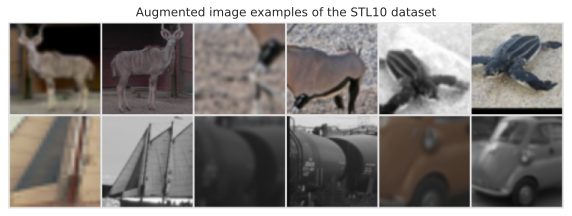

In [7]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the STL10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

We see the wide variety of our data augmentation, including randomly cropping, grayscaling, gaussian blur, and color distortion.
Thus, it remains a challenging task for the model to match two, independently augmented patches of the same image.

### SimCLR implementation

Using the data loader pipeline above, we can now implement SimCLR.
At each iteration, we get for every image $x$ two differently augmented versions, which we refer to as $\tilde{x}_i$ and $\tilde{x}_j$.
Both of these images are encoded into a one-dimensional feature vector, between which we want to maximize similarity which minimizes it to all other images in the batch.
The encoder network is split into two parts: a base encoder network $f(\cdot)$, and a projection head $g(\cdot)$.
The base network is usually a deep CNN as we have seen in e.g. [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html) before, and is responsible for extracting a representation vector from the augmented data examples.
In our experiments, we will use the common ResNet-18 architecture as $f(\cdot)$, and refer to the output as $f(\tilde{x}_i)=h_i$.
The projection head $g(\cdot)$ maps the representation $h$ into a space where we apply the contrastive loss, i.e., compare similarities between vectors.
It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer.
Note that in the follow-up paper, [SimCLRv2](https://arxiv.org/abs/2006.10029), the authors mention that larger/wider MLPs can boost the performance considerably.
This is why we apply an MLP with four times larger hidden dimensions, but deeper MLPs showed to overfit on the given dataset.
The general setup is visualized below (figure credit - [Ting Chen et al. ](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_network_setup.svg" width="350px"></center>

After finishing the training with contrastive learning, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor.
The representations $z$ that come out of the projection head $g(\cdot)$ have been shown to perform worse than those of the base network $f(\cdot)$ when finetuning the network for a new task.
This is likely because the representations $z$ are trained to become invariant to many features like the color that can be important for downstream tasks.
Thus, $g(\cdot)$ is only needed for the contrastive learning stage.

Now that the architecture is described, let's take a closer look at how we train the model.
As mentioned before, we want to maximize the similarity between the representations of the two augmented versions of the same image, i.e., $z_i$ and $z_j$ in the figure above, while minimizing it to all other examples in the batch.
SimCLR thereby applies the InfoNCE loss, originally proposed by [Aaron van den Oord et al. ](https://arxiv.org/abs/1807.03748) for contrastive learning.
In short, the InfoNCE loss compares the similarity of $z_i$ and $z_j$ to the similarity of $z_i$ to any other representation in the batch by performing a softmax over the similarity values.
The loss can be formally written as:
$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$
The function $\text{sim}$ is a similarity metric, and the hyperparameter $\tau$ is called temperature determining how peaked the distribution is.
Since many similarity metrics are bounded, the temperature parameter allows us to balance the influence of many dissimilar image patches versus one similar patch.
The similarity metric that is used in SimCLR is cosine similarity, as defined below:
$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$
The maximum cosine similarity possible is $1$, while the minimum is $-1$.
In general, we will see that the features of two different images will converge to a cosine similarity around zero since the minimum, $-1$, would require $z_i$ and $z_j$ to be in the exact opposite direction in all feature dimensions, which does not allow for great flexibility.

Finally, now that we have discussed all details, let's implement SimCLR below as a PyTorch Lightning module:

In [8]:
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, "The temperature must be a positive float!"
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(
            pretrained=False, num_classes=4 * hidden_dim
        )  # num_classes is the output size of the last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim),
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode="train"):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + "_loss", nll)
        # Get ranking position of positive example
        comb_sim = torch.cat(
            [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
            dim=-1,
        )
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode="val")

Alternatively to performing the validation on the contrastive learning loss as well, we could also take a simple, small downstream task, and track the performance of the base network $f(\cdot)$ on that.
However, in this tutorial, we will restrict ourselves to the STL10
dataset where we use the task of image classification on STL10 as our
test task.

### Training

Now that we have implemented SimCLR and the data loading pipeline, we are ready to train the model.
We will use the same training function setup as usual.
For saving the best model checkpoint, we track the metric `val_acc_top5`, which describes how often the correct image patch is within the top-5 most similar examples in the batch.
This is usually less noisy than the top-1 metric, making it a better metric to choose the best model from.

In [9]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "SimCLR"),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc_top5"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SimCLR.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = SimCLR.load_from_checkpoint(pretrained_filename)
    else:
        train_loader = data.DataLoader(
            unlabeled_data,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        val_loader = data.DataLoader(
            train_data_contrast,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        # Load best checkpoint after training
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

A common observation in contrastive learning is that the larger the batch size, the better the models perform.
A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients.
However, in our case, we experienced that a batch size of 256 was sufficient to get good results.

In [10]:
simclr_model = train_simclr(
    batch_size=256, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=500
)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Found pretrained model at saved_models/ContrastiveLearning/SimCLR.ckpt, loading...


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/ContrastiveLearning/SimCLR.ckpt`


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


To get an intuition of how training with contrastive learning behaves, we can take a look at the TensorBoard below:

In [11]:
%tensorboard --logdir ../saved_models/tutorial17/tensorboards/SimCLR/

<center width="100%"> 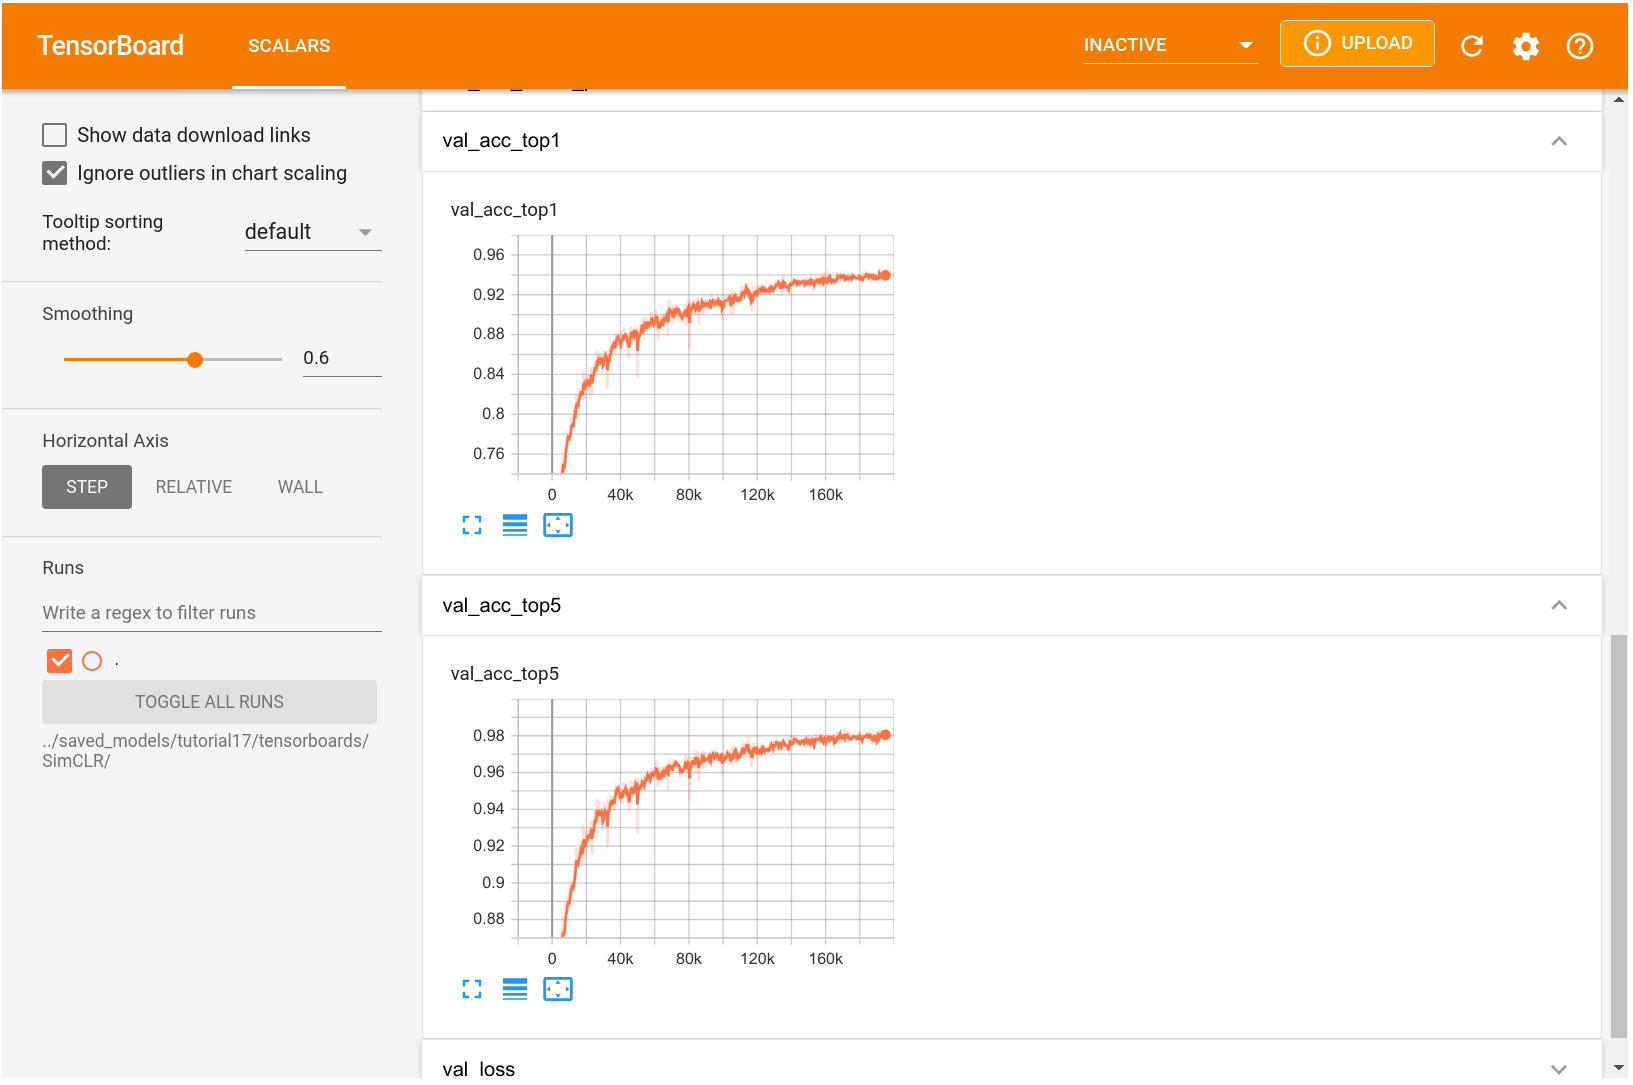{width="1200px"} </center>

One thing to note is that contrastive learning benefits a lot from long training.
The shown plot above is from a training that took approx.
1 day on a NVIDIA TitanRTX.
Training the model for even longer might reduce its loss further, but we did not experience any gains from it for the downstream task on image classification.
In general, contrastive learning can also benefit from using larger models, if sufficient unlabeled data is available.

## Logistic Regression

<div class="center-wrapper"><div class="video-wrapper"><iframe src="https://www.youtube.com/embed/o3FktysLLd4" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div></div>
After we have trained our model via contrastive learning, we can deploy it on downstream tasks and see how well it performs with little data.
A common setup, which also verifies whether the model has learned generalized representations, is to perform Logistic Regression on the features.
In other words, we learn a single, linear layer that maps the representations to a class prediction.
Since the base network $f(\cdot)$ is not changed during the training process, the model can only perform well if the representations of $h$ describe all features that might be necessary for the task.
Further, we do not have to worry too much about overfitting since we have very few parameters that are trained.
Hence, we might expect that the model can perform well even with very little data.

First, let's implement a simple Logistic Regression setup for which we assume that the images already have been encoded in their feature vectors.
If very little data is available, it might be beneficial to dynamically encode the images during training so that we can also apply data augmentations.
However, the way we implement it here is much more efficient and can be trained within a few seconds.
Further, using data augmentations did not show any significant gain in this simple setup.

In [12]:
class LogisticRegression(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[int(self.hparams.max_epochs * 0.6), int(self.hparams.max_epochs * 0.8)], gamma=0.1
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

The data we use is the training and test set of STL10.
The training contains 500 images per class, while the test set has 800 images per class.

In [13]:
img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split="train", download=True, transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split="test", download=True, transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Files already downloaded and verified


Files already downloaded and verified
Number of training examples: 5000
Number of test examples: 8000


Next, we implement a small function to encode all images in our datasets.
The output representations are then used as inputs to the Logistic Regression model.

In [14]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

Let's apply the function to both training and test set below.

In [15]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Finally, we can write a training function as usual.
We evaluate the model on the test set every 10 epochs to allow early
stopping, but the low frequency of the validation ensures that we do not
overfit too much on the test set.

In [16]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        enable_progress_bar=False,
        check_val_every_n_epoch=10,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(
        train_feats_data, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0
    )
    test_loader = data.DataLoader(
        test_feats_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, dataloaders=train_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

Despite the training dataset of STL10 already only having 500 labeled images per class, we will perform experiments with even smaller datasets.
Specifically, we train a Logistic Regression model for datasets with only 10, 20, 50, 100, 200, and all 500 examples per class.
This gives us an intuition on how well the representations learned by contrastive learning can be transferred to a image recognition task like this classification.
First, let's define a function to create the intended sub-datasets from the full training set:

In [17]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *(t.unflatten(0, (10, 500))[:, :num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors)
    )
    return new_dataset

Next, let's run all models.
Despite us training 6 models, this cell could be run within a minute or two without the pretrained models.

In [18]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_logreg(
        batch_size=64,
        train_feats_data=sub_train_set,
        test_feats_data=test_feats_simclr,
        model_suffix=num_imgs_per_label,
        feature_dim=train_feats_simclr.tensors[0].shape[1],
        num_classes=10,
        lr=1e-3,
        weight_decay=1e-3,
    )
    results[num_imgs_per_label] = small_set_results

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Lightning automatically upgraded your loaded checkpoint from 

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Missing logger folder: saved_models/ContrastiveLearning/LogisticRegression/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Found pretrained model at saved_models/ContrastiveLearning/LogisticRegression_10.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/ContrastiveLearning/LogisticRegression_20.ckpt`


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at saved_models/ContrastiveLearning/LogisticRegression_20.ckpt, loading...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/ContrastiveLearning/LogisticRegression_50.ckpt`


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at saved_models/ContrastiveLearning/LogisticRegression_50.ckpt, loading...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/ContrastiveLearning/LogisticRegression_100.ckpt`


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at saved_models/ContrastiveLearning/LogisticRegression_100.ckpt, loading...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/ContrastiveLearning/LogisticRegression_200.ckpt`


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at saved_models/ContrastiveLearning/LogisticRegression_200.ckpt, loading...


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/ContrastiveLearning/LogisticRegression_500.ckpt`


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at saved_models/ContrastiveLearning/LogisticRegression_500.ckpt, loading...


Finally, let's plot the results.

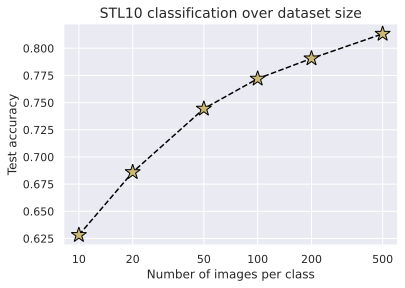

Test accuracy for  10 images per label: 62.81%
Test accuracy for  20 images per label: 68.60%
Test accuracy for  50 images per label: 74.44%
Test accuracy for 100 images per label: 77.20%
Test accuracy for 200 images per label: 79.06%
Test accuracy for 500 images per label: 81.33%


In [19]:
dataset_sizes = sorted(k for k in results)
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    dataset_sizes,
    test_scores,
    "--",
    color="#000",
    marker="*",
    markeredgecolor="#000",
    markerfacecolor="y",
    markersize=16,
)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f"Test accuracy for {k:3d} images per label: {100*score:4.2f}%")

As one would expect, the classification performance improves the more data we have.
However, with only 10 images per class, we can already classify more than 60% of the images correctly.
This is quite impressive, considering that the images are also higher dimensional than e.g. CIFAR10.
With the full dataset, we achieve an accuracy of 81%.
The increase between 50 to 500 images per class might suggest a linear increase in performance with an exponentially larger dataset.
However, with even more data, we could also finetune $f(\cdot)$ in the training process, allowing for the representations to adapt more to the specific classification task given.

To set the results above into perspective, we will train the base
network, a ResNet-18, on the classification task from scratch.

## Baseline

As a baseline to our results above, we will train a standard ResNet-18 with random initialization on the labeled training set of STL10.
The results will give us an indication of the advantages that contrastive learning on unlabeled data has compared to using only supervised training.
The implementation of the model is straightforward since the ResNet
architecture is provided in the torchvision library.

In [20]:
class ResNet(pl.LightningModule):
    def __init__(self, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = torchvision.models.resnet18(pretrained=False, num_classes=num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[int(self.hparams.max_epochs * 0.7), int(self.hparams.max_epochs * 0.9)], gamma=0.1
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

It is clear that the ResNet easily overfits on the training data since its parameter count is more than 1000 times larger than the dataset size.
To make the comparison to the contrastive learning models fair, we apply data augmentations similar to the ones we used before: horizontal flip, crop-and-resize, grayscale, and gaussian blur.
Color distortions as before are not used because the color distribution of an image showed to be an important feature for the classification.
Hence, we observed no noticeable performance gains when adding color distortions to the set of augmentations.
Similarly, we restrict the resizing operation before cropping to the max.
125% of its original resolution, instead of 1250% as done in SimCLR.
This is because, for classification, the model needs to recognize the full object, while in contrastive learning, we only want to check whether two patches belong to the same image/object.
Hence, the chosen augmentations below are overall weaker than in the contrastive learning case.

In [21]:
train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_img_aug_data = STL10(root=DATASET_PATH, split="train", download=True, transform=train_transforms)

Files already downloaded and verified


The training function for the ResNet is almost identical to the Logistic Regression setup.
Note that we allow the ResNet to perform validation every 2 epochs to
also check whether the model overfits strongly in the first iterations
or not.

In [22]:
def train_resnet(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        check_val_every_n_epoch=2,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(
        train_img_aug_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )
    test_loader = data.DataLoader(
        test_img_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=NUM_WORKERS
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ResNet.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = ResNet(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = ResNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    train_result = trainer.test(model, dataloaders=train_loader, verbose=False)
    val_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": val_result[0]["test_acc"]}

    return model, result

Finally, let's train the model and check its results:

In [23]:
resnet_model, resnet_result = train_resnet(batch_size=64, num_classes=10, lr=1e-3, weight_decay=2e-4, max_epochs=100)
print(f"Accuracy on training set: {100*resnet_result['train']:4.2f}%")
print(f"Accuracy on test set: {100*resnet_result['test']:4.2f}%")

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Lightning automatically upgraded your loaded checkpoint from 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Found pretrained model at saved_models/ContrastiveLearning/ResNet.ckpt, loading...


Missing logger folder: saved_models/ContrastiveLearning/ResNet/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

Accuracy on training set: 99.66%
Accuracy on test set: 73.31%


The ResNet trained from scratch achieves 73.31% on the test set.
This is almost 8% less than the contrastive learning model, and even slightly less than SimCLR achieves with 1/10 of the data.
This shows that self-supervised, contrastive learning provides
considerable performance gains by leveraging large amounts of unlabeled
data when little labeled data is available.

## Conclusion

In this tutorial, we have discussed self-supervised contrastive learning and implemented SimCLR as an example method.
We have applied it to the STL10 dataset and showed that it can learn generalizable representations that we can use to train simple classification models.
With 500 images per label, it achieved an 8% higher accuracy than a similar model solely trained from supervision and performs on par with it when only using a tenth of the labeled data.
Our experimental results are limited to a single dataset, but recent works such as [Ting Chen et al. ](https://arxiv.org/abs/2006.10029) showed similar trends for larger datasets like ImageNet.
Besides the discussed hyperparameters, the size of the model seems to be important in contrastive learning as well.
If a lot of unlabeled data is available, larger models can achieve much stronger results and come close to their supervised baselines.
Further, there are also approaches for combining contrastive and supervised learning, leading to performance gains beyond supervision (see [Khosla et al.](https://arxiv.org/abs/2004.11362)).
Moreover, contrastive learning is not the only approach to self-supervised learning that has come up in the last two years and showed great results.
Other methods include distillation-based methods like [BYOL](https://arxiv.org/abs/2006.07733) and redundancy reduction techniques like [Barlow Twins](https://arxiv.org/abs/2103.03230).
There is a lot more to explore in the self-supervised domain, and more, impressive steps ahead are to be expected.

### References

[1] Chen, T., Kornblith, S., Norouzi, M., and Hinton, G. (2020).
A simple framework for contrastive learning of visual representations.
In International conference on machine learning (pp.
1597-1607).
PMLR.
([link](https://arxiv.org/abs/2002.05709))

[2] Chen, T., Kornblith, S., Swersky, K., Norouzi, M., and Hinton, G. (2020).
Big self-supervised models are strong semi-supervised learners.
NeurIPS 2021 ([link](https://arxiv.org/abs/2006.10029)).

[3] Oord, A. V. D., Li, Y., and Vinyals, O.
(2018).
Representation learning with contrastive predictive coding.
arXiv preprint arXiv:1807.03748.
([link](https://arxiv.org/abs/1807.03748))

[4] Grill, J.B., Strub, F., Altché, F., Tallec, C., Richemond, P.H., Buchatskaya, E., Doersch, C., Pires, B.A., Guo, Z.D., Azar, M.G.
and Piot, B.
(2020).
Bootstrap your own latent: A new approach to self-supervised learning.
arXiv preprint arXiv:2006.07733.
([link](https://arxiv.org/abs/2006.07733))

[5] Khosla, P., Teterwak, P., Wang, C., Sarna, A., Tian, Y., Isola, P., Maschinot, A., Liu, C. and Krishnan, D. (2020).
Supervised contrastive learning.
arXiv preprint arXiv:2004.11362.
([link](https://arxiv.org/abs/2004.11362))

[6] Zbontar, J., Jing, L., Misra, I., LeCun, Y. and Deny, S. (2021).
Barlow twins: Self-supervised learning via redundancy reduction.
arXiv preprint arXiv:2103.03230.
([link](https://arxiv.org/abs/2103.03230))

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/Lightning-AI/lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Discord](https://discord.com/invite/tfXFetEZxv)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/Lightning-AI/lightning) or [Bolt](https://github.com/Lightning-AI/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/Lightning-AI/lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/Lightning-AI/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[Pytorch Lightning{height="60px" width="240px"}](https://pytorchlightning.ai)